# TODOs:

- final train and val loss (best)

# Google colab initialization

For Google colab uncomment these lines and run them to access your drive or try the second way (not tested)

In [1]:
#USE_COLAB = True
#
#if USE_COLAB:
#    from google.colab import drive
#
#    drive.mount('/content/drive')
#    import sys
#
#    sys.path.insert(1, r'/content/drive/My Drive/')

In [2]:
USE_COLAB = False

In [3]:
# Other try
# !git clone https://github.com/Alexanderstaehle/OM_project

In [4]:
# import sys
# sys.path.append("OM_project")

# Imports and Setup

In [5]:
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

from utils import ml_utils, visualization, data_loading, tf_models

In [6]:
RETRAIN_FLAG = True
#RETRAIN_FLAG = False

In [7]:
filename_bs = lambda bs: ml_utils.path_from_filename(f'model_fixed_lr_diff_bs_{bs}', format_="tf")
filename_bs_lr = lambda bs, lr: ml_utils.path_from_filename(f'model_lr_{lr}_diff_bs_{bs}', format_="tf")

In [8]:
filename_bs_opt_sam = lambda bs, opt, sam: ml_utils.path_from_filename(
    f'model_fixed_lr_diff_bs_{bs}_opt_{opt}_sam_{sam}', format_="tf")
filename_bs_lr_opt_sam = lambda bs, lr, opt, sam: ml_utils.path_from_filename(
    f'model_lr_{lr}_diff_bs_{bs}_opt_{opt}_sam_{sam}', format_="tf")

In [9]:
def build_and_load_sam_model_weights(train, optimizer, filename, adaptive=False, rho=0.05):
    model = tf_models.build_simple_cnn_sam(train, optimizer, adaptive, rho)
    model.load_weights(filename)
    return model

In [10]:
def build_and_load_model_weights(train, optimizer, filename):
    model = tf_models.build_and_compile_simple_cnn(train, optimizer)
    model.load_weights(filename)
    return model

In [11]:
def callback_for_filename(filename):
    train_callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=10,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filename,
            monitor='val_loss',
            mode='min',
            verbose=1,
            save_best_only=True,
            save_weights_only=True
        )
    ]

    return train_callbacks

In [12]:
data_loading.initialize_env()
sns.set_theme()
color_map = sns.color_palette(as_cmap=True)
ml_utils.check_tpu_gpu()
# dataset_name = 'MNIST'
dataset_name = 'Fashion_MNIST'
EPOCHS = 500

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of accelerators:  1


2022-02-25 19:50:52.135797: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-25 19:50:52.166063: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-25 19:50:52.166244: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-25 19:50:52.167197: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [13]:
models = {}
models_states = {}
sharpnesses = ml_utils.init_sharpnesses_dict()
initial_weights = ml_utils.init_initial_weights_dict()

# Different batch sizes with fixed learning rate

## with sharpness aware minimization

### SGD with Momentum + SAM

In [14]:
batch_sizes = [32, 64, 128, 256, 512, 1024]
lr = 0.001
training_epochs = EPOCHS

key = ('fixed', 'sgd', 'sam')

In [15]:
if not RETRAIN_FLAG:
    for batch_size in batch_sizes:
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                          batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        model = build_and_load_sam_model_weights(train, optimizer, filename_bs_opt_sam(batch_size, "SGD-MOM", "SAM"))
        models[key + (batch_size,)] = model

In [16]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size in batch_sizes:
        with tf.distribute.MirroredStrategy().scope():
            # Read training data
            train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                              batch_size=batch_size,
                                                                              img_size=32)

            optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
            model = tf_models.build_simple_cnn_sam(train, optimizer)
            train_callbacks = callback_for_filename(filename_bs_opt_sam(batch_size, "SGD-MOM", "SAM"))

            models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                  extra_callbacks=train_callbacks, verbose=1)
            models[key + (batch_size,)] = model
            initial_weights[key + (batch_size,)] = model.get_weights()
            ml_utils.save_initial_weights_dict(initial_weights)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Epoch 1/500


2022-02-25 19:50:52.947840: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
2022-02-25 19:50:55.122762: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302
2022-02-25 19:50:55.591659: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1490/1500 [============================>.] - ETA: 0s - loss: 0.9691 - accuracy: 0.6305

2022-02-25 19:51:01.135510: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.58809, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 9s 4ms/step - loss: 0.9666 - accuracy: 0.6312 - val_loss: 0.5881 - val_accuracy: 0.7918
Epoch 2/500
1489/1500 [============================>.] - ETA: 0s - loss: 0.5810 - accuracy: 0.7707
Epoch 2: val_loss improved from 0.58809 to 0.47498, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.5803 - accuracy: 0.7710 - val_loss: 0.4750 - val_accuracy: 0.8336
Epoch 3/500
1497/1500 [============================>.] - ETA: 0s - loss: 0.5034 - accuracy: 0.8023
Epoch 3: val_loss improved from 0.47498 to 0.42729, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 8s 5ms/step - loss: 0.5034 - accuracy: 0.8023 - val_loss: 0.4273 - val_accuracy: 0.8513
Epoch 4/500
1494/1500 [====================

1500/1500 [==============================] - 10s 7ms/step - loss: 0.3022 - accuracy: 0.8815 - val_loss: 0.2755 - val_accuracy: 0.9055
Epoch 25/500
1500/1500 [==============================] - ETA: 0s - loss: 0.2990 - accuracy: 0.8829
Epoch 25: val_loss improved from 0.27547 to 0.27323, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 12s 8ms/step - loss: 0.2990 - accuracy: 0.8829 - val_loss: 0.2732 - val_accuracy: 0.9065
Epoch 26/500
1493/1500 [============================>.] - ETA: 0s - loss: 0.2962 - accuracy: 0.8838
Epoch 26: val_loss improved from 0.27323 to 0.27110, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2960 - accuracy: 0.8838 - val_loss: 0.2711 - val_accuracy: 0.9066
Epoch 27/500
1496/1500 [============================>.] - ETA: 0s - loss: 0.2932 - accuracy: 0.8849
Epoch 27: val_loss improved from 0.27110 to 0.26898, sa

Epoch 48/500
1491/1500 [============================>.] - ETA: 0s - loss: 0.2475 - accuracy: 0.9017
Epoch 48: val_loss improved from 0.23946 to 0.23845, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2472 - accuracy: 0.9018 - val_loss: 0.2384 - val_accuracy: 0.9172
Epoch 49/500
1498/1500 [============================>.] - ETA: 0s - loss: 0.2455 - accuracy: 0.9023
Epoch 49: val_loss improved from 0.23845 to 0.23747, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2456 - accuracy: 0.9023 - val_loss: 0.2375 - val_accuracy: 0.9173
Epoch 50/500
1492/1500 [============================>.] - ETA: 0s - loss: 0.2441 - accuracy: 0.9026
Epoch 50: val_loss improved from 0.23747 to 0.23650, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2

1500/1500 [==============================] - ETA: 0s - loss: 0.2140 - accuracy: 0.9138
Epoch 71: val_loss improved from 0.22218 to 0.22161, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 13s 9ms/step - loss: 0.2140 - accuracy: 0.9138 - val_loss: 0.2216 - val_accuracy: 0.9205
Epoch 72/500
1499/1500 [============================>.] - ETA: 0s - loss: 0.2127 - accuracy: 0.9142
Epoch 72: val_loss improved from 0.22161 to 0.22111, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 13s 8ms/step - loss: 0.2128 - accuracy: 0.9142 - val_loss: 0.2211 - val_accuracy: 0.9208
Epoch 73/500
1497/1500 [============================>.] - ETA: 0s - loss: 0.2115 - accuracy: 0.9147
Epoch 73: val_loss improved from 0.22111 to 0.22068, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 14s 9ms/step - loss: 0.2115 - accu

1500/1500 [==============================] - ETA: 0s - loss: 0.1886 - accuracy: 0.9235
Epoch 94: val_loss improved from 0.21442 to 0.21425, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1886 - accuracy: 0.9235 - val_loss: 0.2142 - val_accuracy: 0.9237
Epoch 95/500
1491/1500 [============================>.] - ETA: 0s - loss: 0.1878 - accuracy: 0.9237
Epoch 95: val_loss improved from 0.21425 to 0.21405, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1876 - accuracy: 0.9237 - val_loss: 0.2141 - val_accuracy: 0.9239
Epoch 96/500
1500/1500 [==============================] - ETA: 0s - loss: 0.1866 - accuracy: 0.9240
Epoch 96: val_loss improved from 0.21405 to 0.21385, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1866 - accurac

Epoch 117/500
1489/1500 [============================>.] - ETA: 0s - loss: 0.1679 - accuracy: 0.9310
Epoch 117: val_loss improved from 0.21147 to 0.21139, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 7s 4ms/step - loss: 0.1677 - accuracy: 0.9310 - val_loss: 0.2114 - val_accuracy: 0.9257
Epoch 118/500
1495/1500 [============================>.] - ETA: 0s - loss: 0.1668 - accuracy: 0.9314
Epoch 118: val_loss improved from 0.21139 to 0.21131, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1668 - accuracy: 0.9314 - val_loss: 0.2113 - val_accuracy: 0.9258
Epoch 119/500
1498/1500 [============================>.] - ETA: 0s - loss: 0.1659 - accuracy: 0.9316
Epoch 119: val_loss improved from 0.21131 to 0.21121, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 7s 4ms/step - los

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 20:11:15.044214: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
744/750 [============================>.] - ETA: 0s - loss: 1.2429 - accuracy: 0.5279

2022-02-25 20:11:19.296097: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.70119, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 5s 6ms/step - loss: 1.2386 - accuracy: 0.5295 - val_loss: 0.7012 - val_accuracy: 0.7639
Epoch 2/500
750/750 [==============================] - ETA: 0s - loss: 0.6941 - accuracy: 0.7296
Epoch 2: val_loss improved from 0.70119 to 0.57597, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.6941 - accuracy: 0.7296 - val_loss: 0.5760 - val_accuracy: 0.7948
Epoch 3/500
745/750 [============================>.] - ETA: 0s - loss: 0.5923 - accuracy: 0.7674
Epoch 3: val_loss improved from 0.57597 to 0.50825, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.5918 - accuracy: 0.7677 - val_loss: 0.5082 - val_accuracy: 0.8199
Epoch 4/500
742/750 [============================>.] 

Epoch 25/500
742/750 [============================>.] - ETA: 0s - loss: 0.3401 - accuracy: 0.8697
Epoch 25: val_loss improved from 0.31206 to 0.30968, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.3396 - accuracy: 0.8698 - val_loss: 0.3097 - val_accuracy: 0.8926
Epoch 26/500
747/750 [============================>.] - ETA: 0s - loss: 0.3367 - accuracy: 0.8707
Epoch 26: val_loss improved from 0.30968 to 0.30734, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.3366 - accuracy: 0.8707 - val_loss: 0.3073 - val_accuracy: 0.8932
Epoch 27/500
747/750 [============================>.] - ETA: 0s - loss: 0.3339 - accuracy: 0.8718
Epoch 27: val_loss improved from 0.30734 to 0.30526, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.3338 - accura

750/750 [==============================] - 4s 5ms/step - loss: 0.2914 - accuracy: 0.8870 - val_loss: 0.2737 - val_accuracy: 0.9057
Epoch 49/500
741/750 [============================>.] - ETA: 0s - loss: 0.2903 - accuracy: 0.8873
Epoch 49: val_loss improved from 0.27373 to 0.27267, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.2898 - accuracy: 0.8874 - val_loss: 0.2727 - val_accuracy: 0.9057
Epoch 50/500
742/750 [============================>.] - ETA: 0s - loss: 0.2889 - accuracy: 0.8878
Epoch 50: val_loss improved from 0.27267 to 0.27159, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.2883 - accuracy: 0.8880 - val_loss: 0.2716 - val_accuracy: 0.9058
Epoch 51/500
750/750 [==============================] - ETA: 0s - loss: 0.2869 - accuracy: 0.8889
Epoch 51: val_loss improved from 0.27159 to 0.27058, saving model to 

Epoch 72/500
745/750 [============================>.] - ETA: 0s - loss: 0.2610 - accuracy: 0.8980
Epoch 72: val_loss improved from 0.25380 to 0.25315, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 7s 10ms/step - loss: 0.2606 - accuracy: 0.8981 - val_loss: 0.2531 - val_accuracy: 0.9103
Epoch 73/500
748/750 [============================>.] - ETA: 0s - loss: 0.2596 - accuracy: 0.8984
Epoch 73: val_loss improved from 0.25315 to 0.25245, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 6s 7ms/step - loss: 0.2595 - accuracy: 0.8985 - val_loss: 0.2524 - val_accuracy: 0.9107
Epoch 74/500
746/750 [============================>.] - ETA: 0s - loss: 0.2587 - accuracy: 0.8990
Epoch 74: val_loss improved from 0.25245 to 0.25177, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 5s 7ms/step - loss: 0.2585 - accur

750/750 [==============================] - 4s 5ms/step - loss: 0.2387 - accuracy: 0.9063 - val_loss: 0.2400 - val_accuracy: 0.9152
Epoch 96/500
748/750 [============================>.] - ETA: 0s - loss: 0.2379 - accuracy: 0.9066
Epoch 96: val_loss improved from 0.24000 to 0.23953, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.2378 - accuracy: 0.9066 - val_loss: 0.2395 - val_accuracy: 0.9152
Epoch 97/500
745/750 [============================>.] - ETA: 0s - loss: 0.2374 - accuracy: 0.9067
Epoch 97: val_loss improved from 0.23953 to 0.23911, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.2370 - accuracy: 0.9068 - val_loss: 0.2391 - val_accuracy: 0.9153
Epoch 98/500
743/750 [============================>.] - ETA: 0s - loss: 0.2366 - accuracy: 0.9071
Epoch 98: val_loss improved from 0.23911 to 0.23866, saving model to 

Epoch 119/500
740/750 [============================>.] - ETA: 0s - loss: 0.2206 - accuracy: 0.9132
Epoch 119: val_loss improved from 0.23109 to 0.23080, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.2202 - accuracy: 0.9134 - val_loss: 0.2308 - val_accuracy: 0.9188
Epoch 120/500
743/750 [============================>.] - ETA: 0s - loss: 0.2199 - accuracy: 0.9134
Epoch 120: val_loss improved from 0.23080 to 0.23051, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.2195 - accuracy: 0.9135 - val_loss: 0.2305 - val_accuracy: 0.9187
Epoch 121/500
746/750 [============================>.] - ETA: 0s - loss: 0.2189 - accuracy: 0.9138
Epoch 121: val_loss improved from 0.23051 to 0.23020, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.2188 - 

750/750 [==============================] - ETA: 0s - loss: 0.2049 - accuracy: 0.9186
Epoch 142: val_loss improved from 0.22501 to 0.22481, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.2049 - accuracy: 0.9186 - val_loss: 0.2248 - val_accuracy: 0.9199
Epoch 143/500
745/750 [============================>.] - ETA: 0s - loss: 0.2045 - accuracy: 0.9187
Epoch 143: val_loss improved from 0.22481 to 0.22460, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.2043 - accuracy: 0.9188 - val_loss: 0.2246 - val_accuracy: 0.9197
Epoch 144/500
743/750 [============================>.] - ETA: 0s - loss: 0.2040 - accuracy: 0.9189
Epoch 144: val_loss improved from 0.22460 to 0.22436, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.2037 - accuracy: 0.91

741/750 [============================>.] - ETA: 0s - loss: 0.1916 - accuracy: 0.9239
Epoch 165: val_loss improved from 0.22103 to 0.22088, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.1913 - accuracy: 0.9239 - val_loss: 0.2209 - val_accuracy: 0.9218
Epoch 166/500
747/750 [============================>.] - ETA: 0s - loss: 0.1907 - accuracy: 0.9242
Epoch 166: val_loss improved from 0.22088 to 0.22072, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.1907 - accuracy: 0.9242 - val_loss: 0.2207 - val_accuracy: 0.9222
Epoch 167/500
740/750 [============================>.] - ETA: 0s - loss: 0.1905 - accuracy: 0.9243
Epoch 167: val_loss improved from 0.22072 to 0.22057, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 4s 6ms/step - loss: 0.1902 - accuracy: 0.92

742/750 [============================>.] - ETA: 0s - loss: 0.1791 - accuracy: 0.9293
Epoch 188: val_loss improved from 0.21872 to 0.21865, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.1788 - accuracy: 0.9293 - val_loss: 0.2187 - val_accuracy: 0.9225
Epoch 189/500
748/750 [============================>.] - ETA: 0s - loss: 0.1783 - accuracy: 0.9295
Epoch 189: val_loss improved from 0.21865 to 0.21857, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.1783 - accuracy: 0.9295 - val_loss: 0.2186 - val_accuracy: 0.9227
Epoch 190/500
748/750 [============================>.] - ETA: 0s - loss: 0.1778 - accuracy: 0.9296
Epoch 190: val_loss improved from 0.21857 to 0.21849, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.1778 - accuracy: 0.92

Epoch 212/500
741/750 [============================>.] - ETA: 0s - loss: 0.1673 - accuracy: 0.9335
Epoch 212: val_loss improved from 0.21788 to 0.21788, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 4s 6ms/step - loss: 0.1670 - accuracy: 0.9335 - val_loss: 0.2179 - val_accuracy: 0.9233
Epoch 213/500
741/750 [============================>.] - ETA: 0s - loss: 0.1668 - accuracy: 0.9336
Epoch 213: val_loss did not improve from 0.21788
750/750 [==============================] - 4s 5ms/step - loss: 0.1665 - accuracy: 0.9336 - val_loss: 0.2179 - val_accuracy: 0.9232
Epoch 214/500
750/750 [==============================] - ETA: 0s - loss: 0.1660 - accuracy: 0.9338
Epoch 214: val_loss did not improve from 0.21788
750/750 [==============================] - 4s 5ms/step - loss: 0.1660 - accuracy: 0.9338 - val_loss: 0.2179 - val_accuracy: 0.9233
Epoch 215/500
744/750 [============================>.] - ETA: 0s - loss: 0.1658 - accurac

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 20:27:00.275117: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
371/375 [============================>.] - ETA: 0s - loss: 1.4326 - accuracy: 0.4591

2022-02-25 20:27:04.374426: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.81506, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 6s 11ms/step - loss: 1.4268 - accuracy: 0.4612 - val_loss: 0.8151 - val_accuracy: 0.7141
Epoch 2/500
375/375 [==============================] - ETA: 0s - loss: 0.8031 - accuracy: 0.6885
Epoch 2: val_loss improved from 0.81506 to 0.67245, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 3s 9ms/step - loss: 0.8031 - accuracy: 0.6885 - val_loss: 0.6724 - val_accuracy: 0.7734
Epoch 3/500
370/375 [============================>.] - ETA: 0s - loss: 0.6942 - accuracy: 0.7322
Epoch 3: val_loss improved from 0.67245 to 0.60979, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 3s 9ms/step - loss: 0.6940 - accuracy: 0.7324 - val_loss: 0.6098 - val_accuracy: 0.7883
Epoch 4/500
375/375 [============================

375/375 [==============================] - 3s 9ms/step - loss: 0.3881 - accuracy: 0.8526 - val_loss: 0.3542 - val_accuracy: 0.8760
Epoch 25/500
375/375 [==============================] - ETA: 0s - loss: 0.3842 - accuracy: 0.8541
Epoch 25: val_loss improved from 0.35416 to 0.35093, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 3s 9ms/step - loss: 0.3842 - accuracy: 0.8541 - val_loss: 0.3509 - val_accuracy: 0.8779
Epoch 26/500
373/375 [============================>.] - ETA: 0s - loss: 0.3808 - accuracy: 0.8556
Epoch 26: val_loss improved from 0.35093 to 0.34789, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 3s 9ms/step - loss: 0.3805 - accuracy: 0.8557 - val_loss: 0.3479 - val_accuracy: 0.8788
Epoch 27/500
370/375 [============================>.] - ETA: 0s - loss: 0.3776 - accuracy: 0.8568
Epoch 27: val_loss improved from 0.34789 to 0.34496, saving model t

Epoch 48/500
372/375 [============================>.] - ETA: 0s - loss: 0.3300 - accuracy: 0.8746
Epoch 48: val_loss improved from 0.30702 to 0.30565, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 4s 10ms/step - loss: 0.3294 - accuracy: 0.8748 - val_loss: 0.3057 - val_accuracy: 0.8942
Epoch 49/500
370/375 [============================>.] - ETA: 0s - loss: 0.3284 - accuracy: 0.8751
Epoch 49: val_loss improved from 0.30565 to 0.30439, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 4s 10ms/step - loss: 0.3278 - accuracy: 0.8752 - val_loss: 0.3044 - val_accuracy: 0.8942
Epoch 50/500
374/375 [============================>.] - ETA: 0s - loss: 0.3264 - accuracy: 0.8758
Epoch 50: val_loss improved from 0.30439 to 0.30321, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 4s 10ms/step - loss: 0.3263 - 

371/375 [============================>.] - ETA: 0s - loss: 0.3009 - accuracy: 0.8853
Epoch 71: val_loss improved from 0.28361 to 0.28282, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 4s 10ms/step - loss: 0.3003 - accuracy: 0.8854 - val_loss: 0.2828 - val_accuracy: 0.8999
Epoch 72/500
373/375 [============================>.] - ETA: 0s - loss: 0.2996 - accuracy: 0.8857
Epoch 72: val_loss improved from 0.28282 to 0.28203, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 3s 9ms/step - loss: 0.2993 - accuracy: 0.8858 - val_loss: 0.2820 - val_accuracy: 0.9003
Epoch 73/500
372/375 [============================>.] - ETA: 0s - loss: 0.2988 - accuracy: 0.8860
Epoch 73: val_loss improved from 0.28203 to 0.28130, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 4s 10ms/step - loss: 0.2983 - accuracy: 0.88

375/375 [==============================] - 3s 9ms/step - loss: 0.2796 - accuracy: 0.8934 - val_loss: 0.2677 - val_accuracy: 0.9049
Epoch 95/500
373/375 [============================>.] - ETA: 0s - loss: 0.2790 - accuracy: 0.8937
Epoch 95: val_loss improved from 0.26769 to 0.26714, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 3s 9ms/step - loss: 0.2788 - accuracy: 0.8938 - val_loss: 0.2671 - val_accuracy: 0.9053
Epoch 96/500
370/375 [============================>.] - ETA: 0s - loss: 0.2785 - accuracy: 0.8939
Epoch 96: val_loss improved from 0.26714 to 0.26656, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 3s 9ms/step - loss: 0.2780 - accuracy: 0.8940 - val_loss: 0.2666 - val_accuracy: 0.9053
Epoch 97/500
370/375 [============================>.] - ETA: 0s - loss: 0.2777 - accuracy: 0.8942
Epoch 97: val_loss improved from 0.26656 to 0.26601, saving model t

Epoch 118/500
371/375 [============================>.] - ETA: 0s - loss: 0.2626 - accuracy: 0.8985
Epoch 118: val_loss improved from 0.25635 to 0.25591, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 4s 10ms/step - loss: 0.2621 - accuracy: 0.8986 - val_loss: 0.2559 - val_accuracy: 0.9074
Epoch 119/500
373/375 [============================>.] - ETA: 0s - loss: 0.2617 - accuracy: 0.8988
Epoch 119: val_loss improved from 0.25591 to 0.25549, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 4s 10ms/step - loss: 0.2614 - accuracy: 0.8988 - val_loss: 0.2555 - val_accuracy: 0.9079
Epoch 120/500
374/375 [============================>.] - ETA: 0s - loss: 0.2609 - accuracy: 0.8992
Epoch 120: val_loss improved from 0.25549 to 0.25509, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 4s 9ms/step - loss: 0.26

370/375 [============================>.] - ETA: 0s - loss: 0.2485 - accuracy: 0.9041
Epoch 141: val_loss improved from 0.24787 to 0.24753, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 4s 9ms/step - loss: 0.2480 - accuracy: 0.9042 - val_loss: 0.2475 - val_accuracy: 0.9117
Epoch 142/500
375/375 [==============================] - ETA: 0s - loss: 0.2475 - accuracy: 0.9045
Epoch 142: val_loss improved from 0.24753 to 0.24721, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 4s 10ms/step - loss: 0.2475 - accuracy: 0.9045 - val_loss: 0.2472 - val_accuracy: 0.9114
Epoch 143/500
370/375 [============================>.] - ETA: 0s - loss: 0.2474 - accuracy: 0.9045
Epoch 143: val_loss improved from 0.24721 to 0.24689, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 4s 10ms/step - loss: 0.2469 - accuracy:

372/375 [============================>.] - ETA: 0s - loss: 0.2364 - accuracy: 0.9089
Epoch 164: val_loss improved from 0.24119 to 0.24095, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 4s 11ms/step - loss: 0.2360 - accuracy: 0.9091 - val_loss: 0.2409 - val_accuracy: 0.9134
Epoch 165/500
371/375 [============================>.] - ETA: 0s - loss: 0.2360 - accuracy: 0.9093
Epoch 165: val_loss improved from 0.24095 to 0.24067, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 4s 10ms/step - loss: 0.2355 - accuracy: 0.9094 - val_loss: 0.2407 - val_accuracy: 0.9136
Epoch 166/500
370/375 [============================>.] - ETA: 0s - loss: 0.2355 - accuracy: 0.9093
Epoch 166: val_loss improved from 0.24067 to 0.24043, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 4s 10ms/step - loss: 0.2350 - accuracy

374/375 [============================>.] - ETA: 0s - loss: 0.2255 - accuracy: 0.9130
Epoch 187: val_loss improved from 0.23578 to 0.23557, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 3s 9ms/step - loss: 0.2254 - accuracy: 0.9130 - val_loss: 0.2356 - val_accuracy: 0.9157
Epoch 188/500
375/375 [==============================] - ETA: 0s - loss: 0.2250 - accuracy: 0.9131
Epoch 188: val_loss improved from 0.23557 to 0.23535, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 4s 10ms/step - loss: 0.2250 - accuracy: 0.9131 - val_loss: 0.2353 - val_accuracy: 0.9157
Epoch 189/500
374/375 [============================>.] - ETA: 0s - loss: 0.2247 - accuracy: 0.9132
Epoch 189: val_loss improved from 0.23535 to 0.23516, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 3s 9ms/step - loss: 0.2246 - accuracy: 

372/375 [============================>.] - ETA: 0s - loss: 0.2162 - accuracy: 0.9164
Epoch 210: val_loss improved from 0.23140 to 0.23121, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 4s 10ms/step - loss: 0.2158 - accuracy: 0.9165 - val_loss: 0.2312 - val_accuracy: 0.9175
Epoch 211/500
371/375 [============================>.] - ETA: 0s - loss: 0.2158 - accuracy: 0.9164
Epoch 211: val_loss improved from 0.23121 to 0.23103, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 4s 10ms/step - loss: 0.2154 - accuracy: 0.9166 - val_loss: 0.2310 - val_accuracy: 0.9174
Epoch 212/500
372/375 [============================>.] - ETA: 0s - loss: 0.2154 - accuracy: 0.9165
Epoch 212: val_loss improved from 0.23103 to 0.23085, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 3s 9ms/step - loss: 0.2150 - accuracy:

372/375 [============================>.] - ETA: 0s - loss: 0.2073 - accuracy: 0.9194
Epoch 233: val_loss improved from 0.22765 to 0.22751, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 3s 9ms/step - loss: 0.2070 - accuracy: 0.9196 - val_loss: 0.2275 - val_accuracy: 0.9178
Epoch 234/500
375/375 [==============================] - ETA: 0s - loss: 0.2066 - accuracy: 0.9196
Epoch 234: val_loss improved from 0.22751 to 0.22735, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 4s 10ms/step - loss: 0.2066 - accuracy: 0.9196 - val_loss: 0.2273 - val_accuracy: 0.9181
Epoch 235/500
373/375 [============================>.] - ETA: 0s - loss: 0.2064 - accuracy: 0.9198
Epoch 235: val_loss improved from 0.22735 to 0.22718, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 3s 9ms/step - loss: 0.2062 - accuracy: 

373/375 [============================>.] - ETA: 0s - loss: 0.1987 - accuracy: 0.9224
Epoch 256: val_loss improved from 0.22449 to 0.22437, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 4s 10ms/step - loss: 0.1986 - accuracy: 0.9225 - val_loss: 0.2244 - val_accuracy: 0.9191
Epoch 257/500
374/375 [============================>.] - ETA: 0s - loss: 0.1983 - accuracy: 0.9228
Epoch 257: val_loss improved from 0.22437 to 0.22423, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 4s 10ms/step - loss: 0.1982 - accuracy: 0.9228 - val_loss: 0.2242 - val_accuracy: 0.9193
Epoch 258/500
373/375 [============================>.] - ETA: 0s - loss: 0.1980 - accuracy: 0.9229
Epoch 258: val_loss improved from 0.22423 to 0.22411, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 4s 9ms/step - loss: 0.1979 - accuracy:

374/375 [============================>.] - ETA: 0s - loss: 0.1908 - accuracy: 0.9256
Epoch 279: val_loss improved from 0.22191 to 0.22183, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 4s 9ms/step - loss: 0.1907 - accuracy: 0.9257 - val_loss: 0.2218 - val_accuracy: 0.9209
Epoch 280/500
370/375 [============================>.] - ETA: 0s - loss: 0.1908 - accuracy: 0.9256
Epoch 280: val_loss improved from 0.22183 to 0.22172, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 3s 9ms/step - loss: 0.1904 - accuracy: 0.9259 - val_loss: 0.2217 - val_accuracy: 0.9210
Epoch 281/500
372/375 [============================>.] - ETA: 0s - loss: 0.1904 - accuracy: 0.9258
Epoch 281: val_loss improved from 0.22172 to 0.22161, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 4s 9ms/step - loss: 0.1901 - accuracy: 0

375/375 [==============================] - ETA: 0s - loss: 0.1832 - accuracy: 0.9277
Epoch 302: val_loss improved from 0.21995 to 0.21987, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 4s 9ms/step - loss: 0.1832 - accuracy: 0.9277 - val_loss: 0.2199 - val_accuracy: 0.9210
Epoch 303/500
369/375 [============================>.] - ETA: 0s - loss: 0.1832 - accuracy: 0.9279
Epoch 303: val_loss improved from 0.21987 to 0.21981, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 4s 10ms/step - loss: 0.1829 - accuracy: 0.9281 - val_loss: 0.2198 - val_accuracy: 0.9211
Epoch 304/500
375/375 [==============================] - ETA: 0s - loss: 0.1825 - accuracy: 0.9281
Epoch 304: val_loss improved from 0.21981 to 0.21975, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 4s 10ms/step - loss: 0.1825 - accuracy:

373/375 [============================>.] - ETA: 0s - loss: 0.1761 - accuracy: 0.9305
Epoch 325: val_loss improved from 0.21835 to 0.21828, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 4s 10ms/step - loss: 0.1760 - accuracy: 0.9306 - val_loss: 0.2183 - val_accuracy: 0.9219
Epoch 326/500
371/375 [============================>.] - ETA: 0s - loss: 0.1760 - accuracy: 0.9306
Epoch 326: val_loss improved from 0.21828 to 0.21823, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 3s 9ms/step - loss: 0.1757 - accuracy: 0.9307 - val_loss: 0.2182 - val_accuracy: 0.9218
Epoch 327/500
373/375 [============================>.] - ETA: 0s - loss: 0.1755 - accuracy: 0.9307
Epoch 327: val_loss improved from 0.21823 to 0.21816, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 4s 9ms/step - loss: 0.1754 - accuracy: 

373/375 [============================>.] - ETA: 0s - loss: 0.1692 - accuracy: 0.9334
Epoch 348: val_loss improved from 0.21725 to 0.21720, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 4s 10ms/step - loss: 0.1691 - accuracy: 0.9334 - val_loss: 0.2172 - val_accuracy: 0.9215
Epoch 349/500
373/375 [============================>.] - ETA: 0s - loss: 0.1689 - accuracy: 0.9335
Epoch 349: val_loss improved from 0.21720 to 0.21717, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 4s 9ms/step - loss: 0.1688 - accuracy: 0.9335 - val_loss: 0.2172 - val_accuracy: 0.9214
Epoch 350/500
369/375 [============================>.] - ETA: 0s - loss: 0.1688 - accuracy: 0.9334
Epoch 350: val_loss improved from 0.21717 to 0.21714, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 3s 9ms/step - loss: 0.1685 - accuracy: 

372/375 [============================>.] - ETA: 0s - loss: 0.1625 - accuracy: 0.9358
Epoch 372: val_loss improved from 0.21668 to 0.21666, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 4s 10ms/step - loss: 0.1622 - accuracy: 0.9359 - val_loss: 0.2167 - val_accuracy: 0.9228
Epoch 373/500
372/375 [============================>.] - ETA: 0s - loss: 0.1623 - accuracy: 0.9359
Epoch 373: val_loss improved from 0.21666 to 0.21666, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 3s 9ms/step - loss: 0.1620 - accuracy: 0.9359 - val_loss: 0.2167 - val_accuracy: 0.9228
Epoch 374/500
375/375 [==============================] - ETA: 0s - loss: 0.1617 - accuracy: 0.9360
Epoch 374: val_loss improved from 0.21666 to 0.21661, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 4s 9ms/step - loss: 0.1617 - accuracy: 

375/375 [==============================] - 4s 10ms/step - loss: 0.1554 - accuracy: 0.9387 - val_loss: 0.2165 - val_accuracy: 0.9227
Epoch 398/500
373/375 [============================>.] - ETA: 0s - loss: 0.1553 - accuracy: 0.9388
Epoch 398: val_loss did not improve from 0.21645
375/375 [==============================] - 4s 10ms/step - loss: 0.1552 - accuracy: 0.9388 - val_loss: 0.2165 - val_accuracy: 0.9229
Epoch 399/500
370/375 [============================>.] - ETA: 0s - loss: 0.1553 - accuracy: 0.9387
Epoch 399: val_loss did not improve from 0.21645
375/375 [==============================] - 4s 10ms/step - loss: 0.1549 - accuracy: 0.9389 - val_loss: 0.2165 - val_accuracy: 0.9228
Epoch 400/500
371/375 [============================>.] - ETA: 0s - loss: 0.1550 - accuracy: 0.9389
Epoch 400: val_loss did not improve from 0.21645
375/375 [==============================] - 4s 9ms/step - loss: 0.1546 - accuracy: 0.9390 - val_loss: 0.2165 - val_accuracy: 0.9228
Epoch 401/500
373/375 [======

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 20:51:03.645476: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
183/188 [============================>.] - ETA: 0s - loss: 1.9790 - accuracy: 0.3517

2022-02-25 20:51:06.271384: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 1.12100, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 15ms/step - loss: 1.9607 - accuracy: 0.3556 - val_loss: 1.1210 - val_accuracy: 0.6467
Epoch 2/500
186/188 [============================>.] - ETA: 0s - loss: 0.9806 - accuracy: 0.6022
Epoch 2: val_loss improved from 1.12100 to 0.80271, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 16ms/step - loss: 0.9795 - accuracy: 0.6027 - val_loss: 0.8027 - val_accuracy: 0.7205
Epoch 3/500
188/188 [==============================] - ETA: 0s - loss: 0.8288 - accuracy: 0.6780
Epoch 3: val_loss improved from 0.80271 to 0.71843, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 16ms/step - loss: 0.8288 - accuracy: 0.6780 - val_loss: 0.7184 - val_accuracy: 0.7552
Epoch 4/500
185/188 [==========================

188/188 [==============================] - 3s 15ms/step - loss: 0.4417 - accuracy: 0.8315 - val_loss: 0.4041 - val_accuracy: 0.8613
Epoch 25/500
185/188 [============================>.] - ETA: 0s - loss: 0.4376 - accuracy: 0.8330
Epoch 25: val_loss improved from 0.40407 to 0.40021, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 16ms/step - loss: 0.4372 - accuracy: 0.8332 - val_loss: 0.4002 - val_accuracy: 0.8624
Epoch 26/500
185/188 [============================>.] - ETA: 0s - loss: 0.4334 - accuracy: 0.8352
Epoch 26: val_loss improved from 0.40021 to 0.39660, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 16ms/step - loss: 0.4330 - accuracy: 0.8354 - val_loss: 0.3966 - val_accuracy: 0.8627
Epoch 27/500
186/188 [============================>.] - ETA: 0s - loss: 0.4294 - accuracy: 0.8367
Epoch 27: val_loss improved from 0.39660 to 0.39314, saving mode

Epoch 48/500
186/188 [============================>.] - ETA: 0s - loss: 0.3724 - accuracy: 0.8581
Epoch 48: val_loss improved from 0.34617 to 0.34454, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 15ms/step - loss: 0.3719 - accuracy: 0.8583 - val_loss: 0.3445 - val_accuracy: 0.8784
Epoch 49/500
187/188 [============================>.] - ETA: 0s - loss: 0.3702 - accuracy: 0.8588
Epoch 49: val_loss improved from 0.34454 to 0.34297, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 16ms/step - loss: 0.3700 - accuracy: 0.8589 - val_loss: 0.3430 - val_accuracy: 0.8789
Epoch 50/500
188/188 [==============================] - ETA: 0s - loss: 0.3682 - accuracy: 0.8597
Epoch 50: val_loss improved from 0.34297 to 0.34142, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 15ms/step - loss: 0.3682 - 

187/188 [============================>.] - ETA: 0s - loss: 0.3383 - accuracy: 0.8716
Epoch 71: val_loss improved from 0.31725 to 0.31628, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 16ms/step - loss: 0.3382 - accuracy: 0.8717 - val_loss: 0.3163 - val_accuracy: 0.8898
Epoch 72/500
188/188 [==============================] - ETA: 0s - loss: 0.3370 - accuracy: 0.8724
Epoch 72: val_loss improved from 0.31628 to 0.31537, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 16ms/step - loss: 0.3370 - accuracy: 0.8724 - val_loss: 0.3154 - val_accuracy: 0.8903
Epoch 73/500
184/188 [============================>.] - ETA: 0s - loss: 0.3366 - accuracy: 0.8728
Epoch 73: val_loss improved from 0.31537 to 0.31444, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 16ms/step - loss: 0.3359 - accuracy: 0.8

186/188 [============================>.] - ETA: 0s - loss: 0.3168 - accuracy: 0.8802
Epoch 94: val_loss improved from 0.29893 to 0.29828, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 15ms/step - loss: 0.3162 - accuracy: 0.8805 - val_loss: 0.2983 - val_accuracy: 0.8961
Epoch 95/500
188/188 [==============================] - ETA: 0s - loss: 0.3155 - accuracy: 0.8808
Epoch 95: val_loss improved from 0.29828 to 0.29764, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 15ms/step - loss: 0.3155 - accuracy: 0.8808 - val_loss: 0.2976 - val_accuracy: 0.8964
Epoch 96/500
186/188 [============================>.] - ETA: 0s - loss: 0.3152 - accuracy: 0.8809
Epoch 96: val_loss improved from 0.29764 to 0.29699, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 16ms/step - loss: 0.3147 - accuracy: 0.8

185/188 [============================>.] - ETA: 0s - loss: 0.3004 - accuracy: 0.8855
Epoch 117: val_loss improved from 0.28579 to 0.28530, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 15ms/step - loss: 0.2999 - accuracy: 0.8857 - val_loss: 0.2853 - val_accuracy: 0.8997
Epoch 118/500
186/188 [============================>.] - ETA: 0s - loss: 0.2998 - accuracy: 0.8856
Epoch 118: val_loss improved from 0.28530 to 0.28482, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 15ms/step - loss: 0.2993 - accuracy: 0.8860 - val_loss: 0.2848 - val_accuracy: 0.8999
Epoch 119/500
185/188 [============================>.] - ETA: 0s - loss: 0.2992 - accuracy: 0.8861
Epoch 119: val_loss improved from 0.28482 to 0.28434, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 16ms/step - loss: 0.2986 - accuracy

184/188 [============================>.] - ETA: 0s - loss: 0.2873 - accuracy: 0.8907
Epoch 140: val_loss improved from 0.27562 to 0.27520, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 15ms/step - loss: 0.2867 - accuracy: 0.8908 - val_loss: 0.2752 - val_accuracy: 0.9028
Epoch 141/500
185/188 [============================>.] - ETA: 0s - loss: 0.2867 - accuracy: 0.8909
Epoch 141: val_loss improved from 0.27520 to 0.27481, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 15ms/step - loss: 0.2861 - accuracy: 0.8911 - val_loss: 0.2748 - val_accuracy: 0.9028
Epoch 142/500
188/188 [==============================] - ETA: 0s - loss: 0.2856 - accuracy: 0.8914
Epoch 142: val_loss improved from 0.27481 to 0.27441, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 17ms/step - loss: 0.2856 - accuracy

185/188 [============================>.] - ETA: 0s - loss: 0.2760 - accuracy: 0.8958
Epoch 163: val_loss improved from 0.26729 to 0.26697, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 15ms/step - loss: 0.2754 - accuracy: 0.8959 - val_loss: 0.2670 - val_accuracy: 0.9037
Epoch 164/500
184/188 [============================>.] - ETA: 0s - loss: 0.2756 - accuracy: 0.8960
Epoch 164: val_loss improved from 0.26697 to 0.26666, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 15ms/step - loss: 0.2750 - accuracy: 0.8961 - val_loss: 0.2667 - val_accuracy: 0.9037
Epoch 165/500
185/188 [============================>.] - ETA: 0s - loss: 0.2751 - accuracy: 0.8961
Epoch 165: val_loss improved from 0.26666 to 0.26634, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 15ms/step - loss: 0.2745 - accuracy

187/188 [============================>.] - ETA: 0s - loss: 0.2658 - accuracy: 0.8992
Epoch 186: val_loss improved from 0.26038 to 0.26010, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 15ms/step - loss: 0.2656 - accuracy: 0.8993 - val_loss: 0.2601 - val_accuracy: 0.9052
Epoch 187/500
186/188 [============================>.] - ETA: 0s - loss: 0.2658 - accuracy: 0.8992
Epoch 187: val_loss improved from 0.26010 to 0.25983, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 16ms/step - loss: 0.2652 - accuracy: 0.8994 - val_loss: 0.2598 - val_accuracy: 0.9055
Epoch 188/500
186/188 [============================>.] - ETA: 0s - loss: 0.2654 - accuracy: 0.8994
Epoch 188: val_loss improved from 0.25983 to 0.25955, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 15ms/step - loss: 0.2648 - accuracy

187/188 [============================>.] - ETA: 0s - loss: 0.2569 - accuracy: 0.9023
Epoch 209: val_loss improved from 0.25440 to 0.25418, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 16ms/step - loss: 0.2567 - accuracy: 0.9024 - val_loss: 0.2542 - val_accuracy: 0.9087
Epoch 210/500
186/188 [============================>.] - ETA: 0s - loss: 0.2569 - accuracy: 0.9021
Epoch 210: val_loss improved from 0.25418 to 0.25394, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 15ms/step - loss: 0.2564 - accuracy: 0.9024 - val_loss: 0.2539 - val_accuracy: 0.9086
Epoch 211/500
186/188 [============================>.] - ETA: 0s - loss: 0.2566 - accuracy: 0.9023
Epoch 211: val_loss improved from 0.25394 to 0.25373, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.2560 - accuracy

187/188 [============================>.] - ETA: 0s - loss: 0.2489 - accuracy: 0.9054
Epoch 232: val_loss improved from 0.24939 to 0.24919, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 15ms/step - loss: 0.2487 - accuracy: 0.9055 - val_loss: 0.2492 - val_accuracy: 0.9105
Epoch 233/500
186/188 [============================>.] - ETA: 0s - loss: 0.2489 - accuracy: 0.9054
Epoch 233: val_loss improved from 0.24919 to 0.24899, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 15ms/step - loss: 0.2483 - accuracy: 0.9057 - val_loss: 0.2490 - val_accuracy: 0.9104
Epoch 234/500
187/188 [============================>.] - ETA: 0s - loss: 0.2482 - accuracy: 0.9056
Epoch 234: val_loss improved from 0.24899 to 0.24880, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 15ms/step - loss: 0.2480 - accuracy

188/188 [==============================] - ETA: 0s - loss: 0.2413 - accuracy: 0.9078
Epoch 255: val_loss improved from 0.24504 to 0.24485, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 16ms/step - loss: 0.2413 - accuracy: 0.9078 - val_loss: 0.2449 - val_accuracy: 0.9121
Epoch 256/500
186/188 [============================>.] - ETA: 0s - loss: 0.2415 - accuracy: 0.9077
Epoch 256: val_loss improved from 0.24485 to 0.24467, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 15ms/step - loss: 0.2410 - accuracy: 0.9080 - val_loss: 0.2447 - val_accuracy: 0.9122
Epoch 257/500
184/188 [============================>.] - ETA: 0s - loss: 0.2412 - accuracy: 0.9080
Epoch 257: val_loss improved from 0.24467 to 0.24450, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 15ms/step - loss: 0.2406 - accuracy

184/188 [============================>.] - ETA: 0s - loss: 0.2349 - accuracy: 0.9099
Epoch 278: val_loss improved from 0.24113 to 0.24098, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 15ms/step - loss: 0.2344 - accuracy: 0.9101 - val_loss: 0.2410 - val_accuracy: 0.9128
Epoch 279/500
187/188 [============================>.] - ETA: 0s - loss: 0.2343 - accuracy: 0.9101
Epoch 279: val_loss improved from 0.24098 to 0.24081, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 15ms/step - loss: 0.2341 - accuracy: 0.9102 - val_loss: 0.2408 - val_accuracy: 0.9124
Epoch 280/500
185/188 [============================>.] - ETA: 0s - loss: 0.2344 - accuracy: 0.9101
Epoch 280: val_loss improved from 0.24081 to 0.24066, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 15ms/step - loss: 0.2338 - accuracy

184/188 [============================>.] - ETA: 0s - loss: 0.2285 - accuracy: 0.9123
Epoch 301: val_loss improved from 0.23769 to 0.23755, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.2279 - accuracy: 0.9126 - val_loss: 0.2376 - val_accuracy: 0.9144
Epoch 302/500
184/188 [============================>.] - ETA: 0s - loss: 0.2282 - accuracy: 0.9125
Epoch 302: val_loss improved from 0.23755 to 0.23742, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.2277 - accuracy: 0.9127 - val_loss: 0.2374 - val_accuracy: 0.9144
Epoch 303/500
188/188 [==============================] - ETA: 0s - loss: 0.2274 - accuracy: 0.9127
Epoch 303: val_loss improved from 0.23742 to 0.23727, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 16ms/step - loss: 0.2274 - accuracy

188/188 [==============================] - ETA: 0s - loss: 0.2219 - accuracy: 0.9147
Epoch 324: val_loss improved from 0.23475 to 0.23462, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 16ms/step - loss: 0.2219 - accuracy: 0.9147 - val_loss: 0.2346 - val_accuracy: 0.9145
Epoch 325/500
187/188 [============================>.] - ETA: 0s - loss: 0.2218 - accuracy: 0.9149
Epoch 325: val_loss improved from 0.23462 to 0.23450, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 15ms/step - loss: 0.2216 - accuracy: 0.9150 - val_loss: 0.2345 - val_accuracy: 0.9147
Epoch 326/500
188/188 [==============================] - ETA: 0s - loss: 0.2214 - accuracy: 0.9150
Epoch 326: val_loss improved from 0.23450 to 0.23438, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.2214 - accuracy

188/188 [==============================] - ETA: 0s - loss: 0.2161 - accuracy: 0.9168
Epoch 347: val_loss improved from 0.23208 to 0.23197, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 15ms/step - loss: 0.2161 - accuracy: 0.9168 - val_loss: 0.2320 - val_accuracy: 0.9168
Epoch 348/500
185/188 [============================>.] - ETA: 0s - loss: 0.2164 - accuracy: 0.9168
Epoch 348: val_loss improved from 0.23197 to 0.23187, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 15ms/step - loss: 0.2159 - accuracy: 0.9170 - val_loss: 0.2319 - val_accuracy: 0.9168
Epoch 349/500
185/188 [============================>.] - ETA: 0s - loss: 0.2162 - accuracy: 0.9170
Epoch 349: val_loss improved from 0.23187 to 0.23177, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 15ms/step - loss: 0.2156 - accuracy

184/188 [============================>.] - ETA: 0s - loss: 0.2111 - accuracy: 0.9188
Epoch 370: val_loss improved from 0.22975 to 0.22966, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.2106 - accuracy: 0.9190 - val_loss: 0.2297 - val_accuracy: 0.9176
Epoch 371/500
186/188 [============================>.] - ETA: 0s - loss: 0.2109 - accuracy: 0.9190
Epoch 371: val_loss improved from 0.22966 to 0.22957, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.2104 - accuracy: 0.9193 - val_loss: 0.2296 - val_accuracy: 0.9178
Epoch 372/500
185/188 [============================>.] - ETA: 0s - loss: 0.2107 - accuracy: 0.9189
Epoch 372: val_loss improved from 0.22957 to 0.22946, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.2102 - accuracy

185/188 [============================>.] - ETA: 0s - loss: 0.2060 - accuracy: 0.9204
Epoch 393: val_loss improved from 0.22769 to 0.22762, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 16ms/step - loss: 0.2054 - accuracy: 0.9207 - val_loss: 0.2276 - val_accuracy: 0.9175
Epoch 394/500
187/188 [============================>.] - ETA: 0s - loss: 0.2054 - accuracy: 0.9205
Epoch 394: val_loss improved from 0.22762 to 0.22753, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 16ms/step - loss: 0.2052 - accuracy: 0.9206 - val_loss: 0.2275 - val_accuracy: 0.9176
Epoch 395/500
186/188 [============================>.] - ETA: 0s - loss: 0.2054 - accuracy: 0.9206
Epoch 395: val_loss improved from 0.22753 to 0.22744, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 16ms/step - loss: 0.2050 - accuracy

185/188 [============================>.] - ETA: 0s - loss: 0.2010 - accuracy: 0.9221
Epoch 416: val_loss improved from 0.22594 to 0.22587, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 16ms/step - loss: 0.2004 - accuracy: 0.9224 - val_loss: 0.2259 - val_accuracy: 0.9183
Epoch 417/500
188/188 [==============================] - ETA: 0s - loss: 0.2002 - accuracy: 0.9225
Epoch 417: val_loss improved from 0.22587 to 0.22582, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 16ms/step - loss: 0.2002 - accuracy: 0.9225 - val_loss: 0.2258 - val_accuracy: 0.9183
Epoch 418/500
186/188 [============================>.] - ETA: 0s - loss: 0.2005 - accuracy: 0.9223
Epoch 418: val_loss improved from 0.22582 to 0.22571, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 16ms/step - loss: 0.2000 - accuracy

188/188 [==============================] - ETA: 0s - loss: 0.1957 - accuracy: 0.9242
Epoch 439: val_loss improved from 0.22437 to 0.22431, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 15ms/step - loss: 0.1957 - accuracy: 0.9242 - val_loss: 0.2243 - val_accuracy: 0.9197
Epoch 440/500
188/188 [==============================] - ETA: 0s - loss: 0.1955 - accuracy: 0.9242
Epoch 440: val_loss improved from 0.22431 to 0.22422, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 15ms/step - loss: 0.1955 - accuracy: 0.9242 - val_loss: 0.2242 - val_accuracy: 0.9194
Epoch 441/500
187/188 [============================>.] - ETA: 0s - loss: 0.1954 - accuracy: 0.9243
Epoch 441: val_loss improved from 0.22422 to 0.22417, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 16ms/step - loss: 0.1952 - accuracy

187/188 [============================>.] - ETA: 0s - loss: 0.1912 - accuracy: 0.9261
Epoch 462: val_loss improved from 0.22303 to 0.22298, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 15ms/step - loss: 0.1910 - accuracy: 0.9262 - val_loss: 0.2230 - val_accuracy: 0.9196
Epoch 463/500
187/188 [============================>.] - ETA: 0s - loss: 0.1910 - accuracy: 0.9261
Epoch 463: val_loss improved from 0.22298 to 0.22292, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 16ms/step - loss: 0.1909 - accuracy: 0.9262 - val_loss: 0.2229 - val_accuracy: 0.9193
Epoch 464/500
185/188 [============================>.] - ETA: 0s - loss: 0.1912 - accuracy: 0.9261
Epoch 464: val_loss improved from 0.22292 to 0.22287, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.1907 - accuracy

187/188 [============================>.] - ETA: 0s - loss: 0.1867 - accuracy: 0.9278
Epoch 485: val_loss improved from 0.22181 to 0.22176, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 16ms/step - loss: 0.1866 - accuracy: 0.9279 - val_loss: 0.2218 - val_accuracy: 0.9194
Epoch 486/500
188/188 [==============================] - ETA: 0s - loss: 0.1864 - accuracy: 0.9280
Epoch 486: val_loss improved from 0.22176 to 0.22170, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.1864 - accuracy: 0.9280 - val_loss: 0.2217 - val_accuracy: 0.9193
Epoch 487/500
184/188 [============================>.] - ETA: 0s - loss: 0.1867 - accuracy: 0.9278
Epoch 487: val_loss improved from 0.22170 to 0.22164, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.1862 - accuracy

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 21:15:09.779647: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
94/94 [==============================] - ETA: 0s - loss: 2.2658 - accuracy: 0.1870

2022-02-25 21:15:12.496770: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 2.20263, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 3s 27ms/step - loss: 2.2658 - accuracy: 0.1870 - val_loss: 2.2026 - val_accuracy: 0.3731
Epoch 2/500
93/94 [============================>.] - ETA: 0s - loss: 2.0481 - accuracy: 0.4148
Epoch 2: val_loss improved from 2.20263 to 1.66828, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 25ms/step - loss: 2.0454 - accuracy: 0.4154 - val_loss: 1.6683 - val_accuracy: 0.5751
Epoch 3/500
94/94 [==============================] - ETA: 0s - loss: 1.2294 - accuracy: 0.5621
Epoch 3: val_loss improved from 1.66828 to 0.91370, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 26ms/step - loss: 1.2294 - accuracy: 0.5621 - val_loss: 0.9137 - val_accuracy: 0.6938
Epoch 4/500
92/94 [============================>.] - ETA:

Epoch 25/500
92/94 [============================>.] - ETA: 0s - loss: 0.5272 - accuracy: 0.7972
Epoch 25: val_loss improved from 0.48928 to 0.48267, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 26ms/step - loss: 0.5268 - accuracy: 0.7973 - val_loss: 0.4827 - val_accuracy: 0.8335
Epoch 26/500
93/94 [============================>.] - ETA: 0s - loss: 0.5202 - accuracy: 0.8002
Epoch 26: val_loss improved from 0.48267 to 0.47646, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 26ms/step - loss: 0.5198 - accuracy: 0.8003 - val_loss: 0.4765 - val_accuracy: 0.8363
Epoch 27/500
94/94 [==============================] - ETA: 0s - loss: 0.5133 - accuracy: 0.8033
Epoch 27: val_loss improved from 0.47646 to 0.47062, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 27ms/step - loss: 0.5133 - accuracy: 0.

94/94 [==============================] - 2s 25ms/step - loss: 0.4334 - accuracy: 0.8354 - val_loss: 0.4011 - val_accuracy: 0.8640
Epoch 49/500
92/94 [============================>.] - ETA: 0s - loss: 0.4318 - accuracy: 0.8363
Epoch 49: val_loss improved from 0.40112 to 0.39915, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 26ms/step - loss: 0.4311 - accuracy: 0.8364 - val_loss: 0.3991 - val_accuracy: 0.8643
Epoch 50/500
94/94 [==============================] - ETA: 0s - loss: 0.4288 - accuracy: 0.8375
Epoch 50: val_loss improved from 0.39915 to 0.39725, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 23ms/step - loss: 0.4288 - accuracy: 0.8375 - val_loss: 0.3972 - val_accuracy: 0.8648
Epoch 51/500
94/94 [==============================] - ETA: 0s - loss: 0.4266 - accuracy: 0.8381
Epoch 51: val_loss improved from 0.39725 to 0.39539, saving model to tmp/mod

94/94 [==============================] - ETA: 0s - loss: 0.3912 - accuracy: 0.8520
Epoch 72: val_loss improved from 0.36674 to 0.36562, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 26ms/step - loss: 0.3912 - accuracy: 0.8520 - val_loss: 0.3656 - val_accuracy: 0.8728
Epoch 73/500
94/94 [==============================] - ETA: 0s - loss: 0.3898 - accuracy: 0.8522
Epoch 73: val_loss improved from 0.36562 to 0.36453, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 26ms/step - loss: 0.3898 - accuracy: 0.8522 - val_loss: 0.3645 - val_accuracy: 0.8733
Epoch 74/500
92/94 [============================>.] - ETA: 0s - loss: 0.3894 - accuracy: 0.8523
Epoch 74: val_loss improved from 0.36453 to 0.36345, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 26ms/step - loss: 0.3886 - accuracy: 0.8526 - val_lo

94/94 [==============================] - 2s 24ms/step - loss: 0.3660 - accuracy: 0.8608 - val_loss: 0.3446 - val_accuracy: 0.8795
Epoch 96/500
93/94 [============================>.] - ETA: 0s - loss: 0.3656 - accuracy: 0.8608
Epoch 96: val_loss improved from 0.34459 to 0.34383, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.3651 - accuracy: 0.8610 - val_loss: 0.3438 - val_accuracy: 0.8796
Epoch 97/500
92/94 [============================>.] - ETA: 0s - loss: 0.3651 - accuracy: 0.8610
Epoch 97: val_loss improved from 0.34383 to 0.34309, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 25ms/step - loss: 0.3642 - accuracy: 0.8612 - val_loss: 0.3431 - val_accuracy: 0.8798
Epoch 98/500
92/94 [============================>.] - ETA: 0s - loss: 0.3642 - accuracy: 0.8614
Epoch 98: val_loss improved from 0.34309 to 0.34235, saving model to tmp/mod

Epoch 119/500
93/94 [============================>.] - ETA: 0s - loss: 0.3479 - accuracy: 0.8681
Epoch 119: val_loss improved from 0.32963 to 0.32907, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 26ms/step - loss: 0.3474 - accuracy: 0.8683 - val_loss: 0.3291 - val_accuracy: 0.8852
Epoch 120/500
93/94 [============================>.] - ETA: 0s - loss: 0.3473 - accuracy: 0.8685
Epoch 120: val_loss improved from 0.32907 to 0.32852, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 25ms/step - loss: 0.3467 - accuracy: 0.8687 - val_loss: 0.3285 - val_accuracy: 0.8852
Epoch 121/500
94/94 [==============================] - ETA: 0s - loss: 0.3460 - accuracy: 0.8689
Epoch 121: val_loss improved from 0.32852 to 0.32797, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 26ms/step - loss: 0.3460 - accura

94/94 [==============================] - 2s 25ms/step - loss: 0.3337 - accuracy: 0.8739 - val_loss: 0.3177 - val_accuracy: 0.8883
Epoch 143/500
94/94 [==============================] - ETA: 0s - loss: 0.3332 - accuracy: 0.8741
Epoch 143: val_loss improved from 0.31768 to 0.31725, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 25ms/step - loss: 0.3332 - accuracy: 0.8741 - val_loss: 0.3172 - val_accuracy: 0.8886
Epoch 144/500
93/94 [============================>.] - ETA: 0s - loss: 0.3332 - accuracy: 0.8742
Epoch 144: val_loss improved from 0.31725 to 0.31682, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 26ms/step - loss: 0.3327 - accuracy: 0.8744 - val_loss: 0.3168 - val_accuracy: 0.8887
Epoch 145/500
94/94 [==============================] - ETA: 0s - loss: 0.3322 - accuracy: 0.8745
Epoch 145: val_loss improved from 0.31682 to 0.31638, saving model to t

Epoch 166/500
93/94 [============================>.] - ETA: 0s - loss: 0.3228 - accuracy: 0.8772
Epoch 166: val_loss improved from 0.30852 to 0.30815, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 3s 27ms/step - loss: 0.3222 - accuracy: 0.8774 - val_loss: 0.3081 - val_accuracy: 0.8924
Epoch 167/500
93/94 [============================>.] - ETA: 0s - loss: 0.3224 - accuracy: 0.8774
Epoch 167: val_loss improved from 0.30815 to 0.30781, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 26ms/step - loss: 0.3218 - accuracy: 0.8777 - val_loss: 0.3078 - val_accuracy: 0.8924
Epoch 168/500
93/94 [============================>.] - ETA: 0s - loss: 0.3220 - accuracy: 0.8776
Epoch 168: val_loss improved from 0.30781 to 0.30744, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 26ms/step - loss: 0.3214 - accura

94/94 [==============================] - 2s 26ms/step - loss: 0.3130 - accuracy: 0.8813 - val_loss: 0.3005 - val_accuracy: 0.8946
Epoch 190/500
94/94 [==============================] - ETA: 0s - loss: 0.3126 - accuracy: 0.8814
Epoch 190: val_loss improved from 0.30046 to 0.30016, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 25ms/step - loss: 0.3126 - accuracy: 0.8814 - val_loss: 0.3002 - val_accuracy: 0.8945
Epoch 191/500
92/94 [============================>.] - ETA: 0s - loss: 0.3132 - accuracy: 0.8811
Epoch 191: val_loss improved from 0.30016 to 0.29985, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 26ms/step - loss: 0.3123 - accuracy: 0.8814 - val_loss: 0.2999 - val_accuracy: 0.8947
Epoch 192/500
94/94 [==============================] - ETA: 0s - loss: 0.3119 - accuracy: 0.8815
Epoch 192: val_loss improved from 0.29985 to 0.29956, saving model to t

Epoch 213/500
92/94 [============================>.] - ETA: 0s - loss: 0.3055 - accuracy: 0.8836
Epoch 213: val_loss improved from 0.29385 to 0.29357, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 3s 27ms/step - loss: 0.3047 - accuracy: 0.8839 - val_loss: 0.2936 - val_accuracy: 0.8965
Epoch 214/500
94/94 [==============================] - ETA: 0s - loss: 0.3043 - accuracy: 0.8840
Epoch 214: val_loss improved from 0.29357 to 0.29332, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 26ms/step - loss: 0.3043 - accuracy: 0.8840 - val_loss: 0.2933 - val_accuracy: 0.8969
Epoch 215/500
93/94 [============================>.] - ETA: 0s - loss: 0.3046 - accuracy: 0.8838
Epoch 215: val_loss improved from 0.29332 to 0.29305, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 26ms/step - loss: 0.3040 - accura

94/94 [==============================] - 2s 26ms/step - loss: 0.2975 - accuracy: 0.8862 - val_loss: 0.2878 - val_accuracy: 0.8988
Epoch 237/500
94/94 [==============================] - ETA: 0s - loss: 0.2972 - accuracy: 0.8863
Epoch 237: val_loss improved from 0.28782 to 0.28758, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 26ms/step - loss: 0.2972 - accuracy: 0.8863 - val_loss: 0.2876 - val_accuracy: 0.8988
Epoch 238/500
94/94 [==============================] - ETA: 0s - loss: 0.2969 - accuracy: 0.8864
Epoch 238: val_loss improved from 0.28758 to 0.28734, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 26ms/step - loss: 0.2969 - accuracy: 0.8864 - val_loss: 0.2873 - val_accuracy: 0.8989
Epoch 239/500
92/94 [============================>.] - ETA: 0s - loss: 0.2975 - accuracy: 0.8860
Epoch 239: val_loss improved from 0.28734 to 0.28711, saving model to t

Epoch 260/500
94/94 [==============================] - ETA: 0s - loss: 0.2908 - accuracy: 0.8884
Epoch 260: val_loss improved from 0.28260 to 0.28238, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 26ms/step - loss: 0.2908 - accuracy: 0.8884 - val_loss: 0.2824 - val_accuracy: 0.9002
Epoch 261/500
93/94 [============================>.] - ETA: 0s - loss: 0.2911 - accuracy: 0.8883
Epoch 261: val_loss improved from 0.28238 to 0.28216, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 26ms/step - loss: 0.2905 - accuracy: 0.8886 - val_loss: 0.2822 - val_accuracy: 0.9004
Epoch 262/500
94/94 [==============================] - ETA: 0s - loss: 0.2902 - accuracy: 0.8886
Epoch 262: val_loss improved from 0.28216 to 0.28195, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 3s 27ms/step - loss: 0.2902 - accura

94/94 [==============================] - 2s 24ms/step - loss: 0.2848 - accuracy: 0.8909 - val_loss: 0.2776 - val_accuracy: 0.9028
Epoch 284/500
93/94 [============================>.] - ETA: 0s - loss: 0.2852 - accuracy: 0.8908
Epoch 284: val_loss improved from 0.27765 to 0.27744, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 3s 27ms/step - loss: 0.2846 - accuracy: 0.8911 - val_loss: 0.2774 - val_accuracy: 0.9028
Epoch 285/500
94/94 [==============================] - ETA: 0s - loss: 0.2843 - accuracy: 0.8912
Epoch 285: val_loss improved from 0.27744 to 0.27725, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 26ms/step - loss: 0.2843 - accuracy: 0.8912 - val_loss: 0.2773 - val_accuracy: 0.9028
Epoch 286/500
94/94 [==============================] - ETA: 0s - loss: 0.2841 - accuracy: 0.8912
Epoch 286: val_loss improved from 0.27725 to 0.27704, saving model to t

Epoch 307/500
94/94 [==============================] - ETA: 0s - loss: 0.2791 - accuracy: 0.8930
Epoch 307: val_loss improved from 0.27336 to 0.27318, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 25ms/step - loss: 0.2791 - accuracy: 0.8930 - val_loss: 0.2732 - val_accuracy: 0.9043
Epoch 308/500
94/94 [==============================] - ETA: 0s - loss: 0.2788 - accuracy: 0.8932
Epoch 308: val_loss improved from 0.27318 to 0.27300, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 3s 27ms/step - loss: 0.2788 - accuracy: 0.8932 - val_loss: 0.2730 - val_accuracy: 0.9043
Epoch 309/500
93/94 [============================>.] - ETA: 0s - loss: 0.2792 - accuracy: 0.8929
Epoch 309: val_loss improved from 0.27300 to 0.27281, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 26ms/step - loss: 0.2786 - accura

94/94 [==============================] - 2s 26ms/step - loss: 0.2739 - accuracy: 0.8954 - val_loss: 0.2693 - val_accuracy: 0.9058
Epoch 331/500
94/94 [==============================] - ETA: 0s - loss: 0.2737 - accuracy: 0.8955
Epoch 331: val_loss improved from 0.26927 to 0.26910, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.2737 - accuracy: 0.8955 - val_loss: 0.2691 - val_accuracy: 0.9058
Epoch 332/500
93/94 [============================>.] - ETA: 0s - loss: 0.2740 - accuracy: 0.8954
Epoch 332: val_loss improved from 0.26910 to 0.26894, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 26ms/step - loss: 0.2734 - accuracy: 0.8956 - val_loss: 0.2689 - val_accuracy: 0.9062
Epoch 333/500
94/94 [==============================] - ETA: 0s - loss: 0.2732 - accuracy: 0.8955
Epoch 333: val_loss improved from 0.26894 to 0.26879, saving model to t

Epoch 354/500
94/94 [==============================] - ETA: 0s - loss: 0.2688 - accuracy: 0.8971
Epoch 354: val_loss improved from 0.26573 to 0.26557, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 25ms/step - loss: 0.2688 - accuracy: 0.8971 - val_loss: 0.2656 - val_accuracy: 0.9071
Epoch 355/500
94/94 [==============================] - ETA: 0s - loss: 0.2686 - accuracy: 0.8970
Epoch 355: val_loss improved from 0.26557 to 0.26542, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 25ms/step - loss: 0.2686 - accuracy: 0.8970 - val_loss: 0.2654 - val_accuracy: 0.9069
Epoch 356/500
94/94 [==============================] - ETA: 0s - loss: 0.2684 - accuracy: 0.8971
Epoch 356: val_loss improved from 0.26542 to 0.26528, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 26ms/step - loss: 0.2684 - accura

94/94 [==============================] - 2s 25ms/step - loss: 0.2642 - accuracy: 0.8988 - val_loss: 0.2623 - val_accuracy: 0.9077
Epoch 378/500
94/94 [==============================] - ETA: 0s - loss: 0.2640 - accuracy: 0.8989
Epoch 378: val_loss improved from 0.26234 to 0.26221, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 25ms/step - loss: 0.2640 - accuracy: 0.8989 - val_loss: 0.2622 - val_accuracy: 0.9078
Epoch 379/500
93/94 [============================>.] - ETA: 0s - loss: 0.2644 - accuracy: 0.8986
Epoch 379: val_loss improved from 0.26221 to 0.26208, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 25ms/step - loss: 0.2638 - accuracy: 0.8989 - val_loss: 0.2621 - val_accuracy: 0.9077
Epoch 380/500
93/94 [============================>.] - ETA: 0s - loss: 0.2642 - accuracy: 0.8988
Epoch 380: val_loss improved from 0.26208 to 0.26196, saving model to t

Epoch 401/500
92/94 [============================>.] - ETA: 0s - loss: 0.2604 - accuracy: 0.9004
Epoch 401: val_loss improved from 0.25933 to 0.25919, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 25ms/step - loss: 0.2597 - accuracy: 0.9007 - val_loss: 0.2592 - val_accuracy: 0.9087
Epoch 402/500
93/94 [============================>.] - ETA: 0s - loss: 0.2601 - accuracy: 0.9005
Epoch 402: val_loss improved from 0.25919 to 0.25907, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 25ms/step - loss: 0.2595 - accuracy: 0.9007 - val_loss: 0.2591 - val_accuracy: 0.9087
Epoch 403/500
93/94 [============================>.] - ETA: 0s - loss: 0.2599 - accuracy: 0.9005
Epoch 403: val_loss improved from 0.25907 to 0.25895, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.2593 - accura

94/94 [==============================] - 2s 26ms/step - loss: 0.2555 - accuracy: 0.9024 - val_loss: 0.2564 - val_accuracy: 0.9093
Epoch 425/500
94/94 [==============================] - ETA: 0s - loss: 0.2553 - accuracy: 0.9024
Epoch 425: val_loss improved from 0.25640 to 0.25628, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 3s 27ms/step - loss: 0.2553 - accuracy: 0.9024 - val_loss: 0.2563 - val_accuracy: 0.9093
Epoch 426/500
92/94 [============================>.] - ETA: 0s - loss: 0.2558 - accuracy: 0.9021
Epoch 426: val_loss improved from 0.25628 to 0.25616, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 26ms/step - loss: 0.2552 - accuracy: 0.9024 - val_loss: 0.2562 - val_accuracy: 0.9093
Epoch 427/500
92/94 [============================>.] - ETA: 0s - loss: 0.2557 - accuracy: 0.9022
Epoch 427: val_loss improved from 0.25616 to 0.25604, saving model to t

Epoch 448/500
93/94 [============================>.] - ETA: 0s - loss: 0.2519 - accuracy: 0.9038
Epoch 448: val_loss improved from 0.25380 to 0.25370, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 26ms/step - loss: 0.2514 - accuracy: 0.9040 - val_loss: 0.2537 - val_accuracy: 0.9091
Epoch 449/500
94/94 [==============================] - ETA: 0s - loss: 0.2512 - accuracy: 0.9040
Epoch 449: val_loss improved from 0.25370 to 0.25360, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 3s 27ms/step - loss: 0.2512 - accuracy: 0.9040 - val_loss: 0.2536 - val_accuracy: 0.9092
Epoch 450/500
93/94 [============================>.] - ETA: 0s - loss: 0.2516 - accuracy: 0.9040
Epoch 450: val_loss improved from 0.25360 to 0.25347, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 25ms/step - loss: 0.2510 - accura

94/94 [==============================] - 3s 27ms/step - loss: 0.2475 - accuracy: 0.9055 - val_loss: 0.2513 - val_accuracy: 0.9096
Epoch 472/500
94/94 [==============================] - ETA: 0s - loss: 0.2474 - accuracy: 0.9056
Epoch 472: val_loss improved from 0.25127 to 0.25118, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 26ms/step - loss: 0.2474 - accuracy: 0.9056 - val_loss: 0.2512 - val_accuracy: 0.9095
Epoch 473/500
92/94 [============================>.] - ETA: 0s - loss: 0.2479 - accuracy: 0.9054
Epoch 473: val_loss improved from 0.25118 to 0.25107, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 26ms/step - loss: 0.2472 - accuracy: 0.9056 - val_loss: 0.2511 - val_accuracy: 0.9096
Epoch 474/500
92/94 [============================>.] - ETA: 0s - loss: 0.2477 - accuracy: 0.9054
Epoch 474: val_loss improved from 0.25107 to 0.25098, saving model to t

Epoch 495/500
94/94 [==============================] - ETA: 0s - loss: 0.2437 - accuracy: 0.9068
Epoch 495: val_loss improved from 0.24907 to 0.24899, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.2437 - accuracy: 0.9068 - val_loss: 0.2490 - val_accuracy: 0.9097
Epoch 496/500
93/94 [============================>.] - ETA: 0s - loss: 0.2441 - accuracy: 0.9067
Epoch 496: val_loss improved from 0.24899 to 0.24889, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.2435 - accuracy: 0.9069 - val_loss: 0.2489 - val_accuracy: 0.9097
Epoch 497/500
93/94 [============================>.] - ETA: 0s - loss: 0.2439 - accuracy: 0.9068
Epoch 497: val_loss improved from 0.24889 to 0.24880, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.2434 - accura

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 21:35:40.036501: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
47/47 [==============================] - ETA: 0s - loss: 2.2642 - accuracy: 0.1394

2022-02-25 21:35:42.857488: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 2.20087, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 3s 57ms/step - loss: 2.2642 - accuracy: 0.1394 - val_loss: 2.2009 - val_accuracy: 0.2375
Epoch 2/500
47/47 [==============================] - ETA: 0s - loss: 2.1297 - accuracy: 0.2597
Epoch 2: val_loss improved from 2.20087 to 1.98454, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 46ms/step - loss: 2.1297 - accuracy: 0.2597 - val_loss: 1.9845 - val_accuracy: 0.3425
Epoch 3/500
47/47 [==============================] - ETA: 0s - loss: 1.7641 - accuracy: 0.4868
Epoch 3: val_loss improved from 1.98454 to 1.41505, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 47ms/step - loss: 1.7641 - accuracy: 0.4868 - val_loss: 1.4151 - val_accuracy: 0.6008
Epoch 4/500
47/47 [==============================] - E

Epoch 25/500
47/47 [==============================] - ETA: 0s - loss: 0.6412 - accuracy: 0.7539
Epoch 25: val_loss improved from 0.59497 to 0.58912, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 46ms/step - loss: 0.6412 - accuracy: 0.7539 - val_loss: 0.5891 - val_accuracy: 0.7981
Epoch 26/500
47/47 [==============================] - ETA: 0s - loss: 0.6346 - accuracy: 0.7559
Epoch 26: val_loss improved from 0.58912 to 0.58347, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.6346 - accuracy: 0.7559 - val_loss: 0.5835 - val_accuracy: 0.7994
Epoch 27/500
47/47 [==============================] - ETA: 0s - loss: 0.6282 - accuracy: 0.7581
Epoch 27: val_loss improved from 0.58347 to 0.57800, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 46ms/step - loss: 0.6282 - accuracy:

47/47 [==============================] - 2s 46ms/step - loss: 0.5347 - accuracy: 0.7950 - val_loss: 0.4951 - val_accuracy: 0.8286
Epoch 49/500
47/47 [==============================] - ETA: 0s - loss: 0.5315 - accuracy: 0.7963
Epoch 49: val_loss improved from 0.49510 to 0.49222, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.5315 - accuracy: 0.7963 - val_loss: 0.4922 - val_accuracy: 0.8300
Epoch 50/500
47/47 [==============================] - ETA: 0s - loss: 0.5283 - accuracy: 0.7976
Epoch 50: val_loss improved from 0.49222 to 0.48938, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.5283 - accuracy: 0.7976 - val_loss: 0.4894 - val_accuracy: 0.8311
Epoch 51/500
47/47 [==============================] - ETA: 0s - loss: 0.5252 - accuracy: 0.7997
Epoch 51: val_loss improved from 0.48938 to 0.48663, saving model to tmp/m

47/47 [==============================] - ETA: 0s - loss: 0.4752 - accuracy: 0.8205
Epoch 72: val_loss improved from 0.44283 to 0.44121, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.4752 - accuracy: 0.8205 - val_loss: 0.4412 - val_accuracy: 0.8485
Epoch 73/500
47/47 [==============================] - ETA: 0s - loss: 0.4734 - accuracy: 0.8213
Epoch 73: val_loss improved from 0.44121 to 0.43964, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 46ms/step - loss: 0.4734 - accuracy: 0.8213 - val_loss: 0.4396 - val_accuracy: 0.8493
Epoch 74/500
47/47 [==============================] - ETA: 0s - loss: 0.4717 - accuracy: 0.8224
Epoch 74: val_loss improved from 0.43964 to 0.43809, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 46ms/step - loss: 0.4717 - accuracy: 0.8224 - val

47/47 [==============================] - 2s 46ms/step - loss: 0.4402 - accuracy: 0.8335 - val_loss: 0.4107 - val_accuracy: 0.8587
Epoch 96/500
47/47 [==============================] - ETA: 0s - loss: 0.4389 - accuracy: 0.8343
Epoch 96: val_loss improved from 0.41070 to 0.40962, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 47ms/step - loss: 0.4389 - accuracy: 0.8343 - val_loss: 0.4096 - val_accuracy: 0.8585
Epoch 97/500
47/47 [==============================] - ETA: 0s - loss: 0.4377 - accuracy: 0.8348
Epoch 97: val_loss improved from 0.40962 to 0.40855, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 46ms/step - loss: 0.4377 - accuracy: 0.8348 - val_loss: 0.4086 - val_accuracy: 0.8589
Epoch 98/500
47/47 [==============================] - ETA: 0s - loss: 0.4365 - accuracy: 0.8356
Epoch 98: val_loss improved from 0.40855 to 0.40751, saving model to tmp/m

Epoch 119/500
47/47 [==============================] - ETA: 0s - loss: 0.4146 - accuracy: 0.8447
Epoch 119: val_loss improved from 0.38937 to 0.38858, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 46ms/step - loss: 0.4146 - accuracy: 0.8447 - val_loss: 0.3886 - val_accuracy: 0.8629
Epoch 120/500
47/47 [==============================] - ETA: 0s - loss: 0.4137 - accuracy: 0.8451
Epoch 120: val_loss improved from 0.38858 to 0.38779, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.4137 - accuracy: 0.8451 - val_loss: 0.3878 - val_accuracy: 0.8631
Epoch 121/500
47/47 [==============================] - ETA: 0s - loss: 0.4128 - accuracy: 0.8456
Epoch 121: val_loss improved from 0.38779 to 0.38702, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.4128 - acc

47/47 [==============================] - 2s 45ms/step - loss: 0.3958 - accuracy: 0.8527 - val_loss: 0.3725 - val_accuracy: 0.8674
Epoch 143/500
47/47 [==============================] - ETA: 0s - loss: 0.3950 - accuracy: 0.8529
Epoch 143: val_loss improved from 0.37247 to 0.37184, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.3950 - accuracy: 0.8529 - val_loss: 0.3718 - val_accuracy: 0.8680
Epoch 144/500
47/47 [==============================] - ETA: 0s - loss: 0.3943 - accuracy: 0.8532
Epoch 144: val_loss improved from 0.37184 to 0.37122, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.3943 - accuracy: 0.8532 - val_loss: 0.3712 - val_accuracy: 0.8681
Epoch 145/500
47/47 [==============================] - ETA: 0s - loss: 0.3936 - accuracy: 0.8536
Epoch 145: val_loss improved from 0.37122 to 0.37060, saving model to

Epoch 166/500
47/47 [==============================] - ETA: 0s - loss: 0.3796 - accuracy: 0.8587
Epoch 166: val_loss improved from 0.35926 to 0.35874, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.3796 - accuracy: 0.8587 - val_loss: 0.3587 - val_accuracy: 0.8722
Epoch 167/500
47/47 [==============================] - ETA: 0s - loss: 0.3790 - accuracy: 0.8590
Epoch 167: val_loss improved from 0.35874 to 0.35821, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.3790 - accuracy: 0.8590 - val_loss: 0.3582 - val_accuracy: 0.8723
Epoch 168/500
47/47 [==============================] - ETA: 0s - loss: 0.3784 - accuracy: 0.8592
Epoch 168: val_loss improved from 0.35821 to 0.35769, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 46ms/step - loss: 0.3784 - acc

47/47 [==============================] - 2s 46ms/step - loss: 0.3667 - accuracy: 0.8630 - val_loss: 0.3476 - val_accuracy: 0.8758
Epoch 190/500
47/47 [==============================] - ETA: 0s - loss: 0.3662 - accuracy: 0.8634
Epoch 190: val_loss improved from 0.34762 to 0.34718, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 46ms/step - loss: 0.3662 - accuracy: 0.8634 - val_loss: 0.3472 - val_accuracy: 0.8762
Epoch 191/500
47/47 [==============================] - ETA: 0s - loss: 0.3656 - accuracy: 0.8636
Epoch 191: val_loss improved from 0.34718 to 0.34674, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.3656 - accuracy: 0.8636 - val_loss: 0.3467 - val_accuracy: 0.8763
Epoch 192/500
47/47 [==============================] - ETA: 0s - loss: 0.3651 - accuracy: 0.8639
Epoch 192: val_loss improved from 0.34674 to 0.34630, saving model to

Epoch 213/500
47/47 [==============================] - ETA: 0s - loss: 0.3552 - accuracy: 0.8678
Epoch 213: val_loss improved from 0.33810 to 0.33772, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 46ms/step - loss: 0.3552 - accuracy: 0.8678 - val_loss: 0.3377 - val_accuracy: 0.8800
Epoch 214/500
47/47 [==============================] - ETA: 0s - loss: 0.3548 - accuracy: 0.8680
Epoch 214: val_loss improved from 0.33772 to 0.33733, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 44ms/step - loss: 0.3548 - accuracy: 0.8680 - val_loss: 0.3373 - val_accuracy: 0.8802
Epoch 215/500
47/47 [==============================] - ETA: 0s - loss: 0.3543 - accuracy: 0.8681
Epoch 215: val_loss improved from 0.33733 to 0.33695, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.3543 - acc

47/47 [==============================] - 2s 45ms/step - loss: 0.3458 - accuracy: 0.8710 - val_loss: 0.3295 - val_accuracy: 0.8827
Epoch 237/500
47/47 [==============================] - ETA: 0s - loss: 0.3454 - accuracy: 0.8713
Epoch 237: val_loss improved from 0.32949 to 0.32915, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.3454 - accuracy: 0.8713 - val_loss: 0.3292 - val_accuracy: 0.8830
Epoch 238/500
47/47 [==============================] - ETA: 0s - loss: 0.3451 - accuracy: 0.8714
Epoch 238: val_loss improved from 0.32915 to 0.32882, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 46ms/step - loss: 0.3451 - accuracy: 0.8714 - val_loss: 0.3288 - val_accuracy: 0.8833
Epoch 239/500
47/47 [==============================] - ETA: 0s - loss: 0.3447 - accuracy: 0.8715
Epoch 239: val_loss improved from 0.32882 to 0.32849, saving model to

Epoch 260/500
47/47 [==============================] - ETA: 0s - loss: 0.3373 - accuracy: 0.8739
Epoch 260: val_loss improved from 0.32228 to 0.32200, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 46ms/step - loss: 0.3373 - accuracy: 0.8739 - val_loss: 0.3220 - val_accuracy: 0.8860
Epoch 261/500
47/47 [==============================] - ETA: 0s - loss: 0.3369 - accuracy: 0.8741
Epoch 261: val_loss improved from 0.32200 to 0.32171, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.3369 - accuracy: 0.8741 - val_loss: 0.3217 - val_accuracy: 0.8863
Epoch 262/500
47/47 [==============================] - ETA: 0s - loss: 0.3366 - accuracy: 0.8741
Epoch 262: val_loss improved from 0.32171 to 0.32141, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.3366 - acc

47/47 [==============================] - 2s 46ms/step - loss: 0.3300 - accuracy: 0.8760 - val_loss: 0.3157 - val_accuracy: 0.8881
Epoch 284/500
47/47 [==============================] - ETA: 0s - loss: 0.3297 - accuracy: 0.8762
Epoch 284: val_loss improved from 0.31568 to 0.31543, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 46ms/step - loss: 0.3297 - accuracy: 0.8762 - val_loss: 0.3154 - val_accuracy: 0.8882
Epoch 285/500
47/47 [==============================] - ETA: 0s - loss: 0.3294 - accuracy: 0.8762
Epoch 285: val_loss improved from 0.31543 to 0.31516, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 46ms/step - loss: 0.3294 - accuracy: 0.8762 - val_loss: 0.3152 - val_accuracy: 0.8882
Epoch 286/500
47/47 [==============================] - ETA: 0s - loss: 0.3292 - accuracy: 0.8764
Epoch 286: val_loss improved from 0.31516 to 0.31491, saving model to

Epoch 307/500
47/47 [==============================] - ETA: 0s - loss: 0.3233 - accuracy: 0.8786
Epoch 307: val_loss improved from 0.31011 to 0.30988, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.3233 - accuracy: 0.8786 - val_loss: 0.3099 - val_accuracy: 0.8903
Epoch 308/500
47/47 [==============================] - ETA: 0s - loss: 0.3231 - accuracy: 0.8786
Epoch 308: val_loss improved from 0.30988 to 0.30965, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.3231 - accuracy: 0.8786 - val_loss: 0.3097 - val_accuracy: 0.8903
Epoch 309/500
47/47 [==============================] - ETA: 0s - loss: 0.3228 - accuracy: 0.8787
Epoch 309: val_loss improved from 0.30965 to 0.30943, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.3228 - acc

47/47 [==============================] - 2s 46ms/step - loss: 0.3175 - accuracy: 0.8808 - val_loss: 0.3049 - val_accuracy: 0.8926
Epoch 331/500
47/47 [==============================] - ETA: 0s - loss: 0.3173 - accuracy: 0.8808
Epoch 331: val_loss improved from 0.30491 to 0.30470, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 46ms/step - loss: 0.3173 - accuracy: 0.8808 - val_loss: 0.3047 - val_accuracy: 0.8927
Epoch 332/500
47/47 [==============================] - ETA: 0s - loss: 0.3171 - accuracy: 0.8810
Epoch 332: val_loss improved from 0.30470 to 0.30450, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.3171 - accuracy: 0.8810 - val_loss: 0.3045 - val_accuracy: 0.8927
Epoch 333/500
47/47 [==============================] - ETA: 0s - loss: 0.3168 - accuracy: 0.8809
Epoch 333: val_loss improved from 0.30450 to 0.30431, saving model to

Epoch 354/500
47/47 [==============================] - ETA: 0s - loss: 0.3121 - accuracy: 0.8830
Epoch 354: val_loss improved from 0.30047 to 0.30028, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.3121 - accuracy: 0.8830 - val_loss: 0.3003 - val_accuracy: 0.8942
Epoch 355/500
47/47 [==============================] - ETA: 0s - loss: 0.3119 - accuracy: 0.8831
Epoch 355: val_loss improved from 0.30028 to 0.30011, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 48ms/step - loss: 0.3119 - accuracy: 0.8831 - val_loss: 0.3001 - val_accuracy: 0.8943
Epoch 356/500
47/47 [==============================] - ETA: 0s - loss: 0.3117 - accuracy: 0.8831
Epoch 356: val_loss improved from 0.30011 to 0.29992, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 46ms/step - loss: 0.3117 - acc

47/47 [==============================] - 2s 48ms/step - loss: 0.3073 - accuracy: 0.8848 - val_loss: 0.2963 - val_accuracy: 0.8951
Epoch 378/500
47/47 [==============================] - ETA: 0s - loss: 0.3071 - accuracy: 0.8849
Epoch 378: val_loss improved from 0.29629 to 0.29612, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 48ms/step - loss: 0.3071 - accuracy: 0.8849 - val_loss: 0.2961 - val_accuracy: 0.8953
Epoch 379/500
47/47 [==============================] - ETA: 0s - loss: 0.3069 - accuracy: 0.8850
Epoch 379: val_loss improved from 0.29612 to 0.29595, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 48ms/step - loss: 0.3069 - accuracy: 0.8850 - val_loss: 0.2960 - val_accuracy: 0.8954
Epoch 380/500
47/47 [==============================] - ETA: 0s - loss: 0.3067 - accuracy: 0.8851
Epoch 380: val_loss improved from 0.29595 to 0.29579, saving model to

Epoch 401/500
47/47 [==============================] - ETA: 0s - loss: 0.3027 - accuracy: 0.8862
Epoch 401: val_loss improved from 0.29259 to 0.29243, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 48ms/step - loss: 0.3027 - accuracy: 0.8862 - val_loss: 0.2924 - val_accuracy: 0.8967
Epoch 402/500
47/47 [==============================] - ETA: 0s - loss: 0.3025 - accuracy: 0.8864
Epoch 402: val_loss improved from 0.29243 to 0.29227, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 49ms/step - loss: 0.3025 - accuracy: 0.8864 - val_loss: 0.2923 - val_accuracy: 0.8967
Epoch 403/500
47/47 [==============================] - ETA: 0s - loss: 0.3023 - accuracy: 0.8864
Epoch 403: val_loss improved from 0.29227 to 0.29213, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 48ms/step - loss: 0.3023 - acc

47/47 [==============================] - 2s 48ms/step - loss: 0.2986 - accuracy: 0.8879 - val_loss: 0.2890 - val_accuracy: 0.8980
Epoch 425/500
47/47 [==============================] - ETA: 0s - loss: 0.2984 - accuracy: 0.8881
Epoch 425: val_loss improved from 0.28902 to 0.28888, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 48ms/step - loss: 0.2984 - accuracy: 0.8881 - val_loss: 0.2889 - val_accuracy: 0.8981
Epoch 426/500
47/47 [==============================] - ETA: 0s - loss: 0.2983 - accuracy: 0.8881
Epoch 426: val_loss improved from 0.28888 to 0.28875, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 48ms/step - loss: 0.2983 - accuracy: 0.8881 - val_loss: 0.2887 - val_accuracy: 0.8983
Epoch 427/500
47/47 [==============================] - ETA: 0s - loss: 0.2981 - accuracy: 0.8883
Epoch 427: val_loss improved from 0.28875 to 0.28860, saving model to

Epoch 448/500
47/47 [==============================] - ETA: 0s - loss: 0.2946 - accuracy: 0.8892
Epoch 448: val_loss improved from 0.28588 to 0.28575, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 48ms/step - loss: 0.2946 - accuracy: 0.8892 - val_loss: 0.2858 - val_accuracy: 0.8985
Epoch 449/500
47/47 [==============================] - ETA: 0s - loss: 0.2944 - accuracy: 0.8892
Epoch 449: val_loss improved from 0.28575 to 0.28562, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 47ms/step - loss: 0.2944 - accuracy: 0.8892 - val_loss: 0.2856 - val_accuracy: 0.8985
Epoch 450/500
47/47 [==============================] - ETA: 0s - loss: 0.2942 - accuracy: 0.8892
Epoch 450: val_loss improved from 0.28562 to 0.28549, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 48ms/step - loss: 0.2942 - acc

47/47 [==============================] - 2s 48ms/step - loss: 0.2909 - accuracy: 0.8903 - val_loss: 0.2828 - val_accuracy: 0.8989
Epoch 472/500
47/47 [==============================] - ETA: 0s - loss: 0.2908 - accuracy: 0.8903
Epoch 472: val_loss improved from 0.28284 to 0.28272, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 48ms/step - loss: 0.2908 - accuracy: 0.8903 - val_loss: 0.2827 - val_accuracy: 0.8989
Epoch 473/500
47/47 [==============================] - ETA: 0s - loss: 0.2906 - accuracy: 0.8903
Epoch 473: val_loss improved from 0.28272 to 0.28260, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 48ms/step - loss: 0.2906 - accuracy: 0.8903 - val_loss: 0.2826 - val_accuracy: 0.8991
Epoch 474/500
47/47 [==============================] - ETA: 0s - loss: 0.2905 - accuracy: 0.8904
Epoch 474: val_loss improved from 0.28260 to 0.28247, saving model to

Epoch 495/500
47/47 [==============================] - ETA: 0s - loss: 0.2873 - accuracy: 0.8917
Epoch 495: val_loss improved from 0.28010 to 0.27998, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 47ms/step - loss: 0.2873 - accuracy: 0.8917 - val_loss: 0.2800 - val_accuracy: 0.8998
Epoch 496/500
47/47 [==============================] - ETA: 0s - loss: 0.2872 - accuracy: 0.8919
Epoch 496: val_loss improved from 0.27998 to 0.27987, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 49ms/step - loss: 0.2872 - accuracy: 0.8919 - val_loss: 0.2799 - val_accuracy: 0.8999
Epoch 497/500
47/47 [==============================] - ETA: 0s - loss: 0.2870 - accuracy: 0.8918
Epoch 497: val_loss improved from 0.27987 to 0.27975, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 48ms/step - loss: 0.2870 - acc

In [17]:
fixed_lr_state_filename = 'model_fixed_lr_diff_bs_state'

In [18]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], fixed_lr_state_filename)
else:
    models_states[key] = ml_utils.load_model_state(fixed_lr_state_filename)

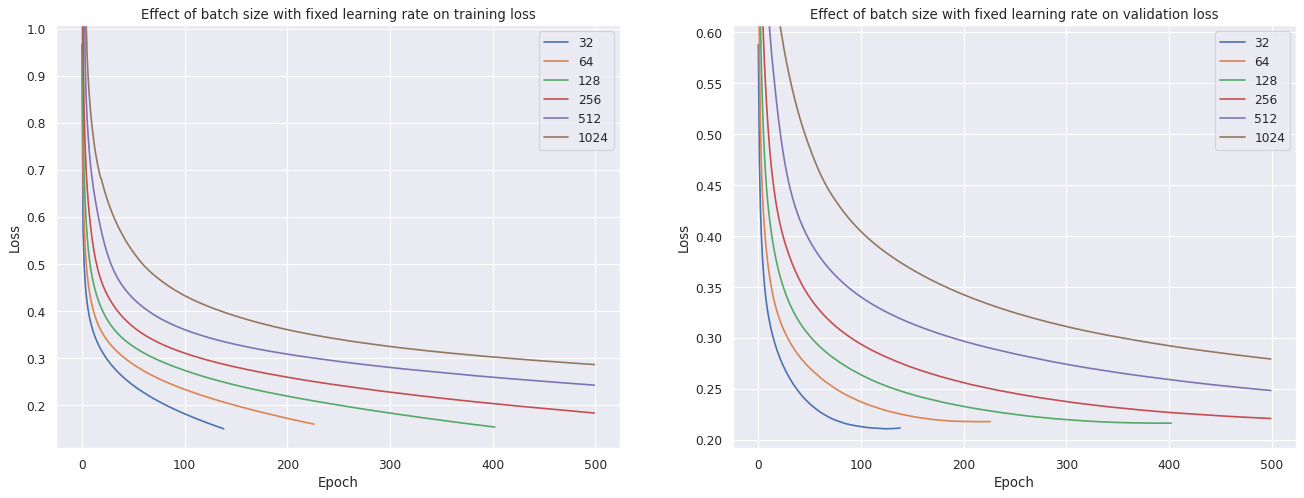

In [19]:
visualization.plot_loss_by_param(models_states[key], 'batch size with fixed learning rate', 'fixed_lr_diff_bs_SGD_SAM')

#### Sharpness

In [20]:
if RETRAIN_FLAG:
    for batch_size in batch_sizes:
        model = models[key + (batch_size,)]

        sharpness_bs = visualization.get_sharpness(model.base_model, train)
        sharpnesses[key + (batch_size,)] = sharpness_bs

        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG:
    sharpnesses = ml_utils.load_sharpnesses_dict()

2022-02-25 21:54:15.831506: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 18ms/step - loss: 0.1277 - accuracy: 0.9608
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.27660D-01    |proj g|=  2.07596D-02
47/47 [==============================] - 1s 13ms/step - loss: 2.3329 - accuracy: 0.6436

At iterate    1    f= -2.33290D+00    |proj g|=  3.88147D-02
  ys=-1.610E+02  -gs= 7.786E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 13ms/step - loss: 12.6495 - accuracy: 0.3877

At iterate    2    f= -1.26495D+01    |proj g|=  4.15192D-02
  ys=-7.720E+02  -gs= 1.544E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 13ms/step - loss: 15.0454 - accuracy: 0.3876

At iterate    3    f= -1.50454D+01    |proj g|=  3.63050D-02
  ys=-5.762E+01  -gs= 8.656E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 13ms/step - loss: 15.1589 - acc


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 14ms/step - loss: 15.1952 - accuracy: 0.3877

At iterate    5    f= -1.51952D+01    |proj g|=  3.66086D-02
47/47 [==============================] - 1s 14ms/step - loss: 15.2087 - accuracy: 0.3876

At iterate    6    f= -1.52087D+01    |proj g|=  3.61480D-02
47/47 [==============================] - 1s 14ms/step - loss: 15.2274 - accuracy: 0.3876

At iterate    7    f= -1.52274D+01    |proj g|=  3.53660D-02
47/47 [==============================] - 1s 13ms/step - loss: 15.2316 - accuracy: 0.3876

At iterate    8    f= -1.52316D+01    |proj g|=  3.60941D-02
47/47 [==============================] - 1s 13ms/step - loss: 15.2504 - accuracy: 0.3877

At iterate    9    f= -1.52504D+01    |proj g|=  3.15405D-02
47/47 [==============================] - 1s 11ms/step - loss: 15.2542 - accuracy: 0.3877

At iterate   10    f= -1.52542D+01    |proj g|=  3.14732D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluat

2022-02-25 21:54:43.310984: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 16ms/step - loss: 0.1406 - accuracy: 0.9546
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.40623D-01    |proj g|=  2.04455D-02
47/47 [==============================] - 1s 13ms/step - loss: 2.4485 - accuracy: 0.6146

At iterate    1    f= -2.44847D+00    |proj g|=  3.97879D-02
  ys=-1.787E+02  -gs= 1.022E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 13ms/step - loss: 14.0396 - accuracy: 0.2977

At iterate    2    f= -1.40396D+01    |proj g|=  3.97879D-02
  ys=-8.385E+02  -gs= 1.619E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 13ms/step - loss: 19.4148 - accuracy: 0.2920

At iterate    3    f= -1.94148D+01    |proj g|=  3.36139D-02
  ys=-1.570E+02  -gs= 1.766E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 14ms/step - loss: 20.3216 - acc


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 12ms/step - loss: 20.7253 - accuracy: 0.2932

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      8     10  65374     6 56852   3.833D-02  -2.072D+01
  F =  -20.722795486450195     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
2022-02-25 21:55:06.061293: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 17ms/step - loss: 0.1345 - accuracy: 0.9574
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.34536D-01    |proj g|=  2.35295D-02
47/47 [==============================] - 1s 13ms/step - loss: 4.0138 - accuracy: 0.5732

At iterate    1    f= -4.01384D+00    |proj g|=  3.55827D-02
  ys=-2.593E+02  -gs= 8.020E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 14ms/step - loss: 25.2910 - accuracy: 0.3620

At iterate    2    f= -2.52910D+01    |proj g|=  3.61248D-02
  ys=-1.514E+03  -gs= 3.090E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 29.1255 - accuracy: 0.3061

At iterate    3    f= -2.91255D+01    |proj g|=  3.40868D-02
  ys=-1.511E+02  -gs= 1.083E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 13ms/step - loss: 35.0012 - acc


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 11ms/step - loss: 35.3157 - accuracy: 0.2912

At iterate    7    f= -3.53157D+01    |proj g|=  2.48272D-02
13/47 [=======>......................] - ETA: 0s - loss: 35.4584 - accuracy: 0.2897


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 12ms/step - loss: 35.3173 - accuracy: 0.2911

At iterate    8    f= -3.53173D+01    |proj g|=  2.55507D-02
11/47 [======>.......................] - ETA: 0s - loss: 35.5974 - accuracy: 0.2884


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 13ms/step - loss: 35.3500 - accuracy: 0.2910

At iterate    9    f= -3.53500D+01    |proj g|=  2.76091D-02
13/47 [=======>......................] - ETA: 0s - loss: 35.6098 - accuracy: 0.2891


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 13ms/step - loss: 35.4644 - accuracy: 0.2907

At iterate   10    f= -3.54644D+01    |proj g|=  2.67695D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786     10     15  67103     5 57578   2.677D-02  -3.546D+01
  F =  -35.464420318603516     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


2022-02-25 21:55:40.880949: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 15ms/step - loss: 0.1657 - accuracy: 0.9442
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.65732D-01    |proj g|=  2.15257D-02
47/47 [==============================] - 1s 13ms/step - loss: 4.0812 - accuracy: 0.5534

At iterate    1    f= -4.08122D+00    |proj g|=  3.39859D-02
  ys=-2.731E+02  -gs= 1.035E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 30.1553 - accuracy: 0.2848

At iterate    2    f= -3.01553D+01    |proj g|=  3.48353D-02
  ys=-1.973E+03  -gs= 3.364E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 14ms/step - loss: 38.2564 - accuracy: 0.2825

At iterate    3    f= -3.82564D+01    |proj g|=  3.64634D-02
  ys=-2.617E+02  -gs= 2.522E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 10ms/step - loss: 39.0548 - acc


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
2022-02-25 21:55:58.374664: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 14ms/step - loss: 0.2258 - accuracy: 0.9219
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.25800D-01    |proj g|=  1.67181D-02
47/47 [==============================] - 1s 13ms/step - loss: 2.1305 - accuracy: 0.6556

At iterate    1    f= -2.13045D+00    |proj g|=  3.34362D-02
  ys=-1.192E+02  -gs= 6.474E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 13ms/step - loss: 19.4425 - accuracy: 0.3113

At iterate    2    f= -1.94425D+01    |proj g|=  3.21637D-02
  ys=-1.430E+03  -gs= 1.864E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 35.7805 - accuracy: 0.2788

At iterate    3    f= -3.57805D+01    |proj g|=  3.13764D-02
  ys=-6.014E+02  -gs= 4.770E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 13ms/step - loss: 37.4315 - acc

2022-02-25 21:56:24.092645: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 15ms/step - loss: 0.2701 - accuracy: 0.9060
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.70070D-01    |proj g|=  1.57825D-02
47/47 [==============================] - 1s 14ms/step - loss: 1.1930 - accuracy: 0.6898

At iterate    1    f= -1.19302D+00    |proj g|=  3.06195D-02
  ys=-2.937E+01  -gs= 2.973E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 14ms/step - loss: 13.2289 - accuracy: 0.4131

At iterate    2    f= -1.32289D+01    |proj g|=  3.15651D-02
  ys=-1.051E+03  -gs= 1.187E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 13ms/step - loss: 29.4491 - accuracy: 0.3736

At iterate    3    f= -2.94491D+01    |proj g|=  2.68453D-02
  ys=-7.482E+02  -gs= 4.052E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 13ms/step - loss: 33.8288 - acc

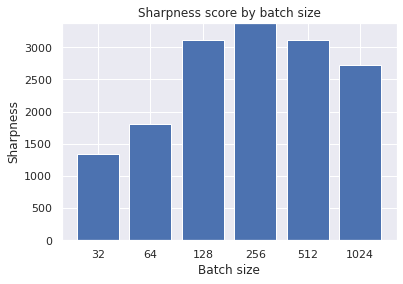

In [21]:
visualization.plot_sharpness(batch_sizes, sharpnesses, key)

#### Distance from initial weights

Batch size: 32, distance: 0.0
Batch size: 64, distance: 0.0
Batch size: 128, distance: 0.0
Batch size: 256, distance: 0.0
Batch size: 512, distance: 0.0
Batch size: 1024, distance: 0.0


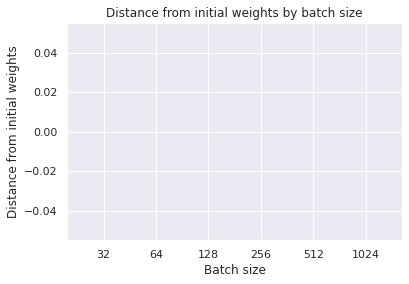

In [22]:
visualization.plot_distance_from_initial_weight(models, initial_weights, batch_sizes, key)

#### Runtime

In [23]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states,
                                                                                                     batch_sizes, key)

Batch size:  32
	Mean time per epoch:  8.731073619650422
	Converged in 128 epochs
	Overall training time (in seconds) until convergence:  1141.1643199920654
Batch size:  64
	Mean time per epoch:  4.099577314528075
	Converged in 216 epochs
	Overall training time (in seconds) until convergence:  885.3844795227051
Batch size:  128
	Mean time per epoch:  3.5105028797320044
	Converged in 392 epochs
	Overall training time (in seconds) until convergence:  1375.6473212242126
Batch size:  256
	Mean time per epoch:  2.8116308779716492
	Converged in 499 epochs
	Overall training time (in seconds) until convergence:  1403.1882269382477
Batch size:  512
	Mean time per epoch:  2.3745689191818236
	Converged in 499 epochs
	Overall training time (in seconds) until convergence:  1185.0550265312195
Batch size:  1024
	Mean time per epoch:  2.138506525993347
	Converged in 499 epochs
	Overall training time (in seconds) until convergence:  1067.0209746360779


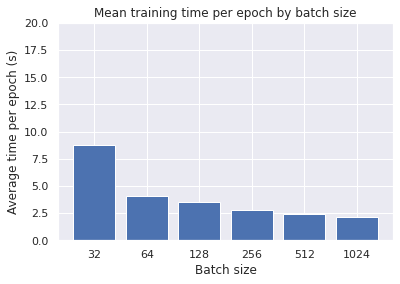

In [24]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

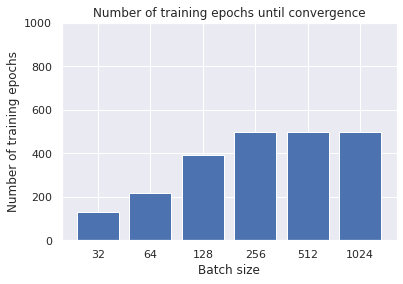

In [25]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

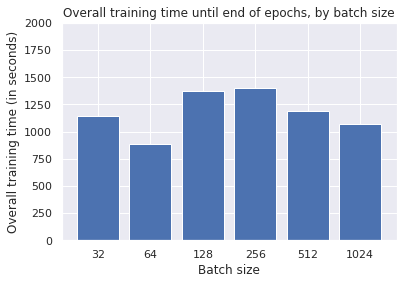

In [26]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

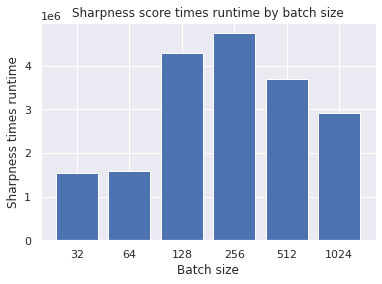

In [27]:
visualization.plot_sharpness_times_runtime(batch_sizes, overall_training_times, sharpnesses, key)

### SGD with Momentum + ASAM

In [28]:
models_dict_fixed_sgd_asam = {}
batch_sizes = [32, 64, 128, 256, 512, 1024]
#batch_sizes = [32]
lr = 0.001
training_epochs = EPOCHS

key = ('fixed', 'sgd', 'asam')

In [29]:
models_by_batch_size_fixed_lr_sgd_asam = {}

In [30]:
if not RETRAIN_FLAG:
    for batch_size in batch_sizes:
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                          batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        model = build_and_load_sam_model_weights(train, optimizer, filename_bs_opt_sam(batch_size, "SGD-MOM", "ASAM"))
        models_by_batch_size_fixed_lr_sgd_asam[batch_size] = model
        models[key + (batch_size,)] = model

In [31]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size in batch_sizes:
        with tf.distribute.MirroredStrategy().scope():
            # Read training data
            train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                              batch_size=batch_size,
                                                                              img_size=32)

            optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
            model = tf_models.build_simple_cnn_sam(train, optimizer, adaptive=True, rho=2.0)
            train_callbacks = callback_for_filename(filename_bs_opt_sam(batch_size, "SGD-MOM", "ASAM"))

            models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                  extra_callbacks=train_callbacks, verbose=1)
            models[key + (batch_size,)] = model
            initial_weights[key + (batch_size,)] = model.get_weights()
            ml_utils.save_initial_weights_dict(initial_weights)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 21:56:51.073429: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
1498/1500 [============================>.] - ETA: 0s - loss: 0.9975 - accuracy: 0.6187

2022-02-25 21:56:57.439251: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.56744, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 7s 4ms/step - loss: 0.9971 - accuracy: 0.6187 - val_loss: 0.5674 - val_accuracy: 0.7978
Epoch 2/500
1493/1500 [============================>.] - ETA: 0s - loss: 0.5908 - accuracy: 0.7628
Epoch 2: val_loss improved from 0.56744 to 0.46930, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 9s 6ms/step - loss: 0.5905 - accuracy: 0.7629 - val_loss: 0.4693 - val_accuracy: 0.8332
Epoch 3/500
1494/1500 [============================>.] - ETA: 0s - loss: 0.5240 - accuracy: 0.7883
Epoch 3: val_loss improved from 0.46930 to 0.42535, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 11s 7ms/step - loss: 0.5238 - accuracy: 0.7884 - val_loss: 0.4254 - val_accuracy: 0.8514
Epoch 4/500
1493/1500 [================

1500/1500 [==============================] - 9s 6ms/step - loss: 0.3519 - accuracy: 0.8521 - val_loss: 0.2878 - val_accuracy: 0.9002
Epoch 25/500
1494/1500 [============================>.] - ETA: 0s - loss: 0.3495 - accuracy: 0.8532
Epoch 25: val_loss improved from 0.28784 to 0.28574, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 9s 6ms/step - loss: 0.3494 - accuracy: 0.8533 - val_loss: 0.2857 - val_accuracy: 0.9012
Epoch 26/500
1496/1500 [============================>.] - ETA: 0s - loss: 0.3472 - accuracy: 0.8539
Epoch 26: val_loss improved from 0.28574 to 0.28370, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 9s 6ms/step - loss: 0.3471 - accuracy: 0.8539 - val_loss: 0.2837 - val_accuracy: 0.9016
Epoch 27/500
1496/1500 [============================>.] - ETA: 0s - loss: 0.3450 - accuracy: 0.8545
Epoch 27: val_loss improved from 0.28370 to 0.28172, sa

1500/1500 [==============================] - 10s 6ms/step - loss: 0.3133 - accuracy: 0.8654 - val_loss: 0.2561 - val_accuracy: 0.9113
Epoch 48/500
1500/1500 [==============================] - ETA: 0s - loss: 0.3121 - accuracy: 0.8654
Epoch 48: val_loss improved from 0.25609 to 0.25508, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 9s 6ms/step - loss: 0.3121 - accuracy: 0.8654 - val_loss: 0.2551 - val_accuracy: 0.9113
Epoch 49/500
1496/1500 [============================>.] - ETA: 0s - loss: 0.3110 - accuracy: 0.8662
Epoch 49: val_loss improved from 0.25508 to 0.25409, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 10s 7ms/step - loss: 0.3109 - accuracy: 0.8662 - val_loss: 0.2541 - val_accuracy: 0.9118
Epoch 50/500
1495/1500 [============================>.] - ETA: 0s - loss: 0.3099 - accuracy: 0.8668
Epoch 50: val_loss improved from 0.25409 to 0.25336, 

1500/1500 [==============================] - 9s 6ms/step - loss: 0.2919 - accuracy: 0.8724 - val_loss: 0.2409 - val_accuracy: 0.9157
Epoch 71/500
1494/1500 [============================>.] - ETA: 0s - loss: 0.2912 - accuracy: 0.8728
Epoch 71: val_loss improved from 0.24089 to 0.24036, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 10s 6ms/step - loss: 0.2911 - accuracy: 0.8727 - val_loss: 0.2404 - val_accuracy: 0.9158
Epoch 72/500
1497/1500 [============================>.] - ETA: 0s - loss: 0.2904 - accuracy: 0.8733
Epoch 72: val_loss improved from 0.24036 to 0.23999, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2904 - accuracy: 0.8732 - val_loss: 0.2400 - val_accuracy: 0.9160
Epoch 73/500
1493/1500 [============================>.] - ETA: 0s - loss: 0.2898 - accuracy: 0.8736
Epoch 73: val_loss improved from 0.23999 to 0.23952, s

Epoch 94/500
1500/1500 [==============================] - ETA: 0s - loss: 0.2770 - accuracy: 0.8780
Epoch 94: val_loss improved from 0.23179 to 0.23144, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 8s 6ms/step - loss: 0.2770 - accuracy: 0.8780 - val_loss: 0.2314 - val_accuracy: 0.9172
Epoch 95/500
1499/1500 [============================>.] - ETA: 0s - loss: 0.2763 - accuracy: 0.8779
Epoch 95: val_loss improved from 0.23144 to 0.23099, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2764 - accuracy: 0.8779 - val_loss: 0.2310 - val_accuracy: 0.9172
Epoch 96/500
1495/1500 [============================>.] - ETA: 0s - loss: 0.2760 - accuracy: 0.8781
Epoch 96: val_loss improved from 0.23099 to 0.23080, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 8s 5ms/step - loss: 

Epoch 117/500
1494/1500 [============================>.] - ETA: 0s - loss: 0.2664 - accuracy: 0.8812
Epoch 117: val_loss improved from 0.22586 to 0.22581, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2663 - accuracy: 0.8813 - val_loss: 0.2258 - val_accuracy: 0.9184
Epoch 118/500
1495/1500 [============================>.] - ETA: 0s - loss: 0.2660 - accuracy: 0.8810
Epoch 118: val_loss improved from 0.22581 to 0.22562, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2660 - accuracy: 0.8810 - val_loss: 0.2256 - val_accuracy: 0.9187
Epoch 119/500
1499/1500 [============================>.] - ETA: 0s - loss: 0.2656 - accuracy: 0.8815
Epoch 119: val_loss improved from 0.22562 to 0.22530, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 8s 5ms/step - 

1500/1500 [==============================] - 7s 5ms/step - loss: 0.2583 - accuracy: 0.8834 - val_loss: 0.2219 - val_accuracy: 0.9193
Epoch 141/500
1492/1500 [============================>.] - ETA: 0s - loss: 0.2581 - accuracy: 0.8835
Epoch 141: val_loss improved from 0.22186 to 0.22158, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2580 - accuracy: 0.8835 - val_loss: 0.2216 - val_accuracy: 0.9191
Epoch 142/500
1493/1500 [============================>.] - ETA: 0s - loss: 0.2578 - accuracy: 0.8841
Epoch 142: val_loss improved from 0.22158 to 0.22144, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2577 - accuracy: 0.8842 - val_loss: 0.2214 - val_accuracy: 0.9193
Epoch 143/500
1500/1500 [==============================] - ETA: 0s - loss: 0.2570 - accuracy: 0.8839
Epoch 143: val_loss improved from 0.22144 to 0.221

Epoch 165/500
1497/1500 [============================>.] - ETA: 0s - loss: 0.2508 - accuracy: 0.8861
Epoch 165: val_loss improved from 0.21892 to 0.21874, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2508 - accuracy: 0.8861 - val_loss: 0.2187 - val_accuracy: 0.9194
Epoch 166/500
1497/1500 [============================>.] - ETA: 0s - loss: 0.2506 - accuracy: 0.8862
Epoch 166: val_loss did not improve from 0.21874
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2506 - accuracy: 0.8862 - val_loss: 0.2188 - val_accuracy: 0.9189
Epoch 167/500
1492/1500 [============================>.] - ETA: 0s - loss: 0.2498 - accuracy: 0.8862
Epoch 167: val_loss improved from 0.21874 to 0.21856, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2497 - accuracy: 0.8863 - val_loss: 0.2186 - val_accuracy: 0.9193
E

1494/1500 [============================>.] - ETA: 0s - loss: 0.2446 - accuracy: 0.8878
Epoch 190: val_loss improved from 0.21663 to 0.21658, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2445 - accuracy: 0.8878 - val_loss: 0.2166 - val_accuracy: 0.9208
Epoch 191/500
1498/1500 [============================>.] - ETA: 0s - loss: 0.2443 - accuracy: 0.8883
Epoch 191: val_loss did not improve from 0.21658
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2444 - accuracy: 0.8883 - val_loss: 0.2167 - val_accuracy: 0.9208
Epoch 192/500
1491/1500 [============================>.] - ETA: 0s - loss: 0.2441 - accuracy: 0.8880
Epoch 192: val_loss did not improve from 0.21658
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2440 - accuracy: 0.8881 - val_loss: 0.2166 - val_accuracy: 0.9208
Epoch 193/500
1489/1500 [============================>.] - ETA: 0s - loss: 0.2439 - accura

1490/1500 [============================>.] - ETA: 0s - loss: 0.2390 - accuracy: 0.8905
Epoch 216: val_loss did not improve from 0.21482
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2388 - accuracy: 0.8907 - val_loss: 0.2150 - val_accuracy: 0.9211
Epoch 217/500
1500/1500 [==============================] - ETA: 0s - loss: 0.2390 - accuracy: 0.8905
Epoch 217: val_loss did not improve from 0.21482
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2390 - accuracy: 0.8905 - val_loss: 0.2153 - val_accuracy: 0.9216
Epoch 218/500
1490/1500 [============================>.] - ETA: 0s - loss: 0.2391 - accuracy: 0.8901
Epoch 218: val_loss did not improve from 0.21482
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2388 - accuracy: 0.8903 - val_loss: 0.2149 - val_accuracy: 0.9215
Epoch 219/500
1498/1500 [============================>.] - ETA: 0s - loss: 0.2383 - accuracy: 0.8907
Epoch 219: val_loss did not improve from 0.21482
1500/1500 [====

1490/1500 [============================>.] - ETA: 0s - loss: 0.2347 - accuracy: 0.8917
Epoch 242: val_loss did not improve from 0.21356
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2344 - accuracy: 0.8918 - val_loss: 0.2139 - val_accuracy: 0.9216
Epoch 243/500
1497/1500 [============================>.] - ETA: 0s - loss: 0.2348 - accuracy: 0.8909
Epoch 243: val_loss did not improve from 0.21356
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2348 - accuracy: 0.8909 - val_loss: 0.2139 - val_accuracy: 0.9216
Epoch 244/500
1495/1500 [============================>.] - ETA: 0s - loss: 0.2336 - accuracy: 0.8921
Epoch 244: val_loss did not improve from 0.21356
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2336 - accuracy: 0.8921 - val_loss: 0.2139 - val_accuracy: 0.9217
Epoch 245/500
1487/1500 [============================>.] - ETA: 0s - loss: 0.2339 - accuracy: 0.8916
Epoch 245: val_loss did not improve from 0.21356
1500/1500 [====

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 22:30:30.882211: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
749/750 [============================>.] - ETA: 0s - loss: 1.2836 - accuracy: 0.5288

2022-02-25 22:30:35.242367: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.69672, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 6s 7ms/step - loss: 1.2829 - accuracy: 0.5290 - val_loss: 0.6967 - val_accuracy: 0.7598
Epoch 2/500
744/750 [============================>.] - ETA: 0s - loss: 0.7157 - accuracy: 0.7152
Epoch 2: val_loss improved from 0.69672 to 0.56855, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 6ms/step - loss: 0.7148 - accuracy: 0.7156 - val_loss: 0.5686 - val_accuracy: 0.7985
Epoch 3/500
747/750 [============================>.] - ETA: 0s - loss: 0.6073 - accuracy: 0.7574
Epoch 3: val_loss improved from 0.56855 to 0.49927, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.6070 - accuracy: 0.7575 - val_loss: 0.4993 - val_accuracy: 0.8227
Epoch 4/500
746/750 [============================>

750/750 [==============================] - 4s 6ms/step - loss: 0.3783 - accuracy: 0.8473 - val_loss: 0.3206 - val_accuracy: 0.8883
Epoch 25/500
745/750 [============================>.] - ETA: 0s - loss: 0.3759 - accuracy: 0.8484
Epoch 25: val_loss improved from 0.32059 to 0.31814, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 6ms/step - loss: 0.3755 - accuracy: 0.8485 - val_loss: 0.3181 - val_accuracy: 0.8895
Epoch 26/500
746/750 [============================>.] - ETA: 0s - loss: 0.3731 - accuracy: 0.8494
Epoch 26: val_loss improved from 0.31814 to 0.31593, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 6ms/step - loss: 0.3728 - accuracy: 0.8494 - val_loss: 0.3159 - val_accuracy: 0.8900
Epoch 27/500
745/750 [============================>.] - ETA: 0s - loss: 0.3707 - accuracy: 0.8501
Epoch 27: val_loss improved from 0.31593 to 0.31369, saving model t

Epoch 48/500
742/750 [============================>.] - ETA: 0s - loss: 0.3335 - accuracy: 0.8638
Epoch 48: val_loss improved from 0.28378 to 0.28263, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 6ms/step - loss: 0.3330 - accuracy: 0.8638 - val_loss: 0.2826 - val_accuracy: 0.9010
Epoch 49/500
748/750 [============================>.] - ETA: 0s - loss: 0.3319 - accuracy: 0.8641
Epoch 49: val_loss improved from 0.28263 to 0.28158, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 6ms/step - loss: 0.3317 - accuracy: 0.8641 - val_loss: 0.2816 - val_accuracy: 0.9011
Epoch 50/500
747/750 [============================>.] - ETA: 0s - loss: 0.3306 - accuracy: 0.8644
Epoch 50: val_loss improved from 0.28158 to 0.28053, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 6ms/step - loss: 0.3305 - acc

750/750 [==============================] - ETA: 0s - loss: 0.3088 - accuracy: 0.8715
Epoch 71: val_loss improved from 0.26410 to 0.26338, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.3088 - accuracy: 0.8715 - val_loss: 0.2634 - val_accuracy: 0.9071
Epoch 72/500
746/750 [============================>.] - ETA: 0s - loss: 0.3082 - accuracy: 0.8719
Epoch 72: val_loss improved from 0.26338 to 0.26272, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 6ms/step - loss: 0.3079 - accuracy: 0.8719 - val_loss: 0.2627 - val_accuracy: 0.9072
Epoch 73/500
745/750 [============================>.] - ETA: 0s - loss: 0.3074 - accuracy: 0.8721
Epoch 73: val_loss improved from 0.26272 to 0.26205, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 6ms/step - loss: 0.3070 - accuracy: 0.8722

750/750 [==============================] - 4s 5ms/step - loss: 0.2918 - accuracy: 0.8768 - val_loss: 0.2507 - val_accuracy: 0.9116
Epoch 95/500
750/750 [==============================] - ETA: 0s - loss: 0.2912 - accuracy: 0.8772
Epoch 95: val_loss improved from 0.25072 to 0.25029, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 6ms/step - loss: 0.2912 - accuracy: 0.8772 - val_loss: 0.2503 - val_accuracy: 0.9118
Epoch 96/500
743/750 [============================>.] - ETA: 0s - loss: 0.2911 - accuracy: 0.8770
Epoch 96: val_loss improved from 0.25029 to 0.24988, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 6ms/step - loss: 0.2906 - accuracy: 0.8771 - val_loss: 0.2499 - val_accuracy: 0.9122
Epoch 97/500
748/750 [============================>.] - ETA: 0s - loss: 0.2901 - accuracy: 0.8776
Epoch 97: val_loss improved from 0.24988 to 0.24939, saving model t

Epoch 118/500
746/750 [============================>.] - ETA: 0s - loss: 0.2785 - accuracy: 0.8820
Epoch 118: val_loss improved from 0.24210 to 0.24174, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.2783 - accuracy: 0.8820 - val_loss: 0.2417 - val_accuracy: 0.9140
Epoch 119/500
749/750 [============================>.] - ETA: 0s - loss: 0.2777 - accuracy: 0.8820
Epoch 119: val_loss improved from 0.24174 to 0.24135, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.2778 - accuracy: 0.8819 - val_loss: 0.2414 - val_accuracy: 0.9137
Epoch 120/500
749/750 [============================>.] - ETA: 0s - loss: 0.2773 - accuracy: 0.8823
Epoch 120: val_loss improved from 0.24135 to 0.24104, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.2773

749/750 [============================>.] - ETA: 0s - loss: 0.2679 - accuracy: 0.8856
Epoch 141: val_loss improved from 0.23549 to 0.23527, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 6ms/step - loss: 0.2680 - accuracy: 0.8856 - val_loss: 0.2353 - val_accuracy: 0.9159
Epoch 142/500
745/750 [============================>.] - ETA: 0s - loss: 0.2679 - accuracy: 0.8851
Epoch 142: val_loss improved from 0.23527 to 0.23505, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 6ms/step - loss: 0.2675 - accuracy: 0.8853 - val_loss: 0.2350 - val_accuracy: 0.9166
Epoch 143/500
747/750 [============================>.] - ETA: 0s - loss: 0.2674 - accuracy: 0.8856
Epoch 143: val_loss improved from 0.23505 to 0.23475, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 6ms/step - loss: 0.2673 - accuracy: 0

746/750 [============================>.] - ETA: 0s - loss: 0.2594 - accuracy: 0.8887
Epoch 164: val_loss improved from 0.23067 to 0.23052, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 6ms/step - loss: 0.2592 - accuracy: 0.8888 - val_loss: 0.2305 - val_accuracy: 0.9172
Epoch 165/500
749/750 [============================>.] - ETA: 0s - loss: 0.2587 - accuracy: 0.8892
Epoch 165: val_loss improved from 0.23052 to 0.23014, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.2588 - accuracy: 0.8892 - val_loss: 0.2301 - val_accuracy: 0.9168
Epoch 166/500
743/750 [============================>.] - ETA: 0s - loss: 0.2588 - accuracy: 0.8889
Epoch 166: val_loss improved from 0.23014 to 0.22999, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 6ms/step - loss: 0.2584 - accuracy: 0

740/750 [============================>.] - ETA: 0s - loss: 0.2521 - accuracy: 0.8911
Epoch 187: val_loss improved from 0.22653 to 0.22631, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.2516 - accuracy: 0.8913 - val_loss: 0.2263 - val_accuracy: 0.9188
Epoch 188/500
744/750 [============================>.] - ETA: 0s - loss: 0.2517 - accuracy: 0.8912
Epoch 188: val_loss improved from 0.22631 to 0.22611, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 6ms/step - loss: 0.2513 - accuracy: 0.8915 - val_loss: 0.2261 - val_accuracy: 0.9191
Epoch 189/500
747/750 [============================>.] - ETA: 0s - loss: 0.2511 - accuracy: 0.8917
Epoch 189: val_loss improved from 0.22611 to 0.22594, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 6ms/step - loss: 0.2511 - accuracy: 0

744/750 [============================>.] - ETA: 0s - loss: 0.2453 - accuracy: 0.8937
Epoch 210: val_loss improved from 0.22300 to 0.22285, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.2449 - accuracy: 0.8939 - val_loss: 0.2229 - val_accuracy: 0.9204
Epoch 211/500
744/750 [============================>.] - ETA: 0s - loss: 0.2450 - accuracy: 0.8937
Epoch 211: val_loss improved from 0.22285 to 0.22268, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.2447 - accuracy: 0.8939 - val_loss: 0.2227 - val_accuracy: 0.9204
Epoch 212/500
749/750 [============================>.] - ETA: 0s - loss: 0.2444 - accuracy: 0.8947
Epoch 212: val_loss improved from 0.22268 to 0.22251, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.2445 - accuracy: 0

744/750 [============================>.] - ETA: 0s - loss: 0.2393 - accuracy: 0.8961
Epoch 233: val_loss improved from 0.22039 to 0.22033, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 6ms/step - loss: 0.2390 - accuracy: 0.8964 - val_loss: 0.2203 - val_accuracy: 0.9212
Epoch 234/500
742/750 [============================>.] - ETA: 0s - loss: 0.2390 - accuracy: 0.8962
Epoch 234: val_loss improved from 0.22033 to 0.22018, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.2386 - accuracy: 0.8963 - val_loss: 0.2202 - val_accuracy: 0.9212
Epoch 235/500
747/750 [============================>.] - ETA: 0s - loss: 0.2386 - accuracy: 0.8967
Epoch 235: val_loss improved from 0.22018 to 0.22016, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.2385 - accuracy: 0

748/750 [============================>.] - ETA: 0s - loss: 0.2335 - accuracy: 0.8987
Epoch 257: val_loss improved from 0.21824 to 0.21815, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 6ms/step - loss: 0.2334 - accuracy: 0.8988 - val_loss: 0.2182 - val_accuracy: 0.9214
Epoch 258/500
750/750 [==============================] - ETA: 0s - loss: 0.2331 - accuracy: 0.8989
Epoch 258: val_loss did not improve from 0.21815
750/750 [==============================] - 4s 6ms/step - loss: 0.2331 - accuracy: 0.8989 - val_loss: 0.2182 - val_accuracy: 0.9220
Epoch 259/500
747/750 [============================>.] - ETA: 0s - loss: 0.2328 - accuracy: 0.8989
Epoch 259: val_loss improved from 0.21815 to 0.21809, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 6ms/step - loss: 0.2328 - accuracy: 0.8989 - val_loss: 0.2181 - val_accuracy: 0.9218
Epoch 260/500
750/750 [====

748/750 [============================>.] - ETA: 0s - loss: 0.2282 - accuracy: 0.9005
Epoch 281: val_loss improved from 0.21680 to 0.21660, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 6ms/step - loss: 0.2281 - accuracy: 0.9005 - val_loss: 0.2166 - val_accuracy: 0.9216
Epoch 282/500
750/750 [==============================] - ETA: 0s - loss: 0.2278 - accuracy: 0.9010
Epoch 282: val_loss did not improve from 0.21660
750/750 [==============================] - 4s 6ms/step - loss: 0.2278 - accuracy: 0.9010 - val_loss: 0.2167 - val_accuracy: 0.9211
Epoch 283/500
747/750 [============================>.] - ETA: 0s - loss: 0.2278 - accuracy: 0.9009
Epoch 283: val_loss improved from 0.21660 to 0.21646, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 6ms/step - loss: 0.2278 - accuracy: 0.9009 - val_loss: 0.2165 - val_accuracy: 0.9212
Epoch 284/500
744/750 [====

750/750 [==============================] - 4s 6ms/step - loss: 0.2232 - accuracy: 0.9022 - val_loss: 0.2153 - val_accuracy: 0.9222
Epoch 306/500
746/750 [============================>.] - ETA: 0s - loss: 0.2233 - accuracy: 0.9024
Epoch 306: val_loss did not improve from 0.21528
750/750 [==============================] - 4s 6ms/step - loss: 0.2232 - accuracy: 0.9024 - val_loss: 0.2154 - val_accuracy: 0.9223
Epoch 307/500
746/750 [============================>.] - ETA: 0s - loss: 0.2230 - accuracy: 0.9025
Epoch 307: val_loss improved from 0.21528 to 0.21527, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 6ms/step - loss: 0.2229 - accuracy: 0.9026 - val_loss: 0.2153 - val_accuracy: 0.9222
Epoch 308/500
743/750 [============================>.] - ETA: 0s - loss: 0.2229 - accuracy: 0.9030
Epoch 308: val_loss improved from 0.21527 to 0.21523, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [====

746/750 [============================>.] - ETA: 0s - loss: 0.2190 - accuracy: 0.9040
Epoch 330: val_loss did not improve from 0.21385
750/750 [==============================] - 4s 5ms/step - loss: 0.2188 - accuracy: 0.9040 - val_loss: 0.2139 - val_accuracy: 0.9222
Epoch 331/500
743/750 [============================>.] - ETA: 0s - loss: 0.2189 - accuracy: 0.9041
Epoch 331: val_loss did not improve from 0.21385
750/750 [==============================] - 4s 5ms/step - loss: 0.2185 - accuracy: 0.9043 - val_loss: 0.2139 - val_accuracy: 0.9225
Epoch 332/500
750/750 [==============================] - ETA: 0s - loss: 0.2184 - accuracy: 0.9043
Epoch 332: val_loss improved from 0.21385 to 0.21380, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 6ms/step - loss: 0.2184 - accuracy: 0.9043 - val_loss: 0.2138 - val_accuracy: 0.9227
Epoch 333/500
745/750 [============================>.] - ETA: 0s - loss: 0.2185 - accuracy: 0.9041
Epo

Epoch 356/500
747/750 [============================>.] - ETA: 0s - loss: 0.2139 - accuracy: 0.9059
Epoch 356: val_loss improved from 0.21296 to 0.21292, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 6ms/step - loss: 0.2139 - accuracy: 0.9059 - val_loss: 0.2129 - val_accuracy: 0.9218
Epoch 357/500
747/750 [============================>.] - ETA: 0s - loss: 0.2136 - accuracy: 0.9061
Epoch 357: val_loss did not improve from 0.21292
750/750 [==============================] - 4s 6ms/step - loss: 0.2136 - accuracy: 0.9060 - val_loss: 0.2130 - val_accuracy: 0.9220
Epoch 358/500
745/750 [============================>.] - ETA: 0s - loss: 0.2137 - accuracy: 0.9060
Epoch 358: val_loss improved from 0.21292 to 0.21278, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 6ms/step - loss: 0.2134 - accuracy: 0.9061 - val_loss: 0.2128 - val_accuracy: 0.9217
Epoch 359/500

745/750 [============================>.] - ETA: 0s - loss: 0.2102 - accuracy: 0.9074
Epoch 383: val_loss improved from 0.21234 to 0.21230, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 6ms/step - loss: 0.2100 - accuracy: 0.9075 - val_loss: 0.2123 - val_accuracy: 0.9223
Epoch 384/500
749/750 [============================>.] - ETA: 0s - loss: 0.2097 - accuracy: 0.9076
Epoch 384: val_loss did not improve from 0.21230
750/750 [==============================] - 4s 6ms/step - loss: 0.2098 - accuracy: 0.9075 - val_loss: 0.2124 - val_accuracy: 0.9222
Epoch 385/500
742/750 [============================>.] - ETA: 0s - loss: 0.2097 - accuracy: 0.9074
Epoch 385: val_loss did not improve from 0.21230
750/750 [==============================] - 4s 6ms/step - loss: 0.2094 - accuracy: 0.9075 - val_loss: 0.2123 - val_accuracy: 0.9223
Epoch 386/500
742/750 [============================>.] - ETA: 0s - loss: 0.2096 - accuracy: 0.9075
Epo

743/750 [============================>.] - ETA: 0s - loss: 0.2061 - accuracy: 0.9089
Epoch 410: val_loss did not improve from 0.21177
750/750 [==============================] - 4s 6ms/step - loss: 0.2058 - accuracy: 0.9091 - val_loss: 0.2120 - val_accuracy: 0.9227
Epoch 411/500
742/750 [============================>.] - ETA: 0s - loss: 0.2061 - accuracy: 0.9089
Epoch 411: val_loss did not improve from 0.21177
750/750 [==============================] - 4s 6ms/step - loss: 0.2058 - accuracy: 0.9090 - val_loss: 0.2121 - val_accuracy: 0.9230
Epoch 412/500
748/750 [============================>.] - ETA: 0s - loss: 0.2061 - accuracy: 0.9092
Epoch 412: val_loss did not improve from 0.21177
750/750 [==============================] - 4s 6ms/step - loss: 0.2060 - accuracy: 0.9092 - val_loss: 0.2119 - val_accuracy: 0.9228
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 22:59:46.995891: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
369/375 [============================>.] - ETA: 0s - loss: 1.5666 - accuracy: 0.4458

2022-02-25 22:59:51.632143: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.83520, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 6s 12ms/step - loss: 1.5560 - accuracy: 0.4492 - val_loss: 0.8352 - val_accuracy: 0.6990
Epoch 2/500
371/375 [============================>.] - ETA: 0s - loss: 0.8344 - accuracy: 0.6691
Epoch 2: val_loss improved from 0.83520 to 0.67689, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 9ms/step - loss: 0.8336 - accuracy: 0.6694 - val_loss: 0.6769 - val_accuracy: 0.7649
Epoch 3/500
373/375 [============================>.] - ETA: 0s - loss: 0.7255 - accuracy: 0.7129
Epoch 3: val_loss improved from 0.67689 to 0.61434, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 9ms/step - loss: 0.7251 - accuracy: 0.7132 - val_loss: 0.6143 - val_accuracy: 0.7867
Epoch 4/500
371/375 [=========================

375/375 [==============================] - 3s 9ms/step - loss: 0.4172 - accuracy: 0.8354 - val_loss: 0.3618 - val_accuracy: 0.8740
Epoch 25/500
372/375 [============================>.] - ETA: 0s - loss: 0.4141 - accuracy: 0.8367
Epoch 25: val_loss improved from 0.36184 to 0.35885, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.4136 - accuracy: 0.8369 - val_loss: 0.3588 - val_accuracy: 0.8755
Epoch 26/500
374/375 [============================>.] - ETA: 0s - loss: 0.4105 - accuracy: 0.8379
Epoch 26: val_loss improved from 0.35885 to 0.35600, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 9ms/step - loss: 0.4104 - accuracy: 0.8380 - val_loss: 0.3560 - val_accuracy: 0.8759
Epoch 27/500
375/375 [==============================] - ETA: 0s - loss: 0.4072 - accuracy: 0.8390
Epoch 27: val_loss improved from 0.35600 to 0.35337, saving model

Epoch 48/500
373/375 [============================>.] - ETA: 0s - loss: 0.3637 - accuracy: 0.8550
Epoch 48: val_loss improved from 0.31807 to 0.31686, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 9ms/step - loss: 0.3634 - accuracy: 0.8551 - val_loss: 0.3169 - val_accuracy: 0.8883
Epoch 49/500
375/375 [==============================] - ETA: 0s - loss: 0.3621 - accuracy: 0.8556
Epoch 49: val_loss improved from 0.31686 to 0.31565, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 9ms/step - loss: 0.3621 - accuracy: 0.8556 - val_loss: 0.3157 - val_accuracy: 0.8892
Epoch 50/500
374/375 [============================>.] - ETA: 0s - loss: 0.3609 - accuracy: 0.8563
Epoch 50: val_loss improved from 0.31565 to 0.31452, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 9ms/step - loss: 0.3607 - 

375/375 [==============================] - ETA: 0s - loss: 0.3375 - accuracy: 0.8641
Epoch 71: val_loss improved from 0.29625 to 0.29549, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.3375 - accuracy: 0.8641 - val_loss: 0.2955 - val_accuracy: 0.8972
Epoch 72/500
370/375 [============================>.] - ETA: 0s - loss: 0.3372 - accuracy: 0.8643
Epoch 72: val_loss improved from 0.29549 to 0.29479, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.3366 - accuracy: 0.8645 - val_loss: 0.2948 - val_accuracy: 0.8975
Epoch 73/500
375/375 [==============================] - ETA: 0s - loss: 0.3357 - accuracy: 0.8647
Epoch 73: val_loss improved from 0.29479 to 0.29405, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 9ms/step - loss: 0.3357 - accuracy: 0.8

375/375 [==============================] - ETA: 0s - loss: 0.3191 - accuracy: 0.8710
Epoch 94: val_loss improved from 0.28131 to 0.28071, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.3191 - accuracy: 0.8710 - val_loss: 0.2807 - val_accuracy: 0.9013
Epoch 95/500
372/375 [============================>.] - ETA: 0s - loss: 0.3189 - accuracy: 0.8708
Epoch 95: val_loss improved from 0.28071 to 0.28015, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 9ms/step - loss: 0.3184 - accuracy: 0.8711 - val_loss: 0.2802 - val_accuracy: 0.9020
Epoch 96/500
372/375 [============================>.] - ETA: 0s - loss: 0.3183 - accuracy: 0.8711
Epoch 96: val_loss improved from 0.28015 to 0.27959, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.3177 - accuracy: 0.8

369/375 [============================>.] - ETA: 0s - loss: 0.3052 - accuracy: 0.8757
Epoch 117: val_loss improved from 0.26972 to 0.26927, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.3047 - accuracy: 0.8760 - val_loss: 0.2693 - val_accuracy: 0.9055
Epoch 118/500
374/375 [============================>.] - ETA: 0s - loss: 0.3042 - accuracy: 0.8762
Epoch 118: val_loss improved from 0.26927 to 0.26884, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.3041 - accuracy: 0.8763 - val_loss: 0.2688 - val_accuracy: 0.9054
Epoch 119/500
373/375 [============================>.] - ETA: 0s - loss: 0.3039 - accuracy: 0.8762
Epoch 119: val_loss improved from 0.26884 to 0.26844, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.3036 - accuracy

374/375 [============================>.] - ETA: 0s - loss: 0.2931 - accuracy: 0.8798
Epoch 140: val_loss improved from 0.26086 to 0.26050, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2930 - accuracy: 0.8799 - val_loss: 0.2605 - val_accuracy: 0.9090
Epoch 141/500
368/375 [============================>.] - ETA: 0s - loss: 0.2931 - accuracy: 0.8798
Epoch 141: val_loss improved from 0.26050 to 0.26018, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2926 - accuracy: 0.8799 - val_loss: 0.2602 - val_accuracy: 0.9093
Epoch 142/500
372/375 [============================>.] - ETA: 0s - loss: 0.2926 - accuracy: 0.8797
Epoch 142: val_loss improved from 0.26018 to 0.25990, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2921 - accuracy

370/375 [============================>.] - ETA: 0s - loss: 0.2837 - accuracy: 0.8829
Epoch 163: val_loss improved from 0.25363 to 0.25332, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2832 - accuracy: 0.8831 - val_loss: 0.2533 - val_accuracy: 0.9114
Epoch 164/500
373/375 [============================>.] - ETA: 0s - loss: 0.2830 - accuracy: 0.8830
Epoch 164: val_loss improved from 0.25332 to 0.25306, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2828 - accuracy: 0.8832 - val_loss: 0.2531 - val_accuracy: 0.9113
Epoch 165/500
371/375 [============================>.] - ETA: 0s - loss: 0.2829 - accuracy: 0.8829
Epoch 165: val_loss improved from 0.25306 to 0.25283, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2824 - accuracy

370/375 [============================>.] - ETA: 0s - loss: 0.2751 - accuracy: 0.8860
Epoch 186: val_loss improved from 0.24776 to 0.24752, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 9ms/step - loss: 0.2746 - accuracy: 0.8861 - val_loss: 0.2475 - val_accuracy: 0.9136
Epoch 187/500
371/375 [============================>.] - ETA: 0s - loss: 0.2748 - accuracy: 0.8864
Epoch 187: val_loss improved from 0.24752 to 0.24727, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 9ms/step - loss: 0.2743 - accuracy: 0.8865 - val_loss: 0.2473 - val_accuracy: 0.9134
Epoch 188/500
371/375 [============================>.] - ETA: 0s - loss: 0.2744 - accuracy: 0.8866
Epoch 188: val_loss improved from 0.24727 to 0.24709, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2739 - accuracy

374/375 [============================>.] - ETA: 0s - loss: 0.2675 - accuracy: 0.8893
Epoch 209: val_loss improved from 0.24292 to 0.24272, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2674 - accuracy: 0.8894 - val_loss: 0.2427 - val_accuracy: 0.9140
Epoch 210/500
369/375 [============================>.] - ETA: 0s - loss: 0.2676 - accuracy: 0.8890
Epoch 210: val_loss improved from 0.24272 to 0.24254, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2671 - accuracy: 0.8892 - val_loss: 0.2425 - val_accuracy: 0.9139
Epoch 211/500
369/375 [============================>.] - ETA: 0s - loss: 0.2673 - accuracy: 0.8894
Epoch 211: val_loss improved from 0.24254 to 0.24240, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2668 - accuracy

375/375 [==============================] - ETA: 0s - loss: 0.2610 - accuracy: 0.8918
Epoch 232: val_loss improved from 0.23904 to 0.23886, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2610 - accuracy: 0.8918 - val_loss: 0.2389 - val_accuracy: 0.9152
Epoch 233/500
374/375 [============================>.] - ETA: 0s - loss: 0.2609 - accuracy: 0.8917
Epoch 233: val_loss improved from 0.23886 to 0.23878, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 9ms/step - loss: 0.2608 - accuracy: 0.8918 - val_loss: 0.2388 - val_accuracy: 0.9154
Epoch 234/500
374/375 [============================>.] - ETA: 0s - loss: 0.2605 - accuracy: 0.8917
Epoch 234: val_loss improved from 0.23878 to 0.23853, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2604 - accuracy

369/375 [============================>.] - ETA: 0s - loss: 0.2554 - accuracy: 0.8935
Epoch 255: val_loss improved from 0.23569 to 0.23558, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2550 - accuracy: 0.8936 - val_loss: 0.2356 - val_accuracy: 0.9166
Epoch 256/500
370/375 [============================>.] - ETA: 0s - loss: 0.2554 - accuracy: 0.8937
Epoch 256: val_loss improved from 0.23558 to 0.23545, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2549 - accuracy: 0.8938 - val_loss: 0.2354 - val_accuracy: 0.9168
Epoch 257/500
373/375 [============================>.] - ETA: 0s - loss: 0.2548 - accuracy: 0.8938
Epoch 257: val_loss improved from 0.23545 to 0.23533, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2546 - accuracy

374/375 [============================>.] - ETA: 0s - loss: 0.2496 - accuracy: 0.8961
Epoch 278: val_loss improved from 0.23272 to 0.23263, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2495 - accuracy: 0.8962 - val_loss: 0.2326 - val_accuracy: 0.9172
Epoch 279/500
374/375 [============================>.] - ETA: 0s - loss: 0.2495 - accuracy: 0.8963
Epoch 279: val_loss improved from 0.23263 to 0.23248, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2494 - accuracy: 0.8963 - val_loss: 0.2325 - val_accuracy: 0.9174
Epoch 280/500
369/375 [============================>.] - ETA: 0s - loss: 0.2495 - accuracy: 0.8959
Epoch 280: val_loss improved from 0.23248 to 0.23235, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2491 - accuracy

373/375 [============================>.] - ETA: 0s - loss: 0.2448 - accuracy: 0.8973
Epoch 301: val_loss improved from 0.23006 to 0.22996, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2445 - accuracy: 0.8975 - val_loss: 0.2300 - val_accuracy: 0.9182
Epoch 302/500
373/375 [============================>.] - ETA: 0s - loss: 0.2446 - accuracy: 0.8974
Epoch 302: val_loss improved from 0.22996 to 0.22983, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2444 - accuracy: 0.8975 - val_loss: 0.2298 - val_accuracy: 0.9183
Epoch 303/500
373/375 [============================>.] - ETA: 0s - loss: 0.2444 - accuracy: 0.8975
Epoch 303: val_loss improved from 0.22983 to 0.22976, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2442 - accuracy

374/375 [============================>.] - ETA: 0s - loss: 0.2398 - accuracy: 0.8995
Epoch 324: val_loss improved from 0.22782 to 0.22775, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2397 - accuracy: 0.8996 - val_loss: 0.2277 - val_accuracy: 0.9187
Epoch 325/500
372/375 [============================>.] - ETA: 0s - loss: 0.2399 - accuracy: 0.8996
Epoch 325: val_loss improved from 0.22775 to 0.22770, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2395 - accuracy: 0.8997 - val_loss: 0.2277 - val_accuracy: 0.9187
Epoch 326/500
373/375 [============================>.] - ETA: 0s - loss: 0.2395 - accuracy: 0.8993
Epoch 326: val_loss improved from 0.22770 to 0.22759, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2393 - accuracy

374/375 [============================>.] - ETA: 0s - loss: 0.2352 - accuracy: 0.9012
Epoch 347: val_loss improved from 0.22583 to 0.22573, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2351 - accuracy: 0.9013 - val_loss: 0.2257 - val_accuracy: 0.9195
Epoch 348/500
375/375 [==============================] - ETA: 0s - loss: 0.2348 - accuracy: 0.9010
Epoch 348: val_loss improved from 0.22573 to 0.22562, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2348 - accuracy: 0.9010 - val_loss: 0.2256 - val_accuracy: 0.9197
Epoch 349/500
373/375 [============================>.] - ETA: 0s - loss: 0.2349 - accuracy: 0.9012
Epoch 349: val_loss improved from 0.22562 to 0.22549, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2347 - accuracy

Epoch 371/500
372/375 [============================>.] - ETA: 0s - loss: 0.2310 - accuracy: 0.9020
Epoch 371: val_loss improved from 0.22395 to 0.22385, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 9ms/step - loss: 0.2306 - accuracy: 0.9022 - val_loss: 0.2238 - val_accuracy: 0.9206
Epoch 372/500
374/375 [============================>.] - ETA: 0s - loss: 0.2305 - accuracy: 0.9024
Epoch 372: val_loss improved from 0.22385 to 0.22374, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2304 - accuracy: 0.9025 - val_loss: 0.2237 - val_accuracy: 0.9208
Epoch 373/500
370/375 [============================>.] - ETA: 0s - loss: 0.2308 - accuracy: 0.9022
Epoch 373: val_loss improved from 0.22374 to 0.22371, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2

375/375 [==============================] - 3s 8ms/step - loss: 0.2266 - accuracy: 0.9036 - val_loss: 0.2223 - val_accuracy: 0.9216
Epoch 395/500
370/375 [============================>.] - ETA: 0s - loss: 0.2269 - accuracy: 0.9035
Epoch 395: val_loss improved from 0.22226 to 0.22221, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2264 - accuracy: 0.9036 - val_loss: 0.2222 - val_accuracy: 0.9216
Epoch 396/500
371/375 [============================>.] - ETA: 0s - loss: 0.2267 - accuracy: 0.9033
Epoch 396: val_loss improved from 0.22221 to 0.22219, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 9ms/step - loss: 0.2262 - accuracy: 0.9035 - val_loss: 0.2222 - val_accuracy: 0.9218
Epoch 397/500
374/375 [============================>.] - ETA: 0s - loss: 0.2262 - accuracy: 0.9036
Epoch 397: val_loss improved from 0.22219 to 0.22211, saving

375/375 [==============================] - 3s 8ms/step - loss: 0.2225 - accuracy: 0.9050 - val_loss: 0.2210 - val_accuracy: 0.9212
Epoch 419/500
370/375 [============================>.] - ETA: 0s - loss: 0.2229 - accuracy: 0.9048
Epoch 419: val_loss improved from 0.22098 to 0.22089, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2224 - accuracy: 0.9050 - val_loss: 0.2209 - val_accuracy: 0.9212
Epoch 420/500
373/375 [============================>.] - ETA: 0s - loss: 0.2224 - accuracy: 0.9050
Epoch 420: val_loss improved from 0.22089 to 0.22089, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2222 - accuracy: 0.9051 - val_loss: 0.2209 - val_accuracy: 0.9211
Epoch 421/500
372/375 [============================>.] - ETA: 0s - loss: 0.2224 - accuracy: 0.9055
Epoch 421: val_loss improved from 0.22089 to 0.22080, saving

375/375 [==============================] - 3s 8ms/step - loss: 0.2186 - accuracy: 0.9064 - val_loss: 0.2197 - val_accuracy: 0.9218
Epoch 443/500
369/375 [============================>.] - ETA: 0s - loss: 0.2189 - accuracy: 0.9059
Epoch 443: val_loss improved from 0.21966 to 0.21960, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2185 - accuracy: 0.9061 - val_loss: 0.2196 - val_accuracy: 0.9216
Epoch 444/500
368/375 [============================>.] - ETA: 0s - loss: 0.2187 - accuracy: 0.9064
Epoch 444: val_loss improved from 0.21960 to 0.21958, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2183 - accuracy: 0.9065 - val_loss: 0.2196 - val_accuracy: 0.9217
Epoch 445/500
368/375 [============================>.] - ETA: 0s - loss: 0.2186 - accuracy: 0.9064
Epoch 445: val_loss improved from 0.21958 to 0.21953, saving

375/375 [==============================] - 3s 8ms/step - loss: 0.2149 - accuracy: 0.9075 - val_loss: 0.2186 - val_accuracy: 0.9226
Epoch 467/500
373/375 [============================>.] - ETA: 0s - loss: 0.2148 - accuracy: 0.9074
Epoch 467: val_loss improved from 0.21857 to 0.21857, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2146 - accuracy: 0.9075 - val_loss: 0.2186 - val_accuracy: 0.9222
Epoch 468/500
372/375 [============================>.] - ETA: 0s - loss: 0.2149 - accuracy: 0.9074
Epoch 468: val_loss improved from 0.21857 to 0.21856, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2145 - accuracy: 0.9076 - val_loss: 0.2186 - val_accuracy: 0.9223
Epoch 469/500
368/375 [============================>.] - ETA: 0s - loss: 0.2148 - accuracy: 0.9074
Epoch 469: val_loss did not improve from 0.21856
375/375 [==

370/375 [============================>.] - ETA: 0s - loss: 0.2117 - accuracy: 0.9083
Epoch 490: val_loss improved from 0.21767 to 0.21759, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2113 - accuracy: 0.9086 - val_loss: 0.2176 - val_accuracy: 0.9231
Epoch 491/500
373/375 [============================>.] - ETA: 0s - loss: 0.2113 - accuracy: 0.9087
Epoch 491: val_loss improved from 0.21759 to 0.21756, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 9ms/step - loss: 0.2111 - accuracy: 0.9088 - val_loss: 0.2176 - val_accuracy: 0.9230
Epoch 492/500
373/375 [============================>.] - ETA: 0s - loss: 0.2111 - accuracy: 0.9083
Epoch 492: val_loss improved from 0.21756 to 0.21748, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2109 - accuracy

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 23:26:27.688293: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
184/188 [============================>.] - ETA: 0s - loss: 2.2037 - accuracy: 0.2612

2022-02-25 23:26:31.711454: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 1.84161, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 5s 16ms/step - loss: 2.1988 - accuracy: 0.2638 - val_loss: 1.8416 - val_accuracy: 0.4750
Epoch 2/500
188/188 [==============================] - ETA: 0s - loss: 1.1869 - accuracy: 0.5699
Epoch 2: val_loss improved from 1.84161 to 0.81754, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 13ms/step - loss: 1.1869 - accuracy: 0.5699 - val_loss: 0.8175 - val_accuracy: 0.7013
Epoch 3/500
185/188 [============================>.] - ETA: 0s - loss: 0.8468 - accuracy: 0.6619
Epoch 3: val_loss improved from 0.81754 to 0.70984, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 13ms/step - loss: 0.8464 - accuracy: 0.6624 - val_loss: 0.7098 - val_accuracy: 0.7477
Epoch 4/500
185/188 [=======================

188/188 [==============================] - 3s 15ms/step - loss: 0.4577 - accuracy: 0.8213 - val_loss: 0.4031 - val_accuracy: 0.8594
Epoch 25/500
187/188 [============================>.] - ETA: 0s - loss: 0.4541 - accuracy: 0.8226
Epoch 25: val_loss improved from 0.40306 to 0.39986, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.4539 - accuracy: 0.8227 - val_loss: 0.3999 - val_accuracy: 0.8606
Epoch 26/500
184/188 [============================>.] - ETA: 0s - loss: 0.4510 - accuracy: 0.8232
Epoch 26: val_loss improved from 0.39986 to 0.39680, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.4503 - accuracy: 0.8236 - val_loss: 0.3968 - val_accuracy: 0.8622
Epoch 27/500
187/188 [============================>.] - ETA: 0s - loss: 0.4470 - accuracy: 0.8256
Epoch 27: val_loss improved from 0.39680 to 0.39385, saving mo

Epoch 48/500
186/188 [============================>.] - ETA: 0s - loss: 0.3973 - accuracy: 0.8444
Epoch 48: val_loss improved from 0.35344 to 0.35204, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.3969 - accuracy: 0.8447 - val_loss: 0.3520 - val_accuracy: 0.8775
Epoch 49/500
187/188 [============================>.] - ETA: 0s - loss: 0.3953 - accuracy: 0.8453
Epoch 49: val_loss improved from 0.35204 to 0.35065, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.3952 - accuracy: 0.8454 - val_loss: 0.3507 - val_accuracy: 0.8778
Epoch 50/500
186/188 [============================>.] - ETA: 0s - loss: 0.3940 - accuracy: 0.8458
Epoch 50: val_loss improved from 0.35065 to 0.34931, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.3935

186/188 [============================>.] - ETA: 0s - loss: 0.3677 - accuracy: 0.8550
Epoch 71: val_loss improved from 0.32781 to 0.32694, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.3672 - accuracy: 0.8552 - val_loss: 0.3269 - val_accuracy: 0.8854
Epoch 72/500
187/188 [============================>.] - ETA: 0s - loss: 0.3664 - accuracy: 0.8554
Epoch 72: val_loss improved from 0.32694 to 0.32608, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.3662 - accuracy: 0.8554 - val_loss: 0.3261 - val_accuracy: 0.8858
Epoch 73/500
187/188 [============================>.] - ETA: 0s - loss: 0.3654 - accuracy: 0.8557
Epoch 73: val_loss improved from 0.32608 to 0.32529, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.3653 - accuracy: 

185/188 [============================>.] - ETA: 0s - loss: 0.3491 - accuracy: 0.8623
Epoch 94: val_loss improved from 0.31143 to 0.31080, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.3485 - accuracy: 0.8625 - val_loss: 0.3108 - val_accuracy: 0.8904
Epoch 95/500
186/188 [============================>.] - ETA: 0s - loss: 0.3483 - accuracy: 0.8626
Epoch 95: val_loss improved from 0.31080 to 0.31025, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.3478 - accuracy: 0.8628 - val_loss: 0.3103 - val_accuracy: 0.8906
Epoch 96/500
185/188 [============================>.] - ETA: 0s - loss: 0.3477 - accuracy: 0.8629
Epoch 96: val_loss improved from 0.31025 to 0.30974, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.3471 - accuracy: 

185/188 [============================>.] - ETA: 0s - loss: 0.3350 - accuracy: 0.8674
Epoch 117: val_loss improved from 0.29981 to 0.29934, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.3343 - accuracy: 0.8676 - val_loss: 0.2993 - val_accuracy: 0.8943
Epoch 118/500
187/188 [============================>.] - ETA: 0s - loss: 0.3340 - accuracy: 0.8677
Epoch 118: val_loss improved from 0.29934 to 0.29890, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.3338 - accuracy: 0.8678 - val_loss: 0.2989 - val_accuracy: 0.8944
Epoch 119/500
185/188 [============================>.] - ETA: 0s - loss: 0.3339 - accuracy: 0.8677
Epoch 119: val_loss improved from 0.29890 to 0.29847, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.3333 - accur

186/188 [============================>.] - ETA: 0s - loss: 0.3235 - accuracy: 0.8713
Epoch 140: val_loss improved from 0.29035 to 0.29001, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.3229 - accuracy: 0.8716 - val_loss: 0.2900 - val_accuracy: 0.8984
Epoch 141/500
184/188 [============================>.] - ETA: 0s - loss: 0.3232 - accuracy: 0.8717
Epoch 141: val_loss improved from 0.29001 to 0.28964, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.3225 - accuracy: 0.8720 - val_loss: 0.2896 - val_accuracy: 0.8984
Epoch 142/500
185/188 [============================>.] - ETA: 0s - loss: 0.3226 - accuracy: 0.8717
Epoch 142: val_loss improved from 0.28964 to 0.28936, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 13ms/step - loss: 0.3220 - accur

187/188 [============================>.] - ETA: 0s - loss: 0.3132 - accuracy: 0.8756
Epoch 163: val_loss improved from 0.28244 to 0.28212, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.3130 - accuracy: 0.8756 - val_loss: 0.2821 - val_accuracy: 0.9012
Epoch 164/500
186/188 [============================>.] - ETA: 0s - loss: 0.3131 - accuracy: 0.8755
Epoch 164: val_loss improved from 0.28212 to 0.28180, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 13ms/step - loss: 0.3126 - accuracy: 0.8758 - val_loss: 0.2818 - val_accuracy: 0.9013
Epoch 165/500
185/188 [============================>.] - ETA: 0s - loss: 0.3128 - accuracy: 0.8758
Epoch 165: val_loss improved from 0.28180 to 0.28149, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 13ms/step - loss: 0.3122 - accur

184/188 [============================>.] - ETA: 0s - loss: 0.3050 - accuracy: 0.8783
Epoch 186: val_loss improved from 0.27555 to 0.27529, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.3043 - accuracy: 0.8785 - val_loss: 0.2753 - val_accuracy: 0.9037
Epoch 187/500
185/188 [============================>.] - ETA: 0s - loss: 0.3046 - accuracy: 0.8786
Epoch 187: val_loss improved from 0.27529 to 0.27501, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 13ms/step - loss: 0.3039 - accuracy: 0.8789 - val_loss: 0.2750 - val_accuracy: 0.9039
Epoch 188/500
187/188 [============================>.] - ETA: 0s - loss: 0.3038 - accuracy: 0.8790
Epoch 188: val_loss improved from 0.27501 to 0.27470, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.3036 - accur

188/188 [==============================] - ETA: 0s - loss: 0.2965 - accuracy: 0.8814
Epoch 209: val_loss improved from 0.26953 to 0.26926, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.2965 - accuracy: 0.8814 - val_loss: 0.2693 - val_accuracy: 0.9052
Epoch 210/500
184/188 [============================>.] - ETA: 0s - loss: 0.2968 - accuracy: 0.8811
Epoch 210: val_loss improved from 0.26926 to 0.26904, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.2962 - accuracy: 0.8813 - val_loss: 0.2690 - val_accuracy: 0.9053
Epoch 211/500
187/188 [============================>.] - ETA: 0s - loss: 0.2960 - accuracy: 0.8815
Epoch 211: val_loss improved from 0.26904 to 0.26881, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.2959 - accur

185/188 [============================>.] - ETA: 0s - loss: 0.2901 - accuracy: 0.8834
Epoch 232: val_loss improved from 0.26418 to 0.26397, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 13ms/step - loss: 0.2895 - accuracy: 0.8836 - val_loss: 0.2640 - val_accuracy: 0.9072
Epoch 233/500
187/188 [============================>.] - ETA: 0s - loss: 0.2894 - accuracy: 0.8835
Epoch 233: val_loss improved from 0.26397 to 0.26374, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 13ms/step - loss: 0.2892 - accuracy: 0.8835 - val_loss: 0.2637 - val_accuracy: 0.9072
Epoch 234/500
186/188 [============================>.] - ETA: 0s - loss: 0.2894 - accuracy: 0.8832
Epoch 234: val_loss improved from 0.26374 to 0.26355, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.2889 - accur

186/188 [============================>.] - ETA: 0s - loss: 0.2834 - accuracy: 0.8857
Epoch 255: val_loss improved from 0.25930 to 0.25911, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.2829 - accuracy: 0.8859 - val_loss: 0.2591 - val_accuracy: 0.9083
Epoch 256/500
188/188 [==============================] - ETA: 0s - loss: 0.2827 - accuracy: 0.8862
Epoch 256: val_loss improved from 0.25911 to 0.25891, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.2827 - accuracy: 0.8862 - val_loss: 0.2589 - val_accuracy: 0.9086
Epoch 257/500
187/188 [============================>.] - ETA: 0s - loss: 0.2825 - accuracy: 0.8861
Epoch 257: val_loss improved from 0.25891 to 0.25873, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.2824 - accur

184/188 [============================>.] - ETA: 0s - loss: 0.2774 - accuracy: 0.8877
Epoch 278: val_loss improved from 0.25499 to 0.25481, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.2769 - accuracy: 0.8879 - val_loss: 0.2548 - val_accuracy: 0.9099
Epoch 279/500
186/188 [============================>.] - ETA: 0s - loss: 0.2771 - accuracy: 0.8881
Epoch 279: val_loss improved from 0.25481 to 0.25463, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.2766 - accuracy: 0.8883 - val_loss: 0.2546 - val_accuracy: 0.9100
Epoch 280/500
185/188 [============================>.] - ETA: 0s - loss: 0.2769 - accuracy: 0.8879
Epoch 280: val_loss improved from 0.25463 to 0.25443, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.2764 - accur

184/188 [============================>.] - ETA: 0s - loss: 0.2718 - accuracy: 0.8896
Epoch 301: val_loss improved from 0.25097 to 0.25080, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.2713 - accuracy: 0.8898 - val_loss: 0.2508 - val_accuracy: 0.9110
Epoch 302/500
184/188 [============================>.] - ETA: 0s - loss: 0.2716 - accuracy: 0.8898
Epoch 302: val_loss improved from 0.25080 to 0.25064, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.2711 - accuracy: 0.8900 - val_loss: 0.2506 - val_accuracy: 0.9109
Epoch 303/500
184/188 [============================>.] - ETA: 0s - loss: 0.2714 - accuracy: 0.8899
Epoch 303: val_loss improved from 0.25064 to 0.25047, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.2709 - accur

186/188 [============================>.] - ETA: 0s - loss: 0.2664 - accuracy: 0.8913
Epoch 324: val_loss improved from 0.24735 to 0.24718, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.2660 - accuracy: 0.8915 - val_loss: 0.2472 - val_accuracy: 0.9120
Epoch 325/500
188/188 [==============================] - ETA: 0s - loss: 0.2658 - accuracy: 0.8919
Epoch 325: val_loss improved from 0.24718 to 0.24705, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 13ms/step - loss: 0.2658 - accuracy: 0.8919 - val_loss: 0.2470 - val_accuracy: 0.9118
Epoch 326/500
184/188 [============================>.] - ETA: 0s - loss: 0.2661 - accuracy: 0.8917
Epoch 326: val_loss improved from 0.24705 to 0.24690, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.2656 - accur

187/188 [============================>.] - ETA: 0s - loss: 0.2612 - accuracy: 0.8934
Epoch 347: val_loss improved from 0.24419 to 0.24406, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.2611 - accuracy: 0.8935 - val_loss: 0.2441 - val_accuracy: 0.9129
Epoch 348/500
187/188 [============================>.] - ETA: 0s - loss: 0.2610 - accuracy: 0.8933
Epoch 348: val_loss improved from 0.24406 to 0.24393, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.2609 - accuracy: 0.8934 - val_loss: 0.2439 - val_accuracy: 0.9131
Epoch 349/500
184/188 [============================>.] - ETA: 0s - loss: 0.2612 - accuracy: 0.8933
Epoch 349: val_loss improved from 0.24393 to 0.24379, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.2607 - accur

186/188 [============================>.] - ETA: 0s - loss: 0.2569 - accuracy: 0.8956
Epoch 370: val_loss improved from 0.24121 to 0.24108, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.2565 - accuracy: 0.8958 - val_loss: 0.2411 - val_accuracy: 0.9142
Epoch 371/500
188/188 [==============================] - ETA: 0s - loss: 0.2564 - accuracy: 0.8956
Epoch 371: val_loss improved from 0.24108 to 0.24099, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.2564 - accuracy: 0.8956 - val_loss: 0.2410 - val_accuracy: 0.9142
Epoch 372/500
188/188 [==============================] - ETA: 0s - loss: 0.2561 - accuracy: 0.8958
Epoch 372: val_loss improved from 0.24099 to 0.24087, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.2561 - accur

186/188 [============================>.] - ETA: 0s - loss: 0.2526 - accuracy: 0.8972
Epoch 393: val_loss improved from 0.23868 to 0.23857, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 13ms/step - loss: 0.2522 - accuracy: 0.8974 - val_loss: 0.2386 - val_accuracy: 0.9149
Epoch 394/500
184/188 [============================>.] - ETA: 0s - loss: 0.2524 - accuracy: 0.8974
Epoch 394: val_loss improved from 0.23857 to 0.23847, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.2520 - accuracy: 0.8976 - val_loss: 0.2385 - val_accuracy: 0.9149
Epoch 395/500
187/188 [============================>.] - ETA: 0s - loss: 0.2519 - accuracy: 0.8975
Epoch 395: val_loss improved from 0.23847 to 0.23836, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.2518 - accur

187/188 [============================>.] - ETA: 0s - loss: 0.2482 - accuracy: 0.8991
Epoch 416: val_loss improved from 0.23639 to 0.23632, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.2481 - accuracy: 0.8991 - val_loss: 0.2363 - val_accuracy: 0.9154
Epoch 417/500
188/188 [==============================] - ETA: 0s - loss: 0.2479 - accuracy: 0.8987
Epoch 417: val_loss improved from 0.23632 to 0.23620, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.2479 - accuracy: 0.8987 - val_loss: 0.2362 - val_accuracy: 0.9154
Epoch 418/500
186/188 [============================>.] - ETA: 0s - loss: 0.2481 - accuracy: 0.8989
Epoch 418: val_loss improved from 0.23620 to 0.23611, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.2478 - accur

188/188 [==============================] - ETA: 0s - loss: 0.2442 - accuracy: 0.8998
Epoch 439: val_loss improved from 0.23433 to 0.23424, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 13ms/step - loss: 0.2442 - accuracy: 0.8998 - val_loss: 0.2342 - val_accuracy: 0.9158
Epoch 440/500
187/188 [============================>.] - ETA: 0s - loss: 0.2442 - accuracy: 0.9002
Epoch 440: val_loss improved from 0.23424 to 0.23415, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.2441 - accuracy: 0.9002 - val_loss: 0.2342 - val_accuracy: 0.9160
Epoch 441/500
185/188 [============================>.] - ETA: 0s - loss: 0.2443 - accuracy: 0.8998
Epoch 441: val_loss improved from 0.23415 to 0.23405, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 13ms/step - loss: 0.2439 - accur

187/188 [============================>.] - ETA: 0s - loss: 0.2406 - accuracy: 0.9018
Epoch 462: val_loss improved from 0.23234 to 0.23224, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 13ms/step - loss: 0.2405 - accuracy: 0.9019 - val_loss: 0.2322 - val_accuracy: 0.9166
Epoch 463/500
188/188 [==============================] - ETA: 0s - loss: 0.2403 - accuracy: 0.9021
Epoch 463: val_loss improved from 0.23224 to 0.23217, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.2403 - accuracy: 0.9021 - val_loss: 0.2322 - val_accuracy: 0.9165
Epoch 464/500
187/188 [============================>.] - ETA: 0s - loss: 0.2403 - accuracy: 0.9021
Epoch 464: val_loss improved from 0.23217 to 0.23210, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 13ms/step - loss: 0.2402 - accur

185/188 [============================>.] - ETA: 0s - loss: 0.2374 - accuracy: 0.9029
Epoch 485: val_loss improved from 0.23054 to 0.23047, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.2370 - accuracy: 0.9030 - val_loss: 0.2305 - val_accuracy: 0.9177
Epoch 486/500
183/188 [============================>.] - ETA: 0s - loss: 0.2370 - accuracy: 0.9031
Epoch 486: val_loss improved from 0.23047 to 0.23040, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.2369 - accuracy: 0.9031 - val_loss: 0.2304 - val_accuracy: 0.9176
Epoch 487/500
186/188 [============================>.] - ETA: 0s - loss: 0.2371 - accuracy: 0.9030
Epoch 487: val_loss improved from 0.23040 to 0.23033, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.2367 - accur

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 23:48:34.919655: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
94/94 [==============================] - ETA: 0s - loss: 2.2698 - accuracy: 0.1591

2022-02-25 23:48:37.673161: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 2.20046, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 4s 40ms/step - loss: 2.2698 - accuracy: 0.1591 - val_loss: 2.2005 - val_accuracy: 0.2849
Epoch 2/500
93/94 [============================>.] - ETA: 0s - loss: 2.1017 - accuracy: 0.3551
Epoch 2: val_loss improved from 2.20046 to 1.79039, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 26ms/step - loss: 2.0999 - accuracy: 0.3555 - val_loss: 1.7904 - val_accuracy: 0.4564
Epoch 3/500
94/94 [==============================] - ETA: 0s - loss: 1.3652 - accuracy: 0.5471
Epoch 3: val_loss improved from 1.79039 to 0.93188, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 23ms/step - loss: 1.3652 - accuracy: 0.5471 - val_loss: 0.9319 - val_accuracy: 0.6500
Epoch 4/500
94/94 [==============================] - E

Epoch 25/500
93/94 [============================>.] - ETA: 0s - loss: 0.5363 - accuracy: 0.7901
Epoch 25: val_loss improved from 0.48577 to 0.47916, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.5359 - accuracy: 0.7899 - val_loss: 0.4792 - val_accuracy: 0.8306
Epoch 26/500
93/94 [============================>.] - ETA: 0s - loss: 0.5295 - accuracy: 0.7929
Epoch 26: val_loss improved from 0.47916 to 0.47306, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.5290 - accuracy: 0.7928 - val_loss: 0.4731 - val_accuracy: 0.8332
Epoch 27/500
93/94 [============================>.] - ETA: 0s - loss: 0.5232 - accuracy: 0.7951
Epoch 27: val_loss improved from 0.47306 to 0.46737, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.5227 - accuracy:

94/94 [==============================] - 2s 24ms/step - loss: 0.4499 - accuracy: 0.8244 - val_loss: 0.4029 - val_accuracy: 0.8573
Epoch 49/500
93/94 [============================>.] - ETA: 0s - loss: 0.4482 - accuracy: 0.8253
Epoch 49: val_loss improved from 0.40295 to 0.40115, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.4478 - accuracy: 0.8255 - val_loss: 0.4011 - val_accuracy: 0.8580
Epoch 50/500
92/94 [============================>.] - ETA: 0s - loss: 0.4464 - accuracy: 0.8260
Epoch 50: val_loss improved from 0.40115 to 0.39941, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.4457 - accuracy: 0.8261 - val_loss: 0.3994 - val_accuracy: 0.8588
Epoch 51/500
94/94 [==============================] - ETA: 0s - loss: 0.4437 - accuracy: 0.8269
Epoch 51: val_loss improved from 0.39941 to 0.39772, saving model to tmp/m

94/94 [==============================] - ETA: 0s - loss: 0.4113 - accuracy: 0.8400
Epoch 72: val_loss improved from 0.37217 to 0.37116, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.4113 - accuracy: 0.8400 - val_loss: 0.3712 - val_accuracy: 0.8690
Epoch 73/500
94/94 [==============================] - ETA: 0s - loss: 0.4101 - accuracy: 0.8403
Epoch 73: val_loss improved from 0.37116 to 0.37018, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.4101 - accuracy: 0.8403 - val_loss: 0.3702 - val_accuracy: 0.8698
Epoch 74/500
94/94 [==============================] - ETA: 0s - loss: 0.4089 - accuracy: 0.8406
Epoch 74: val_loss improved from 0.37018 to 0.36923, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.4089 - accuracy: 0.8406 - val

94/94 [==============================] - 2s 24ms/step - loss: 0.3874 - accuracy: 0.8490 - val_loss: 0.3514 - val_accuracy: 0.8753
Epoch 96/500
93/94 [============================>.] - ETA: 0s - loss: 0.3871 - accuracy: 0.8494
Epoch 96: val_loss improved from 0.35137 to 0.35072, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.3866 - accuracy: 0.8496 - val_loss: 0.3507 - val_accuracy: 0.8757
Epoch 97/500
94/94 [==============================] - ETA: 0s - loss: 0.3858 - accuracy: 0.8498
Epoch 97: val_loss improved from 0.35072 to 0.34998, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.3858 - accuracy: 0.8498 - val_loss: 0.3500 - val_accuracy: 0.8760
Epoch 98/500
94/94 [==============================] - ETA: 0s - loss: 0.3850 - accuracy: 0.8500
Epoch 98: val_loss improved from 0.34998 to 0.34923, saving model to tmp/m

Epoch 119/500
94/94 [==============================] - ETA: 0s - loss: 0.3707 - accuracy: 0.8548
Epoch 119: val_loss improved from 0.33755 to 0.33700, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.3707 - accuracy: 0.8548 - val_loss: 0.3370 - val_accuracy: 0.8803
Epoch 120/500
93/94 [============================>.] - ETA: 0s - loss: 0.3706 - accuracy: 0.8548
Epoch 120: val_loss improved from 0.33700 to 0.33656, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 25ms/step - loss: 0.3701 - accuracy: 0.8550 - val_loss: 0.3366 - val_accuracy: 0.8805
Epoch 121/500
94/94 [==============================] - ETA: 0s - loss: 0.3695 - accuracy: 0.8551
Epoch 121: val_loss improved from 0.33656 to 0.33608, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.3695 - acc

94/94 [==============================] - 2s 24ms/step - loss: 0.3590 - accuracy: 0.8587 - val_loss: 0.3268 - val_accuracy: 0.8844
Epoch 143/500
94/94 [==============================] - ETA: 0s - loss: 0.3585 - accuracy: 0.8590
Epoch 143: val_loss improved from 0.32681 to 0.32636, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 25ms/step - loss: 0.3585 - accuracy: 0.8590 - val_loss: 0.3264 - val_accuracy: 0.8845
Epoch 144/500
94/94 [==============================] - ETA: 0s - loss: 0.3580 - accuracy: 0.8593
Epoch 144: val_loss improved from 0.32636 to 0.32588, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.3580 - accuracy: 0.8593 - val_loss: 0.3259 - val_accuracy: 0.8847
Epoch 145/500
93/94 [============================>.] - ETA: 0s - loss: 0.3582 - accuracy: 0.8590
Epoch 145: val_loss improved from 0.32588 to 0.32555, saving model to

Epoch 166/500
93/94 [============================>.] - ETA: 0s - loss: 0.3494 - accuracy: 0.8625
Epoch 166: val_loss improved from 0.31804 to 0.31767, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.3488 - accuracy: 0.8627 - val_loss: 0.3177 - val_accuracy: 0.8875
Epoch 167/500
93/94 [============================>.] - ETA: 0s - loss: 0.3489 - accuracy: 0.8628
Epoch 167: val_loss improved from 0.31767 to 0.31727, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 23ms/step - loss: 0.3484 - accuracy: 0.8630 - val_loss: 0.3173 - val_accuracy: 0.8875
Epoch 168/500
94/94 [==============================] - ETA: 0s - loss: 0.3480 - accuracy: 0.8630
Epoch 168: val_loss improved from 0.31727 to 0.31695, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.3480 - acc

94/94 [==============================] - 2s 24ms/step - loss: 0.3403 - accuracy: 0.8658 - val_loss: 0.3099 - val_accuracy: 0.8897
Epoch 190/500
94/94 [==============================] - ETA: 0s - loss: 0.3399 - accuracy: 0.8661
Epoch 190: val_loss improved from 0.30986 to 0.30955, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.3399 - accuracy: 0.8661 - val_loss: 0.3096 - val_accuracy: 0.8898
Epoch 191/500
94/94 [==============================] - ETA: 0s - loss: 0.3396 - accuracy: 0.8666
Epoch 191: val_loss improved from 0.30955 to 0.30925, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.3396 - accuracy: 0.8666 - val_loss: 0.3093 - val_accuracy: 0.8897
Epoch 192/500
93/94 [============================>.] - ETA: 0s - loss: 0.3398 - accuracy: 0.8663
Epoch 192: val_loss improved from 0.30925 to 0.30886, saving model to

Epoch 213/500
94/94 [==============================] - ETA: 0s - loss: 0.3326 - accuracy: 0.8692
Epoch 213: val_loss improved from 0.30334 to 0.30299, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 25ms/step - loss: 0.3326 - accuracy: 0.8692 - val_loss: 0.3030 - val_accuracy: 0.8917
Epoch 214/500
94/94 [==============================] - ETA: 0s - loss: 0.3324 - accuracy: 0.8696
Epoch 214: val_loss improved from 0.30299 to 0.30277, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.3324 - accuracy: 0.8696 - val_loss: 0.3028 - val_accuracy: 0.8919
Epoch 215/500
92/94 [============================>.] - ETA: 0s - loss: 0.3327 - accuracy: 0.8693
Epoch 215: val_loss improved from 0.30277 to 0.30242, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.3320 - acc

94/94 [==============================] - 2s 23ms/step - loss: 0.3261 - accuracy: 0.8719 - val_loss: 0.2973 - val_accuracy: 0.8934
Epoch 237/500
93/94 [============================>.] - ETA: 0s - loss: 0.3264 - accuracy: 0.8714
Epoch 237: val_loss improved from 0.29730 to 0.29713, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.3258 - accuracy: 0.8717 - val_loss: 0.2971 - val_accuracy: 0.8934
Epoch 238/500
94/94 [==============================] - ETA: 0s - loss: 0.3255 - accuracy: 0.8720
Epoch 238: val_loss improved from 0.29713 to 0.29688, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.3255 - accuracy: 0.8720 - val_loss: 0.2969 - val_accuracy: 0.8933
Epoch 239/500
94/94 [==============================] - ETA: 0s - loss: 0.3252 - accuracy: 0.8723
Epoch 239: val_loss improved from 0.29688 to 0.29666, saving model to

Epoch 260/500
94/94 [==============================] - ETA: 0s - loss: 0.3197 - accuracy: 0.8739
Epoch 260: val_loss improved from 0.29218 to 0.29193, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.3197 - accuracy: 0.8739 - val_loss: 0.2919 - val_accuracy: 0.8953
Epoch 261/500
93/94 [============================>.] - ETA: 0s - loss: 0.3200 - accuracy: 0.8738
Epoch 261: val_loss improved from 0.29193 to 0.29169, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.3194 - accuracy: 0.8740 - val_loss: 0.2917 - val_accuracy: 0.8954
Epoch 262/500
94/94 [==============================] - ETA: 0s - loss: 0.3192 - accuracy: 0.8742
Epoch 262: val_loss improved from 0.29169 to 0.29148, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.3192 - acc

94/94 [==============================] - 2s 24ms/step - loss: 0.3142 - accuracy: 0.8759 - val_loss: 0.2873 - val_accuracy: 0.8970
Epoch 284/500
94/94 [==============================] - ETA: 0s - loss: 0.3139 - accuracy: 0.8758
Epoch 284: val_loss improved from 0.28726 to 0.28702, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.3139 - accuracy: 0.8758 - val_loss: 0.2870 - val_accuracy: 0.8968
Epoch 285/500
94/94 [==============================] - ETA: 0s - loss: 0.3137 - accuracy: 0.8761
Epoch 285: val_loss improved from 0.28702 to 0.28688, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.3137 - accuracy: 0.8761 - val_loss: 0.2869 - val_accuracy: 0.8972
Epoch 286/500
94/94 [==============================] - ETA: 0s - loss: 0.3135 - accuracy: 0.8761
Epoch 286: val_loss improved from 0.28688 to 0.28664, saving model to

Epoch 307/500
94/94 [==============================] - ETA: 0s - loss: 0.3089 - accuracy: 0.8779
Epoch 307: val_loss improved from 0.28308 to 0.28292, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.3089 - accuracy: 0.8779 - val_loss: 0.2829 - val_accuracy: 0.8977
Epoch 308/500
93/94 [============================>.] - ETA: 0s - loss: 0.3093 - accuracy: 0.8773
Epoch 308: val_loss improved from 0.28292 to 0.28281, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.3087 - accuracy: 0.8776 - val_loss: 0.2828 - val_accuracy: 0.8978
Epoch 309/500
94/94 [==============================] - ETA: 0s - loss: 0.3084 - accuracy: 0.8780
Epoch 309: val_loss improved from 0.28281 to 0.28262, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.3084 - acc

94/94 [==============================] - 2s 23ms/step - loss: 0.3042 - accuracy: 0.8800 - val_loss: 0.2791 - val_accuracy: 0.8985
Epoch 331/500
94/94 [==============================] - ETA: 0s - loss: 0.3040 - accuracy: 0.8801
Epoch 331: val_loss improved from 0.27914 to 0.27901, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.3040 - accuracy: 0.8801 - val_loss: 0.2790 - val_accuracy: 0.8986
Epoch 332/500
94/94 [==============================] - ETA: 0s - loss: 0.3037 - accuracy: 0.8805
Epoch 332: val_loss improved from 0.27901 to 0.27885, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 23ms/step - loss: 0.3037 - accuracy: 0.8805 - val_loss: 0.2789 - val_accuracy: 0.8986
Epoch 333/500
94/94 [==============================] - ETA: 0s - loss: 0.3035 - accuracy: 0.8806
Epoch 333: val_loss improved from 0.27885 to 0.27866, saving model to

Epoch 354/500
94/94 [==============================] - ETA: 0s - loss: 0.2995 - accuracy: 0.8822
Epoch 354: val_loss improved from 0.27572 to 0.27554, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 25ms/step - loss: 0.2995 - accuracy: 0.8822 - val_loss: 0.2755 - val_accuracy: 0.9000
Epoch 355/500
92/94 [============================>.] - ETA: 0s - loss: 0.2998 - accuracy: 0.8821
Epoch 355: val_loss improved from 0.27554 to 0.27540, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.2993 - accuracy: 0.8822 - val_loss: 0.2754 - val_accuracy: 0.8998
Epoch 356/500
93/94 [============================>.] - ETA: 0s - loss: 0.2998 - accuracy: 0.8817
Epoch 356: val_loss improved from 0.27540 to 0.27527, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.2992 - acc

94/94 [==============================] - 2s 25ms/step - loss: 0.2954 - accuracy: 0.8834 - val_loss: 0.2724 - val_accuracy: 0.8999
Epoch 378/500
94/94 [==============================] - ETA: 0s - loss: 0.2952 - accuracy: 0.8833
Epoch 378: val_loss improved from 0.27244 to 0.27228, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.2952 - accuracy: 0.8833 - val_loss: 0.2723 - val_accuracy: 0.9001
Epoch 379/500
94/94 [==============================] - ETA: 0s - loss: 0.2950 - accuracy: 0.8835
Epoch 379: val_loss improved from 0.27228 to 0.27217, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.2950 - accuracy: 0.8835 - val_loss: 0.2722 - val_accuracy: 0.9000
Epoch 380/500
93/94 [============================>.] - ETA: 0s - loss: 0.2954 - accuracy: 0.8834
Epoch 380: val_loss improved from 0.27217 to 0.27205, saving model to

Epoch 401/500
93/94 [============================>.] - ETA: 0s - loss: 0.2918 - accuracy: 0.8845
Epoch 401: val_loss improved from 0.26956 to 0.26944, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 25ms/step - loss: 0.2913 - accuracy: 0.8846 - val_loss: 0.2694 - val_accuracy: 0.9016
Epoch 402/500
94/94 [==============================] - ETA: 0s - loss: 0.2911 - accuracy: 0.8848
Epoch 402: val_loss improved from 0.26944 to 0.26934, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.2911 - accuracy: 0.8848 - val_loss: 0.2693 - val_accuracy: 0.9016
Epoch 403/500
93/94 [============================>.] - ETA: 0s - loss: 0.2915 - accuracy: 0.8846
Epoch 403: val_loss improved from 0.26934 to 0.26922, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.2910 - acc

94/94 [==============================] - 2s 24ms/step - loss: 0.2876 - accuracy: 0.8858 - val_loss: 0.2668 - val_accuracy: 0.9036
Epoch 425/500
92/94 [============================>.] - ETA: 0s - loss: 0.2878 - accuracy: 0.8857
Epoch 425: val_loss improved from 0.26681 to 0.26671, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 25ms/step - loss: 0.2874 - accuracy: 0.8858 - val_loss: 0.2667 - val_accuracy: 0.9035
Epoch 426/500
94/94 [==============================] - ETA: 0s - loss: 0.2873 - accuracy: 0.8855
Epoch 426: val_loss improved from 0.26671 to 0.26659, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.2873 - accuracy: 0.8855 - val_loss: 0.2666 - val_accuracy: 0.9036
Epoch 427/500
92/94 [============================>.] - ETA: 0s - loss: 0.2876 - accuracy: 0.8857
Epoch 427: val_loss improved from 0.26659 to 0.26647, saving model to

Epoch 448/500
92/94 [============================>.] - ETA: 0s - loss: 0.2843 - accuracy: 0.8869
Epoch 448: val_loss improved from 0.26436 to 0.26425, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.2840 - accuracy: 0.8870 - val_loss: 0.2642 - val_accuracy: 0.9054
Epoch 449/500
94/94 [==============================] - ETA: 0s - loss: 0.2839 - accuracy: 0.8869
Epoch 449: val_loss improved from 0.26425 to 0.26413, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.2839 - accuracy: 0.8869 - val_loss: 0.2641 - val_accuracy: 0.9057
Epoch 450/500
94/94 [==============================] - ETA: 0s - loss: 0.2837 - accuracy: 0.8870
Epoch 450: val_loss improved from 0.26413 to 0.26403, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.2837 - acc

94/94 [==============================] - 2s 24ms/step - loss: 0.2806 - accuracy: 0.8882 - val_loss: 0.2619 - val_accuracy: 0.9059
Epoch 472/500
94/94 [==============================] - ETA: 0s - loss: 0.2805 - accuracy: 0.8881
Epoch 472: val_loss improved from 0.26186 to 0.26175, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.2805 - accuracy: 0.8881 - val_loss: 0.2618 - val_accuracy: 0.9063
Epoch 473/500
94/94 [==============================] - ETA: 0s - loss: 0.2803 - accuracy: 0.8880
Epoch 473: val_loss improved from 0.26175 to 0.26167, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.2803 - accuracy: 0.8880 - val_loss: 0.2617 - val_accuracy: 0.9062
Epoch 474/500
92/94 [============================>.] - ETA: 0s - loss: 0.2805 - accuracy: 0.8882
Epoch 474: val_loss improved from 0.26167 to 0.26156, saving model to

Epoch 495/500
93/94 [============================>.] - ETA: 0s - loss: 0.2779 - accuracy: 0.8890
Epoch 495: val_loss improved from 0.25972 to 0.25962, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 25ms/step - loss: 0.2773 - accuracy: 0.8893 - val_loss: 0.2596 - val_accuracy: 0.9068
Epoch 496/500
92/94 [============================>.] - ETA: 0s - loss: 0.2775 - accuracy: 0.8891
Epoch 496: val_loss improved from 0.25962 to 0.25954, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.2771 - accuracy: 0.8892 - val_loss: 0.2595 - val_accuracy: 0.9070
Epoch 497/500
93/94 [============================>.] - ETA: 0s - loss: 0.2775 - accuracy: 0.8893
Epoch 497: val_loss improved from 0.25954 to 0.25946, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.2770 - acc

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 00:08:01.506016: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
47/47 [==============================] - ETA: 0s - loss: 2.2697 - accuracy: 0.1213

2022-02-26 00:08:05.155176: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 2.19228, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 5s 77ms/step - loss: 2.2697 - accuracy: 0.1213 - val_loss: 2.1923 - val_accuracy: 0.2611
Epoch 2/500
47/47 [==============================] - ETA: 0s - loss: 2.1435 - accuracy: 0.2818
Epoch 2: val_loss improved from 2.19228 to 1.99804, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 2.1435 - accuracy: 0.2818 - val_loss: 1.9980 - val_accuracy: 0.3642
Epoch 3/500
47/47 [==============================] - ETA: 0s - loss: 1.8507 - accuracy: 0.4489
Epoch 3: val_loss improved from 1.99804 to 1.49855, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 46ms/step - loss: 1.8507 - accuracy: 0.4489 - val_loss: 1.4986 - val_accuracy: 0.5904
Epoch 4/500
47/47 [==============================] 

Epoch 25/500
47/47 [==============================] - ETA: 0s - loss: 0.6591 - accuracy: 0.7423
Epoch 25: val_loss improved from 0.59336 to 0.58846, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 46ms/step - loss: 0.6591 - accuracy: 0.7423 - val_loss: 0.5885 - val_accuracy: 0.7963
Epoch 26/500
47/47 [==============================] - ETA: 0s - loss: 0.6534 - accuracy: 0.7446
Epoch 26: val_loss improved from 0.58846 to 0.58371, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 46ms/step - loss: 0.6534 - accuracy: 0.7446 - val_loss: 0.5837 - val_accuracy: 0.7978
Epoch 27/500
47/47 [==============================] - ETA: 0s - loss: 0.6477 - accuracy: 0.7463
Epoch 27: val_loss improved from 0.58371 to 0.57895, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.6477 - accura

47/47 [==============================] - 2s 44ms/step - loss: 0.5499 - accuracy: 0.7850 - val_loss: 0.4939 - val_accuracy: 0.8261
Epoch 49/500
47/47 [==============================] - ETA: 0s - loss: 0.5467 - accuracy: 0.7860
Epoch 49: val_loss improved from 0.49387 to 0.49100, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 46ms/step - loss: 0.5467 - accuracy: 0.7860 - val_loss: 0.4910 - val_accuracy: 0.8273
Epoch 50/500
47/47 [==============================] - ETA: 0s - loss: 0.5435 - accuracy: 0.7872
Epoch 50: val_loss improved from 0.49100 to 0.48811, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.5435 - accuracy: 0.7872 - val_loss: 0.4881 - val_accuracy: 0.8278
Epoch 51/500
47/47 [==============================] - ETA: 0s - loss: 0.5403 - accuracy: 0.7890
Epoch 51: val_loss improved from 0.48811 to 0.48513, saving model to tmp

Epoch 72/500
47/47 [==============================] - ETA: 0s - loss: 0.4882 - accuracy: 0.8095
Epoch 72: val_loss improved from 0.43966 to 0.43804, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 44ms/step - loss: 0.4882 - accuracy: 0.8095 - val_loss: 0.4380 - val_accuracy: 0.8463
Epoch 73/500
47/47 [==============================] - ETA: 0s - loss: 0.4864 - accuracy: 0.8104
Epoch 73: val_loss improved from 0.43804 to 0.43645, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 46ms/step - loss: 0.4864 - accuracy: 0.8104 - val_loss: 0.4364 - val_accuracy: 0.8471
Epoch 74/500
47/47 [==============================] - ETA: 0s - loss: 0.4848 - accuracy: 0.8113
Epoch 74: val_loss improved from 0.43645 to 0.43492, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 44ms/step - loss: 0.4848 - accura

47/47 [==============================] - 2s 46ms/step - loss: 0.4561 - accuracy: 0.8224 - val_loss: 0.4096 - val_accuracy: 0.8553
Epoch 96/500
47/47 [==============================] - ETA: 0s - loss: 0.4549 - accuracy: 0.8229
Epoch 96: val_loss improved from 0.40959 to 0.40863, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 44ms/step - loss: 0.4549 - accuracy: 0.8229 - val_loss: 0.4086 - val_accuracy: 0.8557
Epoch 97/500
47/47 [==============================] - ETA: 0s - loss: 0.4538 - accuracy: 0.8234
Epoch 97: val_loss improved from 0.40863 to 0.40768, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.4538 - accuracy: 0.8234 - val_loss: 0.4077 - val_accuracy: 0.8561
Epoch 98/500
47/47 [==============================] - ETA: 0s - loss: 0.4527 - accuracy: 0.8237
Epoch 98: val_loss improved from 0.40768 to 0.40672, saving model to tmp

Epoch 119/500
47/47 [==============================] - ETA: 0s - loss: 0.4321 - accuracy: 0.8334
Epoch 119: val_loss improved from 0.39025 to 0.38952, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.4321 - accuracy: 0.8334 - val_loss: 0.3895 - val_accuracy: 0.8624
Epoch 120/500
47/47 [==============================] - ETA: 0s - loss: 0.4312 - accuracy: 0.8340
Epoch 120: val_loss improved from 0.38952 to 0.38880, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.4312 - accuracy: 0.8340 - val_loss: 0.3888 - val_accuracy: 0.8627
Epoch 121/500
47/47 [==============================] - ETA: 0s - loss: 0.4304 - accuracy: 0.8343
Epoch 121: val_loss improved from 0.38880 to 0.38809, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.4304 - 

47/47 [==============================] - ETA: 0s - loss: 0.4142 - accuracy: 0.8405
Epoch 142: val_loss improved from 0.37523 to 0.37467, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 44ms/step - loss: 0.4142 - accuracy: 0.8405 - val_loss: 0.3747 - val_accuracy: 0.8676
Epoch 143/500
47/47 [==============================] - ETA: 0s - loss: 0.4135 - accuracy: 0.8407
Epoch 143: val_loss improved from 0.37467 to 0.37406, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.4135 - accuracy: 0.8407 - val_loss: 0.3741 - val_accuracy: 0.8678
Epoch 144/500
47/47 [==============================] - ETA: 0s - loss: 0.4128 - accuracy: 0.8409
Epoch 144: val_loss improved from 0.37406 to 0.37350, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 46ms/step - loss: 0.4128 - accuracy: 0.84

47/47 [==============================] - ETA: 0s - loss: 0.3992 - accuracy: 0.8461
Epoch 165: val_loss improved from 0.36286 to 0.36239, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 44ms/step - loss: 0.3992 - accuracy: 0.8461 - val_loss: 0.3624 - val_accuracy: 0.8717
Epoch 166/500
47/47 [==============================] - ETA: 0s - loss: 0.3987 - accuracy: 0.8464
Epoch 166: val_loss improved from 0.36239 to 0.36186, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 44ms/step - loss: 0.3987 - accuracy: 0.8464 - val_loss: 0.3619 - val_accuracy: 0.8718
Epoch 167/500
47/47 [==============================] - ETA: 0s - loss: 0.3980 - accuracy: 0.8466
Epoch 167: val_loss improved from 0.36186 to 0.36137, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 44ms/step - loss: 0.3980 - accuracy: 0.84

47/47 [==============================] - ETA: 0s - loss: 0.3866 - accuracy: 0.8509
Epoch 188: val_loss improved from 0.35240 to 0.35196, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.3866 - accuracy: 0.8509 - val_loss: 0.3520 - val_accuracy: 0.8745
Epoch 189/500
47/47 [==============================] - ETA: 0s - loss: 0.3860 - accuracy: 0.8512
Epoch 189: val_loss improved from 0.35196 to 0.35156, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 44ms/step - loss: 0.3860 - accuracy: 0.8512 - val_loss: 0.3516 - val_accuracy: 0.8746
Epoch 190/500
47/47 [==============================] - ETA: 0s - loss: 0.3855 - accuracy: 0.8514
Epoch 190: val_loss improved from 0.35156 to 0.35111, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 44ms/step - loss: 0.3855 - accuracy: 0.85

47/47 [==============================] - ETA: 0s - loss: 0.3758 - accuracy: 0.8555
Epoch 211: val_loss improved from 0.34331 to 0.34297, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 44ms/step - loss: 0.3758 - accuracy: 0.8555 - val_loss: 0.3430 - val_accuracy: 0.8777
Epoch 212/500
47/47 [==============================] - ETA: 0s - loss: 0.3754 - accuracy: 0.8554
Epoch 212: val_loss improved from 0.34297 to 0.34260, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.3754 - accuracy: 0.8554 - val_loss: 0.3426 - val_accuracy: 0.8774
Epoch 213/500
47/47 [==============================] - ETA: 0s - loss: 0.3749 - accuracy: 0.8557
Epoch 213: val_loss improved from 0.34260 to 0.34223, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.3749 - accuracy: 0.85

47/47 [==============================] - ETA: 0s - loss: 0.3666 - accuracy: 0.8588
Epoch 234: val_loss improved from 0.33542 to 0.33503, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 44ms/step - loss: 0.3666 - accuracy: 0.8588 - val_loss: 0.3350 - val_accuracy: 0.8806
Epoch 235/500
47/47 [==============================] - ETA: 0s - loss: 0.3662 - accuracy: 0.8592
Epoch 235: val_loss improved from 0.33503 to 0.33473, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.3662 - accuracy: 0.8592 - val_loss: 0.3347 - val_accuracy: 0.8808
Epoch 236/500
47/47 [==============================] - ETA: 0s - loss: 0.3658 - accuracy: 0.8589
Epoch 236: val_loss improved from 0.33473 to 0.33438, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.3658 - accuracy: 0.85

47/47 [==============================] - ETA: 0s - loss: 0.3586 - accuracy: 0.8619
Epoch 257: val_loss improved from 0.32842 to 0.32814, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 44ms/step - loss: 0.3586 - accuracy: 0.8619 - val_loss: 0.3281 - val_accuracy: 0.8828
Epoch 258/500
47/47 [==============================] - ETA: 0s - loss: 0.3583 - accuracy: 0.8618
Epoch 258: val_loss improved from 0.32814 to 0.32787, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 44ms/step - loss: 0.3583 - accuracy: 0.8618 - val_loss: 0.3279 - val_accuracy: 0.8829
Epoch 259/500
47/47 [==============================] - ETA: 0s - loss: 0.3580 - accuracy: 0.8619
Epoch 259: val_loss improved from 0.32787 to 0.32758, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.3580 - accuracy: 0.86

47/47 [==============================] - ETA: 0s - loss: 0.3516 - accuracy: 0.8642
Epoch 280: val_loss improved from 0.32231 to 0.32204, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 44ms/step - loss: 0.3516 - accuracy: 0.8642 - val_loss: 0.3220 - val_accuracy: 0.8857
Epoch 281/500
47/47 [==============================] - ETA: 0s - loss: 0.3513 - accuracy: 0.8643
Epoch 281: val_loss improved from 0.32204 to 0.32180, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 44ms/step - loss: 0.3513 - accuracy: 0.8643 - val_loss: 0.3218 - val_accuracy: 0.8857
Epoch 282/500
47/47 [==============================] - ETA: 0s - loss: 0.3511 - accuracy: 0.8645
Epoch 282: val_loss improved from 0.32180 to 0.32153, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 44ms/step - loss: 0.3511 - accuracy: 0.86

47/47 [==============================] - ETA: 0s - loss: 0.3455 - accuracy: 0.8665
Epoch 303: val_loss improved from 0.31696 to 0.31676, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 46ms/step - loss: 0.3455 - accuracy: 0.8665 - val_loss: 0.3168 - val_accuracy: 0.8873
Epoch 304/500
47/47 [==============================] - ETA: 0s - loss: 0.3452 - accuracy: 0.8666
Epoch 304: val_loss improved from 0.31676 to 0.31654, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 47ms/step - loss: 0.3452 - accuracy: 0.8666 - val_loss: 0.3165 - val_accuracy: 0.8872
Epoch 305/500
47/47 [==============================] - ETA: 0s - loss: 0.3449 - accuracy: 0.8665
Epoch 305: val_loss improved from 0.31654 to 0.31632, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 47ms/step - loss: 0.3449 - accuracy: 0.86

47/47 [==============================] - ETA: 0s - loss: 0.3400 - accuracy: 0.8682
Epoch 326: val_loss improved from 0.31228 to 0.31208, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 48ms/step - loss: 0.3400 - accuracy: 0.8682 - val_loss: 0.3121 - val_accuracy: 0.8887
Epoch 327/500
47/47 [==============================] - ETA: 0s - loss: 0.3398 - accuracy: 0.8684
Epoch 327: val_loss improved from 0.31208 to 0.31189, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 47ms/step - loss: 0.3398 - accuracy: 0.8684 - val_loss: 0.3119 - val_accuracy: 0.8888
Epoch 328/500
47/47 [==============================] - ETA: 0s - loss: 0.3396 - accuracy: 0.8683
Epoch 328: val_loss improved from 0.31189 to 0.31170, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 47ms/step - loss: 0.3396 - accuracy: 0.86

47/47 [==============================] - ETA: 0s - loss: 0.3350 - accuracy: 0.8702
Epoch 349: val_loss improved from 0.30801 to 0.30784, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.3350 - accuracy: 0.8702 - val_loss: 0.3078 - val_accuracy: 0.8897
Epoch 350/500
47/47 [==============================] - ETA: 0s - loss: 0.3348 - accuracy: 0.8703
Epoch 350: val_loss improved from 0.30784 to 0.30767, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.3348 - accuracy: 0.8703 - val_loss: 0.3077 - val_accuracy: 0.8897
Epoch 351/500
47/47 [==============================] - ETA: 0s - loss: 0.3346 - accuracy: 0.8704
Epoch 351: val_loss improved from 0.30767 to 0.30749, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 47ms/step - loss: 0.3346 - accuracy: 0.87

47/47 [==============================] - ETA: 0s - loss: 0.3305 - accuracy: 0.8720
Epoch 372: val_loss improved from 0.30425 to 0.30408, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.3305 - accuracy: 0.8720 - val_loss: 0.3041 - val_accuracy: 0.8913
Epoch 373/500
47/47 [==============================] - ETA: 0s - loss: 0.3304 - accuracy: 0.8717
Epoch 373: val_loss improved from 0.30408 to 0.30391, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 44ms/step - loss: 0.3304 - accuracy: 0.8717 - val_loss: 0.3039 - val_accuracy: 0.8913
Epoch 374/500
47/47 [==============================] - ETA: 0s - loss: 0.3302 - accuracy: 0.8723
Epoch 374: val_loss improved from 0.30391 to 0.30377, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 46ms/step - loss: 0.3302 - accuracy: 0.87

47/47 [==============================] - ETA: 0s - loss: 0.3266 - accuracy: 0.8731
Epoch 395: val_loss improved from 0.30080 to 0.30065, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 43ms/step - loss: 0.3266 - accuracy: 0.8731 - val_loss: 0.3006 - val_accuracy: 0.8923
Epoch 396/500
47/47 [==============================] - ETA: 0s - loss: 0.3263 - accuracy: 0.8730
Epoch 396: val_loss improved from 0.30065 to 0.30047, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 44ms/step - loss: 0.3263 - accuracy: 0.8730 - val_loss: 0.3005 - val_accuracy: 0.8923
Epoch 397/500
47/47 [==============================] - ETA: 0s - loss: 0.3262 - accuracy: 0.8733
Epoch 397: val_loss improved from 0.30047 to 0.30036, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.3262 - accuracy: 0.87

47/47 [==============================] - ETA: 0s - loss: 0.3229 - accuracy: 0.8746
Epoch 418: val_loss improved from 0.29758 to 0.29744, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 43ms/step - loss: 0.3229 - accuracy: 0.8746 - val_loss: 0.2974 - val_accuracy: 0.8929
Epoch 419/500
47/47 [==============================] - ETA: 0s - loss: 0.3227 - accuracy: 0.8744
Epoch 419: val_loss improved from 0.29744 to 0.29729, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 43ms/step - loss: 0.3227 - accuracy: 0.8744 - val_loss: 0.2973 - val_accuracy: 0.8928
Epoch 420/500
47/47 [==============================] - ETA: 0s - loss: 0.3226 - accuracy: 0.8747
Epoch 420: val_loss improved from 0.29729 to 0.29717, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.3226 - accuracy: 0.87

47/47 [==============================] - ETA: 0s - loss: 0.3194 - accuracy: 0.8758
Epoch 441: val_loss improved from 0.29464 to 0.29451, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.3194 - accuracy: 0.8758 - val_loss: 0.2945 - val_accuracy: 0.8945
Epoch 442/500
47/47 [==============================] - ETA: 0s - loss: 0.3192 - accuracy: 0.8759
Epoch 442: val_loss improved from 0.29451 to 0.29441, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 46ms/step - loss: 0.3192 - accuracy: 0.8759 - val_loss: 0.2944 - val_accuracy: 0.8945
Epoch 443/500
47/47 [==============================] - ETA: 0s - loss: 0.3190 - accuracy: 0.8761
Epoch 443: val_loss improved from 0.29441 to 0.29430, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.3190 - accuracy: 0.87

47/47 [==============================] - ETA: 0s - loss: 0.3160 - accuracy: 0.8771
Epoch 464: val_loss improved from 0.29191 to 0.29176, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 44ms/step - loss: 0.3160 - accuracy: 0.8771 - val_loss: 0.2918 - val_accuracy: 0.8961
Epoch 465/500
47/47 [==============================] - ETA: 0s - loss: 0.3159 - accuracy: 0.8772
Epoch 465: val_loss improved from 0.29176 to 0.29166, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 44ms/step - loss: 0.3159 - accuracy: 0.8772 - val_loss: 0.2917 - val_accuracy: 0.8961
Epoch 466/500
47/47 [==============================] - ETA: 0s - loss: 0.3157 - accuracy: 0.8771
Epoch 466: val_loss improved from 0.29166 to 0.29152, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 44ms/step - loss: 0.3157 - accuracy: 0.87

47/47 [==============================] - ETA: 0s - loss: 0.3127 - accuracy: 0.8781
Epoch 487: val_loss improved from 0.28931 to 0.28920, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 44ms/step - loss: 0.3127 - accuracy: 0.8781 - val_loss: 0.2892 - val_accuracy: 0.8971
Epoch 488/500
47/47 [==============================] - ETA: 0s - loss: 0.3126 - accuracy: 0.8782
Epoch 488: val_loss improved from 0.28920 to 0.28907, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 44ms/step - loss: 0.3126 - accuracy: 0.8782 - val_loss: 0.2891 - val_accuracy: 0.8971
Epoch 489/500
47/47 [==============================] - ETA: 0s - loss: 0.3125 - accuracy: 0.8778
Epoch 489: val_loss improved from 0.28907 to 0.28896, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.3125 - accuracy: 0.87

In [32]:
fixed_lr_sgd_asam_state_filename = 'model_fixed_lr_diff_bs_sgd_asam_state'

In [33]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], fixed_lr_sgd_asam_state_filename)
else:
    models_states[key] = ml_utils.load_model_state(fixed_lr_sgd_asam_state_filename)

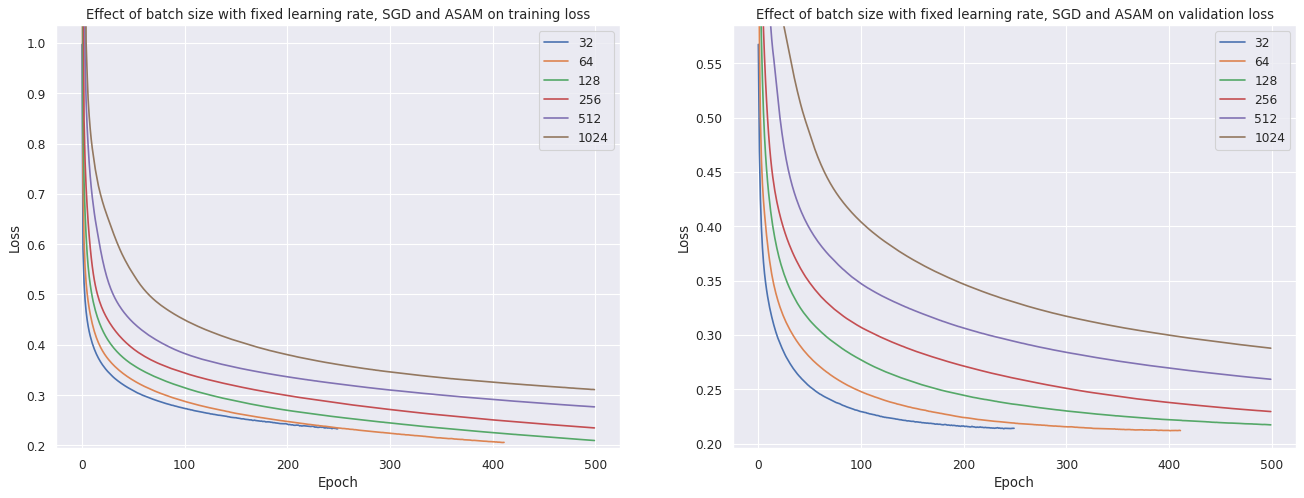

In [34]:
visualization.plot_loss_by_param(models_states[key], 'batch size with fixed learning rate, SGD and ASAM',
                                 'model_fixed_lr_diff_bs_sgd_asam_state')

#### Sharpness

In [35]:
if RETRAIN_FLAG:
    for batch_size in batch_sizes:
        model = models[key + (batch_size,)]

        sharpness_bs = visualization.get_sharpness(model.base_model, train)
        sharpnesses[key + (batch_size,)] = sharpness_bs

        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG:
    sharpnesses = ml_utils.load_sharpnesses_dict()

2022-02-26 00:26:14.020577: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 10ms/step - loss: 0.1524 - accuracy: 0.9497
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.52358D-01    |proj g|=  2.00734D-02
47/47 [==============================] - 1s 11ms/step - loss: 0.5019 - accuracy: 0.8451

At iterate    1    f= -5.01937D-01    |proj g|=  3.78722D-02
  ys=-2.585E+01  -gs= 3.974E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 0.9498 - accuracy: 0.7171

At iterate    2    f= -9.49832D-01    |proj g|=  3.50316D-02
  ys=-2.069E+01  -gs= 1.130E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 1.1048 - accuracy: 0.6179

At iterate    3    f= -1.10478D+00    |proj g|=  3.43163D-02
  ys=-7.685E+00  -gs= 4.236E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 1.2412 - accura

2022-02-26 00:26:39.120165: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 11ms/step - loss: 0.1401 - accuracy: 0.9553
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.40070D-01    |proj g|=  2.10023D-02
47/47 [==============================] - 1s 11ms/step - loss: 0.5125 - accuracy: 0.8291

At iterate    1    f= -5.12493D-01    |proj g|=  4.02899D-02
  ys=-2.128E+01  -gs= 3.601E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 1.5488 - accuracy: 0.6041

At iterate    2    f= -1.54880D+00    |proj g|=  3.90015D-02
  ys=-8.729E+01  -gs= 1.574E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 3.6514 - accuracy: 0.4330

At iterate    3    f= -3.65136D+00    |proj g|=  4.45025D-02
  ys=-1.403E+02  -gs= 3.938E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 5.7392 - accura

2022-02-26 00:27:04.533539: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 12ms/step - loss: 0.1577 - accuracy: 0.9476
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.57663D-01    |proj g|=  2.15807D-02
47/47 [==============================] - 1s 12ms/step - loss: 0.6062 - accuracy: 0.8214

At iterate    1    f= -6.06201D-01    |proj g|=  4.13251D-02
  ys=-1.974E+01  -gs= 4.808E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 4.5166 - accuracy: 0.3472

At iterate    2    f= -4.51663D+00    |proj g|=  4.16149D-02
  ys=-4.168E+02  -gs= 3.039E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 10.2167 - accuracy: 0.2971

At iterate    3    f= -1.02167D+01    |proj g|=  3.52911D-02
  ys=-3.215E+02  -gs= 1.334E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 12.6458 - accu


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 12ms/step - loss: 13.3231 - accuracy: 0.2955

At iterate    7    f= -1.33231D+01    |proj g|=  3.23609D-02
47/47 [==============================] - 1s 11ms/step - loss: 13.3709 - accuracy: 0.2955

At iterate    8    f= -1.33709D+01    |proj g|=  3.20917D-02
47/47 [==============================] - 1s 11ms/step - loss: 13.3765 - accuracy: 0.2955

At iterate    9    f= -1.33765D+01    |proj g|=  3.15776D-02
47/47 [==============================] - 1s 11ms/step - loss: 13.3815 - accuracy: 0.2956

At iterate   10    f= -1.33815D+01    |proj g|=  3.11865D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  

2022-02-26 00:27:33.737063: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 11ms/step - loss: 0.1955 - accuracy: 0.9322
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.95509D-01    |proj g|=  1.92388D-02
47/47 [==============================] - 1s 13ms/step - loss: 0.6882 - accuracy: 0.8191

At iterate    1    f= -6.88152D-01    |proj g|=  3.40396D-02
  ys=-3.032E+01  -gs= 3.483E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 2.2980 - accuracy: 0.4322

At iterate    2    f= -2.29795D+00    |proj g|=  3.42002D-02
  ys=-1.400E+02  -gs= 2.412E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 8.2103 - accuracy: 0.2703

At iterate    3    f= -8.21032D+00    |proj g|=  3.42002D-02
  ys=-3.838E+02  -gs= 9.691E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 14.0023 - accur

2022-02-26 00:27:58.803727: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 12ms/step - loss: 0.2431 - accuracy: 0.9150
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.43147D-01    |proj g|=  1.67365D-02
47/47 [==============================] - 1s 11ms/step - loss: 0.8790 - accuracy: 0.7241

At iterate    1    f= -8.79040D-01    |proj g|=  3.34730D-02
  ys=-3.400E+01  -gs= 3.100E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 7.5441 - accuracy: 0.3149

At iterate    2    f= -7.54412D+00    |proj g|=  3.31628D-02
  ys=-6.392E+02  -gs= 5.353E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 20.7215 - accuracy: 0.2951

At iterate    3    f= -2.07215D+01    |proj g|=  3.34730D-02
  ys=-8.130E+02  -gs= 2.769E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 28.1727 - accu


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
2022-02-26 00:28:21.718901: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 12ms/step - loss: 0.2815 - accuracy: 0.9018
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.81455D-01    |proj g|=  1.51094D-02
47/47 [==============================] - 1s 11ms/step - loss: 1.9037 - accuracy: 0.6007

At iterate    1    f= -1.90367D+00    |proj g|=  3.02187D-02
  ys=-9.712E+01  -gs= 5.288E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 25.1256 - accuracy: 0.2982

At iterate    2    f= -2.51256D+01    |proj g|=  2.87226D-02
  ys=-2.256E+03  -gs= 1.724E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 44.4462 - accuracy: 0.2939

At iterate    3    f= -4.44462D+01    |proj g|=  2.31879D-02
  ys=-7.244E+02  -gs= 5.859E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 46.7687 - acc

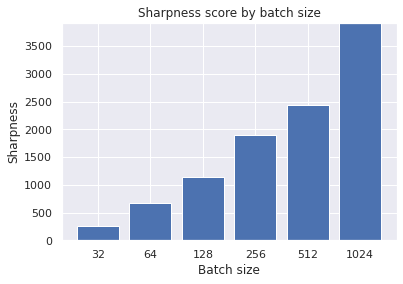

In [36]:
visualization.plot_sharpness(batch_sizes, sharpnesses, key)

#### Distance from initial weights

Batch size: 32, distance: 0.0
Batch size: 64, distance: 0.0
Batch size: 128, distance: 0.0
Batch size: 256, distance: 0.0
Batch size: 512, distance: 0.0
Batch size: 1024, distance: 0.0


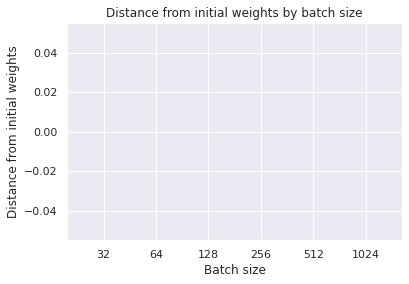

In [37]:
visualization.plot_distance_from_initial_weight(models, initial_weights, batch_sizes, key)

#### Runtime

In [38]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states,
                                                                                                     batch_sizes, key)

Batch size:  32
	Mean time per epoch:  8.01812973499298
	Converged in 239 epochs
	Overall training time (in seconds) until convergence:  1927.7687275409698
Batch size:  64
	Mean time per epoch:  4.19642385348533
	Converged in 401 epochs
	Overall training time (in seconds) until convergence:  1681.5555834770203
Batch size:  128
	Mean time per epoch:  3.1319947028160096
	Converged in 499 epochs
	Overall training time (in seconds) until convergence:  1562.8231568336487
Batch size:  256
	Mean time per epoch:  2.582286919116974
	Converged in 499 epochs
	Overall training time (in seconds) until convergence:  1288.6452856063843
Batch size:  512
	Mean time per epoch:  2.2569015865325928
	Converged in 499 epochs
	Overall training time (in seconds) until convergence:  1126.1822102069855
Batch size:  1024
	Mean time per epoch:  2.1046528344154356
	Converged in 499 epochs
	Overall training time (in seconds) until convergence:  1050.1952908039093


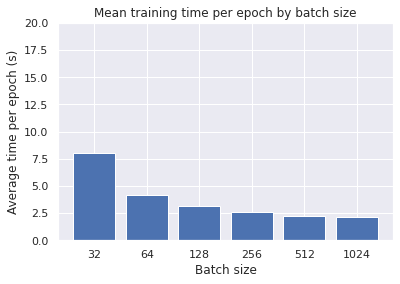

In [39]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

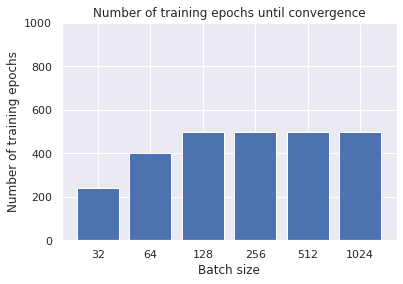

In [40]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

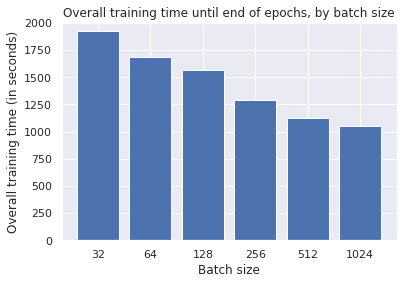

In [41]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

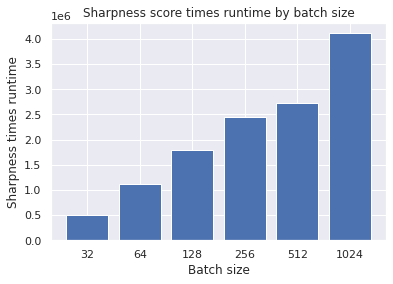

In [42]:
visualization.plot_sharpness_times_runtime(batch_sizes, overall_training_times, sharpnesses, key)

### ADAM + SAM

In [43]:
batch_sizes = [32, 64, 128, 256, 512, 1024]
lr = 0.001
training_epochs = EPOCHS

key = ('fixed', 'adam', 'sam')

In [44]:
if not RETRAIN_FLAG:
    for batch_size in batch_sizes:
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                          batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.Adam(learning_rate=lr)
        model = build_and_load_sam_model_weights(train, optimizer, filename_bs_opt_sam(batch_size, "ADAM", "SAM"))
        models[key + (batch_size,)] = model

In [45]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size in batch_sizes:
        with tf.distribute.MirroredStrategy().scope():
            # Read training data
            train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                              batch_size=batch_size,
                                                                              img_size=32)

            optimizer = keras.optimizers.Adam(learning_rate=lr)
            model = tf_models.build_simple_cnn_sam(train, optimizer)
            train_callbacks = callback_for_filename(filename_bs_opt_sam(batch_size, "ADAM", "SAM"))

            models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                  extra_callbacks=train_callbacks, verbose=1)
            models[key + (batch_size,)] = model
            initial_weights[key + (batch_size,)] = model.get_weights()
            ml_utils.save_initial_weights_dict(initial_weights)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 00:28:47.697888: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
1488/1500 [============================>.] - ETA: 0s - loss: 0.4904 - accuracy: 0.8119

2022-02-26 00:28:55.806158: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.32476, saving model to tmp/model_fixed_lr_diff_bs_32_opt_ADAM_sam_SAM.tf
1500/1500 [==============================] - 9s 5ms/step - loss: 0.4890 - accuracy: 0.8124 - val_loss: 0.3248 - val_accuracy: 0.8825
Epoch 2/500
1497/1500 [============================>.] - ETA: 0s - loss: 0.3270 - accuracy: 0.8752
Epoch 2: val_loss improved from 0.32476 to 0.27765, saving model to tmp/model_fixed_lr_diff_bs_32_opt_ADAM_sam_SAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3270 - accuracy: 0.8752 - val_loss: 0.2777 - val_accuracy: 0.8991
Epoch 3/500
1500/1500 [==============================] - ETA: 0s - loss: 0.2815 - accuracy: 0.8926
Epoch 3: val_loss improved from 0.27765 to 0.25198, saving model to tmp/model_fixed_lr_diff_bs_32_opt_ADAM_sam_SAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2815 - accuracy: 0.8926 - val_loss: 0.2520 - val_accuracy: 0.9103
Epoch 4/500
1493/1500 [============================>

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 00:30:44.364094: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
743/750 [============================>.] - ETA: 0s - loss: 0.5351 - accuracy: 0.7935

2022-02-26 00:30:50.343206: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.36084, saving model to tmp/model_fixed_lr_diff_bs_64_opt_ADAM_sam_SAM.tf
750/750 [==============================] - 7s 7ms/step - loss: 0.5335 - accuracy: 0.7941 - val_loss: 0.3608 - val_accuracy: 0.8696
Epoch 2/500
741/750 [============================>.] - ETA: 0s - loss: 0.3550 - accuracy: 0.8656
Epoch 2: val_loss improved from 0.36084 to 0.30268, saving model to tmp/model_fixed_lr_diff_bs_64_opt_ADAM_sam_SAM.tf
750/750 [==============================] - 4s 6ms/step - loss: 0.3544 - accuracy: 0.8657 - val_loss: 0.3027 - val_accuracy: 0.8911
Epoch 3/500
747/750 [============================>.] - ETA: 0s - loss: 0.3091 - accuracy: 0.8826
Epoch 3: val_loss improved from 0.30268 to 0.27326, saving model to tmp/model_fixed_lr_diff_bs_64_opt_ADAM_sam_SAM.tf
750/750 [==============================] - 4s 6ms/step - loss: 0.3090 - accuracy: 0.8826 - val_loss: 0.2733 - val_accuracy: 0.9017
Epoch 4/500
748/750 [============================>.] - ETA: 0s

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 00:32:04.022736: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
375/375 [==============================] - ETA: 0s - loss: 0.6268 - accuracy: 0.7591

2022-02-26 00:32:08.442189: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.41870, saving model to tmp/model_fixed_lr_diff_bs_128_opt_ADAM_sam_SAM.tf
375/375 [==============================] - 5s 9ms/step - loss: 0.6268 - accuracy: 0.7591 - val_loss: 0.4187 - val_accuracy: 0.8494
Epoch 2/500
371/375 [============================>.] - ETA: 0s - loss: 0.3985 - accuracy: 0.8505
Epoch 2: val_loss improved from 0.41870 to 0.34788, saving model to tmp/model_fixed_lr_diff_bs_128_opt_ADAM_sam_SAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.3978 - accuracy: 0.8509 - val_loss: 0.3479 - val_accuracy: 0.8765
Epoch 3/500
374/375 [============================>.] - ETA: 0s - loss: 0.3452 - accuracy: 0.8698
Epoch 3: val_loss improved from 0.34788 to 0.30931, saving model to tmp/model_fixed_lr_diff_bs_128_opt_ADAM_sam_SAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.3450 - accuracy: 0.8699 - val_loss: 0.3093 - val_accuracy: 0.8903
Epoch 4/500
375/375 [==============================] - ETA:

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Epoch 1/500


2022-02-26 00:33:21.660179: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


185/188 [============================>.] - ETA: 0s - loss: 0.7454 - accuracy: 0.7141

2022-02-26 00:33:25.617443: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.46810, saving model to tmp/model_fixed_lr_diff_bs_256_opt_ADAM_sam_SAM.tf
188/188 [==============================] - 6s 21ms/step - loss: 0.7420 - accuracy: 0.7153 - val_loss: 0.4681 - val_accuracy: 0.8325
Epoch 2/500
185/188 [============================>.] - ETA: 0s - loss: 0.4468 - accuracy: 0.8306
Epoch 2: val_loss improved from 0.46810 to 0.38051, saving model to tmp/model_fixed_lr_diff_bs_256_opt_ADAM_sam_SAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.4459 - accuracy: 0.8309 - val_loss: 0.3805 - val_accuracy: 0.8689
Epoch 3/500
186/188 [============================>.] - ETA: 0s - loss: 0.3892 - accuracy: 0.8542
Epoch 3: val_loss improved from 0.38051 to 0.34572, saving model to tmp/model_fixed_lr_diff_bs_256_opt_ADAM_sam_SAM.tf
188/188 [==============================] - 3s 13ms/step - loss: 0.3886 - accuracy: 0.8545 - val_loss: 0.3457 - val_accuracy: 0.8790
Epoch 4/500
188/188 [==============================] - E

186/188 [============================>.] - ETA: 0s - loss: 0.1635 - accuracy: 0.9381
Epoch 25: val_loss improved from 0.22616 to 0.22612, saving model to tmp/model_fixed_lr_diff_bs_256_opt_ADAM_sam_SAM.tf
188/188 [==============================] - 2s 13ms/step - loss: 0.1631 - accuracy: 0.9383 - val_loss: 0.2261 - val_accuracy: 0.9203
Epoch 26/500
184/188 [============================>.] - ETA: 0s - loss: 0.1585 - accuracy: 0.9402
Epoch 26: val_loss did not improve from 0.22612
188/188 [==============================] - 3s 13ms/step - loss: 0.1580 - accuracy: 0.9403 - val_loss: 0.2264 - val_accuracy: 0.9213
Epoch 27/500
187/188 [============================>.] - ETA: 0s - loss: 0.1534 - accuracy: 0.9415
Epoch 27: val_loss did not improve from 0.22612
188/188 [==============================] - 3s 14ms/step - loss: 0.1532 - accuracy: 0.9416 - val_loss: 0.2274 - val_accuracy: 0.9204
Epoch 28/500
188/188 [==============================] - ETA: 0s - loss: 0.1488 - accuracy: 0.9428
Epoch 28:

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 00:35:03.911752: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
94/94 [==============================] - ETA: 0s - loss: 0.9014 - accuracy: 0.6587

2022-02-26 00:35:06.639705: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.54410, saving model to tmp/model_fixed_lr_diff_bs_512_opt_ADAM_sam_SAM.tf
94/94 [==============================] - 3s 29ms/step - loss: 0.9014 - accuracy: 0.6587 - val_loss: 0.5441 - val_accuracy: 0.8018
Epoch 2/500
94/94 [==============================] - ETA: 0s - loss: 0.5202 - accuracy: 0.7974
Epoch 2: val_loss improved from 0.54410 to 0.44395, saving model to tmp/model_fixed_lr_diff_bs_512_opt_ADAM_sam_SAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.5202 - accuracy: 0.7974 - val_loss: 0.4439 - val_accuracy: 0.8412
Epoch 3/500
94/94 [==============================] - ETA: 0s - loss: 0.4501 - accuracy: 0.8286
Epoch 3: val_loss improved from 0.44395 to 0.39525, saving model to tmp/model_fixed_lr_diff_bs_512_opt_ADAM_sam_SAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.4501 - accuracy: 0.8286 - val_loss: 0.3952 - val_accuracy: 0.8626
Epoch 4/500
94/94 [==============================] - ETA: 0s - los

94/94 [==============================] - ETA: 0s - loss: 0.2184 - accuracy: 0.9171
Epoch 25: val_loss improved from 0.23808 to 0.23576, saving model to tmp/model_fixed_lr_diff_bs_512_opt_ADAM_sam_SAM.tf
94/94 [==============================] - 2s 23ms/step - loss: 0.2184 - accuracy: 0.9171 - val_loss: 0.2358 - val_accuracy: 0.9181
Epoch 26/500
92/94 [============================>.] - ETA: 0s - loss: 0.2146 - accuracy: 0.9184
Epoch 26: val_loss improved from 0.23576 to 0.23401, saving model to tmp/model_fixed_lr_diff_bs_512_opt_ADAM_sam_SAM.tf
94/94 [==============================] - 2s 25ms/step - loss: 0.2140 - accuracy: 0.9185 - val_loss: 0.2340 - val_accuracy: 0.9183
Epoch 27/500
94/94 [==============================] - ETA: 0s - loss: 0.2097 - accuracy: 0.9200
Epoch 27: val_loss improved from 0.23401 to 0.23236, saving model to tmp/model_fixed_lr_diff_bs_512_opt_ADAM_sam_SAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.2097 - accuracy: 0.9200 - val_loss: 0.232

Epoch 51/500
93/94 [============================>.] - ETA: 0s - loss: 0.1336 - accuracy: 0.9492
Epoch 51: val_loss did not improve from 0.22420
94/94 [==============================] - 2s 23ms/step - loss: 0.1333 - accuracy: 0.9494 - val_loss: 0.2311 - val_accuracy: 0.9221
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 00:37:02.610064: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
47/47 [==============================] - ETA: 0s - loss: 1.1276 - accuracy: 0.5983

2022-02-26 00:37:05.122851: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.69504, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_ADAM_sam_SAM.tf
47/47 [==============================] - 3s 53ms/step - loss: 1.1276 - accuracy: 0.5983 - val_loss: 0.6950 - val_accuracy: 0.7623
Epoch 2/500
47/47 [==============================] - ETA: 0s - loss: 0.6413 - accuracy: 0.7504
Epoch 2: val_loss improved from 0.69504 to 0.54379, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_ADAM_sam_SAM.tf
47/47 [==============================] - 2s 44ms/step - loss: 0.6413 - accuracy: 0.7504 - val_loss: 0.5438 - val_accuracy: 0.8048
Epoch 3/500
47/47 [==============================] - ETA: 0s - loss: 0.5389 - accuracy: 0.7900
Epoch 3: val_loss improved from 0.54379 to 0.47540, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_ADAM_sam_SAM.tf
47/47 [==============================] - 2s 44ms/step - loss: 0.5389 - accuracy: 0.7900 - val_loss: 0.4754 - val_accuracy: 0.8300
Epoch 4/500
47/47 [==============================] - ETA: 0s - 

Epoch 25/500
47/47 [==============================] - ETA: 0s - loss: 0.2882 - accuracy: 0.8930
Epoch 25: val_loss improved from 0.28776 to 0.28475, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_ADAM_sam_SAM.tf
47/47 [==============================] - 2s 44ms/step - loss: 0.2882 - accuracy: 0.8930 - val_loss: 0.2847 - val_accuracy: 0.8973
Epoch 26/500
47/47 [==============================] - ETA: 0s - loss: 0.2844 - accuracy: 0.8942
Epoch 26: val_loss improved from 0.28475 to 0.28168, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_ADAM_sam_SAM.tf
47/47 [==============================] - 2s 44ms/step - loss: 0.2844 - accuracy: 0.8942 - val_loss: 0.2817 - val_accuracy: 0.8984
Epoch 27/500
47/47 [==============================] - ETA: 0s - loss: 0.2808 - accuracy: 0.8955
Epoch 27: val_loss improved from 0.28168 to 0.27878, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_ADAM_sam_SAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.2808 - accuracy: 0.8955 -

47/47 [==============================] - 2s 44ms/step - loss: 0.2198 - accuracy: 0.9169 - val_loss: 0.2411 - val_accuracy: 0.9128
Epoch 49/500
47/47 [==============================] - ETA: 0s - loss: 0.2172 - accuracy: 0.9180
Epoch 49: val_loss improved from 0.24106 to 0.24002, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_ADAM_sam_SAM.tf
47/47 [==============================] - 2s 44ms/step - loss: 0.2172 - accuracy: 0.9180 - val_loss: 0.2400 - val_accuracy: 0.9135
Epoch 50/500
47/47 [==============================] - ETA: 0s - loss: 0.2146 - accuracy: 0.9190
Epoch 50: val_loss improved from 0.24002 to 0.23873, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_ADAM_sam_SAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.2146 - accuracy: 0.9190 - val_loss: 0.2387 - val_accuracy: 0.9147
Epoch 51/500
47/47 [==============================] - ETA: 0s - loss: 0.2120 - accuracy: 0.9199
Epoch 51: val_loss improved from 0.23873 to 0.23774, saving model to tmp/model_f

47/47 [==============================] - ETA: 0s - loss: 0.1656 - accuracy: 0.9376
Epoch 72: val_loss did not improve from 0.22813
47/47 [==============================] - 2s 44ms/step - loss: 0.1656 - accuracy: 0.9376 - val_loss: 0.2282 - val_accuracy: 0.9186
Epoch 73/500
47/47 [==============================] - ETA: 0s - loss: 0.1640 - accuracy: 0.9384
Epoch 73: val_loss improved from 0.22813 to 0.22787, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_ADAM_sam_SAM.tf
47/47 [==============================] - 2s 44ms/step - loss: 0.1640 - accuracy: 0.9384 - val_loss: 0.2279 - val_accuracy: 0.9187
Epoch 74/500
47/47 [==============================] - ETA: 0s - loss: 0.1621 - accuracy: 0.9388
Epoch 74: val_loss improved from 0.22787 to 0.22766, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_ADAM_sam_SAM.tf
47/47 [==============================] - 2s 44ms/step - loss: 0.1621 - accuracy: 0.9388 - val_loss: 0.2277 - val_accuracy: 0.9187
Epoch 75/500
47/47 [=========================

In [46]:
state_filename = 'model_fixed_lr_diff_bs_adam_sam_state'

In [47]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], state_filename)
else:
    models_states[key] = ml_utils.load_model_state(state_filename)

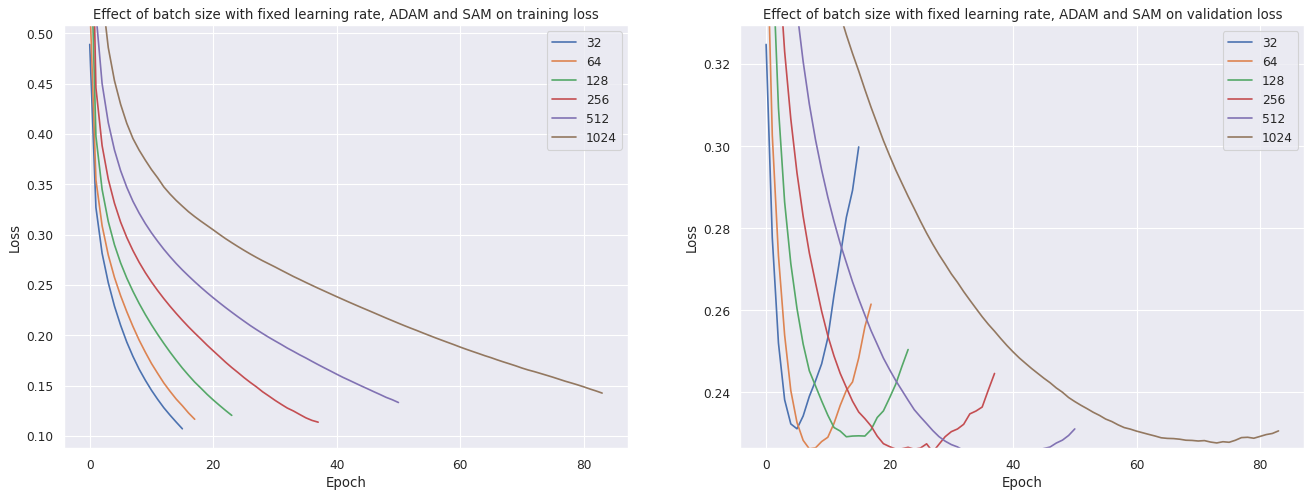

In [48]:
visualization.plot_loss_by_param(models_states[key], 'batch size with fixed learning rate, ADAM and SAM',
                                 state_filename)

#### Sharpness

In [49]:
if RETRAIN_FLAG:
    for batch_size in batch_sizes:
        model = models[key + (batch_size,)]

        sharpness_bs = visualization.get_sharpness(model.base_model, train)
        sharpnesses[key + (batch_size,)] = sharpness_bs

        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG:
    sharpnesses = ml_utils.load_sharpnesses_dict()

2022-02-26 00:40:04.799794: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 12ms/step - loss: 0.1685 - accuracy: 0.9408
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.68459D-01    |proj g|=  2.23916D-02
47/47 [==============================] - 1s 11ms/step - loss: 1.5844 - accuracy: 0.6509

At iterate    1    f= -1.58437D+00    |proj g|=  4.12176D-02
  ys=-1.204E+02  -gs= 7.737E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 3.6025 - accuracy: 0.5314

At iterate    2    f= -3.60250D+00    |proj g|=  3.09678D-02
  ys=-8.971E+01  -gs= 6.006E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 4.2316 - accuracy: 0.4484

At iterate    3    f= -4.23161D+00    |proj g|=  3.25228D-02
47/47 [==============================] - 1s 11ms/step - loss: 4.2484 - accuracy: 0.4481

At iterate    4    f= -4.24838D+00    |p

2022-02-26 00:40:29.308669: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 12ms/step - loss: 0.1732 - accuracy: 0.9385
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.73234D-01    |proj g|=  1.76459D-02
47/47 [==============================] - 1s 12ms/step - loss: 2.9582 - accuracy: 0.5185

At iterate    1    f= -2.95816D+00    |proj g|=  3.06465D-02
  ys=-2.948E+02  -gs= 9.314E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 7.8720 - accuracy: 0.3240

At iterate    2    f= -7.87201D+00    |proj g|=  3.95075D-02
  ys=-1.916E+02  -gs= 1.341E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 8.3860 - accuracy: 0.3113

At iterate    3    f= -8.38597D+00    |proj g|=  2.92471D-02
47/47 [==============================] - 1s 11ms/step - loss: 8.6054 - accuracy: 0.3092

At iterate    4    f= -8.60536D+00    |p

2022-02-26 00:40:54.571997: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 12ms/step - loss: 0.1607 - accuracy: 0.9437
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.60655D-01    |proj g|=  1.66176D-02
47/47 [==============================] - 1s 12ms/step - loss: 2.0328 - accuracy: 0.7019

At iterate    1    f= -2.03280D+00    |proj g|=  3.32352D-02
  ys=-1.304E+02  -gs= 1.203E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 6.5997 - accuracy: 0.5182

At iterate    2    f= -6.59972D+00    |proj g|=  3.38221D-02
  ys=-2.481E+02  -gs= 9.786E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 9.4875 - accuracy: 0.3935

At iterate    3    f= -9.48747D+00    |proj g|=  4.13752D-02
  ys=-9.403E+01  -gs= 8.601E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 10.2878 - accur


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 11ms/step - loss: 10.3015 - accuracy: 0.3883

At iterate    6    f= -1.03015D+01    |proj g|=  3.06751D-02
47/47 [==============================] - 1s 12ms/step - loss: 10.3883 - accuracy: 0.3884

At iterate    7    f= -1.03883D+01    |proj g|=  3.06751D-02
47/47 [==============================] - 1s 11ms/step - loss: 10.4507 - accuracy: 0.3882

At iterate    8    f= -1.04507D+01    |proj g|=  3.06657D-02
47/47 [==============================] - 1s 12ms/step - loss: 10.4538 - accuracy: 0.3882

At iterate    9    f= -1.04538D+01    |proj g|=  2.87269D-02
47/47 [==============================] - 1s 12ms/step - loss: 10.4639 - accuracy: 0.3884

At iterate   10    f= -1.04639D+01    |proj g|=  2.83247D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final g

2022-02-26 00:41:21.475945: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 11ms/step - loss: 0.1382 - accuracy: 0.9519
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.38176D-01    |proj g|=  1.71897D-02
47/47 [==============================] - 1s 12ms/step - loss: 3.8065 - accuracy: 0.5872

At iterate    1    f= -3.80648D+00    |proj g|=  3.37121D-02
  ys=-3.246E+02  -gs= 1.673E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 11.3977 - accuracy: 0.4913

At iterate    2    f= -1.13977D+01    |proj g|=  3.16870D-02
  ys=-3.537E+02  -gs= 1.968E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 12.1765 - accuracy: 0.4875

At iterate    3    f= -1.21765D+01    |proj g|=  3.14637D-02
11/47 [======>.......................] - ETA: 0s - loss: 12.4284 - accuracy: 0.4886


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 11ms/step - loss: 12.3896 - accuracy: 0.4867

At iterate    4    f= -1.23896D+01    |proj g|=  2.94760D-02
11/47 [======>.......................] - ETA: 0s - loss: 12.4165 - accuracy: 0.4893


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 11ms/step - loss: 12.3764 - accuracy: 0.4874



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
2022-02-26 00:41:40.735876: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      5      8  65574     2 58151   2.948D-02  -1.239D+01
  F =  -12.389643669128418     

ABNORMAL_TERMINATION_IN_LNSRCH                              
47/47 [==============================] - 1s 11ms/step - loss: 0.1468 - accuracy: 0.9499
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.46814D-01    |proj g|=  1.75445D-02
47/47 [==============================] - 1s 12ms/step - loss: 4.6613 - accuracy: 0.4467

At iterate    1  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 11ms/step - loss: 19.8413 - accuracy: 0.2880

At iterate    5    f= -1.98413D+01    |proj g|=  2.73025D-02
47/47 [==============================] - 1s 11ms/step - loss: 19.8899 - accuracy: 0.2879

At iterate    6    f= -1.98899D+01    |proj g|=  2.52836D-02
47/47 [==============================] - 1s 12ms/step - loss: 19.9124 - accuracy: 0.2878

At iterate    7    f= -1.99124D+01    |proj g|=  2.65090D-02
47/47 [==============================] - 1s 11ms/step - loss: 19.9138 - accuracy: 0.2878

At iterate    8    f= -1.99138D+01    |proj g|=  2.52505D-02
47/47 [==============================] - 1s 13ms/step - loss: 19.9147 - accuracy: 0.2878

At iterate    9    f= -1.99147D+01    |proj g|=  2.51783D-02
47/47 [==============================] - 1s 12ms/step - loss: 19.9152 - accuracy: 0.2878

At iterate   10    f= -1.99152D+01    |proj g|=  2.51388D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluat

2022-02-26 00:42:07.141650: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 12ms/step - loss: 0.1500 - accuracy: 0.9470
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.50025D-01    |proj g|=  1.71110D-02
47/47 [==============================] - 1s 11ms/step - loss: 5.7299 - accuracy: 0.4261

At iterate    1    f= -5.72993D+00    |proj g|=  3.18491D-02
  ys=-4.298E+02  -gs= 1.011E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 23.6442 - accuracy: 0.2214

At iterate    2    f= -2.36442D+01    |proj g|=  3.20392D-02
  ys=-1.231E+03  -gs= 2.775E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 27.6715 - accuracy: 0.1986

At iterate    3    f= -2.76715D+01    |proj g|=  3.36777D-02
  ys=-1.223E+02  -gs= 1.292E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 28.5066 - acc


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 11ms/step - loss: 28.7205 - accuracy: 0.1985

At iterate    6    f= -2.87205D+01    |proj g|=  2.85175D-02
47/47 [==============================] - 1s 11ms/step - loss: 28.7922 - accuracy: 0.1985

At iterate    7    f= -2.87922D+01    |proj g|=  2.64800D-02
47/47 [==============================] - 1s 11ms/step - loss: 28.8336 - accuracy: 0.1985

At iterate    8    f= -2.88336D+01    |proj g|=  2.39411D-02
47/47 [==============================] - 1s 11ms/step - loss: 28.8379 - accuracy: 0.1985

At iterate    9    f= -2.88379D+01    |proj g|=  2.29926D-02
47/47 [==============================] - 1s 11ms/step - loss: 28.8423 - accuracy: 0.1985

At iterate   10    f= -2.88423D+01    |proj g|=  2.31514D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final g

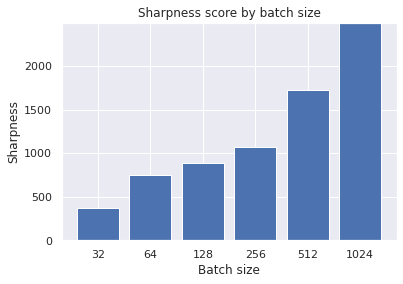

In [50]:
visualization.plot_sharpness(batch_sizes, sharpnesses, key)

#### Distance from initial weights

Batch size: 32, distance: 0.0
Batch size: 64, distance: 0.0
Batch size: 128, distance: 0.0
Batch size: 256, distance: 0.0
Batch size: 512, distance: 0.0
Batch size: 1024, distance: 0.0


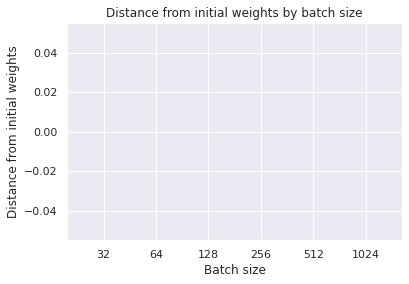

In [51]:
visualization.plot_distance_from_initial_weight(models, initial_weights, batch_sizes, key)

#### Runtime

In [52]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states,
                                                                                                     batch_sizes, key)

Batch size:  32
	Mean time per epoch:  7.217384904623032
	Converged in 5 epochs
	Overall training time (in seconds) until convergence:  37.40313696861267
Batch size:  64
	Mean time per epoch:  4.3516672187381324
	Converged in 7 epochs
	Overall training time (in seconds) until convergence:  32.55158090591431
Batch size:  128
	Mean time per epoch:  3.160964628060659
	Converged in 13 epochs
	Overall training time (in seconds) until convergence:  41.83125066757202
Batch size:  256
	Mean time per epoch:  2.6166723715631584
	Converged in 27 epochs
	Overall training time (in seconds) until convergence:  72.05103015899658
Batch size:  512
	Mean time per epoch:  2.250631954155716
	Converged in 40 epochs
	Overall training time (in seconds) until convergence:  90.29587197303772
Batch size:  1024
	Mean time per epoch:  2.0857932539213273
	Converged in 73 epochs
	Overall training time (in seconds) until convergence:  152.54145574569702


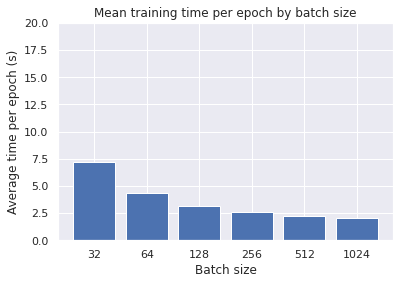

In [53]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

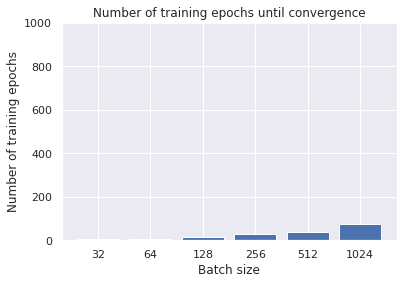

In [54]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

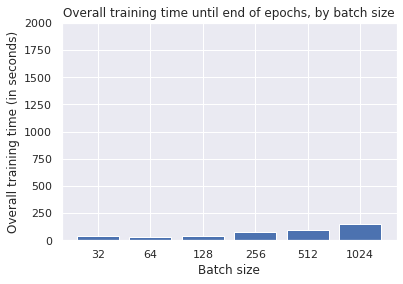

In [55]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

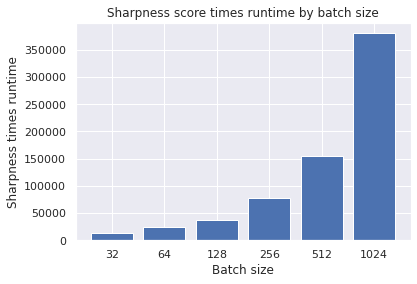

In [56]:
visualization.plot_sharpness_times_runtime(batch_sizes, overall_training_times, sharpnesses, key)

### ADAM + ASAM

In [57]:
batch_sizes = [32, 64, 128, 256, 512, 1024]
lr = 0.001
training_epochs = EPOCHS

key = ('fixed', 'adam', 'asam')

In [58]:
if not RETRAIN_FLAG:
    for batch_size in batch_sizes:
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                          batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.Adam(learning_rate=lr)
        model = build_and_load_sam_model_weights(train, optimizer, filename_bs_opt_sam(batch_size, "ADAM", "ASAM"))
        models[key + (batch_size,)] = model

In [59]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size in batch_sizes:
        with tf.distribute.MirroredStrategy().scope():
            # Read training data
            train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                              batch_size=batch_size,
                                                                              img_size=32)

            optimizer = keras.optimizers.Adam(learning_rate=lr)
            model = tf_models.build_simple_cnn_sam(train, optimizer, adaptive=True, rho=2.0)
            train_callbacks = callback_for_filename(filename_bs_opt_sam(batch_size, "ADAM", "ASAM"))

            models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                  extra_callbacks=train_callbacks, verbose=1)
            models[key + (batch_size,)] = model
            initial_weights[key + (batch_size,)] = model.get_weights()
            ml_utils.save_initial_weights_dict(initial_weights)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 00:42:35.787867: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
1492/1500 [============================>.] - ETA: 0s - loss: 0.5251 - accuracy: 0.7934

2022-02-26 00:42:43.930679: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.33144, saving model to tmp/model_fixed_lr_diff_bs_32_opt_ADAM_sam_ASAM.tf
1500/1500 [==============================] - 9s 5ms/step - loss: 0.5243 - accuracy: 0.7937 - val_loss: 0.3314 - val_accuracy: 0.8819
Epoch 2/500
1491/1500 [============================>.] - ETA: 0s - loss: 0.3700 - accuracy: 0.8503
Epoch 2: val_loss improved from 0.33144 to 0.28792, saving model to tmp/model_fixed_lr_diff_bs_32_opt_ADAM_sam_ASAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3696 - accuracy: 0.8504 - val_loss: 0.2879 - val_accuracy: 0.8961
Epoch 3/500
1496/1500 [============================>.] - ETA: 0s - loss: 0.3322 - accuracy: 0.8626
Epoch 3: val_loss improved from 0.28792 to 0.26539, saving model to tmp/model_fixed_lr_diff_bs_32_opt_ADAM_sam_ASAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3322 - accuracy: 0.8625 - val_loss: 0.2654 - val_accuracy: 0.9034
Epoch 4/500
1499/1500 [==========================

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 00:45:09.034154: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
740/750 [============================>.] - ETA: 0s - loss: 0.5657 - accuracy: 0.7788

2022-02-26 00:45:15.409472: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.37262, saving model to tmp/model_fixed_lr_diff_bs_64_opt_ADAM_sam_ASAM.tf
750/750 [==============================] - 7s 6ms/step - loss: 0.5635 - accuracy: 0.7795 - val_loss: 0.3726 - val_accuracy: 0.8635
Epoch 2/500
748/750 [============================>.] - ETA: 0s - loss: 0.3874 - accuracy: 0.8487
Epoch 2: val_loss improved from 0.37262 to 0.31813, saving model to tmp/model_fixed_lr_diff_bs_64_opt_ADAM_sam_ASAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.3873 - accuracy: 0.8488 - val_loss: 0.3181 - val_accuracy: 0.8844
Epoch 3/500
741/750 [============================>.] - ETA: 0s - loss: 0.3454 - accuracy: 0.8617
Epoch 3: val_loss improved from 0.31813 to 0.28939, saving model to tmp/model_fixed_lr_diff_bs_64_opt_ADAM_sam_ASAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.3450 - accuracy: 0.8618 - val_loss: 0.2894 - val_accuracy: 0.8959
Epoch 4/500
748/750 [============================>.] - ETA:

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 00:46:57.907293: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
373/375 [============================>.] - ETA: 0s - loss: 0.6743 - accuracy: 0.7380

2022-02-26 00:47:02.439167: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.42409, saving model to tmp/model_fixed_lr_diff_bs_128_opt_ADAM_sam_ASAM.tf
375/375 [==============================] - 5s 9ms/step - loss: 0.6729 - accuracy: 0.7386 - val_loss: 0.4241 - val_accuracy: 0.8473
Epoch 2/500
370/375 [============================>.] - ETA: 0s - loss: 0.4238 - accuracy: 0.8369
Epoch 2: val_loss improved from 0.42409 to 0.35453, saving model to tmp/model_fixed_lr_diff_bs_128_opt_ADAM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.4231 - accuracy: 0.8370 - val_loss: 0.3545 - val_accuracy: 0.8742
Epoch 3/500
370/375 [============================>.] - ETA: 0s - loss: 0.3723 - accuracy: 0.8562
Epoch 3: val_loss improved from 0.35453 to 0.31526, saving model to tmp/model_fixed_lr_diff_bs_128_opt_ADAM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.3717 - accuracy: 0.8562 - val_loss: 0.3153 - val_accuracy: 0.8878
Epoch 4/500
371/375 [============================>.] - E

Epoch 27/500
373/375 [============================>.] - ETA: 0s - loss: 0.1707 - accuracy: 0.9239
Epoch 27: val_loss did not improve from 0.22694
375/375 [==============================] - 3s 8ms/step - loss: 0.1707 - accuracy: 0.9239 - val_loss: 0.2362 - val_accuracy: 0.9178
Epoch 28/500
374/375 [============================>.] - ETA: 0s - loss: 0.1685 - accuracy: 0.9245
Epoch 28: val_loss did not improve from 0.22694
375/375 [==============================] - 3s 9ms/step - loss: 0.1685 - accuracy: 0.9245 - val_loss: 0.2371 - val_accuracy: 0.9188
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Epoch 1/500


2022-02-26 00:48:29.784509: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


186/188 [============================>.] - ETA: 0s - loss: 0.8033 - accuracy: 0.6892

2022-02-26 00:48:32.883816: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.48911, saving model to tmp/model_fixed_lr_diff_bs_256_opt_ADAM_sam_ASAM.tf
188/188 [==============================] - 5s 22ms/step - loss: 0.8007 - accuracy: 0.6901 - val_loss: 0.4891 - val_accuracy: 0.8253
Epoch 2/500
185/188 [============================>.] - ETA: 0s - loss: 0.4818 - accuracy: 0.8152
Epoch 2: val_loss improved from 0.48911 to 0.39898, saving model to tmp/model_fixed_lr_diff_bs_256_opt_ADAM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.4809 - accuracy: 0.8156 - val_loss: 0.3990 - val_accuracy: 0.8593
Epoch 3/500
184/188 [============================>.] - ETA: 0s - loss: 0.4219 - accuracy: 0.8387
Epoch 3: val_loss improved from 0.39898 to 0.36388, saving model to tmp/model_fixed_lr_diff_bs_256_opt_ADAM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.4208 - accuracy: 0.8393 - val_loss: 0.3639 - val_accuracy: 0.8728
Epoch 4/500
188/188 [==============================] 

Epoch 25/500
187/188 [============================>.] - ETA: 0s - loss: 0.2080 - accuracy: 0.9144
Epoch 25: val_loss improved from 0.22676 to 0.22408, saving model to tmp/model_fixed_lr_diff_bs_256_opt_ADAM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.2078 - accuracy: 0.9145 - val_loss: 0.2241 - val_accuracy: 0.9196
Epoch 26/500
187/188 [============================>.] - ETA: 0s - loss: 0.2044 - accuracy: 0.9161
Epoch 26: val_loss improved from 0.22408 to 0.22228, saving model to tmp/model_fixed_lr_diff_bs_256_opt_ADAM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.2042 - accuracy: 0.9162 - val_loss: 0.2223 - val_accuracy: 0.9200
Epoch 27/500
185/188 [============================>.] - ETA: 0s - loss: 0.2012 - accuracy: 0.9179
Epoch 27: val_loss improved from 0.22228 to 0.22066, saving model to tmp/model_fixed_lr_diff_bs_256_opt_ADAM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.2008 - accura

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 00:50:25.161283: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
92/94 [============================>.] - ETA: 0s - loss: 1.0270 - accuracy: 0.6281

2022-02-26 00:50:28.834654: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.56834, saving model to tmp/model_fixed_lr_diff_bs_512_opt_ADAM_sam_ASAM.tf
94/94 [==============================] - 4s 29ms/step - loss: 1.0189 - accuracy: 0.6304 - val_loss: 0.5683 - val_accuracy: 0.7918
Epoch 2/500
94/94 [==============================] - ETA: 0s - loss: 0.5464 - accuracy: 0.7860
Epoch 2: val_loss improved from 0.56834 to 0.45511, saving model to tmp/model_fixed_lr_diff_bs_512_opt_ADAM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.5464 - accuracy: 0.7860 - val_loss: 0.4551 - val_accuracy: 0.8356
Epoch 3/500
94/94 [==============================] - ETA: 0s - loss: 0.4716 - accuracy: 0.8173
Epoch 3: val_loss improved from 0.45511 to 0.40772, saving model to tmp/model_fixed_lr_diff_bs_512_opt_ADAM_sam_ASAM.tf
94/94 [==============================] - 3s 27ms/step - loss: 0.4716 - accuracy: 0.8173 - val_loss: 0.4077 - val_accuracy: 0.8550
Epoch 4/500
94/94 [==============================] - ETA: 0s - 

Epoch 25/500
94/94 [==============================] - ETA: 0s - loss: 0.2445 - accuracy: 0.9034
Epoch 25: val_loss improved from 0.24637 to 0.24387, saving model to tmp/model_fixed_lr_diff_bs_512_opt_ADAM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.2445 - accuracy: 0.9034 - val_loss: 0.2439 - val_accuracy: 0.9126
Epoch 26/500
94/94 [==============================] - ETA: 0s - loss: 0.2407 - accuracy: 0.9044
Epoch 26: val_loss improved from 0.24387 to 0.24259, saving model to tmp/model_fixed_lr_diff_bs_512_opt_ADAM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.2407 - accuracy: 0.9044 - val_loss: 0.2426 - val_accuracy: 0.9123
Epoch 27/500
93/94 [============================>.] - ETA: 0s - loss: 0.2381 - accuracy: 0.9054
Epoch 27: val_loss improved from 0.24259 to 0.24035, saving model to tmp/model_fixed_lr_diff_bs_512_opt_ADAM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.2378 - accuracy: 0.9055 -

Epoch 50/500
94/94 [==============================] - ETA: 0s - loss: 0.1734 - accuracy: 0.9285
Epoch 50: val_loss improved from 0.22324 to 0.22160, saving model to tmp/model_fixed_lr_diff_bs_512_opt_ADAM_sam_ASAM.tf
94/94 [==============================] - 2s 25ms/step - loss: 0.1734 - accuracy: 0.9285 - val_loss: 0.2216 - val_accuracy: 0.9212
Epoch 51/500
92/94 [============================>.] - ETA: 0s - loss: 0.1722 - accuracy: 0.9287
Epoch 51: val_loss did not improve from 0.22160
94/94 [==============================] - 2s 26ms/step - loss: 0.1717 - accuracy: 0.9289 - val_loss: 0.2228 - val_accuracy: 0.9203
Epoch 52/500
94/94 [==============================] - ETA: 0s - loss: 0.1696 - accuracy: 0.9292
Epoch 52: val_loss did not improve from 0.22160
94/94 [==============================] - 2s 25ms/step - loss: 0.1696 - accuracy: 0.9292 - val_loss: 0.2255 - val_accuracy: 0.9194
Epoch 53/500
94/94 [==============================] - ETA: 0s - loss: 0.1679 - accuracy: 0.9300
Epoch 53:

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 00:52:50.200506: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
47/47 [==============================] - ETA: 0s - loss: 1.1789 - accuracy: 0.5856

2022-02-26 00:52:54.985345: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.69239, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_ADAM_sam_ASAM.tf
47/47 [==============================] - 6s 81ms/step - loss: 1.1789 - accuracy: 0.5856 - val_loss: 0.6924 - val_accuracy: 0.7634
Epoch 2/500
47/47 [==============================] - ETA: 0s - loss: 0.6638 - accuracy: 0.7381
Epoch 2: val_loss improved from 0.69239 to 0.54925, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_ADAM_sam_ASAM.tf
47/47 [==============================] - 2s 46ms/step - loss: 0.6638 - accuracy: 0.7381 - val_loss: 0.5492 - val_accuracy: 0.8008
Epoch 3/500
47/47 [==============================] - ETA: 0s - loss: 0.5536 - accuracy: 0.7835
Epoch 3: val_loss improved from 0.54925 to 0.47808, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_ADAM_sam_ASAM.tf
47/47 [==============================] - 2s 44ms/step - loss: 0.5536 - accuracy: 0.7835 - val_loss: 0.4781 - val_accuracy: 0.8302
Epoch 4/500
47/47 [==============================] - ETA: 0s

Epoch 25/500
47/47 [==============================] - ETA: 0s - loss: 0.2917 - accuracy: 0.8875
Epoch 25: val_loss improved from 0.28059 to 0.27824, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_ADAM_sam_ASAM.tf
47/47 [==============================] - 2s 44ms/step - loss: 0.2917 - accuracy: 0.8875 - val_loss: 0.2782 - val_accuracy: 0.8992
Epoch 26/500
47/47 [==============================] - ETA: 0s - loss: 0.2892 - accuracy: 0.8877
Epoch 26: val_loss improved from 0.27824 to 0.27528, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_ADAM_sam_ASAM.tf
47/47 [==============================] - 2s 43ms/step - loss: 0.2892 - accuracy: 0.8877 - val_loss: 0.2753 - val_accuracy: 0.9002
Epoch 27/500
47/47 [==============================] - ETA: 0s - loss: 0.2853 - accuracy: 0.8897
Epoch 27: val_loss improved from 0.27528 to 0.27312, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_ADAM_sam_ASAM.tf
47/47 [==============================] - 2s 43ms/step - loss: 0.2853 - accuracy: 0.889

Epoch 49/500
47/47 [==============================] - ETA: 0s - loss: 0.2357 - accuracy: 0.9062
Epoch 49: val_loss improved from 0.24368 to 0.24249, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_ADAM_sam_ASAM.tf
47/47 [==============================] - 2s 43ms/step - loss: 0.2357 - accuracy: 0.9062 - val_loss: 0.2425 - val_accuracy: 0.9139
Epoch 50/500
47/47 [==============================] - ETA: 0s - loss: 0.2334 - accuracy: 0.9064
Epoch 50: val_loss improved from 0.24249 to 0.24092, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_ADAM_sam_ASAM.tf
47/47 [==============================] - 2s 43ms/step - loss: 0.2334 - accuracy: 0.9064 - val_loss: 0.2409 - val_accuracy: 0.9144
Epoch 51/500
47/47 [==============================] - ETA: 0s - loss: 0.2309 - accuracy: 0.9073
Epoch 51: val_loss improved from 0.24092 to 0.24039, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_ADAM_sam_ASAM.tf
47/47 [==============================] - 2s 43ms/step - loss: 0.2309 - accuracy: 0.907

47/47 [==============================] - 2s 43ms/step - loss: 0.1912 - accuracy: 0.9219 - val_loss: 0.2256 - val_accuracy: 0.9191
Epoch 74/500
47/47 [==============================] - ETA: 0s - loss: 0.1895 - accuracy: 0.9228
Epoch 74: val_loss did not improve from 0.22560
47/47 [==============================] - 2s 43ms/step - loss: 0.1895 - accuracy: 0.9228 - val_loss: 0.2262 - val_accuracy: 0.9185
Epoch 75/500
47/47 [==============================] - ETA: 0s - loss: 0.1868 - accuracy: 0.9246
Epoch 75: val_loss improved from 0.22560 to 0.22559, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_ADAM_sam_ASAM.tf
47/47 [==============================] - 2s 43ms/step - loss: 0.1868 - accuracy: 0.9246 - val_loss: 0.2256 - val_accuracy: 0.9190
Epoch 76/500
47/47 [==============================] - ETA: 0s - loss: 0.1851 - accuracy: 0.9241
Epoch 76: val_loss improved from 0.22559 to 0.22511, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_ADAM_sam_ASAM.tf
47/47 [=======================

In [60]:
state_filename = 'model_fixed_lr_diff_bs_adam_asam_state'

In [61]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], state_filename)
else:
    models_states[key] = ml_utils.load_model_state(state_filename)

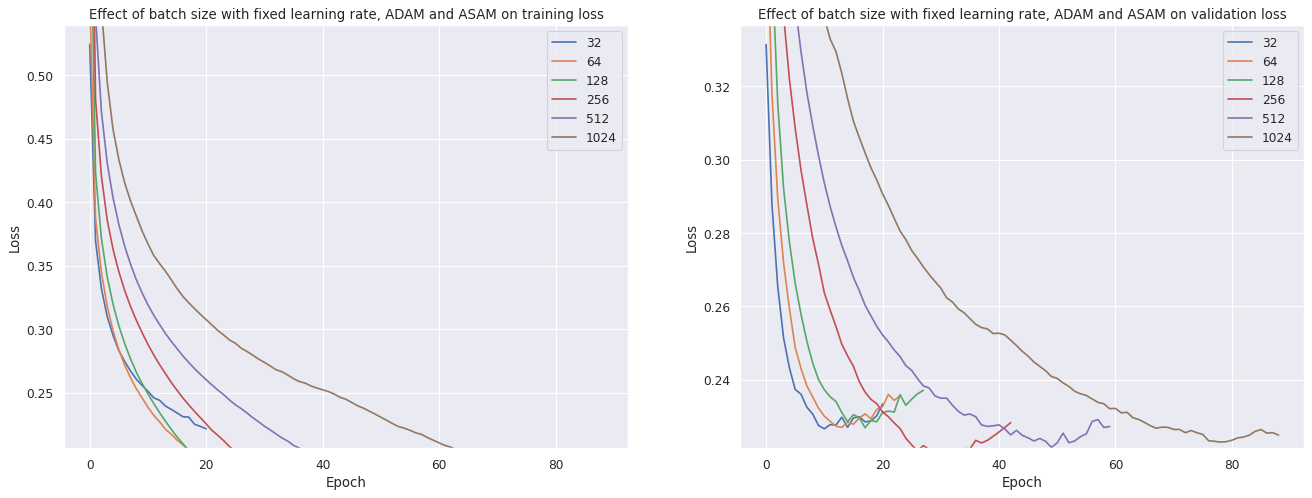

In [62]:
visualization.plot_loss_by_param(models_states[key], 'batch size with fixed learning rate, ADAM and ASAM',
                                 state_filename)

#### Sharpness

In [63]:
if RETRAIN_FLAG:
    for batch_size in batch_sizes:
        model = models[key + (batch_size,)]

        sharpness_bs = visualization.get_sharpness(model.base_model, train)
        sharpnesses[key + (batch_size,)] = sharpness_bs

        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG:
    sharpnesses = ml_utils.load_sharpnesses_dict()


2022-02-26 00:56:02.367600: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 12ms/step - loss: 0.1684 - accuracy: 0.9396
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.68414D-01    |proj g|=  1.67378D-02
47/47 [==============================] - 1s 11ms/step - loss: 0.3021 - accuracy: 0.8863

At iterate    1    f= -3.02109D-01    |proj g|=  3.34740D-02
  ys=-7.014E+00  -gs= 2.581E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 0.4614 - accuracy: 0.8223

At iterate    2    f= -4.61427D-01    |proj g|=  3.08665D-02
  ys=-7.326E+00  -gs= 4.140E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 0.5483 - accuracy: 0.7958

At iterate    3    f= -5.48262D-01    |proj g|=  2.96348D-02
47/47 [==============================] - 1s 11ms/step - loss: 0.5507 - accuracy: 0.7950

At iterate    4    f= -5.50734D-01    |p


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 11ms/step - loss: 0.6250 - accuracy: 0.7733

At iterate    8    f= -6.25003D-01    |proj g|=  3.34105D-02
11/47 [======>.......................] - ETA: 0s - loss: 0.7262 - accuracy: 0.7463


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 11ms/step - loss: 0.7020 - accuracy: 0.7485

At iterate    9    f= -7.01985D-01    |proj g|=  2.92336D-02
47/47 [==============================] - 1s 11ms/step - loss: 0.7191 - accuracy: 0.7441

At iterate   10    f= -7.19111D-01    |proj g|=  3.27849D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786     10     13  40194     3 35600   3.278D-02  -7.191D-01
  F = -0.71911078691482544     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


2022-02-26 00:56:31.568948: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 11ms/step - loss: 0.1582 - accuracy: 0.9448
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.58231D-01    |proj g|=  1.55534D-02
47/47 [==============================] - 1s 11ms/step - loss: 0.6458 - accuracy: 0.7963

At iterate    1    f= -6.45801D-01    |proj g|=  3.11068D-02
  ys=-3.460E+01  -gs= 4.288E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 1.5617 - accuracy: 0.7374

At iterate    2    f= -1.56171D+00    |proj g|=  3.17886D-02
  ys=-4.224E+01  -gs= 2.427E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 1.8996 - accuracy: 0.7059

At iterate    3    f= -1.89958D+00    |proj g|=  3.11068D-02
  ys=-1.512E+00  -gs= 1.611E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 1.9743 - accura


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 11ms/step - loss: 1.9777 - accuracy: 0.6852



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
2022-02-26 00:56:52.896536: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      7      9  59574     3 54763   3.051D-02  -1.990D+00
  F =  -1.9903386831283569     

ABNORMAL_TERMINATION_IN_LNSRCH                              
47/47 [==============================] - 1s 11ms/step - loss: 0.1569 - accuracy: 0.9449
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.56856D-01    |proj g|=  1.80851D-02
47/47 [==============================] - 1s 11ms/step - loss: 1.6278 - accuracy: 0.7310

At iterate    1  

2022-02-26 00:57:18.915366: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 11ms/step - loss: 0.1415 - accuracy: 0.9517
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.41504D-01    |proj g|=  1.85231D-02
47/47 [==============================] - 1s 11ms/step - loss: 1.0504 - accuracy: 0.7855

At iterate    1    f= -1.05042D+00    |proj g|=  3.70462D-02
  ys=-6.962E+01  -gs= 6.119E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 3.5817 - accuracy: 0.5792

At iterate    2    f= -3.58166D+00    |proj g|=  3.50947D-02
  ys=-2.221E+02  -gs= 4.384E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 4.7752 - accuracy: 0.5263

At iterate    3    f= -4.77517D+00    |proj g|=  3.30131D-02
  ys=-2.953E+01  -gs= 4.049E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 5.0765 - accura


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 12ms/step - loss: 5.1126 - accuracy: 0.5235

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      9     11  64803     4 56862   3.310D-02  -5.141D+00
  F =  -5.1405920982360840     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
2022-02-26 00:57:44.101936: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 11ms/step - loss: 0.1465 - accuracy: 0.9489
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.46549D-01    |proj g|=  1.66656D-02
47/47 [==============================] - 1s 11ms/step - loss: 2.2044 - accuracy: 0.7025

At iterate    1    f= -2.20444D+00    |proj g|=  3.33312D-02
  ys=-1.322E+02  -gs= 1.256E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 8.2096 - accuracy: 0.4437

At iterate    2    f= -8.20963D+00    |proj g|=  3.53484D-02
  ys=-4.151E+02  -gs= 1.262E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 10.2524 - accuracy: 0.4031

At iterate    3    f= -1.02524D+01    |proj g|=  3.17842D-02
  ys=-1.552E+01  -gs= 9.286E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 10.4573 - accu


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 11ms/step - loss: 10.4802 - accuracy: 0.4015

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      8     10  66084     3 58542   3.020D-02  -1.049D+01
  F =  -10.492625236511230     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
2022-02-26 00:58:09.003682: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 11ms/step - loss: 0.1546 - accuracy: 0.9464
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.54619D-01    |proj g|=  1.74745D-02
47/47 [==============================] - 1s 12ms/step - loss: 1.6561 - accuracy: 0.7074

At iterate    1    f= -1.65614D+00    |proj g|=  3.30161D-02
  ys=-9.118E+01  -gs= 6.870E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 8.0229 - accuracy: 0.4770

At iterate    2    f= -8.02288D+00    |proj g|=  3.22466D-02
  ys=-4.911E+02  -gs= 1.076E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 11.8349 - accuracy: 0.3984

At iterate    3    f= -1.18349D+01    |proj g|=  3.53186D-02
  ys=-1.171E+02  -gs= 9.212E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 12.8296 - accu

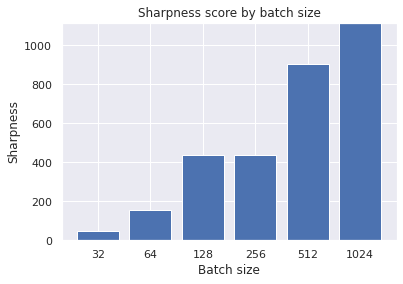

In [64]:
visualization.plot_sharpness(batch_sizes, sharpnesses, key)

#### Distance from initial weights

Batch size: 32, distance: 0.0
Batch size: 64, distance: 0.0
Batch size: 128, distance: 0.0
Batch size: 256, distance: 0.0
Batch size: 512, distance: 0.0
Batch size: 1024, distance: 0.0


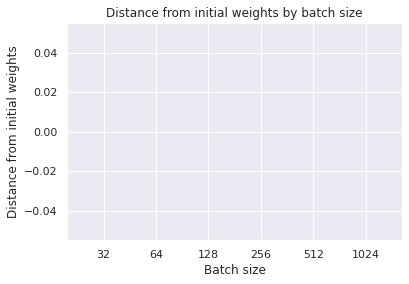

In [65]:
visualization.plot_distance_from_initial_weight(models, initial_weights, batch_sizes, key)

#### Runtime

In [66]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states,
                                                                                                     batch_sizes, key)

Batch size:  32
	Mean time per epoch:  7.22764938218253
	Converged in 10 epochs
	Overall training time (in seconds) until convergence:  73.98921847343445
Batch size:  64
	Mean time per epoch:  4.465542167425156
	Converged in 13 epochs
	Overall training time (in seconds) until convergence:  59.1382691860199
Batch size:  128
	Mean time per epoch:  3.2123627407210216
	Converged in 17 epochs
	Overall training time (in seconds) until convergence:  55.03934097290039
Batch size:  256
	Mean time per epoch:  2.6167163183522777
	Converged in 32 epochs
	Overall training time (in seconds) until convergence:  84.42867994308472
Batch size:  512
	Mean time per epoch:  2.343671953678131
	Converged in 49 epochs
	Overall training time (in seconds) until convergence:  114.25917911529541
Batch size:  1024
	Mean time per epoch:  2.084749958488379
	Converged in 78 epochs
	Overall training time (in seconds) until convergence:  163.1553966999054


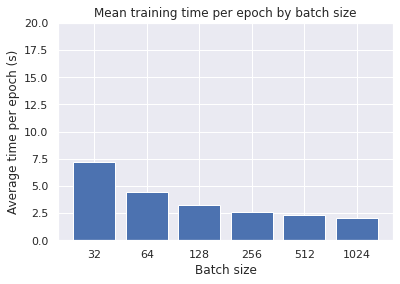

In [67]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

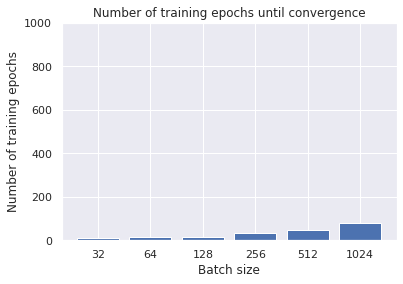

In [68]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

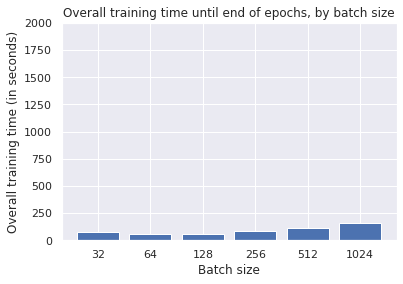

In [69]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

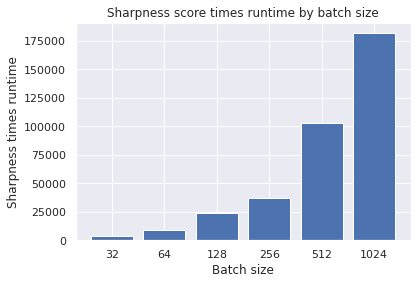

In [70]:
visualization.plot_sharpness_times_runtime(batch_sizes, overall_training_times, sharpnesses, key)

## without sharpness aware minimization

### SGD with Momentum

In [71]:
batch_sizes = [32, 64, 128, 256, 512, 1024]
lr = 0.001
training_epochs = EPOCHS

key = ('fixed', 'sgd', 'none')

In [72]:
if not RETRAIN_FLAG:
    for batch_size in batch_sizes:
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                          batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        model = build_and_load_model_weights(train, optimizer, filename_bs_opt_sam(batch_size, "SGD-MOM", "NONE"))
        models[key + (batch_size,)] = model

In [73]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size in batch_sizes:
        with tf.distribute.MirroredStrategy().scope():
            # Read training data
            train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                              batch_size=batch_size,
                                                                              img_size=32)

            optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
            model = tf_models.build_and_compile_simple_cnn(train, optimizer)
            train_callbacks = callback_for_filename(filename_bs_opt_sam(batch_size, "SGD-MOM", "NONE"))

            models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                  extra_callbacks=train_callbacks, verbose=1)
            models[key + (batch_size,)] = model
            initial_weights[key + (batch_size,)] = model.get_weights()
            ml_utils.save_initial_weights_dict(initial_weights)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 00:58:36.015790: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
1490/1500 [============================>.] - ETA: 0s - loss: 0.9662 - accuracy: 0.6459

2022-02-26 00:58:42.475035: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.67881, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_NONE.tf
1500/1500 [==============================] - 8s 5ms/step - loss: 0.9644 - accuracy: 0.6465 - val_loss: 0.6788 - val_accuracy: 0.7757
Epoch 2/500
1500/1500 [==============================] - ETA: 0s - loss: 0.6562 - accuracy: 0.7626
Epoch 2: val_loss improved from 0.67881 to 0.58268, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_NONE.tf
1500/1500 [==============================] - 6s 4ms/step - loss: 0.6562 - accuracy: 0.7626 - val_loss: 0.5827 - val_accuracy: 0.8057
Epoch 3/500
1487/1500 [============================>.] - ETA: 0s - loss: 0.5709 - accuracy: 0.7954
Epoch 3: val_loss improved from 0.58268 to 0.50607, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_NONE.tf
1500/1500 [==============================] - 6s 4ms/step - loss: 0.5701 - accuracy: 0.7956 - val_loss: 0.5061 - val_accuracy: 0.8306
Epoch 4/500
1496/1500 [=================

1500/1500 [==============================] - 5s 3ms/step - loss: 0.3500 - accuracy: 0.8764 - val_loss: 0.2996 - val_accuracy: 0.8969
Epoch 25/500
1494/1500 [============================>.] - ETA: 0s - loss: 0.3457 - accuracy: 0.8772
Epoch 25: val_loss improved from 0.29957 to 0.29537, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_NONE.tf
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3455 - accuracy: 0.8772 - val_loss: 0.2954 - val_accuracy: 0.8988
Epoch 26/500
1499/1500 [============================>.] - ETA: 0s - loss: 0.3417 - accuracy: 0.8789
Epoch 26: val_loss improved from 0.29537 to 0.29516, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_NONE.tf
1500/1500 [==============================] - 5s 4ms/step - loss: 0.3417 - accuracy: 0.8789 - val_loss: 0.2952 - val_accuracy: 0.8989
Epoch 27/500
1498/1500 [============================>.] - ETA: 0s - loss: 0.3371 - accuracy: 0.8811
Epoch 27: val_loss improved from 0.29516 to 0.28961, sa

Epoch 48/500
1486/1500 [============================>.] - ETA: 0s - loss: 0.2954 - accuracy: 0.8954
Epoch 48: val_loss improved from 0.25528 to 0.25512, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_NONE.tf
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2948 - accuracy: 0.8955 - val_loss: 0.2551 - val_accuracy: 0.9131
Epoch 49/500
1489/1500 [============================>.] - ETA: 0s - loss: 0.2963 - accuracy: 0.8931
Epoch 49: val_loss improved from 0.25512 to 0.25390, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_NONE.tf
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2960 - accuracy: 0.8932 - val_loss: 0.2539 - val_accuracy: 0.9120
Epoch 50/500
1492/1500 [============================>.] - ETA: 0s - loss: 0.2930 - accuracy: 0.8949
Epoch 50: val_loss improved from 0.25390 to 0.25301, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_NONE.tf
1500/1500 [==============================] - 5s 4ms/step - loss: 

1500/1500 [==============================] - 5s 4ms/step - loss: 0.2726 - accuracy: 0.9034 - val_loss: 0.2367 - val_accuracy: 0.9174
Epoch 73/500
1499/1500 [============================>.] - ETA: 0s - loss: 0.2726 - accuracy: 0.9017
Epoch 73: val_loss did not improve from 0.23667
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2727 - accuracy: 0.9017 - val_loss: 0.2383 - val_accuracy: 0.9170
Epoch 74/500
1484/1500 [============================>.] - ETA: 0s - loss: 0.2727 - accuracy: 0.9023
Epoch 74: val_loss improved from 0.23667 to 0.23557, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_NONE.tf
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2723 - accuracy: 0.9024 - val_loss: 0.2356 - val_accuracy: 0.9173
Epoch 75/500
1485/1500 [============================>.] - ETA: 0s - loss: 0.2722 - accuracy: 0.9034
Epoch 75: val_loss did not improve from 0.23557
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2718 - accuracy

1500/1500 [==============================] - 5s 4ms/step - loss: 0.2583 - accuracy: 0.9065 - val_loss: 0.2268 - val_accuracy: 0.9212
Epoch 99/500
1492/1500 [============================>.] - ETA: 0s - loss: 0.2565 - accuracy: 0.9072
Epoch 99: val_loss improved from 0.22641 to 0.22585, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_NONE.tf
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2563 - accuracy: 0.9074 - val_loss: 0.2258 - val_accuracy: 0.9208
Epoch 100/500
1489/1500 [============================>.] - ETA: 0s - loss: 0.2567 - accuracy: 0.9080
Epoch 100: val_loss improved from 0.22585 to 0.22577, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_NONE.tf
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2563 - accuracy: 0.9081 - val_loss: 0.2258 - val_accuracy: 0.9212
Epoch 101/500
1485/1500 [============================>.] - ETA: 0s - loss: 0.2554 - accuracy: 0.9065
Epoch 101: val_loss improved from 0.22577 to 0.22488

Epoch 125/500
1498/1500 [============================>.] - ETA: 0s - loss: 0.2451 - accuracy: 0.9113
Epoch 125: val_loss did not improve from 0.22085
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2451 - accuracy: 0.9113 - val_loss: 0.2219 - val_accuracy: 0.9227
Epoch 126/500
1483/1500 [============================>.] - ETA: 0s - loss: 0.2474 - accuracy: 0.9112
Epoch 126: val_loss did not improve from 0.22085
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2469 - accuracy: 0.9113 - val_loss: 0.2220 - val_accuracy: 0.9216
Epoch 127/500
1488/1500 [============================>.] - ETA: 0s - loss: 0.2488 - accuracy: 0.9100
Epoch 127: val_loss did not improve from 0.22085
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2484 - accuracy: 0.9102 - val_loss: 0.2228 - val_accuracy: 0.9218
Epoch 128/500
1500/1500 [==============================] - ETA: 0s - loss: 0.2469 - accuracy: 0.9098
Epoch 128: val_loss improved from 0.22085 to 0.218

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 01:11:49.182691: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
747/750 [============================>.] - ETA: 0s - loss: 1.1211 - accuracy: 0.5909

2022-02-26 01:11:54.197217: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.78405, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_NONE.tf
750/750 [==============================] - 7s 6ms/step - loss: 1.1198 - accuracy: 0.5915 - val_loss: 0.7840 - val_accuracy: 0.7338
Epoch 2/500
748/750 [============================>.] - ETA: 0s - loss: 0.7624 - accuracy: 0.7238
Epoch 2: val_loss improved from 0.78405 to 0.68380, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_NONE.tf
750/750 [==============================] - 3s 4ms/step - loss: 0.7620 - accuracy: 0.7240 - val_loss: 0.6838 - val_accuracy: 0.7731
Epoch 3/500
749/750 [============================>.] - ETA: 0s - loss: 0.6893 - accuracy: 0.7498
Epoch 3: val_loss improved from 0.68380 to 0.63473, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_NONE.tf
750/750 [==============================] - 3s 4ms/step - loss: 0.6893 - accuracy: 0.7498 - val_loss: 0.6347 - val_accuracy: 0.7849
Epoch 4/500
742/750 [============================>

750/750 [==============================] - 3s 4ms/step - loss: 0.4011 - accuracy: 0.8575 - val_loss: 0.3615 - val_accuracy: 0.8713
Epoch 25/500
743/750 [============================>.] - ETA: 0s - loss: 0.3979 - accuracy: 0.8594
Epoch 25: val_loss improved from 0.36150 to 0.35178, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_NONE.tf
750/750 [==============================] - 3s 4ms/step - loss: 0.3975 - accuracy: 0.8595 - val_loss: 0.3518 - val_accuracy: 0.8788
Epoch 26/500
740/750 [============================>.] - ETA: 0s - loss: 0.3941 - accuracy: 0.8589
Epoch 26: val_loss improved from 0.35178 to 0.35132, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_NONE.tf
750/750 [==============================] - 3s 4ms/step - loss: 0.3936 - accuracy: 0.8590 - val_loss: 0.3513 - val_accuracy: 0.8773
Epoch 27/500
750/750 [==============================] - ETA: 0s - loss: 0.3899 - accuracy: 0.8613
Epoch 27: val_loss improved from 0.35132 to 0.34368, saving model t

Epoch 48/500
747/750 [============================>.] - ETA: 0s - loss: 0.3392 - accuracy: 0.8798
Epoch 48: val_loss did not improve from 0.29532
750/750 [==============================] - 3s 4ms/step - loss: 0.3390 - accuracy: 0.8799 - val_loss: 0.2954 - val_accuracy: 0.8965
Epoch 49/500
744/750 [============================>.] - ETA: 0s - loss: 0.3396 - accuracy: 0.8800
Epoch 49: val_loss improved from 0.29532 to 0.29348, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_NONE.tf
750/750 [==============================] - 3s 4ms/step - loss: 0.3390 - accuracy: 0.8801 - val_loss: 0.2935 - val_accuracy: 0.8973
Epoch 50/500
750/750 [==============================] - ETA: 0s - loss: 0.3360 - accuracy: 0.8802
Epoch 50: val_loss improved from 0.29348 to 0.29099, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_NONE.tf
750/750 [==============================] - 3s 4ms/step - loss: 0.3360 - accuracy: 0.8802 - val_loss: 0.2910 - val_accuracy: 0.8992
Epoch 51/500
745/75

745/750 [============================>.] - ETA: 0s - loss: 0.3083 - accuracy: 0.8906
Epoch 73: val_loss improved from 0.26585 to 0.26550, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_NONE.tf
750/750 [==============================] - 3s 4ms/step - loss: 0.3079 - accuracy: 0.8907 - val_loss: 0.2655 - val_accuracy: 0.9095
Epoch 74/500
745/750 [============================>.] - ETA: 0s - loss: 0.3095 - accuracy: 0.8905
Epoch 74: val_loss improved from 0.26550 to 0.26538, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_NONE.tf
750/750 [==============================] - 3s 4ms/step - loss: 0.3089 - accuracy: 0.8907 - val_loss: 0.2654 - val_accuracy: 0.9099
Epoch 75/500
748/750 [============================>.] - ETA: 0s - loss: 0.3068 - accuracy: 0.8909
Epoch 75: val_loss did not improve from 0.26538
750/750 [==============================] - 3s 4ms/step - loss: 0.3068 - accuracy: 0.8909 - val_loss: 0.2673 - val_accuracy: 0.9089
Epoch 76/500
740/750 [==========

747/750 [============================>.] - ETA: 0s - loss: 0.2896 - accuracy: 0.8968
Epoch 99: val_loss did not improve from 0.24985
750/750 [==============================] - 3s 4ms/step - loss: 0.2894 - accuracy: 0.8968 - val_loss: 0.2515 - val_accuracy: 0.9161
Epoch 100/500
746/750 [============================>.] - ETA: 0s - loss: 0.2890 - accuracy: 0.8972
Epoch 100: val_loss improved from 0.24985 to 0.24924, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_NONE.tf
750/750 [==============================] - 3s 4ms/step - loss: 0.2888 - accuracy: 0.8972 - val_loss: 0.2492 - val_accuracy: 0.9151
Epoch 101/500
747/750 [============================>.] - ETA: 0s - loss: 0.2878 - accuracy: 0.8976
Epoch 101: val_loss did not improve from 0.24924
750/750 [==============================] - 3s 4ms/step - loss: 0.2876 - accuracy: 0.8978 - val_loss: 0.2546 - val_accuracy: 0.9143
Epoch 102/500
750/750 [==============================] - ETA: 0s - loss: 0.2864 - accuracy: 0.8986
Epoc

Epoch 125/500
744/750 [============================>.] - ETA: 0s - loss: 0.2758 - accuracy: 0.9012
Epoch 125: val_loss did not improve from 0.23971
750/750 [==============================] - 3s 4ms/step - loss: 0.2755 - accuracy: 0.9014 - val_loss: 0.2403 - val_accuracy: 0.9182
Epoch 126/500
736/750 [============================>.] - ETA: 0s - loss: 0.2741 - accuracy: 0.9018
Epoch 126: val_loss did not improve from 0.23971
750/750 [==============================] - 3s 4ms/step - loss: 0.2736 - accuracy: 0.9018 - val_loss: 0.2413 - val_accuracy: 0.9176
Epoch 127/500
735/750 [============================>.] - ETA: 0s - loss: 0.2768 - accuracy: 0.9004
Epoch 127: val_loss did not improve from 0.23971
750/750 [==============================] - 3s 4ms/step - loss: 0.2762 - accuracy: 0.9006 - val_loss: 0.2415 - val_accuracy: 0.9173
Epoch 128/500
741/750 [============================>.] - ETA: 0s - loss: 0.2748 - accuracy: 0.9029
Epoch 128: val_loss did not improve from 0.23971
750/750 [======

749/750 [============================>.] - ETA: 0s - loss: 0.2645 - accuracy: 0.9045
Epoch 152: val_loss did not improve from 0.23224
750/750 [==============================] - 3s 4ms/step - loss: 0.2645 - accuracy: 0.9045 - val_loss: 0.2325 - val_accuracy: 0.9205
Epoch 153/500
740/750 [============================>.] - ETA: 0s - loss: 0.2644 - accuracy: 0.9057
Epoch 153: val_loss did not improve from 0.23224
750/750 [==============================] - 3s 4ms/step - loss: 0.2636 - accuracy: 0.9060 - val_loss: 0.2329 - val_accuracy: 0.9196
Epoch 154/500
735/750 [============================>.] - ETA: 0s - loss: 0.2643 - accuracy: 0.9053
Epoch 154: val_loss did not improve from 0.23224
750/750 [==============================] - 3s 4ms/step - loss: 0.2634 - accuracy: 0.9054 - val_loss: 0.2353 - val_accuracy: 0.9179
Epoch 155/500
735/750 [============================>.] - ETA: 0s - loss: 0.2641 - accuracy: 0.9060
Epoch 155: val_loss improved from 0.23224 to 0.23070, saving model to tmp/mode

Epoch 179/500
734/750 [============================>.] - ETA: 0s - loss: 0.2579 - accuracy: 0.9074
Epoch 179: val_loss did not improve from 0.22646
750/750 [==============================] - 3s 4ms/step - loss: 0.2571 - accuracy: 0.9077 - val_loss: 0.2273 - val_accuracy: 0.9192
Epoch 180/500
745/750 [============================>.] - ETA: 0s - loss: 0.2570 - accuracy: 0.9077
Epoch 180: val_loss improved from 0.22646 to 0.22608, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_NONE.tf
750/750 [==============================] - 3s 4ms/step - loss: 0.2566 - accuracy: 0.9078 - val_loss: 0.2261 - val_accuracy: 0.9206
Epoch 181/500
739/750 [============================>.] - ETA: 0s - loss: 0.2567 - accuracy: 0.9085
Epoch 181: val_loss did not improve from 0.22608
750/750 [==============================] - 3s 4ms/step - loss: 0.2566 - accuracy: 0.9086 - val_loss: 0.2274 - val_accuracy: 0.9198
Epoch 182/500
738/750 [============================>.] - ETA: 0s - loss: 0.2554 - accura

750/750 [==============================] - 3s 4ms/step - loss: 0.2512 - accuracy: 0.9108 - val_loss: 0.2231 - val_accuracy: 0.9208
Epoch 207/500
739/750 [============================>.] - ETA: 0s - loss: 0.2498 - accuracy: 0.9096
Epoch 207: val_loss improved from 0.22297 to 0.22284, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_NONE.tf
750/750 [==============================] - 3s 4ms/step - loss: 0.2491 - accuracy: 0.9099 - val_loss: 0.2228 - val_accuracy: 0.9202
Epoch 208/500
735/750 [============================>.] - ETA: 0s - loss: 0.2528 - accuracy: 0.9095
Epoch 208: val_loss improved from 0.22284 to 0.22246, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_NONE.tf
750/750 [==============================] - 3s 4ms/step - loss: 0.2521 - accuracy: 0.9097 - val_loss: 0.2225 - val_accuracy: 0.9205
Epoch 209/500
736/750 [============================>.] - ETA: 0s - loss: 0.2507 - accuracy: 0.9100
Epoch 209: val_loss did not improve from 0.22246
750/750 [====

Epoch 235/500
744/750 [============================>.] - ETA: 0s - loss: 0.2442 - accuracy: 0.9111
Epoch 235: val_loss did not improve from 0.21928
750/750 [==============================] - 3s 4ms/step - loss: 0.2437 - accuracy: 0.9112 - val_loss: 0.2202 - val_accuracy: 0.9197
Epoch 236/500
742/750 [============================>.] - ETA: 0s - loss: 0.2432 - accuracy: 0.9129
Epoch 236: val_loss did not improve from 0.21928
750/750 [==============================] - 3s 4ms/step - loss: 0.2427 - accuracy: 0.9130 - val_loss: 0.2196 - val_accuracy: 0.9211
Epoch 237/500
745/750 [============================>.] - ETA: 0s - loss: 0.2447 - accuracy: 0.9119
Epoch 237: val_loss improved from 0.21928 to 0.21796, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_NONE.tf
750/750 [==============================] - 3s 4ms/step - loss: 0.2444 - accuracy: 0.9120 - val_loss: 0.2180 - val_accuracy: 0.9230
Epoch 238/500
747/750 [============================>.] - ETA: 0s - loss: 0.2403 - accura

742/750 [============================>.] - ETA: 0s - loss: 0.2397 - accuracy: 0.9138
Epoch 263: val_loss did not improve from 0.21534
750/750 [==============================] - 3s 4ms/step - loss: 0.2392 - accuracy: 0.9139 - val_loss: 0.2158 - val_accuracy: 0.9215
Epoch 264/500
749/750 [============================>.] - ETA: 0s - loss: 0.2404 - accuracy: 0.9121
Epoch 264: val_loss did not improve from 0.21534
750/750 [==============================] - 3s 4ms/step - loss: 0.2404 - accuracy: 0.9121 - val_loss: 0.2163 - val_accuracy: 0.9225
Epoch 265/500
737/750 [============================>.] - ETA: 0s - loss: 0.2392 - accuracy: 0.9135
Epoch 265: val_loss did not improve from 0.21534
750/750 [==============================] - 3s 4ms/step - loss: 0.2388 - accuracy: 0.9135 - val_loss: 0.2214 - val_accuracy: 0.9199
Epoch 266/500
739/750 [============================>.] - ETA: 0s - loss: 0.2417 - accuracy: 0.9123
Epoch 266: val_loss did not improve from 0.21534
750/750 [====================

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 01:25:45.515976: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
371/375 [============================>.] - ETA: 0s - loss: 1.4364 - accuracy: 0.4779

2022-02-26 01:25:48.870846: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.87486, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_NONE.tf
375/375 [==============================] - 5s 10ms/step - loss: 1.4310 - accuracy: 0.4796 - val_loss: 0.8749 - val_accuracy: 0.6793
Epoch 2/500
369/375 [============================>.] - ETA: 0s - loss: 0.8619 - accuracy: 0.6784
Epoch 2: val_loss improved from 0.87486 to 0.76877, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_NONE.tf
375/375 [==============================] - 2s 6ms/step - loss: 0.8607 - accuracy: 0.6790 - val_loss: 0.7688 - val_accuracy: 0.7159
Epoch 3/500
366/375 [============================>.] - ETA: 0s - loss: 0.7693 - accuracy: 0.7200
Epoch 3: val_loss improved from 0.76877 to 0.69989, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_NONE.tf
375/375 [==============================] - 2s 6ms/step - loss: 0.7684 - accuracy: 0.7204 - val_loss: 0.6999 - val_accuracy: 0.7557
Epoch 4/500
369/375 [=========================

375/375 [==============================] - 2s 6ms/step - loss: 0.4702 - accuracy: 0.8316 - val_loss: 0.4351 - val_accuracy: 0.8547
Epoch 25/500
374/375 [============================>.] - ETA: 0s - loss: 0.4698 - accuracy: 0.8309
Epoch 25: val_loss improved from 0.43514 to 0.43371, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_NONE.tf
375/375 [==============================] - 2s 6ms/step - loss: 0.4697 - accuracy: 0.8310 - val_loss: 0.4337 - val_accuracy: 0.8534
Epoch 26/500
374/375 [============================>.] - ETA: 0s - loss: 0.4620 - accuracy: 0.8354
Epoch 26: val_loss improved from 0.43371 to 0.42847, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_NONE.tf
375/375 [==============================] - 2s 6ms/step - loss: 0.4619 - accuracy: 0.8354 - val_loss: 0.4285 - val_accuracy: 0.8543
Epoch 27/500
364/375 [============================>.] - ETA: 0s - loss: 0.4575 - accuracy: 0.8366
Epoch 27: val_loss improved from 0.42847 to 0.42541, saving model

375/375 [==============================] - 2s 6ms/step - loss: 0.4028 - accuracy: 0.8568 - val_loss: 0.3633 - val_accuracy: 0.8760
Epoch 49/500
374/375 [============================>.] - ETA: 0s - loss: 0.4004 - accuracy: 0.8580
Epoch 49: val_loss improved from 0.36328 to 0.36256, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_NONE.tf
375/375 [==============================] - 2s 6ms/step - loss: 0.4001 - accuracy: 0.8581 - val_loss: 0.3626 - val_accuracy: 0.8772
Epoch 50/500
373/375 [============================>.] - ETA: 0s - loss: 0.3991 - accuracy: 0.8586
Epoch 50: val_loss improved from 0.36256 to 0.35879, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_NONE.tf
375/375 [==============================] - 2s 6ms/step - loss: 0.3987 - accuracy: 0.8586 - val_loss: 0.3588 - val_accuracy: 0.8781
Epoch 51/500
371/375 [============================>.] - ETA: 0s - loss: 0.3985 - accuracy: 0.8587
Epoch 51: val_loss improved from 0.35879 to 0.35782, saving model

Epoch 73/500
375/375 [==============================] - ETA: 0s - loss: 0.3648 - accuracy: 0.8710
Epoch 73: val_loss improved from 0.32516 to 0.32354, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_NONE.tf
375/375 [==============================] - 2s 6ms/step - loss: 0.3648 - accuracy: 0.8710 - val_loss: 0.3235 - val_accuracy: 0.8867
Epoch 74/500
366/375 [============================>.] - ETA: 0s - loss: 0.3625 - accuracy: 0.8711
Epoch 74: val_loss improved from 0.32354 to 0.32279, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_NONE.tf
375/375 [==============================] - 2s 6ms/step - loss: 0.3620 - accuracy: 0.8710 - val_loss: 0.3228 - val_accuracy: 0.8869
Epoch 75/500
367/375 [============================>.] - ETA: 0s - loss: 0.3636 - accuracy: 0.8701
Epoch 75: val_loss improved from 0.32279 to 0.32114, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_NONE.tf
375/375 [==============================] - 2s 6ms/step - loss: 0.3631 - 

375/375 [==============================] - 2s 6ms/step - loss: 0.3440 - accuracy: 0.8768 - val_loss: 0.3028 - val_accuracy: 0.8921
Epoch 98/500
374/375 [============================>.] - ETA: 0s - loss: 0.3446 - accuracy: 0.8770
Epoch 98: val_loss improved from 0.30280 to 0.30182, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_NONE.tf
375/375 [==============================] - 2s 6ms/step - loss: 0.3445 - accuracy: 0.8771 - val_loss: 0.3018 - val_accuracy: 0.8924
Epoch 99/500
367/375 [============================>.] - ETA: 0s - loss: 0.3430 - accuracy: 0.8783
Epoch 99: val_loss improved from 0.30182 to 0.30075, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_NONE.tf
375/375 [==============================] - 2s 6ms/step - loss: 0.3427 - accuracy: 0.8784 - val_loss: 0.3008 - val_accuracy: 0.8940
Epoch 100/500
370/375 [============================>.] - ETA: 0s - loss: 0.3390 - accuracy: 0.8786
Epoch 100: val_loss improved from 0.30075 to 0.29942, saving mod

Epoch 122/500
372/375 [============================>.] - ETA: 0s - loss: 0.3270 - accuracy: 0.8832
Epoch 122: val_loss did not improve from 0.28542
375/375 [==============================] - 2s 6ms/step - loss: 0.3265 - accuracy: 0.8832 - val_loss: 0.2882 - val_accuracy: 0.8976
Epoch 123/500
366/375 [============================>.] - ETA: 0s - loss: 0.3255 - accuracy: 0.8834
Epoch 123: val_loss did not improve from 0.28542
375/375 [==============================] - 2s 6ms/step - loss: 0.3251 - accuracy: 0.8834 - val_loss: 0.2864 - val_accuracy: 0.8988
Epoch 124/500
374/375 [============================>.] - ETA: 0s - loss: 0.3250 - accuracy: 0.8836
Epoch 124: val_loss did not improve from 0.28542
375/375 [==============================] - 2s 6ms/step - loss: 0.3250 - accuracy: 0.8837 - val_loss: 0.2855 - val_accuracy: 0.9000
Epoch 125/500
368/375 [============================>.] - ETA: 0s - loss: 0.3241 - accuracy: 0.8832
Epoch 125: val_loss improved from 0.28542 to 0.28449, saving mod

Epoch 147/500
365/375 [============================>.] - ETA: 0s - loss: 0.3110 - accuracy: 0.8891
Epoch 147: val_loss did not improve from 0.27205
375/375 [==============================] - 2s 6ms/step - loss: 0.3106 - accuracy: 0.8890 - val_loss: 0.2729 - val_accuracy: 0.9050
Epoch 148/500
366/375 [============================>.] - ETA: 0s - loss: 0.3076 - accuracy: 0.8902
Epoch 148: val_loss improved from 0.27205 to 0.27200, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_NONE.tf
375/375 [==============================] - 2s 6ms/step - loss: 0.3073 - accuracy: 0.8901 - val_loss: 0.2720 - val_accuracy: 0.9062
Epoch 149/500
370/375 [============================>.] - ETA: 0s - loss: 0.3098 - accuracy: 0.8897
Epoch 149: val_loss improved from 0.27200 to 0.27154, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_NONE.tf
375/375 [==============================] - 2s 6ms/step - loss: 0.3094 - accuracy: 0.8898 - val_loss: 0.2715 - val_accuracy: 0.9043
Epoch 150/5

366/375 [============================>.] - ETA: 0s - loss: 0.2986 - accuracy: 0.8950
Epoch 172: val_loss did not improve from 0.26169
375/375 [==============================] - 2s 6ms/step - loss: 0.2983 - accuracy: 0.8950 - val_loss: 0.2618 - val_accuracy: 0.9087
Epoch 173/500
369/375 [============================>.] - ETA: 0s - loss: 0.2977 - accuracy: 0.8944
Epoch 173: val_loss did not improve from 0.26169
375/375 [==============================] - 2s 6ms/step - loss: 0.2971 - accuracy: 0.8947 - val_loss: 0.2624 - val_accuracy: 0.9073
Epoch 174/500
368/375 [============================>.] - ETA: 0s - loss: 0.2992 - accuracy: 0.8940
Epoch 174: val_loss improved from 0.26169 to 0.26148, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_NONE.tf
375/375 [==============================] - 2s 6ms/step - loss: 0.2986 - accuracy: 0.8943 - val_loss: 0.2615 - val_accuracy: 0.9087
Epoch 175/500
366/375 [============================>.] - ETA: 0s - loss: 0.3013 - accuracy: 0.8924
Ep

Epoch 198/500
366/375 [============================>.] - ETA: 0s - loss: 0.2875 - accuracy: 0.8977
Epoch 198: val_loss improved from 0.25416 to 0.25360, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_NONE.tf
375/375 [==============================] - 2s 6ms/step - loss: 0.2872 - accuracy: 0.8976 - val_loss: 0.2536 - val_accuracy: 0.9122
Epoch 199/500
368/375 [============================>.] - ETA: 0s - loss: 0.2892 - accuracy: 0.8969
Epoch 199: val_loss did not improve from 0.25360
375/375 [==============================] - 2s 6ms/step - loss: 0.2885 - accuracy: 0.8970 - val_loss: 0.2547 - val_accuracy: 0.9118
Epoch 200/500
366/375 [============================>.] - ETA: 0s - loss: 0.2834 - accuracy: 0.8980
Epoch 200: val_loss improved from 0.25360 to 0.25292, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_NONE.tf
375/375 [==============================] - 2s 6ms/step - loss: 0.2833 - accuracy: 0.8979 - val_loss: 0.2529 - val_accuracy: 0.9118
Epoch 201/5

365/375 [============================>.] - ETA: 0s - loss: 0.2787 - accuracy: 0.9008
Epoch 223: val_loss improved from 0.24784 to 0.24770, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_NONE.tf
375/375 [==============================] - 2s 6ms/step - loss: 0.2784 - accuracy: 0.9009 - val_loss: 0.2477 - val_accuracy: 0.9133
Epoch 224/500
367/375 [============================>.] - ETA: 0s - loss: 0.2779 - accuracy: 0.9007
Epoch 224: val_loss improved from 0.24770 to 0.24709, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_NONE.tf
375/375 [==============================] - 2s 6ms/step - loss: 0.2776 - accuracy: 0.9007 - val_loss: 0.2471 - val_accuracy: 0.9141
Epoch 225/500
375/375 [==============================] - ETA: 0s - loss: 0.2816 - accuracy: 0.8997
Epoch 225: val_loss improved from 0.24709 to 0.24701, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_NONE.tf
375/375 [==============================] - 2s 6ms/step - loss: 0.2816 - accuracy

367/375 [============================>.] - ETA: 0s - loss: 0.2737 - accuracy: 0.9025
Epoch 249: val_loss improved from 0.24262 to 0.24228, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_NONE.tf
375/375 [==============================] - 2s 6ms/step - loss: 0.2731 - accuracy: 0.9027 - val_loss: 0.2423 - val_accuracy: 0.9158
Epoch 250/500
365/375 [============================>.] - ETA: 0s - loss: 0.2744 - accuracy: 0.9011
Epoch 250: val_loss did not improve from 0.24228
375/375 [==============================] - 2s 6ms/step - loss: 0.2739 - accuracy: 0.9012 - val_loss: 0.2424 - val_accuracy: 0.9154
Epoch 251/500
366/375 [============================>.] - ETA: 0s - loss: 0.2713 - accuracy: 0.9031
Epoch 251: val_loss did not improve from 0.24228
375/375 [==============================] - 2s 6ms/step - loss: 0.2708 - accuracy: 0.9032 - val_loss: 0.2429 - val_accuracy: 0.9157
Epoch 252/500
369/375 [============================>.] - ETA: 0s - loss: 0.2724 - accuracy: 0.9037
Ep

366/375 [============================>.] - ETA: 0s - loss: 0.2670 - accuracy: 0.9045
Epoch 275: val_loss improved from 0.23734 to 0.23692, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_NONE.tf
375/375 [==============================] - 2s 6ms/step - loss: 0.2664 - accuracy: 0.9046 - val_loss: 0.2369 - val_accuracy: 0.9169
Epoch 276/500
367/375 [============================>.] - ETA: 0s - loss: 0.2654 - accuracy: 0.9040
Epoch 276: val_loss did not improve from 0.23692
375/375 [==============================] - 2s 6ms/step - loss: 0.2649 - accuracy: 0.9040 - val_loss: 0.2378 - val_accuracy: 0.9174
Epoch 277/500
365/375 [============================>.] - ETA: 0s - loss: 0.2628 - accuracy: 0.9054
Epoch 277: val_loss did not improve from 0.23692
375/375 [==============================] - 2s 6ms/step - loss: 0.2625 - accuracy: 0.9054 - val_loss: 0.2370 - val_accuracy: 0.9184
Epoch 278/500
365/375 [============================>.] - ETA: 0s - loss: 0.2652 - accuracy: 0.9054
Ep

370/375 [============================>.] - ETA: 0s - loss: 0.2613 - accuracy: 0.9061
Epoch 302: val_loss improved from 0.23382 to 0.23377, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_NONE.tf
375/375 [==============================] - 2s 6ms/step - loss: 0.2608 - accuracy: 0.9064 - val_loss: 0.2338 - val_accuracy: 0.9176
Epoch 303/500
373/375 [============================>.] - ETA: 0s - loss: 0.2616 - accuracy: 0.9051
Epoch 303: val_loss did not improve from 0.23377
375/375 [==============================] - 2s 6ms/step - loss: 0.2613 - accuracy: 0.9053 - val_loss: 0.2344 - val_accuracy: 0.9179
Epoch 304/500
374/375 [============================>.] - ETA: 0s - loss: 0.2609 - accuracy: 0.9057
Epoch 304: val_loss improved from 0.23377 to 0.23351, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_NONE.tf
375/375 [==============================] - 2s 6ms/step - loss: 0.2609 - accuracy: 0.9057 - val_loss: 0.2335 - val_accuracy: 0.9178
Epoch 305/500
375/375 [==

375/375 [==============================] - 2s 6ms/step - loss: 0.2591 - accuracy: 0.9075 - val_loss: 0.2308 - val_accuracy: 0.9201
Epoch 329/500
370/375 [============================>.] - ETA: 0s - loss: 0.2581 - accuracy: 0.9071
Epoch 329: val_loss did not improve from 0.23079
375/375 [==============================] - 2s 6ms/step - loss: 0.2578 - accuracy: 0.9071 - val_loss: 0.2308 - val_accuracy: 0.9191
Epoch 330/500
370/375 [============================>.] - ETA: 0s - loss: 0.2590 - accuracy: 0.9075
Epoch 330: val_loss improved from 0.23079 to 0.23050, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_NONE.tf
375/375 [==============================] - 2s 6ms/step - loss: 0.2584 - accuracy: 0.9077 - val_loss: 0.2305 - val_accuracy: 0.9197
Epoch 331/500
371/375 [============================>.] - ETA: 0s - loss: 0.2590 - accuracy: 0.9074
Epoch 331: val_loss did not improve from 0.23050
375/375 [==============================] - 2s 6ms/step - loss: 0.2585 - accuracy: 0.907

Epoch 356/500
366/375 [============================>.] - ETA: 0s - loss: 0.2525 - accuracy: 0.9106
Epoch 356: val_loss did not improve from 0.22801
375/375 [==============================] - 2s 6ms/step - loss: 0.2526 - accuracy: 0.9104 - val_loss: 0.2291 - val_accuracy: 0.9186
Epoch 357/500
369/375 [============================>.] - ETA: 0s - loss: 0.2548 - accuracy: 0.9091
Epoch 357: val_loss did not improve from 0.22801
375/375 [==============================] - 2s 6ms/step - loss: 0.2544 - accuracy: 0.9091 - val_loss: 0.2284 - val_accuracy: 0.9201
Epoch 358/500
367/375 [============================>.] - ETA: 0s - loss: 0.2565 - accuracy: 0.9086
Epoch 358: val_loss did not improve from 0.22801
375/375 [==============================] - 2s 6ms/step - loss: 0.2556 - accuracy: 0.9089 - val_loss: 0.2281 - val_accuracy: 0.9190
Epoch 359/500
368/375 [============================>.] - ETA: 0s - loss: 0.2546 - accuracy: 0.9089
Epoch 359: val_loss improved from 0.22801 to 0.22738, saving mod

Epoch 384/500
366/375 [============================>.] - ETA: 0s - loss: 0.2506 - accuracy: 0.9108
Epoch 384: val_loss did not improve from 0.22523
375/375 [==============================] - 2s 6ms/step - loss: 0.2503 - accuracy: 0.9109 - val_loss: 0.2272 - val_accuracy: 0.9219
Epoch 385/500
372/375 [============================>.] - ETA: 0s - loss: 0.2493 - accuracy: 0.9100
Epoch 385: val_loss did not improve from 0.22523
375/375 [==============================] - 2s 6ms/step - loss: 0.2489 - accuracy: 0.9102 - val_loss: 0.2258 - val_accuracy: 0.9210
Epoch 386/500
365/375 [============================>.] - ETA: 0s - loss: 0.2510 - accuracy: 0.9094
Epoch 386: val_loss did not improve from 0.22523
375/375 [==============================] - 2s 6ms/step - loss: 0.2508 - accuracy: 0.9094 - val_loss: 0.2255 - val_accuracy: 0.9212
Epoch 387/500
372/375 [============================>.] - ETA: 0s - loss: 0.2503 - accuracy: 0.9109
Epoch 387: val_loss did not improve from 0.22523
375/375 [======

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 01:40:38.161472: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
188/188 [==============================] - ETA: 0s - loss: 1.7094 - accuracy: 0.3886

2022-02-26 01:40:41.060306: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 1.05786, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_NONE.tf
188/188 [==============================] - 4s 16ms/step - loss: 1.7094 - accuracy: 0.3886 - val_loss: 1.0579 - val_accuracy: 0.6416
Epoch 2/500
181/188 [===========================>..] - ETA: 0s - loss: 0.9957 - accuracy: 0.6173
Epoch 2: val_loss improved from 1.05786 to 0.85243, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.9922 - accuracy: 0.6191 - val_loss: 0.8524 - val_accuracy: 0.7088
Epoch 3/500
182/188 [============================>.] - ETA: 0s - loss: 0.8821 - accuracy: 0.6711
Epoch 3: val_loss improved from 0.85243 to 0.78631, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.8807 - accuracy: 0.6717 - val_loss: 0.7863 - val_accuracy: 0.7292
Epoch 4/500
182/188 [=========================

188/188 [==============================] - 2s 9ms/step - loss: 0.5443 - accuracy: 0.8050 - val_loss: 0.5183 - val_accuracy: 0.8227
Epoch 25/500
182/188 [============================>.] - ETA: 0s - loss: 0.5374 - accuracy: 0.8077
Epoch 25: val_loss improved from 0.51826 to 0.51393, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.5371 - accuracy: 0.8074 - val_loss: 0.5139 - val_accuracy: 0.8221
Epoch 26/500
184/188 [============================>.] - ETA: 0s - loss: 0.5340 - accuracy: 0.8071
Epoch 26: val_loss improved from 0.51393 to 0.50798, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.5331 - accuracy: 0.8075 - val_loss: 0.5080 - val_accuracy: 0.8253
Epoch 27/500
186/188 [============================>.] - ETA: 0s - loss: 0.5262 - accuracy: 0.8098
Epoch 27: val_loss improved from 0.50798 to 0.50389, saving model

186/188 [============================>.] - ETA: 0s - loss: 0.4548 - accuracy: 0.8380
Epoch 48: val_loss did not improve from 0.43211
188/188 [==============================] - 2s 9ms/step - loss: 0.4542 - accuracy: 0.8381 - val_loss: 0.4326 - val_accuracy: 0.8471
Epoch 49/500
186/188 [============================>.] - ETA: 0s - loss: 0.4515 - accuracy: 0.8373
Epoch 49: val_loss improved from 0.43211 to 0.42455, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.4511 - accuracy: 0.8374 - val_loss: 0.4245 - val_accuracy: 0.8522
Epoch 50/500
182/188 [============================>.] - ETA: 0s - loss: 0.4504 - accuracy: 0.8375
Epoch 50: val_loss improved from 0.42455 to 0.42201, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.4499 - accuracy: 0.8375 - val_loss: 0.4220 - val_accuracy: 0.8533
Epoch 51/500
188/188 [========

Epoch 73/500
187/188 [============================>.] - ETA: 0s - loss: 0.4169 - accuracy: 0.8520
Epoch 73: val_loss improved from 0.38392 to 0.38140, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.4166 - accuracy: 0.8522 - val_loss: 0.3814 - val_accuracy: 0.8665
Epoch 74/500
187/188 [============================>.] - ETA: 0s - loss: 0.4125 - accuracy: 0.8530
Epoch 74: val_loss improved from 0.38140 to 0.37986, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.4123 - accuracy: 0.8530 - val_loss: 0.3799 - val_accuracy: 0.8661
Epoch 75/500
185/188 [============================>.] - ETA: 0s - loss: 0.4119 - accuracy: 0.8548
Epoch 75: val_loss improved from 0.37986 to 0.37943, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.4115 - 

Epoch 98/500
186/188 [============================>.] - ETA: 0s - loss: 0.3904 - accuracy: 0.8619
Epoch 98: val_loss improved from 0.35606 to 0.35357, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.3899 - accuracy: 0.8621 - val_loss: 0.3536 - val_accuracy: 0.8769
Epoch 99/500
186/188 [============================>.] - ETA: 0s - loss: 0.3918 - accuracy: 0.8608
Epoch 99: val_loss improved from 0.35357 to 0.35342, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.3913 - accuracy: 0.8610 - val_loss: 0.3534 - val_accuracy: 0.8773
Epoch 100/500
187/188 [============================>.] - ETA: 0s - loss: 0.3910 - accuracy: 0.8617
Epoch 100: val_loss improved from 0.35342 to 0.35257, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.3908 

188/188 [==============================] - 2s 9ms/step - loss: 0.3755 - accuracy: 0.8672 - val_loss: 0.3360 - val_accuracy: 0.8826
Epoch 123/500
187/188 [============================>.] - ETA: 0s - loss: 0.3754 - accuracy: 0.8658
Epoch 123: val_loss improved from 0.33599 to 0.33480, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.3752 - accuracy: 0.8659 - val_loss: 0.3348 - val_accuracy: 0.8838
Epoch 124/500
186/188 [============================>.] - ETA: 0s - loss: 0.3718 - accuracy: 0.8677
Epoch 124: val_loss improved from 0.33480 to 0.33472, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.3714 - accuracy: 0.8678 - val_loss: 0.3347 - val_accuracy: 0.8834
Epoch 125/500
188/188 [==============================] - ETA: 0s - loss: 0.3735 - accuracy: 0.8681
Epoch 125: val_loss improved from 0.33472 to 0.33251, saving

188/188 [==============================] - 2s 9ms/step - loss: 0.3621 - accuracy: 0.8708 - val_loss: 0.3195 - val_accuracy: 0.8899
Epoch 147/500
186/188 [============================>.] - ETA: 0s - loss: 0.3608 - accuracy: 0.8707
Epoch 147: val_loss improved from 0.31948 to 0.31931, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.3602 - accuracy: 0.8709 - val_loss: 0.3193 - val_accuracy: 0.8894
Epoch 148/500
188/188 [==============================] - ETA: 0s - loss: 0.3596 - accuracy: 0.8724
Epoch 148: val_loss did not improve from 0.31931
188/188 [==============================] - 2s 9ms/step - loss: 0.3596 - accuracy: 0.8724 - val_loss: 0.3199 - val_accuracy: 0.8886
Epoch 149/500
184/188 [============================>.] - ETA: 0s - loss: 0.3596 - accuracy: 0.8721
Epoch 149: val_loss did not improve from 0.31931
188/188 [==============================] - 2s 9ms/step - loss: 0.3591 - accuracy: 0.872

Epoch 172/500
186/188 [============================>.] - ETA: 0s - loss: 0.3460 - accuracy: 0.8774
Epoch 172: val_loss improved from 0.30808 to 0.30731, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.3454 - accuracy: 0.8775 - val_loss: 0.3073 - val_accuracy: 0.8911
Epoch 173/500
187/188 [============================>.] - ETA: 0s - loss: 0.3503 - accuracy: 0.8744
Epoch 173: val_loss improved from 0.30731 to 0.30707, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.3502 - accuracy: 0.8744 - val_loss: 0.3071 - val_accuracy: 0.8920
Epoch 174/500
182/188 [============================>.] - ETA: 0s - loss: 0.3486 - accuracy: 0.8759
Epoch 174: val_loss improved from 0.30707 to 0.30669, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.3

Epoch 196/500
188/188 [==============================] - ETA: 0s - loss: 0.3377 - accuracy: 0.8809
Epoch 196: val_loss improved from 0.29771 to 0.29700, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.3377 - accuracy: 0.8809 - val_loss: 0.2970 - val_accuracy: 0.8971
Epoch 197/500
183/188 [============================>.] - ETA: 0s - loss: 0.3375 - accuracy: 0.8806
Epoch 197: val_loss did not improve from 0.29700
188/188 [==============================] - 2s 9ms/step - loss: 0.3373 - accuracy: 0.8803 - val_loss: 0.2984 - val_accuracy: 0.8940
Epoch 198/500
185/188 [============================>.] - ETA: 0s - loss: 0.3364 - accuracy: 0.8810
Epoch 198: val_loss improved from 0.29700 to 0.29669, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.3356 - accuracy: 0.8812 - val_loss: 0.2967 - val_accuracy: 0.8963
Epoch 199/5

181/188 [===========================>..] - ETA: 0s - loss: 0.3275 - accuracy: 0.8829
Epoch 221: val_loss improved from 0.28908 to 0.28825, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.3267 - accuracy: 0.8833 - val_loss: 0.2882 - val_accuracy: 0.9003
Epoch 222/500
184/188 [============================>.] - ETA: 0s - loss: 0.3281 - accuracy: 0.8826
Epoch 222: val_loss did not improve from 0.28825
188/188 [==============================] - 2s 9ms/step - loss: 0.3274 - accuracy: 0.8827 - val_loss: 0.2886 - val_accuracy: 0.8994
Epoch 223/500
186/188 [============================>.] - ETA: 0s - loss: 0.3229 - accuracy: 0.8864
Epoch 223: val_loss improved from 0.28825 to 0.28724, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.3225 - accuracy: 0.8864 - val_loss: 0.2872 - val_accuracy: 0.8997
Epoch 224/500
186/188 [==

182/188 [============================>.] - ETA: 0s - loss: 0.3171 - accuracy: 0.8855
Epoch 246: val_loss did not improve from 0.28067
188/188 [==============================] - 2s 9ms/step - loss: 0.3168 - accuracy: 0.8859 - val_loss: 0.2809 - val_accuracy: 0.9015
Epoch 247/500
186/188 [============================>.] - ETA: 0s - loss: 0.3196 - accuracy: 0.8866
Epoch 247: val_loss did not improve from 0.28067
188/188 [==============================] - 2s 9ms/step - loss: 0.3191 - accuracy: 0.8866 - val_loss: 0.2810 - val_accuracy: 0.9018
Epoch 248/500
186/188 [============================>.] - ETA: 0s - loss: 0.3183 - accuracy: 0.8858
Epoch 248: val_loss improved from 0.28067 to 0.28061, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.3178 - accuracy: 0.8861 - val_loss: 0.2806 - val_accuracy: 0.9021
Epoch 249/500
188/188 [==============================] - ETA: 0s - loss: 0.3141 - accuracy: 0.8881
Ep

Epoch 272/500
186/188 [============================>.] - ETA: 0s - loss: 0.3073 - accuracy: 0.8910
Epoch 272: val_loss improved from 0.27401 to 0.27355, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.3068 - accuracy: 0.8912 - val_loss: 0.2736 - val_accuracy: 0.9042
Epoch 273/500
182/188 [============================>.] - ETA: 0s - loss: 0.3082 - accuracy: 0.8897
Epoch 273: val_loss improved from 0.27355 to 0.27322, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.3074 - accuracy: 0.8901 - val_loss: 0.2732 - val_accuracy: 0.9047
Epoch 274/500
182/188 [============================>.] - ETA: 0s - loss: 0.3108 - accuracy: 0.8886
Epoch 274: val_loss improved from 0.27322 to 0.27320, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.3

188/188 [==============================] - 2s 9ms/step - loss: 0.3019 - accuracy: 0.8925 - val_loss: 0.2679 - val_accuracy: 0.9062
Epoch 298/500
186/188 [============================>.] - ETA: 0s - loss: 0.3021 - accuracy: 0.8906
Epoch 298: val_loss improved from 0.26792 to 0.26745, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.3018 - accuracy: 0.8906 - val_loss: 0.2674 - val_accuracy: 0.9067
Epoch 299/500
182/188 [============================>.] - ETA: 0s - loss: 0.3017 - accuracy: 0.8915
Epoch 299: val_loss improved from 0.26745 to 0.26720, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.3007 - accuracy: 0.8918 - val_loss: 0.2672 - val_accuracy: 0.9078
Epoch 300/500
184/188 [============================>.] - ETA: 0s - loss: 0.3019 - accuracy: 0.8929
Epoch 300: val_loss improved from 0.26720 to 0.26715, saving

183/188 [============================>.] - ETA: 0s - loss: 0.2930 - accuracy: 0.8949
Epoch 323: val_loss did not improve from 0.26250
188/188 [==============================] - 2s 9ms/step - loss: 0.2928 - accuracy: 0.8951 - val_loss: 0.2625 - val_accuracy: 0.9100
Epoch 324/500
188/188 [==============================] - ETA: 0s - loss: 0.2964 - accuracy: 0.8934
Epoch 324: val_loss improved from 0.26250 to 0.26195, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.2964 - accuracy: 0.8934 - val_loss: 0.2620 - val_accuracy: 0.9103
Epoch 325/500
187/188 [============================>.] - ETA: 0s - loss: 0.2933 - accuracy: 0.8955
Epoch 325: val_loss did not improve from 0.26195
188/188 [==============================] - 2s 9ms/step - loss: 0.2931 - accuracy: 0.8956 - val_loss: 0.2621 - val_accuracy: 0.9097
Epoch 326/500
185/188 [============================>.] - ETA: 0s - loss: 0.2979 - accuracy: 0.8939
Ep

188/188 [==============================] - 2s 9ms/step - loss: 0.2899 - accuracy: 0.8971 - val_loss: 0.2580 - val_accuracy: 0.9112
Epoch 350/500
182/188 [============================>.] - ETA: 0s - loss: 0.2890 - accuracy: 0.8974
Epoch 350: val_loss did not improve from 0.25756
188/188 [==============================] - 2s 9ms/step - loss: 0.2884 - accuracy: 0.8974 - val_loss: 0.2587 - val_accuracy: 0.9113
Epoch 351/500
185/188 [============================>.] - ETA: 0s - loss: 0.2907 - accuracy: 0.8974
Epoch 351: val_loss did not improve from 0.25756
188/188 [==============================] - 2s 9ms/step - loss: 0.2900 - accuracy: 0.8976 - val_loss: 0.2583 - val_accuracy: 0.9112
Epoch 352/500
186/188 [============================>.] - ETA: 0s - loss: 0.2882 - accuracy: 0.8975
Epoch 352: val_loss improved from 0.25756 to 0.25744, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.2878 - accuracy: 0.897

Epoch 377/500
188/188 [==============================] - ETA: 0s - loss: 0.2862 - accuracy: 0.8979
Epoch 377: val_loss improved from 0.25449 to 0.25378, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.2862 - accuracy: 0.8979 - val_loss: 0.2538 - val_accuracy: 0.9134
Epoch 378/500
182/188 [============================>.] - ETA: 0s - loss: 0.2852 - accuracy: 0.8987
Epoch 378: val_loss did not improve from 0.25378
188/188 [==============================] - 2s 9ms/step - loss: 0.2848 - accuracy: 0.8989 - val_loss: 0.2541 - val_accuracy: 0.9128
Epoch 379/500
183/188 [============================>.] - ETA: 0s - loss: 0.2863 - accuracy: 0.8976
Epoch 379: val_loss did not improve from 0.25378
188/188 [==============================] - 2s 9ms/step - loss: 0.2860 - accuracy: 0.8975 - val_loss: 0.2539 - val_accuracy: 0.9122
Epoch 380/500
184/188 [============================>.] - ETA: 0s - loss: 0.2833 - accur

188/188 [==============================] - 2s 9ms/step - loss: 0.2822 - accuracy: 0.8994 - val_loss: 0.2507 - val_accuracy: 0.9146
Epoch 403/500
183/188 [============================>.] - ETA: 0s - loss: 0.2814 - accuracy: 0.8992
Epoch 403: val_loss did not improve from 0.25071
188/188 [==============================] - 2s 9ms/step - loss: 0.2812 - accuracy: 0.8993 - val_loss: 0.2509 - val_accuracy: 0.9137
Epoch 404/500
184/188 [============================>.] - ETA: 0s - loss: 0.2795 - accuracy: 0.9017
Epoch 404: val_loss did not improve from 0.25071
188/188 [==============================] - 2s 9ms/step - loss: 0.2791 - accuracy: 0.9018 - val_loss: 0.2523 - val_accuracy: 0.9128
Epoch 405/500
185/188 [============================>.] - ETA: 0s - loss: 0.2793 - accuracy: 0.9005
Epoch 405: val_loss improved from 0.25071 to 0.25067, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.2788 - accuracy: 0.900

184/188 [============================>.] - ETA: 0s - loss: 0.2774 - accuracy: 0.9020
Epoch 429: val_loss improved from 0.24725 to 0.24719, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.2766 - accuracy: 0.9021 - val_loss: 0.2472 - val_accuracy: 0.9155
Epoch 430/500
183/188 [============================>.] - ETA: 0s - loss: 0.2756 - accuracy: 0.9021
Epoch 430: val_loss did not improve from 0.24719
188/188 [==============================] - 2s 9ms/step - loss: 0.2752 - accuracy: 0.9020 - val_loss: 0.2475 - val_accuracy: 0.9143
Epoch 431/500
187/188 [============================>.] - ETA: 0s - loss: 0.2770 - accuracy: 0.9006
Epoch 431: val_loss improved from 0.24719 to 0.24704, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.2769 - accuracy: 0.9007 - val_loss: 0.2470 - val_accuracy: 0.9154
Epoch 432/500
183/188 [==

Epoch 455/500
186/188 [============================>.] - ETA: 0s - loss: 0.2728 - accuracy: 0.9028
Epoch 455: val_loss did not improve from 0.24466
188/188 [==============================] - 2s 9ms/step - loss: 0.2722 - accuracy: 0.9031 - val_loss: 0.2449 - val_accuracy: 0.9153
Epoch 456/500
181/188 [===========================>..] - ETA: 0s - loss: 0.2753 - accuracy: 0.9015
Epoch 456: val_loss did not improve from 0.24466
188/188 [==============================] - 2s 9ms/step - loss: 0.2746 - accuracy: 0.9018 - val_loss: 0.2449 - val_accuracy: 0.9151
Epoch 457/500
186/188 [============================>.] - ETA: 0s - loss: 0.2738 - accuracy: 0.9016
Epoch 457: val_loss improved from 0.24466 to 0.24460, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.2734 - accuracy: 0.9016 - val_loss: 0.2446 - val_accuracy: 0.9157
Epoch 458/500
181/188 [===========================>..] - ETA: 0s - loss: 0.2725 - accur

188/188 [==============================] - 2s 9ms/step - loss: 0.2666 - accuracy: 0.9054 - val_loss: 0.2422 - val_accuracy: 0.9158
Epoch 482/500
187/188 [============================>.] - ETA: 0s - loss: 0.2707 - accuracy: 0.9033
Epoch 482: val_loss improved from 0.24216 to 0.24202, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.2705 - accuracy: 0.9035 - val_loss: 0.2420 - val_accuracy: 0.9155
Epoch 483/500
188/188 [==============================] - ETA: 0s - loss: 0.2681 - accuracy: 0.9034
Epoch 483: val_loss did not improve from 0.24202
188/188 [==============================] - 2s 9ms/step - loss: 0.2681 - accuracy: 0.9034 - val_loss: 0.2429 - val_accuracy: 0.9160
Epoch 484/500
184/188 [============================>.] - ETA: 0s - loss: 0.2708 - accuracy: 0.9029
Epoch 484: val_loss improved from 0.24202 to 0.24197, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_NONE.tf
188/188 [==

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 01:55:06.820169: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
93/94 [============================>.] - ETA: 0s - loss: 2.1871 - accuracy: 0.2091

2022-02-26 01:55:10.577341: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 2.04126, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_NONE.tf
94/94 [==============================] - 4s 20ms/step - loss: 2.1852 - accuracy: 0.2105 - val_loss: 2.0413 - val_accuracy: 0.4573
Epoch 2/500
94/94 [==============================] - ETA: 0s - loss: 1.4944 - accuracy: 0.4812
Epoch 2: val_loss improved from 2.04126 to 1.15004, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_NONE.tf
94/94 [==============================] - 1s 15ms/step - loss: 1.4944 - accuracy: 0.4812 - val_loss: 1.1500 - val_accuracy: 0.6173
Epoch 3/500
91/94 [============================>.] - ETA: 0s - loss: 1.0795 - accuracy: 0.5809
Epoch 3: val_loss improved from 1.15004 to 0.95231, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_NONE.tf
94/94 [==============================] - 1s 16ms/step - loss: 1.0773 - accuracy: 0.5816 - val_loss: 0.9523 - val_accuracy: 0.6639
Epoch 4/500
90/94 [===========================>..] - E

Epoch 25/500
92/94 [============================>.] - ETA: 0s - loss: 0.6384 - accuracy: 0.7683
Epoch 25: val_loss improved from 0.61195 to 0.60650, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_NONE.tf
94/94 [==============================] - 1s 15ms/step - loss: 0.6379 - accuracy: 0.7685 - val_loss: 0.6065 - val_accuracy: 0.7943
Epoch 26/500
91/94 [============================>.] - ETA: 0s - loss: 0.6335 - accuracy: 0.7697
Epoch 26: val_loss improved from 0.60650 to 0.60017, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_NONE.tf
94/94 [==============================] - 1s 15ms/step - loss: 0.6327 - accuracy: 0.7696 - val_loss: 0.6002 - val_accuracy: 0.7972
Epoch 27/500
92/94 [============================>.] - ETA: 0s - loss: 0.6303 - accuracy: 0.7711
Epoch 27: val_loss improved from 0.60017 to 0.59807, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_NONE.tf
94/94 [==============================] - 1s 15ms/step - loss: 0.6299 - accuracy:

94/94 [==============================] - 1s 15ms/step - loss: 0.5449 - accuracy: 0.8022 - val_loss: 0.5249 - val_accuracy: 0.8178
Epoch 49/500
92/94 [============================>.] - ETA: 0s - loss: 0.5442 - accuracy: 0.8027
Epoch 49: val_loss improved from 0.52488 to 0.52194, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_NONE.tf
94/94 [==============================] - 1s 15ms/step - loss: 0.5439 - accuracy: 0.8026 - val_loss: 0.5219 - val_accuracy: 0.8198
Epoch 50/500
91/94 [============================>.] - ETA: 0s - loss: 0.5423 - accuracy: 0.8019
Epoch 50: val_loss improved from 0.52194 to 0.51922, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_NONE.tf
94/94 [==============================] - 1s 15ms/step - loss: 0.5419 - accuracy: 0.8020 - val_loss: 0.5192 - val_accuracy: 0.8192
Epoch 51/500
90/94 [===========================>..] - ETA: 0s - loss: 0.5386 - accuracy: 0.8050
Epoch 51: val_loss improved from 0.51922 to 0.51390, saving model to tmp/m

94/94 [==============================] - 1s 15ms/step - loss: 0.4877 - accuracy: 0.8241 - val_loss: 0.4723 - val_accuracy: 0.8342
Epoch 74/500
93/94 [============================>.] - ETA: 0s - loss: 0.4873 - accuracy: 0.8237
Epoch 74: val_loss did not improve from 0.47231
94/94 [==============================] - 1s 15ms/step - loss: 0.4867 - accuracy: 0.8240 - val_loss: 0.4725 - val_accuracy: 0.8340
Epoch 75/500
90/94 [===========================>..] - ETA: 0s - loss: 0.4878 - accuracy: 0.8237
Epoch 75: val_loss improved from 0.47231 to 0.46625, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_NONE.tf
94/94 [==============================] - 1s 16ms/step - loss: 0.4882 - accuracy: 0.8235 - val_loss: 0.4662 - val_accuracy: 0.8384
Epoch 76/500
92/94 [============================>.] - ETA: 0s - loss: 0.4881 - accuracy: 0.8228
Epoch 76: val_loss did not improve from 0.46625
94/94 [==============================] - 1s 15ms/step - loss: 0.4874 - accuracy: 0.8230 - val_loss: 0.

Epoch 99/500
94/94 [==============================] - ETA: 0s - loss: 0.4566 - accuracy: 0.8363
Epoch 99: val_loss improved from 0.43911 to 0.43495, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_NONE.tf
94/94 [==============================] - 1s 15ms/step - loss: 0.4566 - accuracy: 0.8363 - val_loss: 0.4350 - val_accuracy: 0.8479
Epoch 100/500
90/94 [===========================>..] - ETA: 0s - loss: 0.4560 - accuracy: 0.8353
Epoch 100: val_loss improved from 0.43495 to 0.43491, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_NONE.tf
94/94 [==============================] - 1s 15ms/step - loss: 0.4554 - accuracy: 0.8352 - val_loss: 0.4349 - val_accuracy: 0.8471
Epoch 101/500
91/94 [============================>.] - ETA: 0s - loss: 0.4513 - accuracy: 0.8382
Epoch 101: val_loss improved from 0.43491 to 0.43273, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_NONE.tf
94/94 [==============================] - 1s 16ms/step - loss: 0.4516 - accur

94/94 [==============================] - 1s 15ms/step - loss: 0.4358 - accuracy: 0.8431 - val_loss: 0.4109 - val_accuracy: 0.8568
Epoch 126/500
91/94 [============================>.] - ETA: 0s - loss: 0.4324 - accuracy: 0.8459
Epoch 126: val_loss did not improve from 0.41086
94/94 [==============================] - 1s 15ms/step - loss: 0.4321 - accuracy: 0.8462 - val_loss: 0.4113 - val_accuracy: 0.8561
Epoch 127/500
93/94 [============================>.] - ETA: 0s - loss: 0.4355 - accuracy: 0.8450
Epoch 127: val_loss improved from 0.41086 to 0.41010, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_NONE.tf
94/94 [==============================] - 1s 16ms/step - loss: 0.4351 - accuracy: 0.8451 - val_loss: 0.4101 - val_accuracy: 0.8560
Epoch 128/500
91/94 [============================>.] - ETA: 0s - loss: 0.4348 - accuracy: 0.8439
Epoch 128: val_loss improved from 0.41010 to 0.40982, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_NONE.tf
94/94 [=============

Epoch 153/500
93/94 [============================>.] - ETA: 0s - loss: 0.4173 - accuracy: 0.8511
Epoch 153: val_loss improved from 0.39154 to 0.38792, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_NONE.tf
94/94 [==============================] - 1s 15ms/step - loss: 0.4167 - accuracy: 0.8514 - val_loss: 0.3879 - val_accuracy: 0.8658
Epoch 154/500
91/94 [============================>.] - ETA: 0s - loss: 0.4189 - accuracy: 0.8500
Epoch 154: val_loss did not improve from 0.38792
94/94 [==============================] - 1s 15ms/step - loss: 0.4185 - accuracy: 0.8502 - val_loss: 0.3890 - val_accuracy: 0.8648
Epoch 155/500
94/94 [==============================] - ETA: 0s - loss: 0.4132 - accuracy: 0.8522
Epoch 155: val_loss did not improve from 0.38792
94/94 [==============================] - 1s 15ms/step - loss: 0.4132 - accuracy: 0.8522 - val_loss: 0.3887 - val_accuracy: 0.8648
Epoch 156/500
93/94 [============================>.] - ETA: 0s - loss: 0.4130 - accuracy: 0.8539

Epoch 179/500
90/94 [===========================>..] - ETA: 0s - loss: 0.4014 - accuracy: 0.8572
Epoch 179: val_loss improved from 0.37497 to 0.37351, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_NONE.tf
94/94 [==============================] - 1s 15ms/step - loss: 0.4010 - accuracy: 0.8572 - val_loss: 0.3735 - val_accuracy: 0.8704
Epoch 180/500
91/94 [============================>.] - ETA: 0s - loss: 0.4025 - accuracy: 0.8569
Epoch 180: val_loss improved from 0.37351 to 0.37281, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_NONE.tf
94/94 [==============================] - 1s 15ms/step - loss: 0.4021 - accuracy: 0.8569 - val_loss: 0.3728 - val_accuracy: 0.8709
Epoch 181/500
94/94 [==============================] - ETA: 0s - loss: 0.4008 - accuracy: 0.8578
Epoch 181: val_loss improved from 0.37281 to 0.37204, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_NONE.tf
94/94 [==============================] - 1s 15ms/step - loss: 0.4008 - acc

92/94 [============================>.] - ETA: 0s - loss: 0.3917 - accuracy: 0.8596
Epoch 204: val_loss did not improve from 0.36033
94/94 [==============================] - 1s 15ms/step - loss: 0.3914 - accuracy: 0.8597 - val_loss: 0.3606 - val_accuracy: 0.8750
Epoch 205/500
92/94 [============================>.] - ETA: 0s - loss: 0.3916 - accuracy: 0.8617
Epoch 205: val_loss improved from 0.36033 to 0.35897, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_NONE.tf
94/94 [==============================] - 1s 15ms/step - loss: 0.3911 - accuracy: 0.8620 - val_loss: 0.3590 - val_accuracy: 0.8749
Epoch 206/500
91/94 [============================>.] - ETA: 0s - loss: 0.3898 - accuracy: 0.8605
Epoch 206: val_loss improved from 0.35897 to 0.35762, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_NONE.tf
94/94 [==============================] - 1s 15ms/step - loss: 0.3895 - accuracy: 0.8607 - val_loss: 0.3576 - val_accuracy: 0.8776
Epoch 207/500
90/94 [=============

Epoch 230/500
90/94 [===========================>..] - ETA: 0s - loss: 0.3820 - accuracy: 0.8643
Epoch 230: val_loss did not improve from 0.34951
94/94 [==============================] - 1s 15ms/step - loss: 0.3819 - accuracy: 0.8642 - val_loss: 0.3504 - val_accuracy: 0.8774
Epoch 231/500
93/94 [============================>.] - ETA: 0s - loss: 0.3822 - accuracy: 0.8624
Epoch 231: val_loss did not improve from 0.34951
94/94 [==============================] - 1s 15ms/step - loss: 0.3817 - accuracy: 0.8625 - val_loss: 0.3509 - val_accuracy: 0.8767
Epoch 232/500
94/94 [==============================] - ETA: 0s - loss: 0.3793 - accuracy: 0.8648
Epoch 232: val_loss improved from 0.34951 to 0.34899, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_NONE.tf
94/94 [==============================] - 1s 15ms/step - loss: 0.3793 - accuracy: 0.8648 - val_loss: 0.3490 - val_accuracy: 0.8794
Epoch 233/500
90/94 [===========================>..] - ETA: 0s - loss: 0.3815 - accuracy: 0.8643

94/94 [==============================] - 1s 15ms/step - loss: 0.3737 - accuracy: 0.8671 - val_loss: 0.3404 - val_accuracy: 0.8822
Epoch 257/500
93/94 [============================>.] - ETA: 0s - loss: 0.3721 - accuracy: 0.8678
Epoch 257: val_loss improved from 0.33984 to 0.33980, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_NONE.tf
94/94 [==============================] - 1s 15ms/step - loss: 0.3717 - accuracy: 0.8679 - val_loss: 0.3398 - val_accuracy: 0.8823
Epoch 258/500
91/94 [============================>.] - ETA: 0s - loss: 0.3717 - accuracy: 0.8683
Epoch 258: val_loss did not improve from 0.33980
94/94 [==============================] - 1s 15ms/step - loss: 0.3713 - accuracy: 0.8684 - val_loss: 0.3399 - val_accuracy: 0.8808
Epoch 259/500
91/94 [============================>.] - ETA: 0s - loss: 0.3720 - accuracy: 0.8667
Epoch 259: val_loss improved from 0.33980 to 0.33927, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_NONE.tf
94/94 [=============

Epoch 283/500
90/94 [===========================>..] - ETA: 0s - loss: 0.3633 - accuracy: 0.8697
Epoch 283: val_loss did not improve from 0.33168
94/94 [==============================] - 1s 15ms/step - loss: 0.3627 - accuracy: 0.8698 - val_loss: 0.3318 - val_accuracy: 0.8848
Epoch 284/500
90/94 [===========================>..] - ETA: 0s - loss: 0.3633 - accuracy: 0.8702
Epoch 284: val_loss improved from 0.33168 to 0.33120, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_NONE.tf
94/94 [==============================] - 1s 16ms/step - loss: 0.3629 - accuracy: 0.8700 - val_loss: 0.3312 - val_accuracy: 0.8860
Epoch 285/500
92/94 [============================>.] - ETA: 0s - loss: 0.3651 - accuracy: 0.8687
Epoch 285: val_loss did not improve from 0.33120
94/94 [==============================] - 1s 15ms/step - loss: 0.3646 - accuracy: 0.8687 - val_loss: 0.3316 - val_accuracy: 0.8857
Epoch 286/500
90/94 [===========================>..] - ETA: 0s - loss: 0.3633 - accuracy: 0.8713

Epoch 310/500
92/94 [============================>.] - ETA: 0s - loss: 0.3571 - accuracy: 0.8715
Epoch 310: val_loss did not improve from 0.32357
94/94 [==============================] - 1s 15ms/step - loss: 0.3568 - accuracy: 0.8715 - val_loss: 0.3244 - val_accuracy: 0.8872
Epoch 311/500
90/94 [===========================>..] - ETA: 0s - loss: 0.3546 - accuracy: 0.8743
Epoch 311: val_loss did not improve from 0.32357
94/94 [==============================] - 1s 15ms/step - loss: 0.3543 - accuracy: 0.8745 - val_loss: 0.3246 - val_accuracy: 0.8871
Epoch 312/500
90/94 [===========================>..] - ETA: 0s - loss: 0.3566 - accuracy: 0.8729
Epoch 312: val_loss did not improve from 0.32357
94/94 [==============================] - 1s 15ms/step - loss: 0.3563 - accuracy: 0.8732 - val_loss: 0.3247 - val_accuracy: 0.8867
Epoch 313/500
90/94 [===========================>..] - ETA: 0s - loss: 0.3544 - accuracy: 0.8749
Epoch 313: val_loss did not improve from 0.32357
94/94 [===================

92/94 [============================>.] - ETA: 0s - loss: 0.3501 - accuracy: 0.8742
Epoch 336: val_loss improved from 0.31777 to 0.31761, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_NONE.tf
94/94 [==============================] - 1s 15ms/step - loss: 0.3495 - accuracy: 0.8745 - val_loss: 0.3176 - val_accuracy: 0.8894
Epoch 337/500
90/94 [===========================>..] - ETA: 0s - loss: 0.3517 - accuracy: 0.8729
Epoch 337: val_loss did not improve from 0.31761
94/94 [==============================] - 1s 15ms/step - loss: 0.3511 - accuracy: 0.8734 - val_loss: 0.3177 - val_accuracy: 0.8891
Epoch 338/500
93/94 [============================>.] - ETA: 0s - loss: 0.3470 - accuracy: 0.8761
Epoch 338: val_loss did not improve from 0.31761
94/94 [==============================] - 1s 15ms/step - loss: 0.3465 - accuracy: 0.8763 - val_loss: 0.3179 - val_accuracy: 0.8893
Epoch 339/500
92/94 [============================>.] - ETA: 0s - loss: 0.3499 - accuracy: 0.8749
Epoch 339: va

Epoch 362/500
93/94 [============================>.] - ETA: 0s - loss: 0.3427 - accuracy: 0.8778
Epoch 362: val_loss did not improve from 0.31012
94/94 [==============================] - 1s 15ms/step - loss: 0.3421 - accuracy: 0.8779 - val_loss: 0.3109 - val_accuracy: 0.8913
Epoch 363/500
91/94 [============================>.] - ETA: 0s - loss: 0.3440 - accuracy: 0.8770
Epoch 363: val_loss did not improve from 0.31012
94/94 [==============================] - 1s 15ms/step - loss: 0.3433 - accuracy: 0.8773 - val_loss: 0.3112 - val_accuracy: 0.8922
Epoch 364/500
90/94 [===========================>..] - ETA: 0s - loss: 0.3420 - accuracy: 0.8769
Epoch 364: val_loss did not improve from 0.31012
94/94 [==============================] - 1s 15ms/step - loss: 0.3417 - accuracy: 0.8769 - val_loss: 0.3108 - val_accuracy: 0.8920
Epoch 365/500
93/94 [============================>.] - ETA: 0s - loss: 0.3422 - accuracy: 0.8778
Epoch 365: val_loss did not improve from 0.31012
94/94 [===================

Epoch 389/500
92/94 [============================>.] - ETA: 0s - loss: 0.3383 - accuracy: 0.8794
Epoch 389: val_loss did not improve from 0.30643
94/94 [==============================] - 1s 15ms/step - loss: 0.3373 - accuracy: 0.8799 - val_loss: 0.3067 - val_accuracy: 0.8928
Epoch 390/500
93/94 [============================>.] - ETA: 0s - loss: 0.3356 - accuracy: 0.8801
Epoch 390: val_loss did not improve from 0.30643
94/94 [==============================] - 1s 15ms/step - loss: 0.3350 - accuracy: 0.8803 - val_loss: 0.3071 - val_accuracy: 0.8922
Epoch 391/500
92/94 [============================>.] - ETA: 0s - loss: 0.3354 - accuracy: 0.8801
Epoch 391: val_loss did not improve from 0.30643
94/94 [==============================] - 1s 15ms/step - loss: 0.3350 - accuracy: 0.8802 - val_loss: 0.3083 - val_accuracy: 0.8903
Epoch 392/500
92/94 [============================>.] - ETA: 0s - loss: 0.3366 - accuracy: 0.8803
Epoch 392: val_loss improved from 0.30643 to 0.30505, saving model to tmp/m

93/94 [============================>.] - ETA: 0s - loss: 0.3343 - accuracy: 0.8801
Epoch 416: val_loss did not improve from 0.29984
94/94 [==============================] - 1s 15ms/step - loss: 0.3337 - accuracy: 0.8803 - val_loss: 0.3001 - val_accuracy: 0.8957
Epoch 417/500
94/94 [==============================] - ETA: 0s - loss: 0.3308 - accuracy: 0.8821
Epoch 417: val_loss did not improve from 0.29984
94/94 [==============================] - 1s 15ms/step - loss: 0.3308 - accuracy: 0.8821 - val_loss: 0.3015 - val_accuracy: 0.8938
Epoch 418/500
92/94 [============================>.] - ETA: 0s - loss: 0.3309 - accuracy: 0.8817
Epoch 418: val_loss did not improve from 0.29984
94/94 [==============================] - 1s 15ms/step - loss: 0.3306 - accuracy: 0.8817 - val_loss: 0.3010 - val_accuracy: 0.8944
Epoch 419/500
92/94 [============================>.] - ETA: 0s - loss: 0.3328 - accuracy: 0.8809
Epoch 419: val_loss did not improve from 0.29984
94/94 [==============================] -

94/94 [==============================] - 1s 15ms/step - loss: 0.3252 - accuracy: 0.8835 - val_loss: 0.2952 - val_accuracy: 0.8970
Epoch 444/500
91/94 [============================>.] - ETA: 0s - loss: 0.3264 - accuracy: 0.8843
Epoch 444: val_loss improved from 0.29521 to 0.29510, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_NONE.tf
94/94 [==============================] - 1s 15ms/step - loss: 0.3260 - accuracy: 0.8842 - val_loss: 0.2951 - val_accuracy: 0.8969
Epoch 445/500
94/94 [==============================] - ETA: 0s - loss: 0.3251 - accuracy: 0.8838
Epoch 445: val_loss improved from 0.29510 to 0.29368, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_NONE.tf
94/94 [==============================] - 1s 15ms/step - loss: 0.3251 - accuracy: 0.8838 - val_loss: 0.2937 - val_accuracy: 0.8977
Epoch 446/500
90/94 [===========================>..] - ETA: 0s - loss: 0.3281 - accuracy: 0.8836
Epoch 446: val_loss did not improve from 0.29368
94/94 [=============

94/94 [==============================] - 1s 15ms/step - loss: 0.3198 - accuracy: 0.8857 - val_loss: 0.2899 - val_accuracy: 0.8985
Epoch 471/500
94/94 [==============================] - ETA: 0s - loss: 0.3215 - accuracy: 0.8857
Epoch 471: val_loss did not improve from 0.28924
94/94 [==============================] - 1s 15ms/step - loss: 0.3215 - accuracy: 0.8857 - val_loss: 0.2900 - val_accuracy: 0.8993
Epoch 472/500
92/94 [============================>.] - ETA: 0s - loss: 0.3239 - accuracy: 0.8849
Epoch 472: val_loss improved from 0.28924 to 0.28879, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_NONE.tf
94/94 [==============================] - 1s 15ms/step - loss: 0.3235 - accuracy: 0.8850 - val_loss: 0.2888 - val_accuracy: 0.9004
Epoch 473/500
90/94 [===========================>..] - ETA: 0s - loss: 0.3208 - accuracy: 0.8842
Epoch 473: val_loss did not improve from 0.28879
94/94 [==============================] - 1s 15ms/step - loss: 0.3201 - accuracy: 0.8845 - val_lo

94/94 [==============================] - 1s 15ms/step - loss: 0.3180 - accuracy: 0.8859 - val_loss: 0.2852 - val_accuracy: 0.9005
Epoch 498/500
91/94 [============================>.] - ETA: 0s - loss: 0.3166 - accuracy: 0.8856
Epoch 498: val_loss did not improve from 0.28517
94/94 [==============================] - 1s 15ms/step - loss: 0.3159 - accuracy: 0.8858 - val_loss: 0.2854 - val_accuracy: 0.9003
Epoch 499/500
91/94 [============================>.] - ETA: 0s - loss: 0.3169 - accuracy: 0.8869
Epoch 499: val_loss did not improve from 0.28517
94/94 [==============================] - 1s 15ms/step - loss: 0.3163 - accuracy: 0.8870 - val_loss: 0.2855 - val_accuracy: 0.9000
Epoch 500/500
94/94 [==============================] - ETA: 0s - loss: 0.3165 - accuracy: 0.8870
Epoch 500: val_loss did not improve from 0.28517
94/94 [==============================] - 1s 15ms/step - loss: 0.3165 - accuracy: 0.8870 - val_loss: 0.2855 - val_accuracy: 0.8995
INFO:tensorflow:Using MirroredStrategy wit

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 02:07:38.593811: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
45/47 [===========================>..] - ETA: 0s - loss: 2.2640 - accuracy: 0.1606

2022-02-26 02:07:41.247946: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 2.21462, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_NONE.tf
47/47 [==============================] - 4s 59ms/step - loss: 2.2606 - accuracy: 0.1635 - val_loss: 2.2146 - val_accuracy: 0.2951
Epoch 2/500
46/47 [============================>.] - ETA: 0s - loss: 2.0407 - accuracy: 0.3092
Epoch 2: val_loss improved from 2.21462 to 1.94605, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_NONE.tf
47/47 [==============================] - 1s 28ms/step - loss: 2.0375 - accuracy: 0.3107 - val_loss: 1.9460 - val_accuracy: 0.5076
Epoch 3/500
46/47 [============================>.] - ETA: 0s - loss: 1.5902 - accuracy: 0.4595
Epoch 3: val_loss improved from 1.94605 to 1.38257, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_NONE.tf
47/47 [==============================] - 1s 28ms/step - loss: 1.5860 - accuracy: 0.4602 - val_loss: 1.3826 - val_accuracy: 0.5928
Epoch 4/500
46/47 [============================>.] 

Epoch 25/500
45/47 [===========================>..] - ETA: 0s - loss: 0.7283 - accuracy: 0.7392
Epoch 25: val_loss improved from 0.69583 to 0.69064, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_NONE.tf
47/47 [==============================] - 1s 28ms/step - loss: 0.7279 - accuracy: 0.7395 - val_loss: 0.6906 - val_accuracy: 0.7654
Epoch 26/500
45/47 [===========================>..] - ETA: 0s - loss: 0.7223 - accuracy: 0.7408
Epoch 26: val_loss improved from 0.69064 to 0.68598, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_NONE.tf
47/47 [==============================] - 1s 28ms/step - loss: 0.7223 - accuracy: 0.7407 - val_loss: 0.6860 - val_accuracy: 0.7668
Epoch 27/500
46/47 [============================>.] - ETA: 0s - loss: 0.7161 - accuracy: 0.7443
Epoch 27: val_loss improved from 0.68598 to 0.68147, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_NONE.tf
47/47 [==============================] - 1s 28ms/step - loss: 0.7157 - accura

47/47 [==============================] - 1s 27ms/step - loss: 0.6388 - accuracy: 0.7679 - val_loss: 0.6157 - val_accuracy: 0.7906
Epoch 49/500
46/47 [============================>.] - ETA: 0s - loss: 0.6371 - accuracy: 0.7689
Epoch 49: val_loss improved from 0.61571 to 0.61299, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_NONE.tf
47/47 [==============================] - 1s 28ms/step - loss: 0.6363 - accuracy: 0.7692 - val_loss: 0.6130 - val_accuracy: 0.7911
Epoch 50/500
46/47 [============================>.] - ETA: 0s - loss: 0.6359 - accuracy: 0.7684
Epoch 50: val_loss improved from 0.61299 to 0.61155, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_NONE.tf
47/47 [==============================] - 1s 28ms/step - loss: 0.6354 - accuracy: 0.7685 - val_loss: 0.6116 - val_accuracy: 0.7920
Epoch 51/500
46/47 [============================>.] - ETA: 0s - loss: 0.6282 - accuracy: 0.7717
Epoch 51: val_loss improved from 0.61155 to 0.60737, saving model to tmp

47/47 [==============================] - 1s 28ms/step - loss: 0.5821 - accuracy: 0.7895 - val_loss: 0.5637 - val_accuracy: 0.8086
Epoch 74/500
46/47 [============================>.] - ETA: 0s - loss: 0.5796 - accuracy: 0.7893
Epoch 74: val_loss did not improve from 0.56375
47/47 [==============================] - 1s 28ms/step - loss: 0.5789 - accuracy: 0.7897 - val_loss: 0.5647 - val_accuracy: 0.8077
Epoch 75/500
46/47 [============================>.] - ETA: 0s - loss: 0.5812 - accuracy: 0.7912
Epoch 75: val_loss did not improve from 0.56375
47/47 [==============================] - 1s 27ms/step - loss: 0.5805 - accuracy: 0.7912 - val_loss: 0.5647 - val_accuracy: 0.8062
Epoch 76/500
46/47 [============================>.] - ETA: 0s - loss: 0.5749 - accuracy: 0.7921
Epoch 76: val_loss improved from 0.56375 to 0.55959, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_NONE.tf
47/47 [==============================] - 1s 28ms/step - loss: 0.5745 - accuracy: 0.7922 - val_loss: 0

46/47 [============================>.] - ETA: 0s - loss: 0.5388 - accuracy: 0.8059
Epoch 98: val_loss improved from 0.52539 to 0.52492, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_NONE.tf
47/47 [==============================] - 1s 28ms/step - loss: 0.5382 - accuracy: 0.8061 - val_loss: 0.5249 - val_accuracy: 0.8202
Epoch 99/500
46/47 [============================>.] - ETA: 0s - loss: 0.5370 - accuracy: 0.8055
Epoch 99: val_loss improved from 0.52492 to 0.52238, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_NONE.tf
47/47 [==============================] - 1s 28ms/step - loss: 0.5367 - accuracy: 0.8051 - val_loss: 0.5224 - val_accuracy: 0.8218
Epoch 100/500
46/47 [============================>.] - ETA: 0s - loss: 0.5345 - accuracy: 0.8078
Epoch 100: val_loss improved from 0.52238 to 0.51907, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_NONE.tf
47/47 [==============================] - 1s 28ms/step - loss: 0.5340 - accuracy: 0.8080 

Epoch 123/500
46/47 [============================>.] - ETA: 0s - loss: 0.5067 - accuracy: 0.8168
Epoch 123: val_loss improved from 0.49394 to 0.49200, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_NONE.tf
47/47 [==============================] - 1s 28ms/step - loss: 0.5062 - accuracy: 0.8169 - val_loss: 0.4920 - val_accuracy: 0.8305
Epoch 124/500
46/47 [============================>.] - ETA: 0s - loss: 0.5035 - accuracy: 0.8188
Epoch 124: val_loss did not improve from 0.49200
47/47 [==============================] - 1s 27ms/step - loss: 0.5029 - accuracy: 0.8188 - val_loss: 0.4920 - val_accuracy: 0.8302
Epoch 125/500
46/47 [============================>.] - ETA: 0s - loss: 0.5041 - accuracy: 0.8190
Epoch 125: val_loss improved from 0.49200 to 0.49002, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_NONE.tf
47/47 [==============================] - 1s 27ms/step - loss: 0.5036 - accuracy: 0.8191 - val_loss: 0.4900 - val_accuracy: 0.8312
Epoch 126/500
46/4

47/47 [==============================] - 1s 27ms/step - loss: 0.4817 - accuracy: 0.8271 - val_loss: 0.4649 - val_accuracy: 0.8406
Epoch 148/500
46/47 [============================>.] - ETA: 0s - loss: 0.4857 - accuracy: 0.8256
Epoch 148: val_loss did not improve from 0.46494
47/47 [==============================] - 1s 28ms/step - loss: 0.4852 - accuracy: 0.8257 - val_loss: 0.4650 - val_accuracy: 0.8403
Epoch 149/500
45/47 [===========================>..] - ETA: 0s - loss: 0.4840 - accuracy: 0.8263
Epoch 149: val_loss improved from 0.46494 to 0.46421, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_NONE.tf
47/47 [==============================] - 1s 28ms/step - loss: 0.4836 - accuracy: 0.8262 - val_loss: 0.4642 - val_accuracy: 0.8413
Epoch 150/500
46/47 [============================>.] - ETA: 0s - loss: 0.4814 - accuracy: 0.8287
Epoch 150: val_loss improved from 0.46421 to 0.46271, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_NONE.tf
47/47 [===========

Epoch 173/500
45/47 [===========================>..] - ETA: 0s - loss: 0.4674 - accuracy: 0.8312
Epoch 173: val_loss did not improve from 0.44368
47/47 [==============================] - 1s 27ms/step - loss: 0.4666 - accuracy: 0.8314 - val_loss: 0.4448 - val_accuracy: 0.8493
Epoch 174/500
46/47 [============================>.] - ETA: 0s - loss: 0.4673 - accuracy: 0.8330
Epoch 174: val_loss improved from 0.44368 to 0.44198, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_NONE.tf
47/47 [==============================] - 1s 28ms/step - loss: 0.4666 - accuracy: 0.8331 - val_loss: 0.4420 - val_accuracy: 0.8507
Epoch 175/500
46/47 [============================>.] - ETA: 0s - loss: 0.4608 - accuracy: 0.8343
Epoch 175: val_loss did not improve from 0.44198
47/47 [==============================] - 1s 27ms/step - loss: 0.4601 - accuracy: 0.8343 - val_loss: 0.4446 - val_accuracy: 0.8478
Epoch 176/500
46/47 [============================>.] - ETA: 0s - loss: 0.4640 - accuracy: 0.833

46/47 [============================>.] - ETA: 0s - loss: 0.4551 - accuracy: 0.8372
Epoch 198: val_loss did not improve from 0.42530
47/47 [==============================] - 1s 27ms/step - loss: 0.4546 - accuracy: 0.8372 - val_loss: 0.4260 - val_accuracy: 0.8559
Epoch 199/500
46/47 [============================>.] - ETA: 0s - loss: 0.4493 - accuracy: 0.8412
Epoch 199: val_loss did not improve from 0.42530
47/47 [==============================] - 1s 27ms/step - loss: 0.4489 - accuracy: 0.8413 - val_loss: 0.4264 - val_accuracy: 0.8551
Epoch 200/500
46/47 [============================>.] - ETA: 0s - loss: 0.4517 - accuracy: 0.8411
Epoch 200: val_loss did not improve from 0.42530
47/47 [==============================] - 1s 27ms/step - loss: 0.4512 - accuracy: 0.8412 - val_loss: 0.4267 - val_accuracy: 0.8553
Epoch 201/500
46/47 [============================>.] - ETA: 0s - loss: 0.4539 - accuracy: 0.8375
Epoch 201: val_loss improved from 0.42530 to 0.42368, saving model to tmp/model_fixed_lr_

47/47 [==============================] - 1s 28ms/step - loss: 0.4381 - accuracy: 0.8430 - val_loss: 0.4117 - val_accuracy: 0.8597
Epoch 224/500
46/47 [============================>.] - ETA: 0s - loss: 0.4386 - accuracy: 0.8430
Epoch 224: val_loss did not improve from 0.41173
47/47 [==============================] - 1s 27ms/step - loss: 0.4381 - accuracy: 0.8432 - val_loss: 0.4118 - val_accuracy: 0.8602
Epoch 225/500
46/47 [============================>.] - ETA: 0s - loss: 0.4400 - accuracy: 0.8434
Epoch 225: val_loss improved from 0.41173 to 0.41029, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_NONE.tf
47/47 [==============================] - 1s 28ms/step - loss: 0.4391 - accuracy: 0.8439 - val_loss: 0.4103 - val_accuracy: 0.8601
Epoch 226/500
46/47 [============================>.] - ETA: 0s - loss: 0.4374 - accuracy: 0.8436
Epoch 226: val_loss improved from 0.41029 to 0.41021, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_NONE.tf
47/47 [===========

Epoch 250/500
46/47 [============================>.] - ETA: 0s - loss: 0.4312 - accuracy: 0.8457
Epoch 250: val_loss did not improve from 0.39795
47/47 [==============================] - 1s 27ms/step - loss: 0.4306 - accuracy: 0.8458 - val_loss: 0.3981 - val_accuracy: 0.8643
Epoch 251/500
46/47 [============================>.] - ETA: 0s - loss: 0.4259 - accuracy: 0.8483
Epoch 251: val_loss improved from 0.39795 to 0.39669, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_NONE.tf
47/47 [==============================] - 1s 28ms/step - loss: 0.4255 - accuracy: 0.8486 - val_loss: 0.3967 - val_accuracy: 0.8653
Epoch 252/500
46/47 [============================>.] - ETA: 0s - loss: 0.4263 - accuracy: 0.8463
Epoch 252: val_loss improved from 0.39669 to 0.39585, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_NONE.tf
47/47 [==============================] - 1s 28ms/step - loss: 0.4255 - accuracy: 0.8466 - val_loss: 0.3958 - val_accuracy: 0.8658
Epoch 253/500
46/4

46/47 [============================>.] - ETA: 0s - loss: 0.4185 - accuracy: 0.8523
Epoch 276: val_loss improved from 0.38814 to 0.38662, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_NONE.tf
47/47 [==============================] - 1s 28ms/step - loss: 0.4182 - accuracy: 0.8523 - val_loss: 0.3866 - val_accuracy: 0.8691
Epoch 277/500
46/47 [============================>.] - ETA: 0s - loss: 0.4182 - accuracy: 0.8507
Epoch 277: val_loss improved from 0.38662 to 0.38657, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_NONE.tf
47/47 [==============================] - 1s 29ms/step - loss: 0.4179 - accuracy: 0.8504 - val_loss: 0.3866 - val_accuracy: 0.8682
Epoch 278/500
46/47 [============================>.] - ETA: 0s - loss: 0.4178 - accuracy: 0.8513
Epoch 278: val_loss did not improve from 0.38657
47/47 [==============================] - 1s 27ms/step - loss: 0.4169 - accuracy: 0.8517 - val_loss: 0.3873 - val_accuracy: 0.8678
Epoch 279/500
46/47 [===========

Epoch 303/500
46/47 [============================>.] - ETA: 0s - loss: 0.4108 - accuracy: 0.8544
Epoch 303: val_loss did not improve from 0.37796
47/47 [==============================] - 1s 28ms/step - loss: 0.4104 - accuracy: 0.8544 - val_loss: 0.3781 - val_accuracy: 0.8698
Epoch 304/500
46/47 [============================>.] - ETA: 0s - loss: 0.4095 - accuracy: 0.8541
Epoch 304: val_loss did not improve from 0.37796
47/47 [==============================] - 1s 28ms/step - loss: 0.4090 - accuracy: 0.8543 - val_loss: 0.3781 - val_accuracy: 0.8701
Epoch 305/500
46/47 [============================>.] - ETA: 0s - loss: 0.4115 - accuracy: 0.8537
Epoch 305: val_loss improved from 0.37796 to 0.37636, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_NONE.tf
47/47 [==============================] - 1s 28ms/step - loss: 0.4110 - accuracy: 0.8540 - val_loss: 0.3764 - val_accuracy: 0.8725
Epoch 306/500
46/47 [============================>.] - ETA: 0s - loss: 0.4103 - accuracy: 0.853

Epoch 330/500
46/47 [============================>.] - ETA: 0s - loss: 0.4035 - accuracy: 0.8575
Epoch 330: val_loss did not improve from 0.36910
47/47 [==============================] - 1s 28ms/step - loss: 0.4030 - accuracy: 0.8576 - val_loss: 0.3692 - val_accuracy: 0.8736
Epoch 331/500
46/47 [============================>.] - ETA: 0s - loss: 0.4041 - accuracy: 0.8578
Epoch 331: val_loss improved from 0.36910 to 0.36872, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_NONE.tf
47/47 [==============================] - 1s 28ms/step - loss: 0.4036 - accuracy: 0.8580 - val_loss: 0.3687 - val_accuracy: 0.8737
Epoch 332/500
46/47 [============================>.] - ETA: 0s - loss: 0.4014 - accuracy: 0.8582
Epoch 332: val_loss did not improve from 0.36872
47/47 [==============================] - 1s 27ms/step - loss: 0.4007 - accuracy: 0.8585 - val_loss: 0.3689 - val_accuracy: 0.8737
Epoch 333/500
46/47 [============================>.] - ETA: 0s - loss: 0.3997 - accuracy: 0.857

Epoch 357/500
46/47 [============================>.] - ETA: 0s - loss: 0.3952 - accuracy: 0.8599
Epoch 357: val_loss did not improve from 0.36211
47/47 [==============================] - 1s 28ms/step - loss: 0.3946 - accuracy: 0.8600 - val_loss: 0.3634 - val_accuracy: 0.8740
Epoch 358/500
46/47 [============================>.] - ETA: 0s - loss: 0.3951 - accuracy: 0.8605
Epoch 358: val_loss improved from 0.36211 to 0.36060, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_NONE.tf
47/47 [==============================] - 1s 28ms/step - loss: 0.3947 - accuracy: 0.8605 - val_loss: 0.3606 - val_accuracy: 0.8759
Epoch 359/500
45/47 [===========================>..] - ETA: 0s - loss: 0.3975 - accuracy: 0.8608
Epoch 359: val_loss did not improve from 0.36060
47/47 [==============================] - 1s 28ms/step - loss: 0.3970 - accuracy: 0.8608 - val_loss: 0.3622 - val_accuracy: 0.8745
Epoch 360/500
46/47 [============================>.] - ETA: 0s - loss: 0.3942 - accuracy: 0.861

Epoch 384/500
46/47 [============================>.] - ETA: 0s - loss: 0.3889 - accuracy: 0.8611
Epoch 384: val_loss improved from 0.35490 to 0.35446, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_NONE.tf
47/47 [==============================] - 1s 28ms/step - loss: 0.3884 - accuracy: 0.8613 - val_loss: 0.3545 - val_accuracy: 0.8776
Epoch 385/500
46/47 [============================>.] - ETA: 0s - loss: 0.3880 - accuracy: 0.8612
Epoch 385: val_loss did not improve from 0.35446
47/47 [==============================] - 1s 28ms/step - loss: 0.3874 - accuracy: 0.8614 - val_loss: 0.3555 - val_accuracy: 0.8764
Epoch 386/500
46/47 [============================>.] - ETA: 0s - loss: 0.3889 - accuracy: 0.8627
Epoch 386: val_loss did not improve from 0.35446
47/47 [==============================] - 1s 27ms/step - loss: 0.3883 - accuracy: 0.8629 - val_loss: 0.3561 - val_accuracy: 0.8764
Epoch 387/500
46/47 [============================>.] - ETA: 0s - loss: 0.3872 - accuracy: 0.863

47/47 [==============================] - 1s 28ms/step - loss: 0.3855 - accuracy: 0.8632 - val_loss: 0.3492 - val_accuracy: 0.8790
Epoch 412/500
46/47 [============================>.] - ETA: 0s - loss: 0.3841 - accuracy: 0.8643
Epoch 412: val_loss did not improve from 0.34916
47/47 [==============================] - 1s 28ms/step - loss: 0.3836 - accuracy: 0.8646 - val_loss: 0.3500 - val_accuracy: 0.8786
Epoch 413/500
46/47 [============================>.] - ETA: 0s - loss: 0.3816 - accuracy: 0.8663
Epoch 413: val_loss did not improve from 0.34916
47/47 [==============================] - 1s 27ms/step - loss: 0.3809 - accuracy: 0.8666 - val_loss: 0.3499 - val_accuracy: 0.8786
Epoch 414/500
46/47 [============================>.] - ETA: 0s - loss: 0.3818 - accuracy: 0.8645
Epoch 414: val_loss improved from 0.34916 to 0.34835, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_NONE.tf
47/47 [==============================] - 1s 28ms/step - loss: 0.3812 - accuracy: 0.8646 - val_l

Epoch 439/500
46/47 [============================>.] - ETA: 0s - loss: 0.3777 - accuracy: 0.8656
Epoch 439: val_loss did not improve from 0.34374
47/47 [==============================] - 1s 27ms/step - loss: 0.3771 - accuracy: 0.8657 - val_loss: 0.3441 - val_accuracy: 0.8803
Epoch 440/500
46/47 [============================>.] - ETA: 0s - loss: 0.3763 - accuracy: 0.8663
Epoch 440: val_loss improved from 0.34374 to 0.34344, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_NONE.tf
47/47 [==============================] - 1s 27ms/step - loss: 0.3757 - accuracy: 0.8667 - val_loss: 0.3434 - val_accuracy: 0.8807
Epoch 441/500
46/47 [============================>.] - ETA: 0s - loss: 0.3780 - accuracy: 0.8656
Epoch 441: val_loss did not improve from 0.34344
47/47 [==============================] - 1s 28ms/step - loss: 0.3777 - accuracy: 0.8655 - val_loss: 0.3442 - val_accuracy: 0.8805
Epoch 442/500
46/47 [============================>.] - ETA: 0s - loss: 0.3782 - accuracy: 0.866

Epoch 466/500
46/47 [============================>.] - ETA: 0s - loss: 0.3711 - accuracy: 0.8687
Epoch 466: val_loss improved from 0.33904 to 0.33811, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_NONE.tf
47/47 [==============================] - 1s 28ms/step - loss: 0.3706 - accuracy: 0.8688 - val_loss: 0.3381 - val_accuracy: 0.8827
Epoch 467/500
46/47 [============================>.] - ETA: 0s - loss: 0.3724 - accuracy: 0.8677
Epoch 467: val_loss improved from 0.33811 to 0.33807, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_NONE.tf
47/47 [==============================] - 1s 28ms/step - loss: 0.3717 - accuracy: 0.8680 - val_loss: 0.3381 - val_accuracy: 0.8830
Epoch 468/500
46/47 [============================>.] - ETA: 0s - loss: 0.3720 - accuracy: 0.8679
Epoch 468: val_loss improved from 0.33807 to 0.33807, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_NONE.tf
47/47 [==============================] - 1s 28ms/step - loss: 0.3714 - 

46/47 [============================>.] - ETA: 0s - loss: 0.3676 - accuracy: 0.8706
Epoch 493: val_loss did not improve from 0.33397
47/47 [==============================] - 1s 28ms/step - loss: 0.3673 - accuracy: 0.8709 - val_loss: 0.3342 - val_accuracy: 0.8836
Epoch 494/500
46/47 [============================>.] - ETA: 0s - loss: 0.3642 - accuracy: 0.8709
Epoch 494: val_loss did not improve from 0.33397
47/47 [==============================] - 1s 27ms/step - loss: 0.3637 - accuracy: 0.8711 - val_loss: 0.3358 - val_accuracy: 0.8823
Epoch 495/500
46/47 [============================>.] - ETA: 0s - loss: 0.3671 - accuracy: 0.8695
Epoch 495: val_loss improved from 0.33397 to 0.33380, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_NONE.tf
47/47 [==============================] - 1s 28ms/step - loss: 0.3663 - accuracy: 0.8698 - val_loss: 0.3338 - val_accuracy: 0.8832
Epoch 496/500
46/47 [============================>.] - ETA: 0s - loss: 0.3657 - accuracy: 0.8713
Epoch 496: v

In [74]:
state_filename = 'model_fixed_lr_diff_bs_noSAM_state'

In [75]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], state_filename)
else:
    models_states[key] = ml_utils.load_model_state(state_filename)

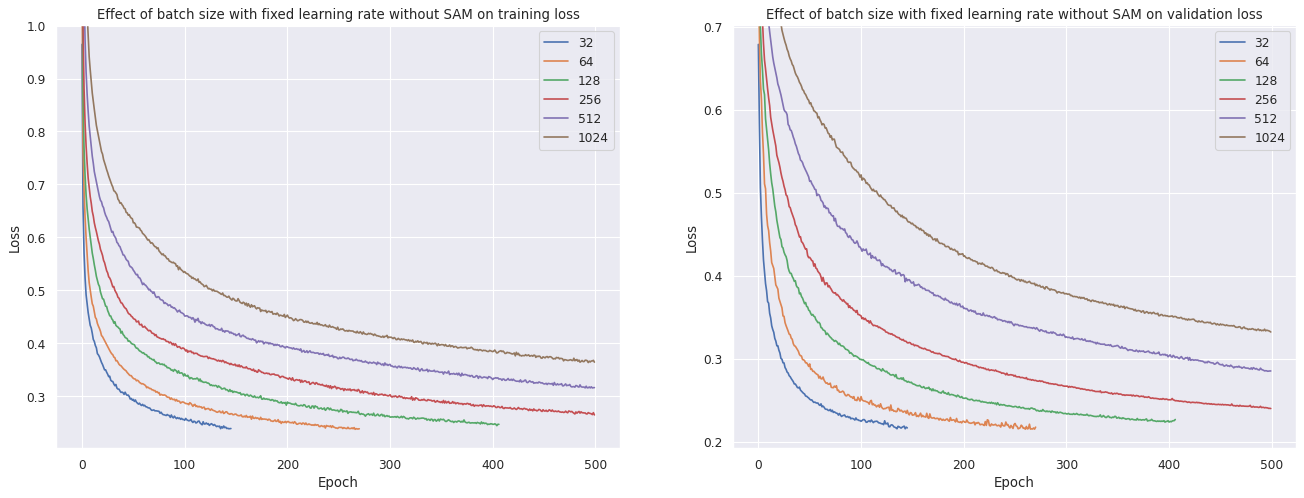

In [76]:
visualization.plot_loss_by_param(models_states[key], 'batch size with fixed learning rate without SAM',
                                 'fixed_lr_diff_bs_SGD_noSAM')

#### Sharpness

In [77]:
if RETRAIN_FLAG:
    for batch_size in batch_sizes:
        model = models[key + (batch_size,)]

        sharpness_bs = visualization.get_sharpness(model, train)
        sharpnesses[key + (batch_size,)] = sharpness_bs

        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG:
    sharpnesses = ml_utils.load_sharpnesses_dict()

 7/47 [===>..........................] - ETA: 0s - loss: 0.1907 - accuracy: 0.9333

2022-02-26 02:19:10.014059: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 13ms/step - loss: 0.1893 - accuracy: 0.9353
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.89322D-01    |proj g|=  2.27259D-02
47/47 [==============================] - 1s 12ms/step - loss: 1.0789 - accuracy: 0.6578

At iterate    1    f= -1.07891D+00    |proj g|=  4.30467D-02
  ys=-5.079E+01  -gs= 6.663E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 4.2356 - accuracy: 0.3716

At iterate    2    f= -4.23562D+00    |proj g|=  4.54519D-02
  ys=-2.337E+02  -gs= 4.118E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 7.2829 - accuracy: 0.3221

At iterate    3    f= -7.28292D+00    |proj g|=  3.85073D-02
  ys=-1.688E+02  -gs= 7.230E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 8.5857 - accura


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 11ms/step - loss: 9.2051 - accuracy: 0.3136

At iterate   10    f= -9.20508D+00    |proj g|=  3.85073D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786     10     12  72035     5 57399   3.851D-02  -9.205D+00
  F =  -9.2050828933715820     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
 7/47 [===>..........................] - ETA: 0s - loss: 0.1915 - accuracy: 0.9326

2022-02-26 02:19:36.586695: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 12ms/step - loss: 0.1896 - accuracy: 0.9354
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.89592D-01    |proj g|=  2.25666D-02
47/47 [==============================] - 1s 12ms/step - loss: 2.9051 - accuracy: 0.4575

At iterate    1    f= -2.90507D+00    |proj g|=  3.71610D-02
  ys=-1.875E+02  -gs= 8.304E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 13ms/step - loss: 9.6687 - accuracy: 0.2948

At iterate    2    f= -9.66872D+00    |proj g|=  3.96279D-02
  ys=-3.978E+02  -gs= 1.536E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 11.5607 - accuracy: 0.3005

At iterate    3    f= -1.15607D+01    |proj g|=  3.96279D-02
  ys=-9.695E+01  -gs= 4.845E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 12.0201 - accu

2022-02-26 02:20:00.670140: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 13ms/step - loss: 0.2020 - accuracy: 0.9307
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.01988D-01    |proj g|=  2.16228D-02
47/47 [==============================] - 1s 11ms/step - loss: 2.1779 - accuracy: 0.4334

At iterate    1    f= -2.17786D+00    |proj g|=  4.32456D-02
  ys=-8.666E+01  -gs= 8.708E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 10.6399 - accuracy: 0.2950

At iterate    2    f= -1.06399D+01    |proj g|=  4.18742D-02
  ys=-5.763E+02  -gs= 1.447E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 14.2614 - accuracy: 0.2959

At iterate    3    f= -1.42614D+01    |proj g|=  4.18742D-02
  ys=-5.176E+01  -gs= 1.380E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 14.4816 - acc


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 11ms/step - loss: 14.6332 - accuracy: 0.2961

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      8     10  69647     3 58803   3.732D-02  -1.461D+01
  F =  -14.614955902099609     

ABNORMAL_TERMINATION_IN_LNSRCH                              
 1/47 [..............................] - ETA: 6s - loss: 0.1991 - accuracy: 0.9336


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
2022-02-26 02:20:22.791788: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 12ms/step - loss: 0.2226 - accuracy: 0.9240
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.22644D-01    |proj g|=  1.97724D-02
47/47 [==============================] - 1s 11ms/step - loss: 5.0100 - accuracy: 0.2950

At iterate    1    f= -5.01004D+00    |proj g|=  3.41339D-02
  ys=-2.474E+02  -gs= 1.164E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 17.8424 - accuracy: 0.2405

At iterate    2    f= -1.78424D+01    |proj g|=  3.41339D-02
  ys=-8.789E+02  -gs= 2.499E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 20.5648 - accuracy: 0.2141

At iterate    3    f= -2.05648D+01    |proj g|=  3.16812D-02
  ys=-7.086E+01  -gs= 1.009E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 22.8370 - acc

2022-02-26 02:20:46.867541: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 12ms/step - loss: 0.2787 - accuracy: 0.9041
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.78747D-01    |proj g|=  1.84926D-02
47/47 [==============================] - 1s 11ms/step - loss: 8.0804 - accuracy: 0.2991

At iterate    1    f= -8.08045D+00    |proj g|=  2.97201D-02
  ys=-3.440E+02  -gs= 3.372E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 23.3503 - accuracy: 0.2890

At iterate    2    f= -2.33503D+01    |proj g|=  2.88222D-02
  ys=-9.561E+02  -gs= 3.151E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 25.8750 - accuracy: 0.2889

At iterate    3    f= -2.58750D+01    |proj g|=  2.70875D-02
  ys=-4.326E+01  -gs= 1.024E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 25.9635 - acc

2022-02-26 02:21:11.272768: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 13ms/step - loss: 0.3336 - accuracy: 0.8867
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.33645D-01    |proj g|=  1.61570D-02
47/47 [==============================] - 1s 11ms/step - loss: 10.1616 - accuracy: 0.2890

At iterate    1    f= -1.01616D+01    |proj g|=  2.92421D-02
  ys=-4.851E+02  -gs= 4.461E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 27.8976 - accuracy: 0.2878

At iterate    2    f= -2.78976D+01    |proj g|=  2.80617D-02
  ys=-1.003E+03  -gs= 3.717E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 30.4967 - accuracy: 0.2881

At iterate    3    f= -3.04967D+01    |proj g|=  2.30466D-02
  ys=-6.873E+01  -gs= 8.726E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 31.4795 - ac


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


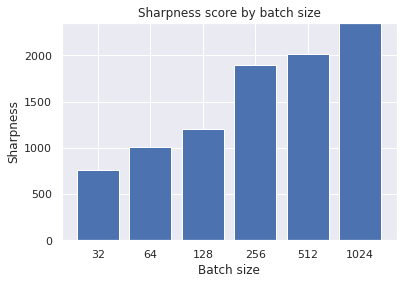

In [78]:
visualization.plot_sharpness(batch_sizes, sharpnesses, key)

#### Distance from initial weights

Batch size: 32, distance: 0.0
Batch size: 64, distance: 0.0
Batch size: 128, distance: 0.0
Batch size: 256, distance: 0.0
Batch size: 512, distance: 0.0
Batch size: 1024, distance: 0.0


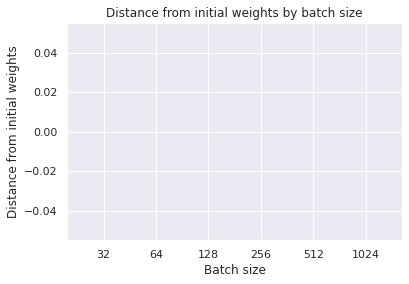

In [79]:
visualization.plot_distance_from_initial_weight(models, initial_weights, batch_sizes, key)

#### Runtime

In [80]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states,
                                                                                                     batch_sizes, key)

Batch size:  32
	Mean time per epoch:  5.370601864710246
	Converged in 135 epochs
	Overall training time (in seconds) until convergence:  725.2320516109467
Batch size:  64
	Mean time per epoch:  3.026075601577759
	Converged in 260 epochs
	Overall training time (in seconds) until convergence:  786.6333780288696
Batch size:  128
	Mean time per epoch:  2.128937932724449
	Converged in 396 epochs
	Overall training time (in seconds) until convergence:  843.623672246933
Batch size:  256
	Mean time per epoch:  1.6679143552780151
	Converged in 499 epochs
	Overall training time (in seconds) until convergence:  832.3296086788177
Batch size:  512
	Mean time per epoch:  1.428723431110382
	Converged in 496 epochs
	Overall training time (in seconds) until convergence:  708.6551997661591
Batch size:  1024
	Mean time per epoch:  1.3024159688949586
	Converged in 499 epochs
	Overall training time (in seconds) until convergence:  649.9169251918793


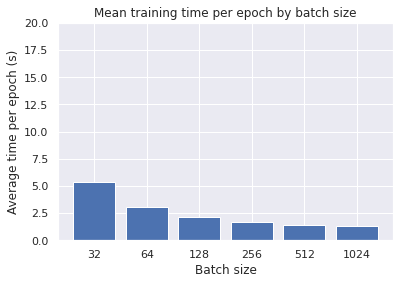

In [81]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

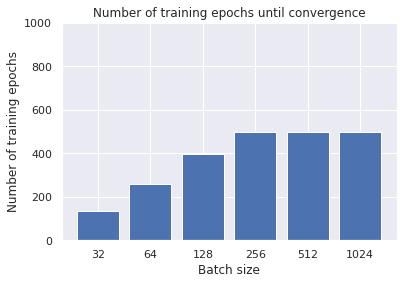

In [82]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

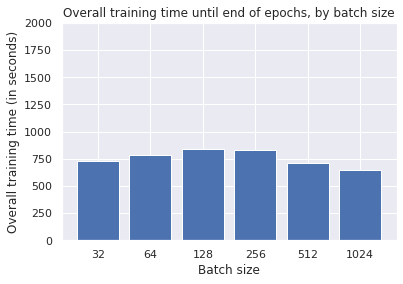

In [83]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

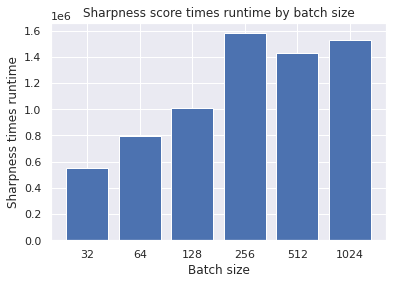

In [84]:
visualization.plot_sharpness_times_runtime(batch_sizes, overall_training_times, sharpnesses, key)

### ADAM

In [85]:
batch_sizes = [32, 64, 128, 256, 512, 1024]
lr = 0.001
training_epochs = EPOCHS

key = ('fixed', 'adam', 'none')

In [86]:
if not RETRAIN_FLAG:
    for batch_size in batch_sizes:
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                          batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.Adam(learning_rate=lr)
        model = build_and_load_model_weights(train, optimizer, filename_bs_opt_sam(batch_size, "ADAM", "NONE"))
        models[key + (batch_size,)] = model

In [87]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size in batch_sizes:
        with tf.distribute.MirroredStrategy().scope():
            # Read training data
            train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                              batch_size=batch_size,
                                                                              img_size=32)

            optimizer = keras.optimizers.Adam(learning_rate=lr)
            model = tf_models.build_and_compile_simple_cnn(train, optimizer)
            train_callbacks = callback_for_filename(filename_bs_opt_sam(batch_size, "ADAM", "NONE"))

            models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                  extra_callbacks=train_callbacks, verbose=1)
            models[key + (batch_size,)] = model
            initial_weights[key + (batch_size,)] = model.get_weights()
            ml_utils.save_initial_weights_dict(initial_weights)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 02:21:36.613153: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
1495/1500 [============================>.] - ETA: 0s - loss: 0.5816 - accuracy: 0.7875

2022-02-26 02:21:43.990172: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.38448, saving model to tmp/model_fixed_lr_diff_bs_32_opt_ADAM_sam_NONE.tf
1500/1500 [==============================] - 9s 5ms/step - loss: 0.5812 - accuracy: 0.7876 - val_loss: 0.3845 - val_accuracy: 0.8639
Epoch 2/500
1500/1500 [==============================] - ETA: 0s - loss: 0.4196 - accuracy: 0.8498
Epoch 2: val_loss improved from 0.38448 to 0.33294, saving model to tmp/model_fixed_lr_diff_bs_32_opt_ADAM_sam_NONE.tf
1500/1500 [==============================] - 5s 4ms/step - loss: 0.4196 - accuracy: 0.8498 - val_loss: 0.3329 - val_accuracy: 0.8806
Epoch 3/500
1490/1500 [============================>.] - ETA: 0s - loss: 0.3785 - accuracy: 0.8648
Epoch 3: val_loss improved from 0.33294 to 0.31088, saving model to tmp/model_fixed_lr_diff_bs_32_opt_ADAM_sam_NONE.tf
1500/1500 [==============================] - 5s 4ms/step - loss: 0.3777 - accuracy: 0.8650 - val_loss: 0.3109 - val_accuracy: 0.8905
Epoch 4/500
1491/1500 [==========================

1500/1500 [==============================] - 5s 4ms/step - loss: 0.2566 - accuracy: 0.9062 - val_loss: 0.2194 - val_accuracy: 0.9214
Epoch 27/500
1486/1500 [============================>.] - ETA: 0s - loss: 0.2563 - accuracy: 0.9069
Epoch 27: val_loss did not improve from 0.21935
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2558 - accuracy: 0.9070 - val_loss: 0.2203 - val_accuracy: 0.9216
Epoch 28/500
1500/1500 [==============================] - ETA: 0s - loss: 0.2572 - accuracy: 0.9064
Epoch 28: val_loss did not improve from 0.21935
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2572 - accuracy: 0.9064 - val_loss: 0.2380 - val_accuracy: 0.9168
Epoch 29/500
1488/1500 [============================>.] - ETA: 0s - loss: 0.2545 - accuracy: 0.9065
Epoch 29: val_loss did not improve from 0.21935
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2542 - accuracy: 0.9066 - val_loss: 0.2284 - val_accuracy: 0.9215
Epoch 30/500
1488/1500 [

1500/1500 [==============================] - 5s 4ms/step - loss: 0.2395 - accuracy: 0.9111 - val_loss: 0.2191 - val_accuracy: 0.9223
Epoch 55/500
1488/1500 [============================>.] - ETA: 0s - loss: 0.2414 - accuracy: 0.9122
Epoch 55: val_loss did not improve from 0.21529
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2409 - accuracy: 0.9125 - val_loss: 0.2228 - val_accuracy: 0.9192
Epoch 56/500
1493/1500 [============================>.] - ETA: 0s - loss: 0.2386 - accuracy: 0.9117
Epoch 56: val_loss did not improve from 0.21529
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2386 - accuracy: 0.9117 - val_loss: 0.2170 - val_accuracy: 0.9212
Epoch 57/500
1499/1500 [============================>.] - ETA: 0s - loss: 0.2411 - accuracy: 0.9108
Epoch 57: val_loss improved from 0.21529 to 0.21322, saving model to tmp/model_fixed_lr_diff_bs_32_opt_ADAM_sam_NONE.tf
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2411 - accuracy: 0

Epoch 83/500
1487/1500 [============================>.] - ETA: 0s - loss: 0.2375 - accuracy: 0.9130
Epoch 83: val_loss did not improve from 0.21210
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2370 - accuracy: 0.9132 - val_loss: 0.2138 - val_accuracy: 0.9240
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 02:29:13.963845: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
746/750 [============================>.] - ETA: 0s - loss: 0.6113 - accuracy: 0.7777

2022-02-26 02:29:19.019878: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.40356, saving model to tmp/model_fixed_lr_diff_bs_64_opt_ADAM_sam_NONE.tf
750/750 [==============================] - 7s 6ms/step - loss: 0.6102 - accuracy: 0.7780 - val_loss: 0.4036 - val_accuracy: 0.8589
Epoch 2/500
740/750 [============================>.] - ETA: 0s - loss: 0.4332 - accuracy: 0.8453
Epoch 2: val_loss improved from 0.40356 to 0.35444, saving model to tmp/model_fixed_lr_diff_bs_64_opt_ADAM_sam_NONE.tf
750/750 [==============================] - 3s 4ms/step - loss: 0.4324 - accuracy: 0.8455 - val_loss: 0.3544 - val_accuracy: 0.8758
Epoch 3/500
745/750 [============================>.] - ETA: 0s - loss: 0.3878 - accuracy: 0.8634
Epoch 3: val_loss improved from 0.35444 to 0.32465, saving model to tmp/model_fixed_lr_diff_bs_64_opt_ADAM_sam_NONE.tf
750/750 [==============================] - 3s 4ms/step - loss: 0.3872 - accuracy: 0.8636 - val_loss: 0.3246 - val_accuracy: 0.8863
Epoch 4/500
742/750 [============================>.] - ETA:

Epoch 26/500
750/750 [==============================] - ETA: 0s - loss: 0.2518 - accuracy: 0.9081
Epoch 26: val_loss did not improve from 0.21734
750/750 [==============================] - 3s 4ms/step - loss: 0.2518 - accuracy: 0.9081 - val_loss: 0.2175 - val_accuracy: 0.9235
Epoch 27/500
735/750 [============================>.] - ETA: 0s - loss: 0.2521 - accuracy: 0.9077
Epoch 27: val_loss did not improve from 0.21734
750/750 [==============================] - 3s 4ms/step - loss: 0.2518 - accuracy: 0.9077 - val_loss: 0.2183 - val_accuracy: 0.9238
Epoch 28/500
740/750 [============================>.] - ETA: 0s - loss: 0.2464 - accuracy: 0.9096
Epoch 28: val_loss improved from 0.21734 to 0.21440, saving model to tmp/model_fixed_lr_diff_bs_64_opt_ADAM_sam_NONE.tf
750/750 [==============================] - 3s 4ms/step - loss: 0.2459 - accuracy: 0.9097 - val_loss: 0.2144 - val_accuracy: 0.9246
Epoch 29/500
746/750 [============================>.] - ETA: 0s - loss: 0.2438 - accuracy: 0.9102

750/750 [==============================] - 3s 4ms/step - loss: 0.2319 - accuracy: 0.9153 - val_loss: 0.2099 - val_accuracy: 0.9246
Epoch 54/500
744/750 [============================>.] - ETA: 0s - loss: 0.2292 - accuracy: 0.9149
Epoch 54: val_loss improved from 0.20572 to 0.20469, saving model to tmp/model_fixed_lr_diff_bs_64_opt_ADAM_sam_NONE.tf
750/750 [==============================] - 3s 4ms/step - loss: 0.2288 - accuracy: 0.9152 - val_loss: 0.2047 - val_accuracy: 0.9273
Epoch 55/500
749/750 [============================>.] - ETA: 0s - loss: 0.2269 - accuracy: 0.9162
Epoch 55: val_loss improved from 0.20469 to 0.20387, saving model to tmp/model_fixed_lr_diff_bs_64_opt_ADAM_sam_NONE.tf
750/750 [==============================] - 3s 4ms/step - loss: 0.2269 - accuracy: 0.9161 - val_loss: 0.2039 - val_accuracy: 0.9263
Epoch 56/500
745/750 [============================>.] - ETA: 0s - loss: 0.2325 - accuracy: 0.9136
Epoch 56: val_loss did not improve from 0.20387
750/750 [================

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Epoch 1/500


2022-02-26 02:33:02.303579: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


374/375 [============================>.] - ETA: 0s - loss: 0.6852 - accuracy: 0.7480

2022-02-26 02:33:05.659511: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.46193, saving model to tmp/model_fixed_lr_diff_bs_128_opt_ADAM_sam_NONE.tf
375/375 [==============================] - 5s 9ms/step - loss: 0.6847 - accuracy: 0.7482 - val_loss: 0.4619 - val_accuracy: 0.8320
Epoch 2/500
372/375 [============================>.] - ETA: 0s - loss: 0.4645 - accuracy: 0.8336
Epoch 2: val_loss improved from 0.46193 to 0.41459, saving model to tmp/model_fixed_lr_diff_bs_128_opt_ADAM_sam_NONE.tf
375/375 [==============================] - 2s 6ms/step - loss: 0.4638 - accuracy: 0.8337 - val_loss: 0.4146 - val_accuracy: 0.8497
Epoch 3/500
365/375 [============================>.] - ETA: 0s - loss: 0.4174 - accuracy: 0.8530
Epoch 3: val_loss improved from 0.41459 to 0.36139, saving model to tmp/model_fixed_lr_diff_bs_128_opt_ADAM_sam_NONE.tf
375/375 [==============================] - 2s 6ms/step - loss: 0.4165 - accuracy: 0.8531 - val_loss: 0.3614 - val_accuracy: 0.8719
Epoch 4/500
364/375 [============================>.] - E

371/375 [============================>.] - ETA: 0s - loss: 0.2547 - accuracy: 0.9073
Epoch 25: val_loss did not improve from 0.22141
375/375 [==============================] - 2s 6ms/step - loss: 0.2544 - accuracy: 0.9074 - val_loss: 0.2261 - val_accuracy: 0.9178
Epoch 26/500
366/375 [============================>.] - ETA: 0s - loss: 0.2537 - accuracy: 0.9074
Epoch 26: val_loss did not improve from 0.22141
375/375 [==============================] - 2s 5ms/step - loss: 0.2535 - accuracy: 0.9075 - val_loss: 0.2228 - val_accuracy: 0.9209
Epoch 27/500
369/375 [============================>.] - ETA: 0s - loss: 0.2536 - accuracy: 0.9079
Epoch 27: val_loss improved from 0.22141 to 0.21825, saving model to tmp/model_fixed_lr_diff_bs_128_opt_ADAM_sam_NONE.tf
375/375 [==============================] - 2s 5ms/step - loss: 0.2530 - accuracy: 0.9080 - val_loss: 0.2183 - val_accuracy: 0.9213
Epoch 28/500
368/375 [============================>.] - ETA: 0s - loss: 0.2487 - accuracy: 0.9106
Epoch 28: v

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 02:34:52.250028: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
184/188 [============================>.] - ETA: 0s - loss: 0.8041 - accuracy: 0.7037

2022-02-26 02:34:56.247273: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.51036, saving model to tmp/model_fixed_lr_diff_bs_256_opt_ADAM_sam_NONE.tf
188/188 [==============================] - 5s 11ms/step - loss: 0.7994 - accuracy: 0.7053 - val_loss: 0.5104 - val_accuracy: 0.8180
Epoch 2/500
183/188 [============================>.] - ETA: 0s - loss: 0.5127 - accuracy: 0.8119
Epoch 2: val_loss improved from 0.51036 to 0.43240, saving model to tmp/model_fixed_lr_diff_bs_256_opt_ADAM_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.5118 - accuracy: 0.8123 - val_loss: 0.4324 - val_accuracy: 0.8501
Epoch 3/500
186/188 [============================>.] - ETA: 0s - loss: 0.4635 - accuracy: 0.8332
Epoch 3: val_loss improved from 0.43240 to 0.40057, saving model to tmp/model_fixed_lr_diff_bs_256_opt_ADAM_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.4630 - accuracy: 0.8333 - val_loss: 0.4006 - val_accuracy: 0.8627
Epoch 4/500
184/188 [============================>.] - 

185/188 [============================>.] - ETA: 0s - loss: 0.2695 - accuracy: 0.9031
Epoch 25: val_loss improved from 0.24099 to 0.23936, saving model to tmp/model_fixed_lr_diff_bs_256_opt_ADAM_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.2687 - accuracy: 0.9034 - val_loss: 0.2394 - val_accuracy: 0.9162
Epoch 26/500
181/188 [===========================>..] - ETA: 0s - loss: 0.2671 - accuracy: 0.9036
Epoch 26: val_loss improved from 0.23936 to 0.23575, saving model to tmp/model_fixed_lr_diff_bs_256_opt_ADAM_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.2667 - accuracy: 0.9036 - val_loss: 0.2357 - val_accuracy: 0.9176
Epoch 27/500
185/188 [============================>.] - ETA: 0s - loss: 0.2630 - accuracy: 0.9051
Epoch 27: val_loss improved from 0.23575 to 0.23557, saving model to tmp/model_fixed_lr_diff_bs_256_opt_ADAM_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.2622 - accuracy: 0.9054 - val

Epoch 52/500
185/188 [============================>.] - ETA: 0s - loss: 0.2326 - accuracy: 0.9146
Epoch 52: val_loss did not improve from 0.21496
188/188 [==============================] - 2s 9ms/step - loss: 0.2322 - accuracy: 0.9148 - val_loss: 0.2162 - val_accuracy: 0.9237
Epoch 53/500
181/188 [===========================>..] - ETA: 0s - loss: 0.2326 - accuracy: 0.9154
Epoch 53: val_loss did not improve from 0.21496
188/188 [==============================] - 2s 9ms/step - loss: 0.2330 - accuracy: 0.9150 - val_loss: 0.2193 - val_accuracy: 0.9214
Epoch 54/500
186/188 [============================>.] - ETA: 0s - loss: 0.2330 - accuracy: 0.9153
Epoch 54: val_loss improved from 0.21496 to 0.21233, saving model to tmp/model_fixed_lr_diff_bs_256_opt_ADAM_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.2324 - accuracy: 0.9156 - val_loss: 0.2123 - val_accuracy: 0.9262
Epoch 55/500
182/188 [============================>.] - ETA: 0s - loss: 0.2308 - accuracy: 0.915

181/188 [===========================>..] - ETA: 0s - loss: 0.2177 - accuracy: 0.9196
Epoch 80: val_loss did not improve from 0.20522
188/188 [==============================] - 2s 9ms/step - loss: 0.2171 - accuracy: 0.9195 - val_loss: 0.2072 - val_accuracy: 0.9260
Epoch 81/500
186/188 [============================>.] - ETA: 0s - loss: 0.2179 - accuracy: 0.9207
Epoch 81: val_loss did not improve from 0.20522
188/188 [==============================] - 2s 9ms/step - loss: 0.2175 - accuracy: 0.9209 - val_loss: 0.2055 - val_accuracy: 0.9250
Epoch 82/500
187/188 [============================>.] - ETA: 0s - loss: 0.2175 - accuracy: 0.9218
Epoch 82: val_loss did not improve from 0.20522
188/188 [==============================] - 2s 9ms/step - loss: 0.2175 - accuracy: 0.9218 - val_loss: 0.2056 - val_accuracy: 0.9262
Epoch 83/500
184/188 [============================>.] - ETA: 0s - loss: 0.2177 - accuracy: 0.9214
Epoch 83: val_loss improved from 0.20522 to 0.20358, saving model to tmp/model_fixed

187/188 [============================>.] - ETA: 0s - loss: 0.2084 - accuracy: 0.9238
Epoch 107: val_loss did not improve from 0.19931
188/188 [==============================] - 2s 9ms/step - loss: 0.2084 - accuracy: 0.9238 - val_loss: 0.2000 - val_accuracy: 0.9285
Epoch 108/500
181/188 [===========================>..] - ETA: 0s - loss: 0.2089 - accuracy: 0.9235
Epoch 108: val_loss did not improve from 0.19931
188/188 [==============================] - 2s 9ms/step - loss: 0.2080 - accuracy: 0.9236 - val_loss: 0.2014 - val_accuracy: 0.9258
Epoch 109/500
183/188 [============================>.] - ETA: 0s - loss: 0.2074 - accuracy: 0.9234
Epoch 109: val_loss did not improve from 0.19931
188/188 [==============================] - 2s 9ms/step - loss: 0.2077 - accuracy: 0.9232 - val_loss: 0.2020 - val_accuracy: 0.9274
Epoch 110/500
182/188 [============================>.] - ETA: 0s - loss: 0.2095 - accuracy: 0.9240
Epoch 110: val_loss improved from 0.19931 to 0.19765, saving model to tmp/mode

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 02:38:36.500782: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
92/94 [============================>.] - ETA: 0s - loss: 0.9460 - accuracy: 0.6537

2022-02-26 02:38:39.342473: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.59786, saving model to tmp/model_fixed_lr_diff_bs_512_opt_ADAM_sam_NONE.tf
94/94 [==============================] - 4s 31ms/step - loss: 0.9399 - accuracy: 0.6558 - val_loss: 0.5979 - val_accuracy: 0.7955
Epoch 2/500
93/94 [============================>.] - ETA: 0s - loss: 0.5759 - accuracy: 0.7904
Epoch 2: val_loss improved from 0.59786 to 0.49730, saving model to tmp/model_fixed_lr_diff_bs_512_opt_ADAM_sam_NONE.tf
94/94 [==============================] - 1s 16ms/step - loss: 0.5754 - accuracy: 0.7905 - val_loss: 0.4973 - val_accuracy: 0.8266
Epoch 3/500
90/94 [===========================>..] - ETA: 0s - loss: 0.5112 - accuracy: 0.8163
Epoch 3: val_loss improved from 0.49730 to 0.44670, saving model to tmp/model_fixed_lr_diff_bs_512_opt_ADAM_sam_NONE.tf
94/94 [==============================] - 1s 15ms/step - loss: 0.5100 - accuracy: 0.8165 - val_loss: 0.4467 - val_accuracy: 0.8442
Epoch 4/500
93/94 [============================>.] - ETA: 0s - 

Epoch 25/500
93/94 [============================>.] - ETA: 0s - loss: 0.2949 - accuracy: 0.8947
Epoch 25: val_loss improved from 0.25690 to 0.25631, saving model to tmp/model_fixed_lr_diff_bs_512_opt_ADAM_sam_NONE.tf
94/94 [==============================] - 1s 15ms/step - loss: 0.2943 - accuracy: 0.8951 - val_loss: 0.2563 - val_accuracy: 0.9109
Epoch 26/500
93/94 [============================>.] - ETA: 0s - loss: 0.2933 - accuracy: 0.8953
Epoch 26: val_loss improved from 0.25631 to 0.25291, saving model to tmp/model_fixed_lr_diff_bs_512_opt_ADAM_sam_NONE.tf
94/94 [==============================] - 1s 15ms/step - loss: 0.2928 - accuracy: 0.8955 - val_loss: 0.2529 - val_accuracy: 0.9130
Epoch 27/500
91/94 [============================>.] - ETA: 0s - loss: 0.2872 - accuracy: 0.8980
Epoch 27: val_loss improved from 0.25291 to 0.25252, saving model to tmp/model_fixed_lr_diff_bs_512_opt_ADAM_sam_NONE.tf
94/94 [==============================] - 1s 15ms/step - loss: 0.2863 - accuracy: 0.8981 -

94/94 [==============================] - 1s 15ms/step - loss: 0.2490 - accuracy: 0.9098 - val_loss: 0.2209 - val_accuracy: 0.9232
Epoch 51/500
91/94 [============================>.] - ETA: 0s - loss: 0.2455 - accuracy: 0.9123
Epoch 51: val_loss did not improve from 0.22088
94/94 [==============================] - 1s 15ms/step - loss: 0.2450 - accuracy: 0.9125 - val_loss: 0.2269 - val_accuracy: 0.9193
Epoch 52/500
91/94 [============================>.] - ETA: 0s - loss: 0.2493 - accuracy: 0.9112
Epoch 52: val_loss did not improve from 0.22088
94/94 [==============================] - 1s 15ms/step - loss: 0.2485 - accuracy: 0.9115 - val_loss: 0.2256 - val_accuracy: 0.9208
Epoch 53/500
94/94 [==============================] - ETA: 0s - loss: 0.2446 - accuracy: 0.9116
Epoch 53: val_loss did not improve from 0.22088
94/94 [==============================] - 1s 15ms/step - loss: 0.2446 - accuracy: 0.9116 - val_loss: 0.2233 - val_accuracy: 0.9204
Epoch 54/500
93/94 [============================

Epoch 79/500
93/94 [============================>.] - ETA: 0s - loss: 0.2277 - accuracy: 0.9172
Epoch 79: val_loss did not improve from 0.20878
94/94 [==============================] - 1s 15ms/step - loss: 0.2271 - accuracy: 0.9174 - val_loss: 0.2090 - val_accuracy: 0.9248
Epoch 80/500
91/94 [============================>.] - ETA: 0s - loss: 0.2300 - accuracy: 0.9178
Epoch 80: val_loss did not improve from 0.20878
94/94 [==============================] - 2s 20ms/step - loss: 0.2296 - accuracy: 0.9179 - val_loss: 0.2090 - val_accuracy: 0.9253
Epoch 81/500
90/94 [===========================>..] - ETA: 0s - loss: 0.2267 - accuracy: 0.9177
Epoch 81: val_loss improved from 0.20878 to 0.20868, saving model to tmp/model_fixed_lr_diff_bs_512_opt_ADAM_sam_NONE.tf
94/94 [==============================] - 1s 16ms/step - loss: 0.2257 - accuracy: 0.9179 - val_loss: 0.2087 - val_accuracy: 0.9260
Epoch 82/500
90/94 [===========================>..] - ETA: 0s - loss: 0.2259 - accuracy: 0.9163
Epoch 82:

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 02:41:03.571104: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
46/47 [============================>.] - ETA: 0s - loss: 1.1423 - accuracy: 0.5828

2022-02-26 02:41:07.300877: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.71690, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_ADAM_sam_NONE.tf
47/47 [==============================] - 5s 60ms/step - loss: 1.1348 - accuracy: 0.5854 - val_loss: 0.7169 - val_accuracy: 0.7620
Epoch 2/500
46/47 [============================>.] - ETA: 0s - loss: 0.6737 - accuracy: 0.7573
Epoch 2: val_loss improved from 0.71690 to 0.56324, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_ADAM_sam_NONE.tf
47/47 [==============================] - 1s 28ms/step - loss: 0.6714 - accuracy: 0.7579 - val_loss: 0.5632 - val_accuracy: 0.8052
Epoch 3/500
46/47 [============================>.] - ETA: 0s - loss: 0.5650 - accuracy: 0.7979
Epoch 3: val_loss improved from 0.56324 to 0.48990, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_ADAM_sam_NONE.tf
47/47 [==============================] - 1s 28ms/step - loss: 0.5641 - accuracy: 0.7980 - val_loss: 0.4899 - val_accuracy: 0.8298
Epoch 4/500
46/47 [============================>.] - ETA: 0s

Epoch 25/500
46/47 [============================>.] - ETA: 0s - loss: 0.3209 - accuracy: 0.8868
Epoch 25: val_loss improved from 0.28304 to 0.27802, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_ADAM_sam_NONE.tf
47/47 [==============================] - 1s 29ms/step - loss: 0.3203 - accuracy: 0.8868 - val_loss: 0.2780 - val_accuracy: 0.9032
Epoch 26/500
46/47 [============================>.] - ETA: 0s - loss: 0.3187 - accuracy: 0.8864
Epoch 26: val_loss improved from 0.27802 to 0.27707, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_ADAM_sam_NONE.tf
47/47 [==============================] - 1s 28ms/step - loss: 0.3180 - accuracy: 0.8866 - val_loss: 0.2771 - val_accuracy: 0.9038
Epoch 27/500
46/47 [============================>.] - ETA: 0s - loss: 0.3137 - accuracy: 0.8890
Epoch 27: val_loss improved from 0.27707 to 0.27458, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_ADAM_sam_NONE.tf
47/47 [==============================] - 1s 28ms/step - loss: 0.3129 - accuracy: 0.889

Epoch 50/500
46/47 [============================>.] - ETA: 0s - loss: 0.2688 - accuracy: 0.9040
Epoch 50: val_loss did not improve from 0.23785
47/47 [==============================] - 1s 27ms/step - loss: 0.2682 - accuracy: 0.9041 - val_loss: 0.2388 - val_accuracy: 0.9167
Epoch 51/500
46/47 [============================>.] - ETA: 0s - loss: 0.2648 - accuracy: 0.9050
Epoch 51: val_loss did not improve from 0.23785
47/47 [==============================] - 1s 27ms/step - loss: 0.2642 - accuracy: 0.9051 - val_loss: 0.2388 - val_accuracy: 0.9157
Epoch 52/500
46/47 [============================>.] - ETA: 0s - loss: 0.2669 - accuracy: 0.9045
Epoch 52: val_loss did not improve from 0.23785
47/47 [==============================] - 1s 28ms/step - loss: 0.2662 - accuracy: 0.9047 - val_loss: 0.2385 - val_accuracy: 0.9159
Epoch 53/500
46/47 [============================>.] - ETA: 0s - loss: 0.2623 - accuracy: 0.9056
Epoch 53: val_loss improved from 0.23785 to 0.23461, saving model to tmp/model_fix

47/47 [==============================] - 1s 29ms/step - loss: 0.2401 - accuracy: 0.9128 - val_loss: 0.2174 - val_accuracy: 0.9243
Epoch 77/500
46/47 [============================>.] - ETA: 0s - loss: 0.2417 - accuracy: 0.9125
Epoch 77: val_loss did not improve from 0.21737
47/47 [==============================] - 1s 28ms/step - loss: 0.2409 - accuracy: 0.9128 - val_loss: 0.2187 - val_accuracy: 0.9219
Epoch 78/500
46/47 [============================>.] - ETA: 0s - loss: 0.2409 - accuracy: 0.9136
Epoch 78: val_loss did not improve from 0.21737
47/47 [==============================] - 1s 28ms/step - loss: 0.2402 - accuracy: 0.9139 - val_loss: 0.2188 - val_accuracy: 0.9226
Epoch 79/500
46/47 [============================>.] - ETA: 0s - loss: 0.2409 - accuracy: 0.9126
Epoch 79: val_loss did not improve from 0.21737
47/47 [==============================] - 1s 27ms/step - loss: 0.2403 - accuracy: 0.9128 - val_loss: 0.2187 - val_accuracy: 0.9222
Epoch 80/500
46/47 [============================

Epoch 104/500
46/47 [============================>.] - ETA: 0s - loss: 0.2265 - accuracy: 0.9173
Epoch 104: val_loss did not improve from 0.20950
47/47 [==============================] - 1s 27ms/step - loss: 0.2261 - accuracy: 0.9174 - val_loss: 0.2112 - val_accuracy: 0.9258
Epoch 105/500
46/47 [============================>.] - ETA: 0s - loss: 0.2243 - accuracy: 0.9181
Epoch 105: val_loss did not improve from 0.20950
47/47 [==============================] - 1s 27ms/step - loss: 0.2239 - accuracy: 0.9184 - val_loss: 0.2095 - val_accuracy: 0.9260
Epoch 106/500
46/47 [============================>.] - ETA: 0s - loss: 0.2283 - accuracy: 0.9176
Epoch 106: val_loss improved from 0.20950 to 0.20885, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_ADAM_sam_NONE.tf
47/47 [==============================] - 1s 28ms/step - loss: 0.2275 - accuracy: 0.9178 - val_loss: 0.2088 - val_accuracy: 0.9245
Epoch 107/500
46/47 [============================>.] - ETA: 0s - loss: 0.2262 - accuracy: 0.9176
E

46/47 [============================>.] - ETA: 0s - loss: 0.2199 - accuracy: 0.9195
Epoch 132: val_loss did not improve from 0.20451
47/47 [==============================] - 1s 27ms/step - loss: 0.2192 - accuracy: 0.9197 - val_loss: 0.2067 - val_accuracy: 0.9268
Epoch 133/500
46/47 [============================>.] - ETA: 0s - loss: 0.2187 - accuracy: 0.9203
Epoch 133: val_loss did not improve from 0.20451
47/47 [==============================] - 1s 28ms/step - loss: 0.2179 - accuracy: 0.9207 - val_loss: 0.2055 - val_accuracy: 0.9277
Epoch 134/500
46/47 [============================>.] - ETA: 0s - loss: 0.2178 - accuracy: 0.9199
Epoch 134: val_loss did not improve from 0.20451
47/47 [==============================] - 1s 27ms/step - loss: 0.2171 - accuracy: 0.9202 - val_loss: 0.2055 - val_accuracy: 0.9266
Epoch 135/500
46/47 [============================>.] - ETA: 0s - loss: 0.2176 - accuracy: 0.9202
Epoch 135: val_loss improved from 0.20451 to 0.20406, saving model to tmp/model_fixed_lr_

Epoch 160/500
46/47 [============================>.] - ETA: 0s - loss: 0.2103 - accuracy: 0.9217
Epoch 160: val_loss did not improve from 0.19945
47/47 [==============================] - 1s 27ms/step - loss: 0.2095 - accuracy: 0.9220 - val_loss: 0.2009 - val_accuracy: 0.9277
Epoch 161/500
46/47 [============================>.] - ETA: 0s - loss: 0.2140 - accuracy: 0.9216
Epoch 161: val_loss did not improve from 0.19945
47/47 [==============================] - 1s 28ms/step - loss: 0.2133 - accuracy: 0.9219 - val_loss: 0.1995 - val_accuracy: 0.9299
Epoch 162/500
46/47 [============================>.] - ETA: 0s - loss: 0.2067 - accuracy: 0.9249
Epoch 162: val_loss improved from 0.19945 to 0.19912, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_ADAM_sam_NONE.tf
47/47 [==============================] - 1s 28ms/step - loss: 0.2060 - accuracy: 0.9251 - val_loss: 0.1991 - val_accuracy: 0.9299
Epoch 163/500
46/47 [============================>.] - ETA: 0s - loss: 0.2095 - accuracy: 0.9224
E

46/47 [============================>.] - ETA: 0s - loss: 0.2076 - accuracy: 0.9229
Epoch 188: val_loss did not improve from 0.19638
47/47 [==============================] - 1s 28ms/step - loss: 0.2071 - accuracy: 0.9231 - val_loss: 0.1975 - val_accuracy: 0.9313


In [88]:
state_filename = 'model_fixed_lr_diff_bs_ADAM_noSAM_state'

In [89]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], state_filename)
else:
    models_states[key] = ml_utils.load_model_state(state_filename)

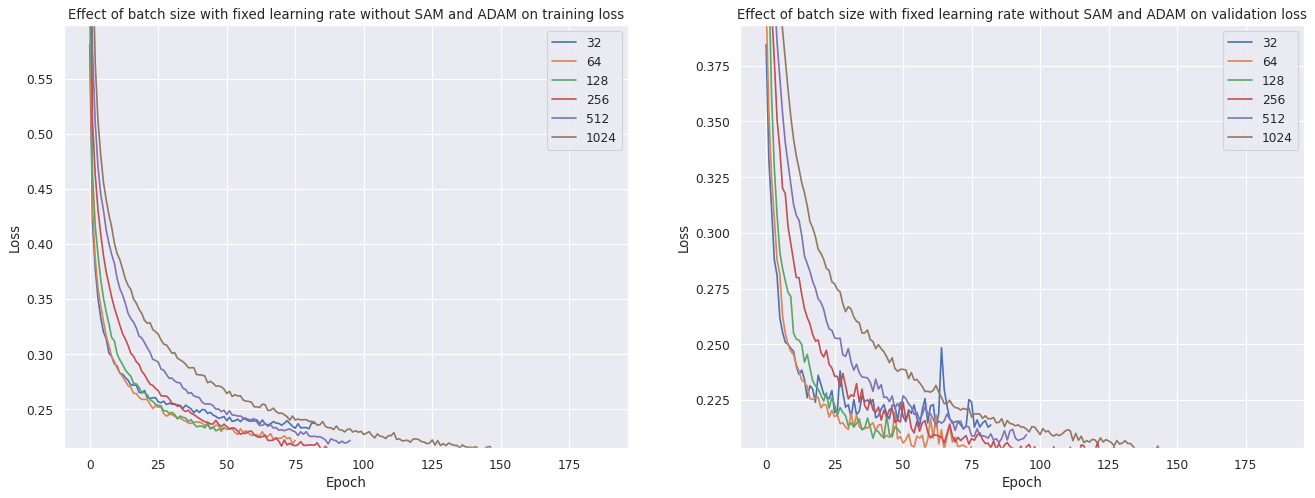

In [90]:
visualization.plot_loss_by_param(models_states[key], 'batch size with fixed learning rate without SAM and ADAM',
                                 'fixed_lr_diff_bs_ADAM_noSAM')

#### Sharpness

In [91]:
if RETRAIN_FLAG:
    for batch_size in batch_sizes:
        model = models[key + (batch_size,)]

        sharpness_bs = visualization.get_sharpness(model, train)
        sharpnesses[key + (batch_size,)] = sharpness_bs

        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG:
    sharpnesses = ml_utils.load_sharpnesses_dict()

 7/47 [===>..........................] - ETA: 0s - loss: 0.1658 - accuracy: 0.9435

2022-02-26 02:45:26.384647: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 11ms/step - loss: 0.1633 - accuracy: 0.9448
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.63268D-01    |proj g|=  2.38178D-02
47/47 [==============================] - 1s 12ms/step - loss: 0.5863 - accuracy: 0.7721

At iterate    1    f= -5.86295D-01    |proj g|=  3.34728D-02
  ys=-3.609E+01  -gs= 4.179E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 0.9261 - accuracy: 0.6676

At iterate    2    f= -9.26075D-01    |proj g|=  3.26142D-02
  ys=-8.968E+00  -gs= 1.057E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 0.9547 - accuracy: 0.6609

At iterate    3    f= -9.54651D-01    |proj g|=  2.79428D-02
  ys=-1.438E+00  -gs= 7.493E-01 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 0.9755 - accura

2022-02-26 02:45:50.559624: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 13ms/step - loss: 0.1552 - accuracy: 0.9476
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.55161D-01    |proj g|=  1.77018D-02
47/47 [==============================] - 1s 11ms/step - loss: 0.6288 - accuracy: 0.7465

At iterate    1    f= -6.28812D-01    |proj g|=  2.67586D-02
  ys=-3.703E+01  -gs= 3.539E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 0.9537 - accuracy: 0.6563

At iterate    2    f= -9.53653D-01    |proj g|=  3.39684D-02
  ys=-8.330E+00  -gs= 9.935E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 1.0262 - accuracy: 0.6365

At iterate    3    f= -1.02619D+00    |proj g|=  2.51683D-02
  ys=-1.050E+00  -gs= 2.794E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 1.0370 - accura

2022-02-26 02:46:14.386790: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 13ms/step - loss: 0.1739 - accuracy: 0.9407
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.73917D-01    |proj g|=  1.80957D-02
47/47 [==============================] - 1s 11ms/step - loss: 0.6238 - accuracy: 0.7556

At iterate    1    f= -6.23750D-01    |proj g|=  2.69866D-02
  ys=-2.709E+01  -gs= 5.192E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 0.8551 - accuracy: 0.6969

At iterate    2    f= -8.55109D-01    |proj g|=  3.02896D-02
  ys=-5.606E+00  -gs= 7.782E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 0.9166 - accuracy: 0.6681

At iterate    3    f= -9.16553D-01    |proj g|=  3.14882D-02
  ys=-3.827E+00  -gs= 1.857E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 0.9530 - accura

2022-02-26 02:46:38.148716: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 12ms/step - loss: 0.1425 - accuracy: 0.9529
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.42491D-01    |proj g|=  1.73665D-02
47/47 [==============================] - 1s 11ms/step - loss: 0.7103 - accuracy: 0.6974

At iterate    1    f= -7.10278D-01    |proj g|=  3.00894D-02
  ys=-2.505E+01  -gs= 6.107E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 0.9300 - accuracy: 0.6193

At iterate    2    f= -9.29990D-01    |proj g|=  3.19327D-02
  ys=-4.848E+00  -gs= 7.436E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 1.0176 - accuracy: 0.5834

At iterate    3    f= -1.01756D+00    |proj g|=  3.54421D-02
  ys=-4.078E+00  -gs= 2.635E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 1.0893 - accura

2022-02-26 02:47:02.051981: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 13ms/step - loss: 0.1682 - accuracy: 0.9426
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.68181D-01    |proj g|=  1.70705D-02
47/47 [==============================] - 1s 11ms/step - loss: 2.2711 - accuracy: 0.5983

At iterate    1    f= -2.27115D+00    |proj g|=  2.89331D-02
  ys=-1.141E+02  -gs= 6.580E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 5.4500 - accuracy: 0.4572

At iterate    2    f= -5.45000D+00    |proj g|=  3.47072D-02
  ys=-1.668E+02  -gs= 8.147E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 5.9866 - accuracy: 0.4271

At iterate    3    f= -5.98665D+00    |proj g|=  3.27574D-02
47/47 [==============================] - 1s 12ms/step - loss: 6.0813 - accuracy: 0.4279

At iterate    4    f= -6.08128D+00    |p

2022-02-26 02:47:25.713715: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 12ms/step - loss: 0.1492 - accuracy: 0.9496
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.49201D-01    |proj g|=  1.82164D-02
47/47 [==============================] - 1s 12ms/step - loss: 0.8279 - accuracy: 0.6895

At iterate    1    f= -8.27932D-01    |proj g|=  3.04607D-02
  ys=-1.800E+01  -gs= 6.008E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 1.8325 - accuracy: 0.5653

At iterate    2    f= -1.83249D+00    |proj g|=  4.70169D-02
  ys=-6.876E+01  -gs= 1.474E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 3.7105 - accuracy: 0.5031

At iterate    3    f= -3.71055D+00    |proj g|=  3.50323D-02
  ys=-9.371E+01  -gs= 4.606E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 4.5554 - accura

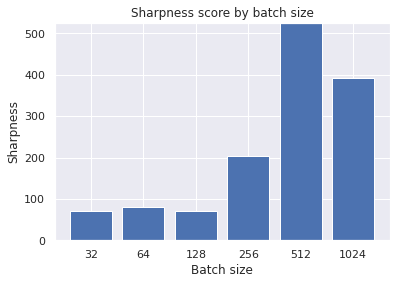

In [92]:
visualization.plot_sharpness(batch_sizes, sharpnesses, key)

#### Distance from initial weights

Batch size: 32, distance: 0.0
Batch size: 64, distance: 0.0
Batch size: 128, distance: 0.0
Batch size: 256, distance: 0.0
Batch size: 512, distance: 0.0
Batch size: 1024, distance: 0.0


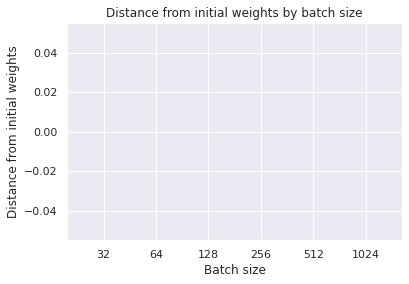

In [93]:
visualization.plot_distance_from_initial_weight(models, initial_weights, batch_sizes, key)

#### Runtime

In [94]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states,
                                                                                                     batch_sizes, key)

Batch size:  32
	Mean time per epoch:  5.443195443555533
	Converged in 72 epochs
	Overall training time (in seconds) until convergence:  392.4570939540863
Batch size:  64
	Mean time per epoch:  2.935793980171806
	Converged in 65 epochs
	Overall training time (in seconds) until convergence:  190.993905544281
Batch size:  128
	Mean time per epoch:  2.12946412563324
	Converged in 39 epochs
	Overall training time (in seconds) until convergence:  83.60860633850098
Batch size:  256
	Mean time per epoch:  1.6675274538439373
	Converged in 118 epochs
	Overall training time (in seconds) until convergence:  197.02438473701477
Batch size:  512
	Mean time per epoch:  1.4569702198108037
	Converged in 85 epochs
	Overall training time (in seconds) until convergence:  124.0362000465393
Batch size:  1024
	Mean time per epoch:  1.315465327273024
	Converged in 177 epochs
	Overall training time (in seconds) until convergence:  233.15169954299927


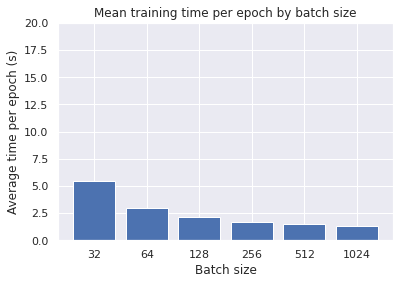

In [95]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

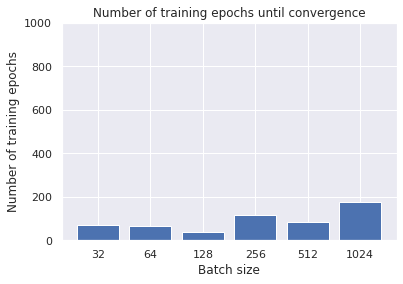

In [96]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

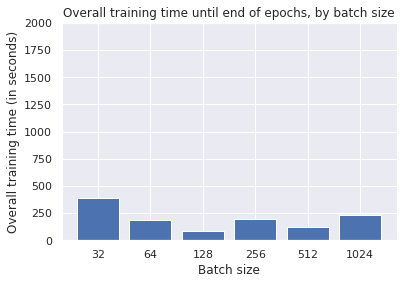

In [97]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

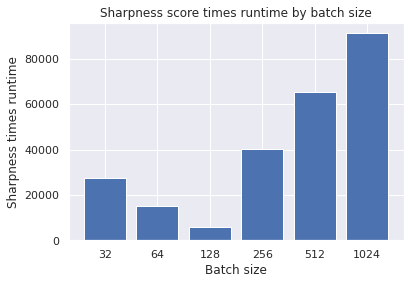

In [98]:
visualization.plot_sharpness_times_runtime(batch_sizes, overall_training_times, sharpnesses, key)

# Different batch sizes with linear increasing learning rate

## with sharpness aware minimization

### SGD with Momentum + SAM

In [99]:
learning_rates = [0.001, 0.002, 0.004, 0.008, 0.016, 0.032]
batch_sizes = [32, 64, 128, 256, 512, 1024]
training_epochs = EPOCHS

key = ('increasing', 'sgd', 'sam')

In [100]:
models_by_batch_size_diff_lr = {}
model_history_dict_diff_lr = {}

In [101]:
diff_lr_state_filename = 'model_diff_lr_diff_bs_state'

In [102]:
if not RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                          batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        model = build_and_load_sam_model_weights(train, optimizer,
                                                 filename_bs_lr_opt_sam(batch_size, lr, "SGD-MOM", "SAM"))
        models[key + (batch_size, lr)] = model

In [103]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size, lr in zip(batch_sizes, learning_rates):
        with tf.distribute.MirroredStrategy().scope():
            # Read training data
            train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                              batch_size=batch_size,
                                                                              img_size=32)

            optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
            model = tf_models.build_simple_cnn_sam(train, optimizer, adaptive=True, rho=2.0)
            train_callbacks = callback_for_filename(filename_bs_lr_opt_sam(batch_size, lr, "SGD-MOM", "SAM"))

            models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                  extra_callbacks=train_callbacks, verbose=1)
            models[key + (batch_size, lr)] = model
            initial_weights[key + (batch_size, lr)] = model.get_weights()
            ml_utils.save_initial_weights_dict(initial_weights)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 02:47:50.738705: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
1491/1500 [============================>.] - ETA: 0s - loss: 0.9779 - accuracy: 0.6219

2022-02-26 02:47:59.607274: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.56327, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 10s 5ms/step - loss: 0.9756 - accuracy: 0.6226 - val_loss: 0.5633 - val_accuracy: 0.7997
Epoch 2/500
1489/1500 [============================>.] - ETA: 0s - loss: 0.5828 - accuracy: 0.7650
Epoch 2: val_loss improved from 0.56327 to 0.45917, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.5821 - accuracy: 0.7653 - val_loss: 0.4592 - val_accuracy: 0.8389
Epoch 3/500
1492/1500 [============================>.] - ETA: 0s - loss: 0.5177 - accuracy: 0.7895
Epoch 3: val_loss improved from 0.45917 to 0.41858, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.5174 - accuracy: 0.7896 - val_loss: 0.4186 - val_accuracy: 0.8542
Epoch 4/500
1492/1500 [===================

1500/1500 [==============================] - 7s 5ms/step - loss: 0.3522 - accuracy: 0.8536 - val_loss: 0.2884 - val_accuracy: 0.9013
Epoch 25/500
1495/1500 [============================>.] - ETA: 0s - loss: 0.3497 - accuracy: 0.8545
Epoch 25: val_loss improved from 0.28836 to 0.28625, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3496 - accuracy: 0.8544 - val_loss: 0.2863 - val_accuracy: 0.9019
Epoch 26/500
1496/1500 [============================>.] - ETA: 0s - loss: 0.3473 - accuracy: 0.8552
Epoch 26: val_loss improved from 0.28625 to 0.28426, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3472 - accuracy: 0.8552 - val_loss: 0.2843 - val_accuracy: 0.9025
Epoch 27/500
1491/1500 [============================>.] - ETA: 0s - loss: 0.3452 - accuracy: 0.8561
Epoch 27: val_loss improved from 0.28426 to 0.28241, savi

Epoch 48/500
1498/1500 [============================>.] - ETA: 0s - loss: 0.3114 - accuracy: 0.8670
Epoch 48: val_loss improved from 0.25577 to 0.25474, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3115 - accuracy: 0.8670 - val_loss: 0.2547 - val_accuracy: 0.9118
Epoch 49/500
1495/1500 [============================>.] - ETA: 0s - loss: 0.3105 - accuracy: 0.8677
Epoch 49: val_loss improved from 0.25474 to 0.25379, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3104 - accuracy: 0.8677 - val_loss: 0.2538 - val_accuracy: 0.9120
Epoch 50/500
1488/1500 [============================>.] - ETA: 0s - loss: 0.3098 - accuracy: 0.8675
Epoch 50: val_loss improved from 0.25379 to 0.25303, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3

1500/1500 [==============================] - ETA: 0s - loss: 0.2908 - accuracy: 0.8731
Epoch 71: val_loss improved from 0.23956 to 0.23918, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2908 - accuracy: 0.8731 - val_loss: 0.2392 - val_accuracy: 0.9153
Epoch 72/500
1488/1500 [============================>.] - ETA: 0s - loss: 0.2904 - accuracy: 0.8735
Epoch 72: val_loss improved from 0.23918 to 0.23872, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2900 - accuracy: 0.8736 - val_loss: 0.2387 - val_accuracy: 0.9153
Epoch 73/500
1497/1500 [============================>.] - ETA: 0s - loss: 0.2893 - accuracy: 0.8741
Epoch 73: val_loss improved from 0.23872 to 0.23832, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2893 - accurac

1490/1500 [============================>.] - ETA: 0s - loss: 0.2767 - accuracy: 0.8780
Epoch 94: val_loss improved from 0.23055 to 0.23013, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2764 - accuracy: 0.8781 - val_loss: 0.2301 - val_accuracy: 0.9184
Epoch 95/500
1489/1500 [============================>.] - ETA: 0s - loss: 0.2762 - accuracy: 0.8777
Epoch 95: val_loss improved from 0.23013 to 0.22989, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2759 - accuracy: 0.8778 - val_loss: 0.2299 - val_accuracy: 0.9184
Epoch 96/500
1489/1500 [============================>.] - ETA: 0s - loss: 0.2756 - accuracy: 0.8782
Epoch 96: val_loss improved from 0.22989 to 0.22963, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2753 - accurac

1490/1500 [============================>.] - ETA: 0s - loss: 0.2658 - accuracy: 0.8814
Epoch 117: val_loss improved from 0.22408 to 0.22385, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2655 - accuracy: 0.8815 - val_loss: 0.2238 - val_accuracy: 0.9201
Epoch 118/500
1492/1500 [============================>.] - ETA: 0s - loss: 0.2653 - accuracy: 0.8817
Epoch 118: val_loss improved from 0.22385 to 0.22362, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2651 - accuracy: 0.8818 - val_loss: 0.2236 - val_accuracy: 0.9198
Epoch 119/500
1490/1500 [============================>.] - ETA: 0s - loss: 0.2648 - accuracy: 0.8823
Epoch 119: val_loss improved from 0.22362 to 0.22331, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2645 - ac

Epoch 140/500
1494/1500 [============================>.] - ETA: 0s - loss: 0.2568 - accuracy: 0.8837
Epoch 140: val_loss improved from 0.21943 to 0.21916, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2567 - accuracy: 0.8837 - val_loss: 0.2192 - val_accuracy: 0.9201
Epoch 141/500
1493/1500 [============================>.] - ETA: 0s - loss: 0.2570 - accuracy: 0.8840
Epoch 141: val_loss did not improve from 0.21916
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2569 - accuracy: 0.8840 - val_loss: 0.2192 - val_accuracy: 0.9202
Epoch 142/500
1498/1500 [============================>.] - ETA: 0s - loss: 0.2563 - accuracy: 0.8842
Epoch 142: val_loss improved from 0.21916 to 0.21910, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2563 - accuracy: 0.8842 - val_loss: 0.2191 - val_accuracy: 0.9204
Epo

1500/1500 [==============================] - 7s 5ms/step - loss: 0.2499 - accuracy: 0.8855 - val_loss: 0.2159 - val_accuracy: 0.9214
Epoch 165/500
1495/1500 [============================>.] - ETA: 0s - loss: 0.2495 - accuracy: 0.8859
Epoch 165: val_loss improved from 0.21589 to 0.21587, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2494 - accuracy: 0.8859 - val_loss: 0.2159 - val_accuracy: 0.9214
Epoch 166/500
1493/1500 [============================>.] - ETA: 0s - loss: 0.2495 - accuracy: 0.8862
Epoch 166: val_loss improved from 0.21587 to 0.21581, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2494 - accuracy: 0.8863 - val_loss: 0.2158 - val_accuracy: 0.9212
Epoch 167/500
1499/1500 [============================>.] - ETA: 0s - loss: 0.2490 - accuracy: 0.8863
Epoch 167: val_loss improved from 0.21581 to 0.21569

1495/1500 [============================>.] - ETA: 0s - loss: 0.2435 - accuracy: 0.8881
Epoch 189: val_loss improved from 0.21365 to 0.21360, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2434 - accuracy: 0.8880 - val_loss: 0.2136 - val_accuracy: 0.9227
Epoch 190/500
1491/1500 [============================>.] - ETA: 0s - loss: 0.2434 - accuracy: 0.8884
Epoch 190: val_loss improved from 0.21360 to 0.21356, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2432 - accuracy: 0.8885 - val_loss: 0.2136 - val_accuracy: 0.9224
Epoch 191/500
1493/1500 [============================>.] - ETA: 0s - loss: 0.2433 - accuracy: 0.8888
Epoch 191: val_loss improved from 0.21356 to 0.21344, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2431 - ac

1499/1500 [============================>.] - ETA: 0s - loss: 0.2388 - accuracy: 0.8903
Epoch 214: val_loss improved from 0.21231 to 0.21224, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2389 - accuracy: 0.8903 - val_loss: 0.2122 - val_accuracy: 0.9227
Epoch 215/500
1497/1500 [============================>.] - ETA: 0s - loss: 0.2384 - accuracy: 0.8909
Epoch 215: val_loss improved from 0.21224 to 0.21198, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2384 - accuracy: 0.8909 - val_loss: 0.2120 - val_accuracy: 0.9233
Epoch 216/500
1489/1500 [============================>.] - ETA: 0s - loss: 0.2386 - accuracy: 0.8903
Epoch 216: val_loss did not improve from 0.21198
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2383 - accuracy: 0.8904 - val_loss: 0.2120 - val_accuracy: 0.9231
Epoch 217/500
149

1492/1500 [============================>.] - ETA: 0s - loss: 0.2337 - accuracy: 0.8920
Epoch 239: val_loss improved from 0.21078 to 0.21067, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2335 - accuracy: 0.8921 - val_loss: 0.2107 - val_accuracy: 0.9238
Epoch 240/500
1494/1500 [============================>.] - ETA: 0s - loss: 0.2334 - accuracy: 0.8926
Epoch 240: val_loss did not improve from 0.21067
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2333 - accuracy: 0.8927 - val_loss: 0.2107 - val_accuracy: 0.9236
Epoch 241/500
1496/1500 [============================>.] - ETA: 0s - loss: 0.2334 - accuracy: 0.8925
Epoch 241: val_loss did not improve from 0.21067
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2333 - accuracy: 0.8926 - val_loss: 0.2108 - val_accuracy: 0.9235
Epoch 242/500
1493/1500 [============================>.] - ETA: 0s - loss: 0.2330 - accurac

Epoch 266/500
1491/1500 [============================>.] - ETA: 0s - loss: 0.2291 - accuracy: 0.8939
Epoch 266: val_loss did not improve from 0.21007
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2288 - accuracy: 0.8941 - val_loss: 0.2101 - val_accuracy: 0.9234
Epoch 267/500
1493/1500 [============================>.] - ETA: 0s - loss: 0.2293 - accuracy: 0.8942
Epoch 267: val_loss improved from 0.21007 to 0.21000, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2291 - accuracy: 0.8943 - val_loss: 0.2100 - val_accuracy: 0.9238
Epoch 268/500
1500/1500 [==============================] - ETA: 0s - loss: 0.2290 - accuracy: 0.8939
Epoch 268: val_loss did not improve from 0.21000
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2290 - accuracy: 0.8939 - val_loss: 0.2100 - val_accuracy: 0.9237
Epoch 269/500
1498/1500 [============================>.] - ETA: 0s - loss: 0.

1497/1500 [============================>.] - ETA: 0s - loss: 0.2264 - accuracy: 0.8944
Epoch 293: val_loss improved from 0.20947 to 0.20938, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2263 - accuracy: 0.8944 - val_loss: 0.2094 - val_accuracy: 0.9235
Epoch 294/500
1494/1500 [============================>.] - ETA: 0s - loss: 0.2257 - accuracy: 0.8943
Epoch 294: val_loss did not improve from 0.20938
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2255 - accuracy: 0.8944 - val_loss: 0.2094 - val_accuracy: 0.9242
Epoch 295/500
1498/1500 [============================>.] - ETA: 0s - loss: 0.2255 - accuracy: 0.8953
Epoch 295: val_loss improved from 0.20938 to 0.20930, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2255 - accuracy: 0.8953 - val_loss: 0.2093 - val_accuracy: 0.9237
Epoch 296/500
149

1499/1500 [============================>.] - ETA: 0s - loss: 0.2228 - accuracy: 0.8957
Epoch 320: val_loss did not improve from 0.20891
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2229 - accuracy: 0.8957 - val_loss: 0.2092 - val_accuracy: 0.9233
Epoch 321/500
1492/1500 [============================>.] - ETA: 0s - loss: 0.2223 - accuracy: 0.8959
Epoch 321: val_loss did not improve from 0.20891
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2220 - accuracy: 0.8960 - val_loss: 0.2092 - val_accuracy: 0.9235
Epoch 322/500
1491/1500 [============================>.] - ETA: 0s - loss: 0.2228 - accuracy: 0.8957
Epoch 322: val_loss did not improve from 0.20891
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2225 - accuracy: 0.8958 - val_loss: 0.2092 - val_accuracy: 0.9231
Epoch 323/500
1495/1500 [============================>.] - ETA: 0s - loss: 0.2216 - accuracy: 0.8962
Epoch 323: val_loss did not improve from 0.20891
1500/1500 [====

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 03:26:44.637498: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
743/750 [============================>.] - ETA: 0s - loss: 1.0114 - accuracy: 0.6160

2022-02-26 03:26:50.820414: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.58153, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 8s 7ms/step - loss: 1.0078 - accuracy: 0.6172 - val_loss: 0.5815 - val_accuracy: 0.7939
Epoch 2/500
742/750 [============================>.] - ETA: 0s - loss: 0.5957 - accuracy: 0.7635
Epoch 2: val_loss improved from 0.58153 to 0.47486, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.5949 - accuracy: 0.7639 - val_loss: 0.4749 - val_accuracy: 0.8290
Epoch 3/500
744/750 [============================>.] - ETA: 0s - loss: 0.5192 - accuracy: 0.7936
Epoch 3: val_loss improved from 0.47486 to 0.42751, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.5186 - accuracy: 0.7938 - val_loss: 0.4275 - val_accuracy: 0.8491
Epoch 4/500
740/750 [============================>.] 

Epoch 25/500
750/750 [==============================] - ETA: 0s - loss: 0.3358 - accuracy: 0.8633
Epoch 25: val_loss improved from 0.28643 to 0.28402, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 4s 6ms/step - loss: 0.3358 - accuracy: 0.8633 - val_loss: 0.2840 - val_accuracy: 0.9016
Epoch 26/500
746/750 [============================>.] - ETA: 0s - loss: 0.3334 - accuracy: 0.8643
Epoch 26: val_loss improved from 0.28402 to 0.28181, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.3331 - accuracy: 0.8643 - val_loss: 0.2818 - val_accuracy: 0.9019
Epoch 27/500
744/750 [============================>.] - ETA: 0s - loss: 0.3311 - accuracy: 0.8651
Epoch 27: val_loss improved from 0.28181 to 0.27992, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 4s 6ms/step - loss: 0.3306 - accura

750/750 [==============================] - 4s 5ms/step - loss: 0.2938 - accuracy: 0.8769 - val_loss: 0.2513 - val_accuracy: 0.9107
Epoch 49/500
749/750 [============================>.] - ETA: 0s - loss: 0.2925 - accuracy: 0.8776
Epoch 49: val_loss improved from 0.25130 to 0.25039, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.2925 - accuracy: 0.8775 - val_loss: 0.2504 - val_accuracy: 0.9115
Epoch 50/500
747/750 [============================>.] - ETA: 0s - loss: 0.2914 - accuracy: 0.8780
Epoch 50: val_loss improved from 0.25039 to 0.24954, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 4s 6ms/step - loss: 0.2913 - accuracy: 0.8780 - val_loss: 0.2495 - val_accuracy: 0.9115
Epoch 51/500
746/750 [============================>.] - ETA: 0s - loss: 0.2903 - accuracy: 0.8783
Epoch 51: val_loss improved from 0.24954 to 0.24865, saving model to 

Epoch 72/500
748/750 [============================>.] - ETA: 0s - loss: 0.2704 - accuracy: 0.8855
Epoch 72: val_loss improved from 0.23600 to 0.23552, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 4s 6ms/step - loss: 0.2703 - accuracy: 0.8855 - val_loss: 0.2355 - val_accuracy: 0.9155
Epoch 73/500
746/750 [============================>.] - ETA: 0s - loss: 0.2699 - accuracy: 0.8853
Epoch 73: val_loss improved from 0.23552 to 0.23511, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 4s 6ms/step - loss: 0.2697 - accuracy: 0.8854 - val_loss: 0.2351 - val_accuracy: 0.9155
Epoch 74/500
747/750 [============================>.] - ETA: 0s - loss: 0.2689 - accuracy: 0.8857
Epoch 74: val_loss improved from 0.23511 to 0.23466, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.2688 - accura

750/750 [==============================] - 4s 6ms/step - loss: 0.2544 - accuracy: 0.8904 - val_loss: 0.2271 - val_accuracy: 0.9169
Epoch 96/500
749/750 [============================>.] - ETA: 0s - loss: 0.2538 - accuracy: 0.8909
Epoch 96: val_loss improved from 0.22712 to 0.22677, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.2539 - accuracy: 0.8909 - val_loss: 0.2268 - val_accuracy: 0.9172
Epoch 97/500
745/750 [============================>.] - ETA: 0s - loss: 0.2535 - accuracy: 0.8906
Epoch 97: val_loss improved from 0.22677 to 0.22647, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 4s 6ms/step - loss: 0.2532 - accuracy: 0.8908 - val_loss: 0.2265 - val_accuracy: 0.9170
Epoch 98/500
749/750 [============================>.] - ETA: 0s - loss: 0.2524 - accuracy: 0.8912
Epoch 98: val_loss improved from 0.22647 to 0.22607, saving model to 

Epoch 119/500
742/750 [============================>.] - ETA: 0s - loss: 0.2423 - accuracy: 0.8945
Epoch 119: val_loss improved from 0.22190 to 0.22162, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.2419 - accuracy: 0.8947 - val_loss: 0.2216 - val_accuracy: 0.9189
Epoch 120/500
744/750 [============================>.] - ETA: 0s - loss: 0.2414 - accuracy: 0.8948
Epoch 120: val_loss improved from 0.22162 to 0.22141, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.2411 - accuracy: 0.8950 - val_loss: 0.2214 - val_accuracy: 0.9189
Epoch 121/500
740/750 [============================>.] - ETA: 0s - loss: 0.2409 - accuracy: 0.8950
Epoch 121: val_loss improved from 0.22141 to 0.22115, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.2406 - 

750/750 [==============================] - 4s 5ms/step - loss: 0.2317 - accuracy: 0.8987 - val_loss: 0.2182 - val_accuracy: 0.9209
Epoch 143/500
740/750 [============================>.] - ETA: 0s - loss: 0.2318 - accuracy: 0.8982
Epoch 143: val_loss improved from 0.21817 to 0.21809, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.2314 - accuracy: 0.8984 - val_loss: 0.2181 - val_accuracy: 0.9207
Epoch 144/500
741/750 [============================>.] - ETA: 0s - loss: 0.2312 - accuracy: 0.8986
Epoch 144: val_loss improved from 0.21809 to 0.21774, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.2308 - accuracy: 0.8987 - val_loss: 0.2177 - val_accuracy: 0.9207
Epoch 145/500
740/750 [============================>.] - ETA: 0s - loss: 0.2308 - accuracy: 0.8993
Epoch 145: val_loss did not improve from 0.21774
750/750 [======

Epoch 167/500
741/750 [============================>.] - ETA: 0s - loss: 0.2229 - accuracy: 0.9011
Epoch 167: val_loss improved from 0.21546 to 0.21531, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.2226 - accuracy: 0.9013 - val_loss: 0.2153 - val_accuracy: 0.9213
Epoch 168/500
741/750 [============================>.] - ETA: 0s - loss: 0.2225 - accuracy: 0.9014
Epoch 168: val_loss improved from 0.21531 to 0.21522, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 4s 6ms/step - loss: 0.2221 - accuracy: 0.9015 - val_loss: 0.2152 - val_accuracy: 0.9212
Epoch 169/500
741/750 [============================>.] - ETA: 0s - loss: 0.2226 - accuracy: 0.9013
Epoch 169: val_loss improved from 0.21522 to 0.21520, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.2222 - 

742/750 [============================>.] - ETA: 0s - loss: 0.2147 - accuracy: 0.9043
Epoch 191: val_loss improved from 0.21408 to 0.21398, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.2144 - accuracy: 0.9044 - val_loss: 0.2140 - val_accuracy: 0.9212
Epoch 192/500
745/750 [============================>.] - ETA: 0s - loss: 0.2145 - accuracy: 0.9045
Epoch 192: val_loss did not improve from 0.21398
750/750 [==============================] - 4s 5ms/step - loss: 0.2143 - accuracy: 0.9046 - val_loss: 0.2141 - val_accuracy: 0.9208
Epoch 193/500
740/750 [============================>.] - ETA: 0s - loss: 0.2145 - accuracy: 0.9043
Epoch 193: val_loss improved from 0.21398 to 0.21389, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 4s 6ms/step - loss: 0.2142 - accuracy: 0.9045 - val_loss: 0.2139 - val_accuracy: 0.9208
Epoch 194/500
742/750 [======

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 03:41:48.337047: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
374/375 [============================>.] - ETA: 0s - loss: 1.0448 - accuracy: 0.6071

2022-02-26 03:41:54.358838: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.59614, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 8s 12ms/step - loss: 1.0435 - accuracy: 0.6075 - val_loss: 0.5961 - val_accuracy: 0.7919
Epoch 2/500
372/375 [============================>.] - ETA: 0s - loss: 0.5912 - accuracy: 0.7671
Epoch 2: val_loss improved from 0.59614 to 0.47986, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.5905 - accuracy: 0.7674 - val_loss: 0.4799 - val_accuracy: 0.8294
Epoch 3/500
371/375 [============================>.] - ETA: 0s - loss: 0.5151 - accuracy: 0.7978
Epoch 3: val_loss improved from 0.47986 to 0.44226, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.5147 - accuracy: 0.7978 - val_loss: 0.4423 - val_accuracy: 0.8403
Epoch 4/500
371/375 [============================

375/375 [==============================] - 3s 8ms/step - loss: 0.3252 - accuracy: 0.8697 - val_loss: 0.2833 - val_accuracy: 0.9003
Epoch 25/500
373/375 [============================>.] - ETA: 0s - loss: 0.3224 - accuracy: 0.8706
Epoch 25: val_loss improved from 0.28331 to 0.28070, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.3221 - accuracy: 0.8707 - val_loss: 0.2807 - val_accuracy: 0.9012
Epoch 26/500
372/375 [============================>.] - ETA: 0s - loss: 0.3197 - accuracy: 0.8713
Epoch 26: val_loss improved from 0.28070 to 0.27815, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.3192 - accuracy: 0.8715 - val_loss: 0.2781 - val_accuracy: 0.9024
Epoch 27/500
374/375 [============================>.] - ETA: 0s - loss: 0.3165 - accuracy: 0.8722
Epoch 27: val_loss improved from 0.27815 to 0.27592, saving model t

Epoch 48/500
372/375 [============================>.] - ETA: 0s - loss: 0.2752 - accuracy: 0.8870
Epoch 48: val_loss improved from 0.24572 to 0.24461, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2747 - accuracy: 0.8872 - val_loss: 0.2446 - val_accuracy: 0.9144
Epoch 49/500
373/375 [============================>.] - ETA: 0s - loss: 0.2735 - accuracy: 0.8877
Epoch 49: val_loss improved from 0.24461 to 0.24383, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2733 - accuracy: 0.8878 - val_loss: 0.2438 - val_accuracy: 0.9147
Epoch 50/500
371/375 [============================>.] - ETA: 0s - loss: 0.2723 - accuracy: 0.8885
Epoch 50: val_loss improved from 0.24383 to 0.24271, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2719 - acc

369/375 [============================>.] - ETA: 0s - loss: 0.2478 - accuracy: 0.8970
Epoch 71: val_loss improved from 0.22945 to 0.22880, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2475 - accuracy: 0.8969 - val_loss: 0.2288 - val_accuracy: 0.9204
Epoch 72/500
373/375 [============================>.] - ETA: 0s - loss: 0.2467 - accuracy: 0.8971
Epoch 72: val_loss improved from 0.22880 to 0.22820, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2466 - accuracy: 0.8972 - val_loss: 0.2282 - val_accuracy: 0.9208
Epoch 73/500
374/375 [============================>.] - ETA: 0s - loss: 0.2455 - accuracy: 0.8970
Epoch 73: val_loss improved from 0.22820 to 0.22754, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2455 - accuracy: 0.8970

375/375 [==============================] - 3s 8ms/step - loss: 0.2274 - accuracy: 0.9053 - val_loss: 0.2196 - val_accuracy: 0.9226
Epoch 95/500
370/375 [============================>.] - ETA: 0s - loss: 0.2273 - accuracy: 0.9051
Epoch 95: val_loss improved from 0.21958 to 0.21941, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2269 - accuracy: 0.9051 - val_loss: 0.2194 - val_accuracy: 0.9232
Epoch 96/500
369/375 [============================>.] - ETA: 0s - loss: 0.2262 - accuracy: 0.9057
Epoch 96: val_loss improved from 0.21941 to 0.21889, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2259 - accuracy: 0.9057 - val_loss: 0.2189 - val_accuracy: 0.9234
Epoch 97/500
373/375 [============================>.] - ETA: 0s - loss: 0.2255 - accuracy: 0.9053
Epoch 97: val_loss improved from 0.21889 to 0.21857, saving model t

Epoch 119/500
371/375 [============================>.] - ETA: 0s - loss: 0.2117 - accuracy: 0.9101
Epoch 119: val_loss improved from 0.21451 to 0.21418, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2113 - accuracy: 0.9101 - val_loss: 0.2142 - val_accuracy: 0.9252
Epoch 120/500
374/375 [============================>.] - ETA: 0s - loss: 0.2106 - accuracy: 0.9105
Epoch 120: val_loss did not improve from 0.21418
375/375 [==============================] - 3s 8ms/step - loss: 0.2105 - accuracy: 0.9106 - val_loss: 0.2142 - val_accuracy: 0.9251
Epoch 121/500
370/375 [============================>.] - ETA: 0s - loss: 0.2100 - accuracy: 0.9116
Epoch 121: val_loss improved from 0.21418 to 0.21404, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2097 - accuracy: 0.9117 - val_loss: 0.2140 - val_accuracy: 0.9250
Epoch 122/500

Epoch 144/500
371/375 [============================>.] - ETA: 0s - loss: 0.1974 - accuracy: 0.9159
Epoch 144: val_loss did not improve from 0.21088
375/375 [==============================] - 3s 8ms/step - loss: 0.1971 - accuracy: 0.9159 - val_loss: 0.2109 - val_accuracy: 0.9273
Epoch 145/500
370/375 [============================>.] - ETA: 0s - loss: 0.1975 - accuracy: 0.9157
Epoch 145: val_loss did not improve from 0.21088
375/375 [==============================] - 3s 8ms/step - loss: 0.1971 - accuracy: 0.9158 - val_loss: 0.2110 - val_accuracy: 0.9268
Epoch 146/500
375/375 [==============================] - ETA: 0s - loss: 0.1962 - accuracy: 0.9162
Epoch 146: val_loss improved from 0.21088 to 0.21071, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.1962 - accuracy: 0.9162 - val_loss: 0.2107 - val_accuracy: 0.9279
Epoch 147/500
375/375 [==============================] - ETA: 0s - loss: 0.1956 - accura

375/375 [==============================] - 3s 8ms/step - loss: 0.1851 - accuracy: 0.9198 - val_loss: 0.2094 - val_accuracy: 0.9290
Epoch 171/500
369/375 [============================>.] - ETA: 0s - loss: 0.1847 - accuracy: 0.9195
Epoch 171: val_loss improved from 0.20937 to 0.20924, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.1844 - accuracy: 0.9195 - val_loss: 0.2092 - val_accuracy: 0.9285
Epoch 172/500
369/375 [============================>.] - ETA: 0s - loss: 0.1842 - accuracy: 0.9200
Epoch 172: val_loss improved from 0.20924 to 0.20916, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.1839 - accuracy: 0.9200 - val_loss: 0.2092 - val_accuracy: 0.9285
Epoch 173/500
373/375 [============================>.] - ETA: 0s - loss: 0.1836 - accuracy: 0.9201
Epoch 173: val_loss did not improve from 0.20916
375/375 [====

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 03:51:18.379032: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
187/188 [============================>.] - ETA: 0s - loss: 1.1140 - accuracy: 0.5878

2022-02-26 03:51:22.261662: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.60962, saving model to tmp/model_lr_0.008_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 6s 21ms/step - loss: 1.1125 - accuracy: 0.5883 - val_loss: 0.6096 - val_accuracy: 0.7804
Epoch 2/500
184/188 [============================>.] - ETA: 0s - loss: 0.5862 - accuracy: 0.7694
Epoch 2: val_loss improved from 0.60962 to 0.50291, saving model to tmp/model_lr_0.008_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 2s 13ms/step - loss: 0.5860 - accuracy: 0.7696 - val_loss: 0.5029 - val_accuracy: 0.8155
Epoch 3/500
186/188 [============================>.] - ETA: 0s - loss: 0.5159 - accuracy: 0.7980
Epoch 3: val_loss improved from 0.50291 to 0.44929, saving model to tmp/model_lr_0.008_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 2s 13ms/step - loss: 0.5156 - accuracy: 0.7980 - val_loss: 0.4493 - val_accuracy: 0.8430
Epoch 4/500
186/188 [==========================

188/188 [==============================] - 2s 13ms/step - loss: 0.3117 - accuracy: 0.8763 - val_loss: 0.2784 - val_accuracy: 0.9022
Epoch 25/500
186/188 [============================>.] - ETA: 0s - loss: 0.3093 - accuracy: 0.8771
Epoch 25: val_loss improved from 0.27840 to 0.27612, saving model to tmp/model_lr_0.008_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 2s 13ms/step - loss: 0.3088 - accuracy: 0.8774 - val_loss: 0.2761 - val_accuracy: 0.9022
Epoch 26/500
185/188 [============================>.] - ETA: 0s - loss: 0.3066 - accuracy: 0.8780
Epoch 26: val_loss improved from 0.27612 to 0.27399, saving model to tmp/model_lr_0.008_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 2s 13ms/step - loss: 0.3061 - accuracy: 0.8782 - val_loss: 0.2740 - val_accuracy: 0.9027
Epoch 27/500
188/188 [==============================] - ETA: 0s - loss: 0.3032 - accuracy: 0.8793
Epoch 27: val_loss improved from 0.27399 to 0.27177, saving mode

Epoch 48/500
184/188 [============================>.] - ETA: 0s - loss: 0.2640 - accuracy: 0.8930
Epoch 48: val_loss improved from 0.24556 to 0.24467, saving model to tmp/model_lr_0.008_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 2s 13ms/step - loss: 0.2636 - accuracy: 0.8930 - val_loss: 0.2447 - val_accuracy: 0.9135
Epoch 49/500
188/188 [==============================] - ETA: 0s - loss: 0.2623 - accuracy: 0.8937
Epoch 49: val_loss improved from 0.24467 to 0.24400, saving model to tmp/model_lr_0.008_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 2s 13ms/step - loss: 0.2623 - accuracy: 0.8937 - val_loss: 0.2440 - val_accuracy: 0.9137
Epoch 50/500
185/188 [============================>.] - ETA: 0s - loss: 0.2612 - accuracy: 0.8940
Epoch 50: val_loss improved from 0.24400 to 0.24305, saving model to tmp/model_lr_0.008_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 2s 13ms/step - loss: 0.2607 - 

186/188 [============================>.] - ETA: 0s - loss: 0.2367 - accuracy: 0.9032
Epoch 71: val_loss improved from 0.23140 to 0.23074, saving model to tmp/model_lr_0.008_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 2s 13ms/step - loss: 0.2364 - accuracy: 0.9033 - val_loss: 0.2307 - val_accuracy: 0.9181
Epoch 72/500
187/188 [============================>.] - ETA: 0s - loss: 0.2356 - accuracy: 0.9037
Epoch 72: val_loss improved from 0.23074 to 0.23054, saving model to tmp/model_lr_0.008_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 2s 13ms/step - loss: 0.2355 - accuracy: 0.9038 - val_loss: 0.2305 - val_accuracy: 0.9183
Epoch 73/500
186/188 [============================>.] - ETA: 0s - loss: 0.2352 - accuracy: 0.9038
Epoch 73: val_loss improved from 0.23054 to 0.23012, saving model to tmp/model_lr_0.008_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 2s 13ms/step - loss: 0.2348 - accuracy: 0.9

186/188 [============================>.] - ETA: 0s - loss: 0.2170 - accuracy: 0.9105
Epoch 94: val_loss improved from 0.22327 to 0.22302, saving model to tmp/model_lr_0.008_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 2s 13ms/step - loss: 0.2167 - accuracy: 0.9106 - val_loss: 0.2230 - val_accuracy: 0.9209
Epoch 95/500
186/188 [============================>.] - ETA: 0s - loss: 0.2162 - accuracy: 0.9111
Epoch 95: val_loss improved from 0.22302 to 0.22286, saving model to tmp/model_lr_0.008_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 2s 13ms/step - loss: 0.2158 - accuracy: 0.9112 - val_loss: 0.2229 - val_accuracy: 0.9209
Epoch 96/500
184/188 [============================>.] - ETA: 0s - loss: 0.2156 - accuracy: 0.9112
Epoch 96: val_loss improved from 0.22286 to 0.22272, saving model to tmp/model_lr_0.008_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 2s 13ms/step - loss: 0.2152 - accuracy: 0.9

Epoch 119/500
184/188 [============================>.] - ETA: 0s - loss: 0.1993 - accuracy: 0.9175
Epoch 119: val_loss did not improve from 0.21977
188/188 [==============================] - 2s 13ms/step - loss: 0.1989 - accuracy: 0.9176 - val_loss: 0.2199 - val_accuracy: 0.9229
Epoch 120/500
184/188 [============================>.] - ETA: 0s - loss: 0.1987 - accuracy: 0.9173
Epoch 120: val_loss improved from 0.21977 to 0.21954, saving model to tmp/model_lr_0.008_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 2s 13ms/step - loss: 0.1982 - accuracy: 0.9175 - val_loss: 0.2195 - val_accuracy: 0.9229
Epoch 121/500
186/188 [============================>.] - ETA: 0s - loss: 0.1979 - accuracy: 0.9175
Epoch 121: val_loss did not improve from 0.21954
188/188 [==============================] - 2s 13ms/step - loss: 0.1976 - accuracy: 0.9176 - val_loss: 0.2200 - val_accuracy: 0.9229
Epoch 122/500
187/188 [============================>.] - ETA: 0s - loss: 0.1973 - acc

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 03:57:17.432264: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
93/94 [============================>.] - ETA: 0s - loss: 1.3178 - accuracy: 0.5369

2022-02-26 03:57:21.192827: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.64284, saving model to tmp/model_lr_0.016_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 4s 29ms/step - loss: 1.3124 - accuracy: 0.5385 - val_loss: 0.6428 - val_accuracy: 0.7729
Epoch 2/500
94/94 [==============================] - ETA: 0s - loss: 0.6057 - accuracy: 0.7661
Epoch 2: val_loss improved from 0.64284 to 0.49457, saving model to tmp/model_lr_0.016_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 23ms/step - loss: 0.6057 - accuracy: 0.7661 - val_loss: 0.4946 - val_accuracy: 0.8288
Epoch 3/500
94/94 [==============================] - ETA: 0s - loss: 0.5170 - accuracy: 0.7977
Epoch 3: val_loss improved from 0.49457 to 0.44049, saving model to tmp/model_lr_0.016_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 23ms/step - loss: 0.5170 - accuracy: 0.7977 - val_loss: 0.4405 - val_accuracy: 0.8449
Epoch 4/500
94/94 [==============================] - ETA:

Epoch 25/500
94/94 [==============================] - ETA: 0s - loss: 0.3113 - accuracy: 0.8773
Epoch 25: val_loss improved from 0.28576 to 0.28371, saving model to tmp/model_lr_0.016_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 23ms/step - loss: 0.3113 - accuracy: 0.8773 - val_loss: 0.2837 - val_accuracy: 0.9007
Epoch 26/500
94/94 [==============================] - ETA: 0s - loss: 0.3081 - accuracy: 0.8789
Epoch 26: val_loss improved from 0.28371 to 0.28210, saving model to tmp/model_lr_0.016_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 23ms/step - loss: 0.3081 - accuracy: 0.8789 - val_loss: 0.2821 - val_accuracy: 0.9010
Epoch 27/500
94/94 [==============================] - ETA: 0s - loss: 0.3053 - accuracy: 0.8801
Epoch 27: val_loss improved from 0.28210 to 0.28026, saving model to tmp/model_lr_0.016_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 23ms/step - loss: 0.3053 - accuracy: 0.

94/94 [==============================] - 2s 24ms/step - loss: 0.2609 - accuracy: 0.8954 - val_loss: 0.2509 - val_accuracy: 0.9118
Epoch 49/500
94/94 [==============================] - ETA: 0s - loss: 0.2591 - accuracy: 0.8962
Epoch 49: val_loss improved from 0.25089 to 0.24996, saving model to tmp/model_lr_0.016_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 23ms/step - loss: 0.2591 - accuracy: 0.8962 - val_loss: 0.2500 - val_accuracy: 0.9125
Epoch 50/500
92/94 [============================>.] - ETA: 0s - loss: 0.2581 - accuracy: 0.8959
Epoch 50: val_loss improved from 0.24996 to 0.24856, saving model to tmp/model_lr_0.016_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.2576 - accuracy: 0.8960 - val_loss: 0.2486 - val_accuracy: 0.9137
Epoch 51/500
94/94 [==============================] - ETA: 0s - loss: 0.2562 - accuracy: 0.8970
Epoch 51: val_loss improved from 0.24856 to 0.24780, saving model to tmp/mod

Epoch 73/500
94/94 [==============================] - ETA: 0s - loss: 0.2306 - accuracy: 0.9066
Epoch 73: val_loss improved from 0.23377 to 0.23345, saving model to tmp/model_lr_0.016_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.2306 - accuracy: 0.9066 - val_loss: 0.2334 - val_accuracy: 0.9156
Epoch 74/500
93/94 [============================>.] - ETA: 0s - loss: 0.2300 - accuracy: 0.9068
Epoch 74: val_loss improved from 0.23345 to 0.23231, saving model to tmp/model_lr_0.016_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 23ms/step - loss: 0.2295 - accuracy: 0.9069 - val_loss: 0.2323 - val_accuracy: 0.9161
Epoch 75/500
94/94 [==============================] - ETA: 0s - loss: 0.2292 - accuracy: 0.9069
Epoch 75: val_loss did not improve from 0.23231
94/94 [==============================] - 2s 23ms/step - loss: 0.2292 - accuracy: 0.9069 - val_loss: 0.2324 - val_accuracy: 0.9158
Epoch 76/500
94/94 [========

94/94 [==============================] - 2s 23ms/step - loss: 0.2064 - accuracy: 0.9162 - val_loss: 0.2244 - val_accuracy: 0.9180
Epoch 98/500
94/94 [==============================] - ETA: 0s - loss: 0.2059 - accuracy: 0.9158
Epoch 98: val_loss did not improve from 0.22423
94/94 [==============================] - 2s 23ms/step - loss: 0.2059 - accuracy: 0.9158 - val_loss: 0.2243 - val_accuracy: 0.9174
Epoch 99/500
94/94 [==============================] - ETA: 0s - loss: 0.2049 - accuracy: 0.9164
Epoch 99: val_loss improved from 0.22423 to 0.22387, saving model to tmp/model_lr_0.016_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 23ms/step - loss: 0.2049 - accuracy: 0.9164 - val_loss: 0.2239 - val_accuracy: 0.9186
Epoch 100/500
94/94 [==============================] - ETA: 0s - loss: 0.2041 - accuracy: 0.9171
Epoch 100: val_loss improved from 0.22387 to 0.22344, saving model to tmp/model_lr_0.016_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [===================

94/94 [==============================] - 2s 23ms/step - loss: 0.1862 - accuracy: 0.9239 - val_loss: 0.2208 - val_accuracy: 0.9208
Epoch 125/500
94/94 [==============================] - ETA: 0s - loss: 0.1853 - accuracy: 0.9241
Epoch 125: val_loss did not improve from 0.22080
94/94 [==============================] - 2s 23ms/step - loss: 0.1853 - accuracy: 0.9241 - val_loss: 0.2211 - val_accuracy: 0.9200
Epoch 126/500
94/94 [==============================] - ETA: 0s - loss: 0.1847 - accuracy: 0.9241
Epoch 126: val_loss did not improve from 0.22080
94/94 [==============================] - 2s 23ms/step - loss: 0.1847 - accuracy: 0.9241 - val_loss: 0.2209 - val_accuracy: 0.9209
Epoch 127/500
93/94 [============================>.] - ETA: 0s - loss: 0.1851 - accuracy: 0.9238
Epoch 127: val_loss improved from 0.22080 to 0.22076, saving model to tmp/model_lr_0.016_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.1846 - accuracy: 0.9239 - val_los

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Epoch 1/500


2022-02-26 04:02:50.465208: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - ETA: 0s - loss: 2.1361 - accuracy: 0.3339

2022-02-26 04:02:54.082310: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 4.01960, saving model to tmp/model_lr_0.032_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 4s 54ms/step - loss: 2.1361 - accuracy: 0.3339 - val_loss: 4.0196 - val_accuracy: 0.3703
Epoch 2/500
47/47 [==============================] - ETA: 0s - loss: 2.3045 - accuracy: 0.3366
Epoch 2: val_loss improved from 4.01960 to 1.51533, saving model to tmp/model_lr_0.032_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 44ms/step - loss: 2.3045 - accuracy: 0.3366 - val_loss: 1.5153 - val_accuracy: 0.6198
Epoch 3/500
47/47 [==============================] - ETA: 0s - loss: 1.2816 - accuracy: 0.5828
Epoch 3: val_loss improved from 1.51533 to 0.74736, saving model to tmp/model_lr_0.032_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 43ms/step - loss: 1.2816 - accuracy: 0.5828 - val_loss: 0.7474 - val_accuracy: 0.7517
Epoch 4/500
47/47 [==============================] - E

Epoch 25/500
47/47 [==============================] - ETA: 0s - loss: 0.4460 - accuracy: 0.8199
Epoch 25: val_loss improved from 0.37681 to 0.37217, saving model to tmp/model_lr_0.032_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 43ms/step - loss: 0.4460 - accuracy: 0.8199 - val_loss: 0.3722 - val_accuracy: 0.8672
Epoch 26/500
47/47 [==============================] - ETA: 0s - loss: 0.4453 - accuracy: 0.8198
Epoch 26: val_loss improved from 0.37217 to 0.37010, saving model to tmp/model_lr_0.032_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 43ms/step - loss: 0.4453 - accuracy: 0.8198 - val_loss: 0.3701 - val_accuracy: 0.8671
Epoch 27/500
47/47 [==============================] - ETA: 0s - loss: 0.4469 - accuracy: 0.8181
Epoch 27: val_loss improved from 0.37010 to 0.36708, saving model to tmp/model_lr_0.032_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 44ms/step - loss: 0.4469 - accuracy:

47/47 [==============================] - 2s 44ms/step - loss: 0.3929 - accuracy: 0.8411 - val_loss: 0.3329 - val_accuracy: 0.8819
Epoch 49/500
47/47 [==============================] - ETA: 0s - loss: 0.3938 - accuracy: 0.8404
Epoch 49: val_loss improved from 0.33293 to 0.33273, saving model to tmp/model_lr_0.032_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 44ms/step - loss: 0.3938 - accuracy: 0.8404 - val_loss: 0.3327 - val_accuracy: 0.8827
Epoch 50/500
47/47 [==============================] - ETA: 0s - loss: 0.3938 - accuracy: 0.8397
Epoch 50: val_loss improved from 0.33273 to 0.33164, saving model to tmp/model_lr_0.032_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.3938 - accuracy: 0.8397 - val_loss: 0.3316 - val_accuracy: 0.8829
Epoch 51/500
47/47 [==============================] - ETA: 0s - loss: 0.3909 - accuracy: 0.8414
Epoch 51: val_loss did not improve from 0.33164
47/47 [===================

47/47 [==============================] - 2s 44ms/step - loss: 0.3563 - accuracy: 0.8535 - val_loss: 0.3059 - val_accuracy: 0.8898
Epoch 74/500
47/47 [==============================] - ETA: 0s - loss: 0.3557 - accuracy: 0.8531
Epoch 74: val_loss improved from 0.30590 to 0.30459, saving model to tmp/model_lr_0.032_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 44ms/step - loss: 0.3557 - accuracy: 0.8531 - val_loss: 0.3046 - val_accuracy: 0.8899
Epoch 75/500
47/47 [==============================] - ETA: 0s - loss: 0.3585 - accuracy: 0.8525
Epoch 75: val_loss improved from 0.30459 to 0.30419, saving model to tmp/model_lr_0.032_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 43ms/step - loss: 0.3585 - accuracy: 0.8525 - val_loss: 0.3042 - val_accuracy: 0.8910
Epoch 76/500
47/47 [==============================] - ETA: 0s - loss: 0.3511 - accuracy: 0.8550
Epoch 76: val_loss improved from 0.30419 to 0.30224, saving model to tmp/m

47/47 [==============================] - ETA: 0s - loss: 0.3370 - accuracy: 0.8606
Epoch 99: val_loss improved from 0.29086 to 0.29000, saving model to tmp/model_lr_0.032_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 43ms/step - loss: 0.3370 - accuracy: 0.8606 - val_loss: 0.2900 - val_accuracy: 0.8956
Epoch 100/500
47/47 [==============================] - ETA: 0s - loss: 0.3369 - accuracy: 0.8615
Epoch 100: val_loss did not improve from 0.29000
47/47 [==============================] - 2s 43ms/step - loss: 0.3369 - accuracy: 0.8615 - val_loss: 0.2908 - val_accuracy: 0.8947
Epoch 101/500
47/47 [==============================] - ETA: 0s - loss: 0.3412 - accuracy: 0.8577
Epoch 101: val_loss did not improve from 0.29000
47/47 [==============================] - 2s 43ms/step - loss: 0.3412 - accuracy: 0.8577 - val_loss: 0.2917 - val_accuracy: 0.8932
Epoch 102/500
47/47 [==============================] - ETA: 0s - loss: 0.3380 - accuracy: 0.8604
Epoch 102: val

Epoch 126/500
47/47 [==============================] - ETA: 0s - loss: 0.3252 - accuracy: 0.8661
Epoch 126: val_loss improved from 0.28443 to 0.28397, saving model to tmp/model_lr_0.032_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 43ms/step - loss: 0.3252 - accuracy: 0.8661 - val_loss: 0.2840 - val_accuracy: 0.8997
Epoch 127/500
47/47 [==============================] - ETA: 0s - loss: 0.3284 - accuracy: 0.8646
Epoch 127: val_loss did not improve from 0.28397
47/47 [==============================] - 2s 44ms/step - loss: 0.3284 - accuracy: 0.8646 - val_loss: 0.2842 - val_accuracy: 0.8989
Epoch 128/500
47/47 [==============================] - ETA: 0s - loss: 0.3284 - accuracy: 0.8633
Epoch 128: val_loss did not improve from 0.28397
47/47 [==============================] - 2s 43ms/step - loss: 0.3284 - accuracy: 0.8633 - val_loss: 0.2841 - val_accuracy: 0.8993
Epoch 129/500
47/47 [==============================] - ETA: 0s - loss: 0.3231 - accuracy: 0.8658

Epoch 153/500
47/47 [==============================] - ETA: 0s - loss: 0.3128 - accuracy: 0.8702
Epoch 153: val_loss improved from 0.27732 to 0.27655, saving model to tmp/model_lr_0.032_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 44ms/step - loss: 0.3128 - accuracy: 0.8702 - val_loss: 0.2766 - val_accuracy: 0.9025
Epoch 154/500
47/47 [==============================] - ETA: 0s - loss: 0.3101 - accuracy: 0.8713
Epoch 154: val_loss improved from 0.27655 to 0.27521, saving model to tmp/model_lr_0.032_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 43ms/step - loss: 0.3101 - accuracy: 0.8713 - val_loss: 0.2752 - val_accuracy: 0.9028
Epoch 155/500
47/47 [==============================] - ETA: 0s - loss: 0.3110 - accuracy: 0.8705
Epoch 155: val_loss did not improve from 0.27521
47/47 [==============================] - 2s 43ms/step - loss: 0.3110 - accuracy: 0.8705 - val_loss: 0.2771 - val_accuracy: 0.9025
Epoch 156/500
47/47 

Epoch 180/500
47/47 [==============================] - ETA: 0s - loss: 0.3003 - accuracy: 0.8758
Epoch 180: val_loss improved from 0.27008 to 0.26965, saving model to tmp/model_lr_0.032_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 43ms/step - loss: 0.3003 - accuracy: 0.8758 - val_loss: 0.2697 - val_accuracy: 0.9029
Epoch 181/500
47/47 [==============================] - ETA: 0s - loss: 0.2986 - accuracy: 0.8763
Epoch 181: val_loss did not improve from 0.26965
47/47 [==============================] - 2s 43ms/step - loss: 0.2986 - accuracy: 0.8763 - val_loss: 0.2701 - val_accuracy: 0.9035
Epoch 182/500
47/47 [==============================] - ETA: 0s - loss: 0.2974 - accuracy: 0.8763
Epoch 182: val_loss improved from 0.26965 to 0.26928, saving model to tmp/model_lr_0.032_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 2s 43ms/step - loss: 0.2974 - accuracy: 0.8763 - val_loss: 0.2693 - val_accuracy: 0.9034
Epoch 183/500
47/47 

47/47 [==============================] - 2s 44ms/step - loss: 0.2905 - accuracy: 0.8784 - val_loss: 0.2670 - val_accuracy: 0.9048
Epoch 208/500
47/47 [==============================] - ETA: 0s - loss: 0.2911 - accuracy: 0.8784
Epoch 208: val_loss did not improve from 0.26629
47/47 [==============================] - 2s 43ms/step - loss: 0.2911 - accuracy: 0.8784 - val_loss: 0.2672 - val_accuracy: 0.9038
Epoch 209/500
47/47 [==============================] - ETA: 0s - loss: 0.2910 - accuracy: 0.8782
Epoch 209: val_loss did not improve from 0.26629
47/47 [==============================] - 2s 43ms/step - loss: 0.2910 - accuracy: 0.8782 - val_loss: 0.2666 - val_accuracy: 0.9043
Epoch 210/500
47/47 [==============================] - ETA: 0s - loss: 0.2904 - accuracy: 0.8780
Epoch 210: val_loss did not improve from 0.26629
47/47 [==============================] - 2s 43ms/step - loss: 0.2904 - accuracy: 0.8780 - val_loss: 0.2664 - val_accuracy: 0.9047
Epoch 211/500
47/47 [=====================

Epoch 235/500
47/47 [==============================] - ETA: 0s - loss: 0.2830 - accuracy: 0.8812
Epoch 235: val_loss did not improve from 0.26244
47/47 [==============================] - 2s 44ms/step - loss: 0.2830 - accuracy: 0.8812 - val_loss: 0.2631 - val_accuracy: 0.9050
Epoch 236/500
47/47 [==============================] - ETA: 0s - loss: 0.2805 - accuracy: 0.8829
Epoch 236: val_loss did not improve from 0.26244
47/47 [==============================] - 2s 43ms/step - loss: 0.2805 - accuracy: 0.8829 - val_loss: 0.2634 - val_accuracy: 0.9057
Epoch 237/500
47/47 [==============================] - ETA: 0s - loss: 0.2825 - accuracy: 0.8808
Epoch 237: val_loss did not improve from 0.26244
47/47 [==============================] - 2s 43ms/step - loss: 0.2825 - accuracy: 0.8808 - val_loss: 0.2632 - val_accuracy: 0.9050
Epoch 238/500
47/47 [==============================] - ETA: 0s - loss: 0.2816 - accuracy: 0.8822
Epoch 238: val_loss did not improve from 0.26244
47/47 [===================

In [104]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], diff_lr_state_filename)
else:
    models_states[key] = ml_utils.load_model_state(diff_lr_state_filename)

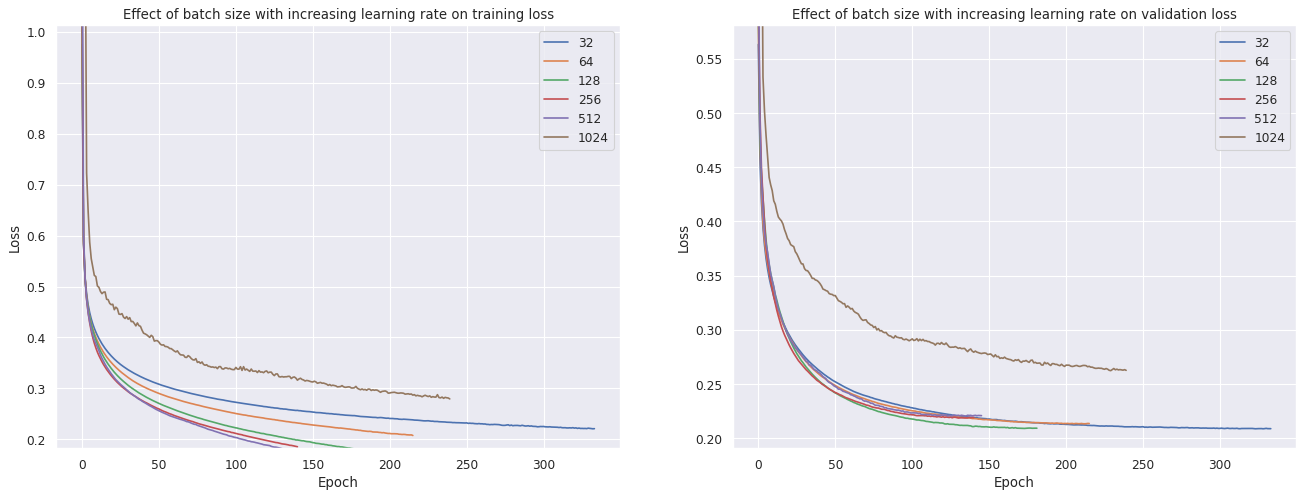

In [105]:
visualization.plot_loss_by_param(models_states[key], 'batch size with increasing learning rate',
                                 'diff_lr_diff_bs')

#### Sharpness

In [106]:
if RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        model = models[key + (batch_size, lr)]

        sharpness = visualization.get_sharpness(model.base_model, train)
        sharpnesses[key + (batch_size, lr)] = sharpness

        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG:
    sharpnesses = ml_utils.load_sharpnesses_dict()

2022-02-26 04:11:20.021044: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 13ms/step - loss: 0.1382 - accuracy: 0.9555
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.38190D-01    |proj g|=  2.08541D-02
47/47 [==============================] - 1s 10ms/step - loss: 0.4946 - accuracy: 0.8778

At iterate    1    f= -4.94559D-01    |proj g|=  3.99241D-02
  ys=-3.422E+01  -gs= 3.032E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 0.9327 - accuracy: 0.7954

At iterate    2    f= -9.32664D-01    |proj g|=  3.77030D-02
  ys=-8.629E+00  -gs= 1.419E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 0.9804 - accuracy: 0.7793

At iterate    3    f= -9.80393D-01    |proj g|=  2.96672D-02
  ys=-3.377E-01  -gs= 2.077E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 0.9921 - accura

2022-02-26 04:11:45.842048: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 12ms/step - loss: 0.1440 - accuracy: 0.9536
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.43955D-01    |proj g|=  2.04414D-02
47/47 [==============================] - 1s 11ms/step - loss: 0.5311 - accuracy: 0.8156

At iterate    1    f= -5.31143D-01    |proj g|=  4.08828D-02
  ys=-2.078E+01  -gs= 4.608E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 1.5843 - accuracy: 0.4925

At iterate    2    f= -1.58429D+00    |proj g|=  4.04162D-02
  ys=-1.018E+02  -gs= 1.375E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 4.3657 - accuracy: 0.3208

At iterate    3    f= -4.36566D+00    |proj g|=  3.84129D-02
  ys=-1.698E+02  -gs= 5.661E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 5.5477 - accura


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 11ms/step - loss: 6.2239 - accuracy: 0.3041

At iterate   10    f= -6.22387D+00    |proj g|=  3.99577D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786     10     12  63931     5 55161   3.996D-02  -6.224D+00
  F =  -6.2238731384277344     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


2022-02-26 04:12:14.362643: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 12ms/step - loss: 0.1286 - accuracy: 0.9594
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.28648D-01    |proj g|=  2.13100D-02
47/47 [==============================] - 1s 11ms/step - loss: 0.7999 - accuracy: 0.7206

At iterate    1    f= -7.99946D-01    |proj g|=  3.95911D-02
  ys=-3.959E+01  -gs= 5.197E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 4.7675 - accuracy: 0.4305

At iterate    2    f= -4.76747D+00    |proj g|=  4.45230D-02
  ys=-3.472E+02  -gs= 4.749E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 9.0045 - accuracy: 0.3866

At iterate    3    f= -9.00448D+00    |proj g|=  3.95911D-02
  ys=-2.145E+02  -gs= 1.042E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 10.0746 - accur


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 11ms/step - loss: 10.4343 - accuracy: 0.3862

At iterate    6    f= -1.04343D+01    |proj g|=  3.29618D-02
11/47 [======>.......................] - ETA: 0s - loss: 10.6533 - accuracy: 0.3794


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 11ms/step - loss: 10.4883 - accuracy: 0.3860

At iterate    7    f= -1.04883D+01    |proj g|=  2.61158D-02
47/47 [==============================] - 1s 12ms/step - loss: 10.5062 - accuracy: 0.3860

At iterate    8    f= -1.05062D+01    |proj g|=  2.60721D-02
47/47 [==============================] - 1s 11ms/step - loss: 10.5116 - accuracy: 0.3859

At iterate    9    f= -1.05116D+01    |proj g|=  2.60527D-02
11/47 [======>.......................] - ETA: 0s - loss: 10.6223 - accuracy: 0.3794


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 11ms/step - loss: 10.4571 - accuracy: 0.3861

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786     10     14  68009     4 58757   2.605D-02  -1.051D+01
  F =  -10.511575698852539     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
2022-02-26 04:12:46.683848: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 11ms/step - loss: 0.1496 - accuracy: 0.9501
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.49598D-01    |proj g|=  1.94954D-02
47/47 [==============================] - 1s 11ms/step - loss: 1.9550 - accuracy: 0.6301

At iterate    1    f= -1.95503D+00    |proj g|=  3.99246D-02
  ys=-1.465E+02  -gs= 8.691E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 9.0478 - accuracy: 0.3883

At iterate    2    f= -9.04778D+00    |proj g|=  3.91265D-02
  ys=-5.586E+02  -gs= 1.217E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 12.7990 - accuracy: 0.3736

At iterate    3    f= -1.27990D+01    |proj g|=  3.57978D-02
  ys=-1.342E+02  -gs= 1.148E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 13.9193 - accu


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 11ms/step - loss: 13.9575 - accuracy: 0.3709

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      8     10  67298     4 58398   3.587D-02  -1.403D+01
  F =  -14.031755447387695     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
2022-02-26 04:13:10.657320: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 12ms/step - loss: 0.1422 - accuracy: 0.9523
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.42169D-01    |proj g|=  2.27681D-02
47/47 [==============================] - 1s 11ms/step - loss: 1.3127 - accuracy: 0.6135

At iterate    1    f= -1.31272D+00    |proj g|=  4.55363D-02
  ys=-8.948E+01  -gs= 5.370E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 7.3743 - accuracy: 0.4632

At iterate    2    f= -7.37431D+00    |proj g|=  4.05276D-02
  ys=-4.965E+02  -gs= 8.747E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 12.5149 - accuracy: 0.3968

At iterate    3    f= -1.25149D+01    |proj g|=  4.25410D-02
  ys=-2.516E+02  -gs= 1.154E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 14.2077 - accu

2022-02-26 04:13:35.782294: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 12ms/step - loss: 0.2373 - accuracy: 0.9127
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.37305D-01    |proj g|=  2.79151D-02
47/47 [==============================] - 1s 10ms/step - loss: 0.2865 - accuracy: 0.8931

At iterate    1    f= -2.86456D-01    |proj g|=  5.58302D-02
  ys=-2.727E+00  -gs= 7.907E-01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 0.3779 - accuracy: 0.8606

At iterate    2    f= -3.77875D-01    |proj g|=  4.79796D-02
  ys=-5.172E+00  -gs= 2.051E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 10ms/step - loss: 0.4442 - accuracy: 0.8445

At iterate    3    f= -4.44184D-01    |proj g|=  4.57865D-02
  ys=-3.109E+00  -gs= 1.742E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 0.4973 - accura

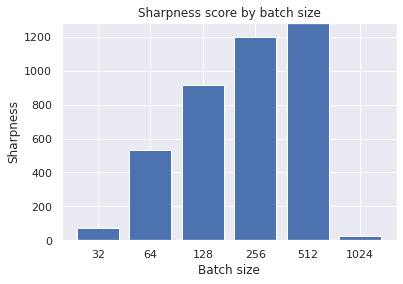

In [107]:
visualization.plot_sharpness(batch_sizes, sharpnesses, key, learning_rates)

#### Distance from initial weights

Batch size: 32, distance: 0.0
Batch size: 64, distance: 0.0
Batch size: 128, distance: 0.0
Batch size: 256, distance: 0.0
Batch size: 512, distance: 0.0
Batch size: 1024, distance: 0.0


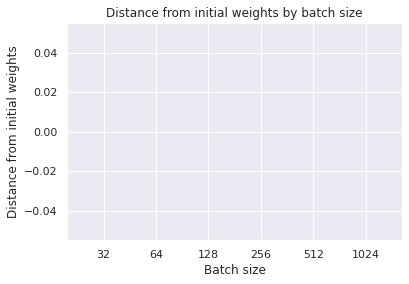

In [108]:
visualization.plot_distance_from_initial_weight(models, initial_weights, batch_sizes, key, learning_rates)

#### Runtime

In [109]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states,
                                                                                                     batch_sizes, key)

Batch size:  32
	Mean time per epoch:  6.924310507174737
	Converged in 323 epochs
	Overall training time (in seconds) until convergence:  2236.2094299793243
Batch size:  64
	Mean time per epoch:  4.120032149332541
	Converged in 205 epochs
	Overall training time (in seconds) until convergence:  844.6776576042175
Batch size:  128
	Mean time per epoch:  3.065574199288756
	Converged in 171 epochs
	Overall training time (in seconds) until convergence:  524.8004479408264
Batch size:  256
	Mean time per epoch:  2.4716958340178143
	Converged in 130 epochs
	Overall training time (in seconds) until convergence:  321.4482533931732
Batch size:  512
	Mean time per epoch:  2.2081671365319866
	Converged in 135 epochs
	Overall training time (in seconds) until convergence:  298.3437280654907
Batch size:  1024
	Mean time per epoch:  2.0376596440871557
	Converged in 229 epochs
	Overall training time (in seconds) until convergence:  466.62422943115234


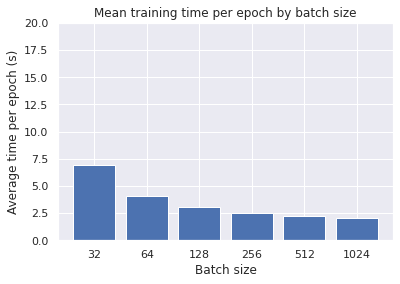

In [110]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

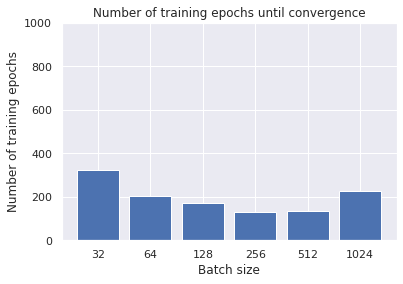

In [111]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

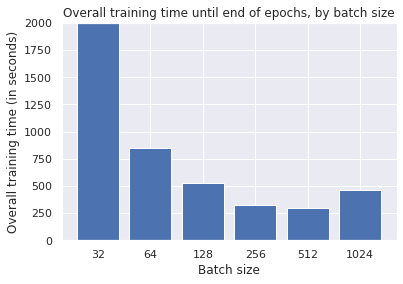

In [112]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

In [113]:
# Save to Drive in case we run on Google Colab
if USE_COLAB:
    !cp -r /content/graphs/ /content/drive/MyDrive/
    !cp -r /content/tmp/ /content/drive/MyDrive/

### SGD with Momentum + ASAM

In [114]:
learning_rates = [0.001, 0.002, 0.004, 0.008, 0.016, 0.032]
batch_sizes = [32, 64, 128, 256, 512, 1024]
training_epochs = EPOCHS

key = ('increasing', 'sgd', 'asam')

In [115]:
state_filename = 'model_diff_lr_diff_bs_sgd_asam_state'

In [116]:
if not RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                          batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        model = build_and_load_sam_model_weights(train, optimizer,
                                                 filename_bs_lr_opt_sam(batch_size, lr, "SGD-MOM", "ASAM"))
        models[key + (batch_size, lr)] = model

In [117]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size, lr in zip(batch_sizes, learning_rates):
        with tf.distribute.MirroredStrategy().scope():
            # Read training data
            train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                              batch_size=batch_size,
                                                                              img_size=32)

            optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
            model = tf_models.build_simple_cnn_sam(train, optimizer, adaptive=True, rho=2.0)
            train_callbacks = callback_for_filename(filename_bs_lr_opt_sam(batch_size, lr, "SGD-MOM", "ASAM"))

            models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                  extra_callbacks=train_callbacks, verbose=1)
            models[key + (batch_size, lr)] = model
            initial_weights[key + (batch_size, lr)] = model.get_weights()
            ml_utils.save_initial_weights_dict(initial_weights)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 04:14:02.589305: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
1498/1500 [============================>.] - ETA: 0s - loss: 1.0624 - accuracy: 0.5991

2022-02-26 04:14:11.655261: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.57723, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 10s 5ms/step - loss: 1.0619 - accuracy: 0.5993 - val_loss: 0.5772 - val_accuracy: 0.7946
Epoch 2/500
1492/1500 [============================>.] - ETA: 0s - loss: 0.5998 - accuracy: 0.7584
Epoch 2: val_loss improved from 0.57723 to 0.46765, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.5993 - accuracy: 0.7586 - val_loss: 0.4677 - val_accuracy: 0.8326
Epoch 3/500
1496/1500 [============================>.] - ETA: 0s - loss: 0.5274 - accuracy: 0.7864
Epoch 3: val_loss improved from 0.46765 to 0.42323, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.5272 - accuracy: 0.7865 - val_loss: 0.4232 - val_accuracy: 0.8500
Epoch 4/500
1499/1500 [================

1500/1500 [==============================] - 8s 5ms/step - loss: 0.3557 - accuracy: 0.8509 - val_loss: 0.2885 - val_accuracy: 0.9003
Epoch 25/500
1498/1500 [============================>.] - ETA: 0s - loss: 0.3531 - accuracy: 0.8523
Epoch 25: val_loss improved from 0.28852 to 0.28641, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 8s 5ms/step - loss: 0.3531 - accuracy: 0.8523 - val_loss: 0.2864 - val_accuracy: 0.9018
Epoch 26/500
1496/1500 [============================>.] - ETA: 0s - loss: 0.3508 - accuracy: 0.8533
Epoch 26: val_loss improved from 0.28641 to 0.28426, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 8s 5ms/step - loss: 0.3506 - accuracy: 0.8534 - val_loss: 0.2843 - val_accuracy: 0.9024
Epoch 27/500
1489/1500 [============================>.] - ETA: 0s - loss: 0.3486 - accuracy: 0.8536
Epoch 27: val_loss improved from 0.28426 to 0.28227, sa

Epoch 48/500
1499/1500 [============================>.] - ETA: 0s - loss: 0.3132 - accuracy: 0.8666
Epoch 48: val_loss improved from 0.25569 to 0.25473, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 8s 5ms/step - loss: 0.3133 - accuracy: 0.8665 - val_loss: 0.2547 - val_accuracy: 0.9115
Epoch 49/500
1500/1500 [==============================] - ETA: 0s - loss: 0.3122 - accuracy: 0.8665
Epoch 49: val_loss improved from 0.25473 to 0.25375, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 8s 5ms/step - loss: 0.3122 - accuracy: 0.8665 - val_loss: 0.2538 - val_accuracy: 0.9115
Epoch 50/500
1494/1500 [============================>.] - ETA: 0s - loss: 0.3112 - accuracy: 0.8671
Epoch 50: val_loss improved from 0.25375 to 0.25285, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 8s 5ms/step - loss: 

1496/1500 [============================>.] - ETA: 0s - loss: 0.2920 - accuracy: 0.8724
Epoch 71: val_loss improved from 0.24034 to 0.23995, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2919 - accuracy: 0.8724 - val_loss: 0.2399 - val_accuracy: 0.9144
Epoch 72/500
1499/1500 [============================>.] - ETA: 0s - loss: 0.2910 - accuracy: 0.8729
Epoch 72: val_loss improved from 0.23995 to 0.23941, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2911 - accuracy: 0.8729 - val_loss: 0.2394 - val_accuracy: 0.9148
Epoch 73/500
1500/1500 [==============================] - ETA: 0s - loss: 0.2903 - accuracy: 0.8728
Epoch 73: val_loss improved from 0.23941 to 0.23887, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2903 - accu

1498/1500 [============================>.] - ETA: 0s - loss: 0.2768 - accuracy: 0.8778
Epoch 94: val_loss improved from 0.23110 to 0.23059, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2768 - accuracy: 0.8777 - val_loss: 0.2306 - val_accuracy: 0.9174
Epoch 95/500
1492/1500 [============================>.] - ETA: 0s - loss: 0.2765 - accuracy: 0.8780
Epoch 95: val_loss improved from 0.23059 to 0.23041, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2763 - accuracy: 0.8780 - val_loss: 0.2304 - val_accuracy: 0.9179
Epoch 96/500
1498/1500 [============================>.] - ETA: 0s - loss: 0.2754 - accuracy: 0.8786
Epoch 96: val_loss improved from 0.23041 to 0.23016, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2754 - accu

1489/1500 [============================>.] - ETA: 0s - loss: 0.2654 - accuracy: 0.8813
Epoch 117: val_loss improved from 0.22492 to 0.22479, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2651 - accuracy: 0.8815 - val_loss: 0.2248 - val_accuracy: 0.9201
Epoch 118/500
1498/1500 [============================>.] - ETA: 0s - loss: 0.2644 - accuracy: 0.8824
Epoch 118: val_loss improved from 0.22479 to 0.22450, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2644 - accuracy: 0.8824 - val_loss: 0.2245 - val_accuracy: 0.9200
Epoch 119/500
1489/1500 [============================>.] - ETA: 0s - loss: 0.2640 - accuracy: 0.8823
Epoch 119: val_loss improved from 0.22450 to 0.22429, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2637 -

1500/1500 [==============================] - 7s 5ms/step - loss: 0.2546 - accuracy: 0.8854 - val_loss: 0.2206 - val_accuracy: 0.9218
Epoch 141/500
1500/1500 [==============================] - ETA: 0s - loss: 0.2541 - accuracy: 0.8856
Epoch 141: val_loss improved from 0.22058 to 0.22052, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2541 - accuracy: 0.8856 - val_loss: 0.2205 - val_accuracy: 0.9208
Epoch 142/500
1493/1500 [============================>.] - ETA: 0s - loss: 0.2540 - accuracy: 0.8852
Epoch 142: val_loss improved from 0.22052 to 0.22024, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2539 - accuracy: 0.8852 - val_loss: 0.2202 - val_accuracy: 0.9211
Epoch 143/500
1495/1500 [============================>.] - ETA: 0s - loss: 0.2531 - accuracy: 0.8858
Epoch 143: val_loss improved from 0.22024 to 0.220

1491/1500 [============================>.] - ETA: 0s - loss: 0.2454 - accuracy: 0.8880
Epoch 165: val_loss improved from 0.21754 to 0.21731, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2452 - accuracy: 0.8881 - val_loss: 0.2173 - val_accuracy: 0.9222
Epoch 166/500
1498/1500 [============================>.] - ETA: 0s - loss: 0.2448 - accuracy: 0.8887
Epoch 166: val_loss improved from 0.21731 to 0.21715, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2448 - accuracy: 0.8887 - val_loss: 0.2172 - val_accuracy: 0.9229
Epoch 167/500
1497/1500 [============================>.] - ETA: 0s - loss: 0.2439 - accuracy: 0.8892
Epoch 167: val_loss improved from 0.21715 to 0.21696, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2439 -

Epoch 190/500
1497/1500 [============================>.] - ETA: 0s - loss: 0.2358 - accuracy: 0.8931
Epoch 190: val_loss improved from 0.21479 to 0.21441, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2358 - accuracy: 0.8931 - val_loss: 0.2144 - val_accuracy: 0.9233
Epoch 191/500
1490/1500 [============================>.] - ETA: 0s - loss: 0.2356 - accuracy: 0.8924
Epoch 191: val_loss did not improve from 0.21441
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2354 - accuracy: 0.8926 - val_loss: 0.2147 - val_accuracy: 0.9235
Epoch 192/500
1496/1500 [============================>.] - ETA: 0s - loss: 0.2349 - accuracy: 0.8932
Epoch 192: val_loss did not improve from 0.21441
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2348 - accuracy: 0.8932 - val_loss: 0.2144 - val_accuracy: 0.9227
Epoch 193/500
1496/1500 [============================>.] - ETA: 0s - loss: 0

Epoch 217/500
1498/1500 [============================>.] - ETA: 0s - loss: 0.2289 - accuracy: 0.8949
Epoch 217: val_loss improved from 0.21312 to 0.21288, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2289 - accuracy: 0.8949 - val_loss: 0.2129 - val_accuracy: 0.9237
Epoch 218/500
1496/1500 [============================>.] - ETA: 0s - loss: 0.2281 - accuracy: 0.8948
Epoch 218: val_loss did not improve from 0.21288
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2280 - accuracy: 0.8949 - val_loss: 0.2130 - val_accuracy: 0.9238
Epoch 219/500
1492/1500 [============================>.] - ETA: 0s - loss: 0.2279 - accuracy: 0.8956
Epoch 219: val_loss did not improve from 0.21288
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2278 - accuracy: 0.8957 - val_loss: 0.2130 - val_accuracy: 0.9235
Epoch 220/500
1494/1500 [============================>.] - ETA: 0s - loss: 0

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Epoch 1/500


2022-02-26 04:43:42.055691: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


743/750 [============================>.] - ETA: 0s - loss: 1.0307 - accuracy: 0.6116

2022-02-26 04:43:48.297332: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.57931, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 8s 7ms/step - loss: 1.0271 - accuracy: 0.6129 - val_loss: 0.5793 - val_accuracy: 0.7963
Epoch 2/500
743/750 [============================>.] - ETA: 0s - loss: 0.5959 - accuracy: 0.7630
Epoch 2: val_loss improved from 0.57931 to 0.47583, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.5952 - accuracy: 0.7632 - val_loss: 0.4758 - val_accuracy: 0.8309
Epoch 3/500
743/750 [============================>.] - ETA: 0s - loss: 0.5232 - accuracy: 0.7914
Epoch 3: val_loss improved from 0.47583 to 0.43246, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.5227 - accuracy: 0.7916 - val_loss: 0.4325 - val_accuracy: 0.8474
Epoch 4/500
740/750 [============================>

750/750 [==============================] - 4s 5ms/step - loss: 0.3400 - accuracy: 0.8620 - val_loss: 0.2902 - val_accuracy: 0.9011
Epoch 25/500
747/750 [============================>.] - ETA: 0s - loss: 0.3374 - accuracy: 0.8626
Epoch 25: val_loss improved from 0.29019 to 0.28788, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.3372 - accuracy: 0.8626 - val_loss: 0.2879 - val_accuracy: 0.9015
Epoch 26/500
746/750 [============================>.] - ETA: 0s - loss: 0.3347 - accuracy: 0.8639
Epoch 26: val_loss improved from 0.28788 to 0.28545, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.3345 - accuracy: 0.8639 - val_loss: 0.2855 - val_accuracy: 0.9024
Epoch 27/500
745/750 [============================>.] - ETA: 0s - loss: 0.3321 - accuracy: 0.8642
Epoch 27: val_loss improved from 0.28545 to 0.28322, saving model t

Epoch 48/500
741/750 [============================>.] - ETA: 0s - loss: 0.2931 - accuracy: 0.8772
Epoch 48: val_loss improved from 0.25384 to 0.25296, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.2926 - accuracy: 0.8772 - val_loss: 0.2530 - val_accuracy: 0.9111
Epoch 49/500
744/750 [============================>.] - ETA: 0s - loss: 0.2917 - accuracy: 0.8774
Epoch 49: val_loss improved from 0.25296 to 0.25197, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.2912 - accuracy: 0.8775 - val_loss: 0.2520 - val_accuracy: 0.9113
Epoch 50/500
745/750 [============================>.] - ETA: 0s - loss: 0.2904 - accuracy: 0.8779
Epoch 50: val_loss improved from 0.25197 to 0.25109, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.2900 - acc

749/750 [============================>.] - ETA: 0s - loss: 0.2687 - accuracy: 0.8854
Epoch 71: val_loss improved from 0.23723 to 0.23675, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 6ms/step - loss: 0.2688 - accuracy: 0.8854 - val_loss: 0.2368 - val_accuracy: 0.9165
Epoch 72/500
745/750 [============================>.] - ETA: 0s - loss: 0.2684 - accuracy: 0.8855
Epoch 72: val_loss improved from 0.23675 to 0.23635, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.2680 - accuracy: 0.8856 - val_loss: 0.2364 - val_accuracy: 0.9169
Epoch 73/500
748/750 [============================>.] - ETA: 0s - loss: 0.2673 - accuracy: 0.8857
Epoch 73: val_loss improved from 0.23635 to 0.23587, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.2672 - accuracy: 0.8857

750/750 [==============================] - 4s 5ms/step - loss: 0.2524 - accuracy: 0.8906 - val_loss: 0.2283 - val_accuracy: 0.9192
Epoch 95/500
750/750 [==============================] - ETA: 0s - loss: 0.2519 - accuracy: 0.8913
Epoch 95: val_loss improved from 0.22833 to 0.22821, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 5s 6ms/step - loss: 0.2519 - accuracy: 0.8913 - val_loss: 0.2282 - val_accuracy: 0.9193
Epoch 96/500
744/750 [============================>.] - ETA: 0s - loss: 0.2516 - accuracy: 0.8912
Epoch 96: val_loss improved from 0.22821 to 0.22777, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.2511 - accuracy: 0.8914 - val_loss: 0.2278 - val_accuracy: 0.9192
Epoch 97/500
749/750 [============================>.] - ETA: 0s - loss: 0.2506 - accuracy: 0.8910
Epoch 97: val_loss improved from 0.22777 to 0.22748, saving model t

Epoch 118/500
748/750 [============================>.] - ETA: 0s - loss: 0.2392 - accuracy: 0.8948
Epoch 118: val_loss improved from 0.22231 to 0.22199, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.2390 - accuracy: 0.8948 - val_loss: 0.2220 - val_accuracy: 0.9208
Epoch 119/500
746/750 [============================>.] - ETA: 0s - loss: 0.2389 - accuracy: 0.8950
Epoch 119: val_loss did not improve from 0.22199
750/750 [==============================] - 4s 5ms/step - loss: 0.2387 - accuracy: 0.8951 - val_loss: 0.2220 - val_accuracy: 0.9209
Epoch 120/500
743/750 [============================>.] - ETA: 0s - loss: 0.2385 - accuracy: 0.8952
Epoch 120: val_loss improved from 0.22199 to 0.22180, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.2381 - accuracy: 0.8954 - val_loss: 0.2218 - val_accuracy: 0.9208
Epoch 121/500

Epoch 142/500
741/750 [============================>.] - ETA: 0s - loss: 0.2286 - accuracy: 0.8992
Epoch 142: val_loss improved from 0.21860 to 0.21833, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.2281 - accuracy: 0.8995 - val_loss: 0.2183 - val_accuracy: 0.9220
Epoch 143/500
744/750 [============================>.] - ETA: 0s - loss: 0.2281 - accuracy: 0.8988
Epoch 143: val_loss did not improve from 0.21833
750/750 [==============================] - 4s 5ms/step - loss: 0.2277 - accuracy: 0.8990 - val_loss: 0.2184 - val_accuracy: 0.9222
Epoch 144/500
750/750 [==============================] - ETA: 0s - loss: 0.2274 - accuracy: 0.9000
Epoch 144: val_loss improved from 0.21833 to 0.21792, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 6ms/step - loss: 0.2274 - accuracy: 0.9000 - val_loss: 0.2179 - val_accuracy: 0.9220
Epoch 145/500

747/750 [============================>.] - ETA: 0s - loss: 0.2190 - accuracy: 0.9024
Epoch 168: val_loss did not improve from 0.21632
750/750 [==============================] - 4s 5ms/step - loss: 0.2189 - accuracy: 0.9025 - val_loss: 0.2166 - val_accuracy: 0.9227
Epoch 169/500
744/750 [============================>.] - ETA: 0s - loss: 0.2190 - accuracy: 0.9027
Epoch 169: val_loss did not improve from 0.21632
750/750 [==============================] - 4s 5ms/step - loss: 0.2186 - accuracy: 0.9029 - val_loss: 0.2166 - val_accuracy: 0.9225
Epoch 170/500
749/750 [============================>.] - ETA: 0s - loss: 0.2187 - accuracy: 0.9028
Epoch 170: val_loss improved from 0.21632 to 0.21630, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.2187 - accuracy: 0.9029 - val_loss: 0.2163 - val_accuracy: 0.9222
Epoch 171/500
744/750 [============================>.] - ETA: 0s - loss: 0.2186 - accuracy: 0.9027
Epo

Epoch 195/500
742/750 [============================>.] - ETA: 0s - loss: 0.2114 - accuracy: 0.9051
Epoch 195: val_loss did not improve from 0.21497
750/750 [==============================] - 4s 5ms/step - loss: 0.2110 - accuracy: 0.9053 - val_loss: 0.2151 - val_accuracy: 0.9225
Epoch 196/500
747/750 [============================>.] - ETA: 0s - loss: 0.2107 - accuracy: 0.9056
Epoch 196: val_loss did not improve from 0.21497
750/750 [==============================] - 4s 5ms/step - loss: 0.2106 - accuracy: 0.9056 - val_loss: 0.2151 - val_accuracy: 0.9231
Epoch 197/500
742/750 [============================>.] - ETA: 0s - loss: 0.2105 - accuracy: 0.9064
Epoch 197: val_loss improved from 0.21497 to 0.21489, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.2101 - accuracy: 0.9065 - val_loss: 0.2149 - val_accuracy: 0.9228
Epoch 198/500
750/750 [==============================] - ETA: 0s - loss: 0.2096 - accura

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 04:58:51.303990: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
368/375 [============================>.] - ETA: 0s - loss: 1.0162 - accuracy: 0.6115

2022-02-26 04:58:55.759849: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.59556, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 6s 12ms/step - loss: 1.0094 - accuracy: 0.6142 - val_loss: 0.5956 - val_accuracy: 0.7870
Epoch 2/500
368/375 [============================>.] - ETA: 0s - loss: 0.5949 - accuracy: 0.7668
Epoch 2: val_loss improved from 0.59556 to 0.48176, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.5936 - accuracy: 0.7670 - val_loss: 0.4818 - val_accuracy: 0.8281
Epoch 3/500
373/375 [============================>.] - ETA: 0s - loss: 0.5168 - accuracy: 0.7965
Epoch 3: val_loss improved from 0.48176 to 0.43977, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.5166 - accuracy: 0.7965 - val_loss: 0.4398 - val_accuracy: 0.8435
Epoch 4/500
375/375 [=========================

375/375 [==============================] - 3s 8ms/step - loss: 0.3215 - accuracy: 0.8706 - val_loss: 0.2815 - val_accuracy: 0.9015
Epoch 25/500
371/375 [============================>.] - ETA: 0s - loss: 0.3192 - accuracy: 0.8716
Epoch 25: val_loss improved from 0.28148 to 0.27875, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.3187 - accuracy: 0.8717 - val_loss: 0.2787 - val_accuracy: 0.9024
Epoch 26/500
370/375 [============================>.] - ETA: 0s - loss: 0.3164 - accuracy: 0.8724
Epoch 26: val_loss improved from 0.27875 to 0.27631, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.3159 - accuracy: 0.8725 - val_loss: 0.2763 - val_accuracy: 0.9034
Epoch 27/500
373/375 [============================>.] - ETA: 0s - loss: 0.3136 - accuracy: 0.8730
Epoch 27: val_loss improved from 0.27631 to 0.27421, saving model

Epoch 48/500
372/375 [============================>.] - ETA: 0s - loss: 0.2752 - accuracy: 0.8874
Epoch 48: val_loss improved from 0.24483 to 0.24392, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2747 - accuracy: 0.8876 - val_loss: 0.2439 - val_accuracy: 0.9126
Epoch 49/500
375/375 [==============================] - ETA: 0s - loss: 0.2734 - accuracy: 0.8879
Epoch 49: val_loss improved from 0.24392 to 0.24285, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2734 - accuracy: 0.8879 - val_loss: 0.2428 - val_accuracy: 0.9129
Epoch 50/500
369/375 [============================>.] - ETA: 0s - loss: 0.2724 - accuracy: 0.8882
Epoch 50: val_loss improved from 0.24285 to 0.24214, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2721 - 

370/375 [============================>.] - ETA: 0s - loss: 0.2505 - accuracy: 0.8955
Epoch 71: val_loss improved from 0.22899 to 0.22831, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2501 - accuracy: 0.8956 - val_loss: 0.2283 - val_accuracy: 0.9178
Epoch 72/500
368/375 [============================>.] - ETA: 0s - loss: 0.2495 - accuracy: 0.8967
Epoch 72: val_loss improved from 0.22831 to 0.22776, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2491 - accuracy: 0.8967 - val_loss: 0.2278 - val_accuracy: 0.9180
Epoch 73/500
368/375 [============================>.] - ETA: 0s - loss: 0.2489 - accuracy: 0.8961
Epoch 73: val_loss improved from 0.22776 to 0.22724, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2486 - accuracy: 0.8

374/375 [============================>.] - ETA: 0s - loss: 0.2327 - accuracy: 0.9013
Epoch 94: val_loss improved from 0.21981 to 0.21981, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2327 - accuracy: 0.9014 - val_loss: 0.2198 - val_accuracy: 0.9223
Epoch 95/500
374/375 [============================>.] - ETA: 0s - loss: 0.2321 - accuracy: 0.9018
Epoch 95: val_loss improved from 0.21981 to 0.21956, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2321 - accuracy: 0.9018 - val_loss: 0.2196 - val_accuracy: 0.9225
Epoch 96/500
369/375 [============================>.] - ETA: 0s - loss: 0.2315 - accuracy: 0.9021
Epoch 96: val_loss improved from 0.21956 to 0.21919, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2313 - accuracy: 0.9

373/375 [============================>.] - ETA: 0s - loss: 0.2181 - accuracy: 0.9069
Epoch 117: val_loss improved from 0.21496 to 0.21470, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2180 - accuracy: 0.9069 - val_loss: 0.2147 - val_accuracy: 0.9240
Epoch 118/500
371/375 [============================>.] - ETA: 0s - loss: 0.2174 - accuracy: 0.9071
Epoch 118: val_loss did not improve from 0.21470
375/375 [==============================] - 3s 8ms/step - loss: 0.2171 - accuracy: 0.9071 - val_loss: 0.2147 - val_accuracy: 0.9233
Epoch 119/500
371/375 [============================>.] - ETA: 0s - loss: 0.2171 - accuracy: 0.9065
Epoch 119: val_loss improved from 0.21470 to 0.21447, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2168 - accuracy: 0.9066 - val_loss: 0.2145 - val_accuracy: 0.9243
Epoch 120/500
375/375 [==

375/375 [==============================] - 3s 8ms/step - loss: 0.2054 - accuracy: 0.9111 - val_loss: 0.2119 - val_accuracy: 0.9249
Epoch 142/500
368/375 [============================>.] - ETA: 0s - loss: 0.2051 - accuracy: 0.9113
Epoch 142: val_loss improved from 0.21192 to 0.21182, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2048 - accuracy: 0.9115 - val_loss: 0.2118 - val_accuracy: 0.9253
Epoch 143/500
372/375 [============================>.] - ETA: 0s - loss: 0.2043 - accuracy: 0.9118
Epoch 143: val_loss improved from 0.21182 to 0.21176, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2040 - accuracy: 0.9119 - val_loss: 0.2118 - val_accuracy: 0.9253
Epoch 144/500
375/375 [==============================] - ETA: 0s - loss: 0.2035 - accuracy: 0.9115
Epoch 144: val_loss improved from 0.21176 to 0.21145, saving

375/375 [==============================] - 3s 8ms/step - loss: 0.1934 - accuracy: 0.9159 - val_loss: 0.2105 - val_accuracy: 0.9256
Epoch 168/500
374/375 [============================>.] - ETA: 0s - loss: 0.1929 - accuracy: 0.9162
Epoch 168: val_loss did not improve from 0.21050
375/375 [==============================] - 3s 8ms/step - loss: 0.1928 - accuracy: 0.9162 - val_loss: 0.2107 - val_accuracy: 0.9255
Epoch 169/500
369/375 [============================>.] - ETA: 0s - loss: 0.1929 - accuracy: 0.9162
Epoch 169: val_loss did not improve from 0.21050
375/375 [==============================] - 3s 8ms/step - loss: 0.1926 - accuracy: 0.9164 - val_loss: 0.2108 - val_accuracy: 0.9257
Epoch 170/500
372/375 [============================>.] - ETA: 0s - loss: 0.1925 - accuracy: 0.9161
Epoch 170: val_loss did not improve from 0.21050
375/375 [==============================] - 3s 8ms/step - loss: 0.1922 - accuracy: 0.9162 - val_loss: 0.2108 - val_accuracy: 0.9258
Epoch 171/500
375/375 [=========

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 05:07:44.216215: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
186/188 [============================>.] - ETA: 0s - loss: 1.1191 - accuracy: 0.5827

2022-02-26 05:07:49.157936: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.63033, saving model to tmp/model_lr_0.008_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 6s 15ms/step - loss: 1.1153 - accuracy: 0.5840 - val_loss: 0.6303 - val_accuracy: 0.7756
Epoch 2/500
188/188 [==============================] - ETA: 0s - loss: 0.5854 - accuracy: 0.7723
Epoch 2: val_loss improved from 0.63033 to 0.49531, saving model to tmp/model_lr_0.008_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 2s 13ms/step - loss: 0.5854 - accuracy: 0.7723 - val_loss: 0.4953 - val_accuracy: 0.8223
Epoch 3/500
185/188 [============================>.] - ETA: 0s - loss: 0.5080 - accuracy: 0.8007
Epoch 3: val_loss improved from 0.49531 to 0.45138, saving model to tmp/model_lr_0.008_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 2s 13ms/step - loss: 0.5080 - accuracy: 0.8005 - val_loss: 0.4514 - val_accuracy: 0.8450
Epoch 4/500
188/188 [=======================

188/188 [==============================] - 2s 13ms/step - loss: 0.3110 - accuracy: 0.8779 - val_loss: 0.2764 - val_accuracy: 0.9046
Epoch 25/500
185/188 [============================>.] - ETA: 0s - loss: 0.3085 - accuracy: 0.8785
Epoch 25: val_loss improved from 0.27644 to 0.27429, saving model to tmp/model_lr_0.008_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 2s 13ms/step - loss: 0.3079 - accuracy: 0.8788 - val_loss: 0.2743 - val_accuracy: 0.9048
Epoch 26/500
188/188 [==============================] - ETA: 0s - loss: 0.3051 - accuracy: 0.8795
Epoch 26: val_loss improved from 0.27429 to 0.27219, saving model to tmp/model_lr_0.008_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 2s 13ms/step - loss: 0.3051 - accuracy: 0.8795 - val_loss: 0.2722 - val_accuracy: 0.9054
Epoch 27/500
185/188 [============================>.] - ETA: 0s - loss: 0.3028 - accuracy: 0.8800
Epoch 27: val_loss improved from 0.27219 to 0.27034, saving mo

Epoch 48/500
188/188 [==============================] - ETA: 0s - loss: 0.2605 - accuracy: 0.8954
Epoch 48: val_loss improved from 0.24426 to 0.24338, saving model to tmp/model_lr_0.008_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 2s 13ms/step - loss: 0.2605 - accuracy: 0.8954 - val_loss: 0.2434 - val_accuracy: 0.9123
Epoch 49/500
184/188 [============================>.] - ETA: 0s - loss: 0.2595 - accuracy: 0.8959
Epoch 49: val_loss improved from 0.24338 to 0.24266, saving model to tmp/model_lr_0.008_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 2s 13ms/step - loss: 0.2589 - accuracy: 0.8960 - val_loss: 0.2427 - val_accuracy: 0.9125
Epoch 50/500
184/188 [============================>.] - ETA: 0s - loss: 0.2580 - accuracy: 0.8962
Epoch 50: val_loss improved from 0.24266 to 0.24194, saving model to tmp/model_lr_0.008_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 2s 13ms/step - loss: 0.2575

186/188 [============================>.] - ETA: 0s - loss: 0.2323 - accuracy: 0.9050
Epoch 71: val_loss improved from 0.23180 to 0.23117, saving model to tmp/model_lr_0.008_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 2s 13ms/step - loss: 0.2318 - accuracy: 0.9051 - val_loss: 0.2312 - val_accuracy: 0.9170
Epoch 72/500
185/188 [============================>.] - ETA: 0s - loss: 0.2312 - accuracy: 0.9056
Epoch 72: val_loss did not improve from 0.23117
188/188 [==============================] - 3s 14ms/step - loss: 0.2307 - accuracy: 0.9057 - val_loss: 0.2312 - val_accuracy: 0.9174
Epoch 73/500
185/188 [============================>.] - ETA: 0s - loss: 0.2301 - accuracy: 0.9058
Epoch 73: val_loss improved from 0.23117 to 0.23047, saving model to tmp/model_lr_0.008_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 2s 13ms/step - loss: 0.2296 - accuracy: 0.9059 - val_loss: 0.2305 - val_accuracy: 0.9171
Epoch 74/500
186/188 [=====

188/188 [==============================] - 2s 13ms/step - loss: 0.2101 - accuracy: 0.9134 - val_loss: 0.2247 - val_accuracy: 0.9195
Epoch 96/500
187/188 [============================>.] - ETA: 0s - loss: 0.2093 - accuracy: 0.9131
Epoch 96: val_loss improved from 0.22466 to 0.22438, saving model to tmp/model_lr_0.008_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 2s 13ms/step - loss: 0.2092 - accuracy: 0.9131 - val_loss: 0.2244 - val_accuracy: 0.9197
Epoch 97/500
185/188 [============================>.] - ETA: 0s - loss: 0.2088 - accuracy: 0.9137
Epoch 97: val_loss improved from 0.22438 to 0.22413, saving model to tmp/model_lr_0.008_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 2s 13ms/step - loss: 0.2082 - accuracy: 0.9138 - val_loss: 0.2241 - val_accuracy: 0.9195
Epoch 98/500
184/188 [============================>.] - ETA: 0s - loss: 0.2081 - accuracy: 0.9144
Epoch 98: val_loss did not improve from 0.22413
188/188 [=====

186/188 [============================>.] - ETA: 0s - loss: 0.1916 - accuracy: 0.9193
Epoch 121: val_loss did not improve from 0.22054
188/188 [==============================] - 2s 13ms/step - loss: 0.1911 - accuracy: 0.9195 - val_loss: 0.2210 - val_accuracy: 0.9204
Epoch 122/500
184/188 [============================>.] - ETA: 0s - loss: 0.1907 - accuracy: 0.9198
Epoch 122: val_loss did not improve from 0.22054
188/188 [==============================] - 2s 13ms/step - loss: 0.1902 - accuracy: 0.9199 - val_loss: 0.2211 - val_accuracy: 0.9197
Epoch 123/500
185/188 [============================>.] - ETA: 0s - loss: 0.1903 - accuracy: 0.9198
Epoch 123: val_loss did not improve from 0.22054
188/188 [==============================] - 2s 13ms/step - loss: 0.1898 - accuracy: 0.9201 - val_loss: 0.2211 - val_accuracy: 0.9204
Epoch 124/500
185/188 [============================>.] - ETA: 0s - loss: 0.1893 - accuracy: 0.9202
Epoch 124: val_loss improved from 0.22054 to 0.22027, saving model to tmp/m

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Epoch 1/500


2022-02-26 05:13:59.809690: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


94/94 [==============================] - ETA: 0s - loss: 1.3399 - accuracy: 0.5226

2022-02-26 05:14:02.572928: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.62104, saving model to tmp/model_lr_0.016_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 4s 39ms/step - loss: 1.3399 - accuracy: 0.5226 - val_loss: 0.6210 - val_accuracy: 0.7768
Epoch 2/500
94/94 [==============================] - ETA: 0s - loss: 0.5872 - accuracy: 0.7712
Epoch 2: val_loss improved from 0.62104 to 0.48430, saving model to tmp/model_lr_0.016_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.5872 - accuracy: 0.7712 - val_loss: 0.4843 - val_accuracy: 0.8303
Epoch 3/500
94/94 [==============================] - ETA: 0s - loss: 0.5090 - accuracy: 0.8002
Epoch 3: val_loss improved from 0.48430 to 0.43438, saving model to tmp/model_lr_0.016_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.5090 - accuracy: 0.8002 - val_loss: 0.4344 - val_accuracy: 0.8478
Epoch 4/500
94/94 [==============================] - E

Epoch 25/500
94/94 [==============================] - ETA: 0s - loss: 0.3053 - accuracy: 0.8794
Epoch 25: val_loss improved from 0.28017 to 0.27930, saving model to tmp/model_lr_0.016_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.3053 - accuracy: 0.8794 - val_loss: 0.2793 - val_accuracy: 0.9031
Epoch 26/500
94/94 [==============================] - ETA: 0s - loss: 0.3024 - accuracy: 0.8808
Epoch 26: val_loss improved from 0.27930 to 0.27659, saving model to tmp/model_lr_0.016_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.3024 - accuracy: 0.8808 - val_loss: 0.2766 - val_accuracy: 0.9041
Epoch 27/500
94/94 [==============================] - ETA: 0s - loss: 0.2992 - accuracy: 0.8816
Epoch 27: val_loss improved from 0.27659 to 0.27470, saving model to tmp/model_lr_0.016_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.2992 - accuracy:

94/94 [==============================] - 2s 24ms/step - loss: 0.2578 - accuracy: 0.8963 - val_loss: 0.2469 - val_accuracy: 0.9125
Epoch 49/500
94/94 [==============================] - ETA: 0s - loss: 0.2560 - accuracy: 0.8974
Epoch 49: val_loss improved from 0.24693 to 0.24556, saving model to tmp/model_lr_0.016_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.2560 - accuracy: 0.8974 - val_loss: 0.2456 - val_accuracy: 0.9124
Epoch 50/500
94/94 [==============================] - ETA: 0s - loss: 0.2543 - accuracy: 0.8973
Epoch 50: val_loss improved from 0.24556 to 0.24434, saving model to tmp/model_lr_0.016_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.2543 - accuracy: 0.8973 - val_loss: 0.2443 - val_accuracy: 0.9135
Epoch 51/500
94/94 [==============================] - ETA: 0s - loss: 0.2532 - accuracy: 0.8978
Epoch 51: val_loss improved from 0.24434 to 0.24306, saving model to tmp/m

94/94 [==============================] - ETA: 0s - loss: 0.2255 - accuracy: 0.9089
Epoch 72: val_loss improved from 0.23019 to 0.22999, saving model to tmp/model_lr_0.016_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.2255 - accuracy: 0.9089 - val_loss: 0.2300 - val_accuracy: 0.9172
Epoch 73/500
94/94 [==============================] - ETA: 0s - loss: 0.2242 - accuracy: 0.9087
Epoch 73: val_loss improved from 0.22999 to 0.22910, saving model to tmp/model_lr_0.016_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.2242 - accuracy: 0.9087 - val_loss: 0.2291 - val_accuracy: 0.9181
Epoch 74/500
94/94 [==============================] - ETA: 0s - loss: 0.2230 - accuracy: 0.9081
Epoch 74: val_loss improved from 0.22910 to 0.22886, saving model to tmp/model_lr_0.016_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.2230 - accuracy: 0.9081 - val

Epoch 97/500
94/94 [==============================] - ETA: 0s - loss: 0.2008 - accuracy: 0.9173
Epoch 97: val_loss improved from 0.22239 to 0.22236, saving model to tmp/model_lr_0.016_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.2008 - accuracy: 0.9173 - val_loss: 0.2224 - val_accuracy: 0.9212
Epoch 98/500
94/94 [==============================] - ETA: 0s - loss: 0.1992 - accuracy: 0.9184
Epoch 98: val_loss improved from 0.22236 to 0.22183, saving model to tmp/model_lr_0.016_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.1992 - accuracy: 0.9184 - val_loss: 0.2218 - val_accuracy: 0.9217
Epoch 99/500
94/94 [==============================] - ETA: 0s - loss: 0.1984 - accuracy: 0.9185
Epoch 99: val_loss improved from 0.22183 to 0.22165, saving model to tmp/model_lr_0.016_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.1984 - accuracy:

94/94 [==============================] - ETA: 0s - loss: 0.1797 - accuracy: 0.9246
Epoch 123: val_loss did not improve from 0.21865
94/94 [==============================] - 2s 24ms/step - loss: 0.1797 - accuracy: 0.9246 - val_loss: 0.2196 - val_accuracy: 0.9229
Epoch 124/500
94/94 [==============================] - ETA: 0s - loss: 0.1792 - accuracy: 0.9249
Epoch 124: val_loss did not improve from 0.21865
94/94 [==============================] - 2s 24ms/step - loss: 0.1792 - accuracy: 0.9249 - val_loss: 0.2191 - val_accuracy: 0.9230
Epoch 125/500
94/94 [==============================] - ETA: 0s - loss: 0.1783 - accuracy: 0.9254
Epoch 125: val_loss did not improve from 0.21865
94/94 [==============================] - 2s 24ms/step - loss: 0.1783 - accuracy: 0.9254 - val_loss: 0.2201 - val_accuracy: 0.9233
Epoch 126/500
94/94 [==============================] - ETA: 0s - loss: 0.1780 - accuracy: 0.9258
Epoch 126: val_loss did not improve from 0.21865
94/94 [==============================] -

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 05:19:01.558682: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
47/47 [==============================] - ETA: 0s - loss: 2.1823 - accuracy: 0.3393

2022-02-26 05:19:06.139066: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 1.54805, saving model to tmp/model_lr_0.032_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 6s 75ms/step - loss: 2.1823 - accuracy: 0.3393 - val_loss: 1.5480 - val_accuracy: 0.6150
Epoch 2/500
47/47 [==============================] - ETA: 0s - loss: 1.1175 - accuracy: 0.6328
Epoch 2: val_loss improved from 1.54805 to 0.57429, saving model to tmp/model_lr_0.032_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 1.1175 - accuracy: 0.6328 - val_loss: 0.5743 - val_accuracy: 0.7963
Epoch 3/500
47/47 [==============================] - ETA: 0s - loss: 0.5925 - accuracy: 0.7643
Epoch 3: val_loss improved from 0.57429 to 0.47575, saving model to tmp/model_lr_0.032_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.5925 - accuracy: 0.7643 - val_loss: 0.4758 - val_accuracy: 0.8322
Epoch 4/500
47/47 [==============================] 

Epoch 25/500
47/47 [==============================] - ETA: 0s - loss: 0.3280 - accuracy: 0.8699
Epoch 25: val_loss improved from 0.29572 to 0.29207, saving model to tmp/model_lr_0.032_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.3280 - accuracy: 0.8699 - val_loss: 0.2921 - val_accuracy: 0.8982
Epoch 26/500
47/47 [==============================] - ETA: 0s - loss: 0.3263 - accuracy: 0.8693
Epoch 26: val_loss did not improve from 0.29207
47/47 [==============================] - 2s 44ms/step - loss: 0.3263 - accuracy: 0.8693 - val_loss: 0.2950 - val_accuracy: 0.8977
Epoch 27/500
47/47 [==============================] - ETA: 0s - loss: 0.3271 - accuracy: 0.8672
Epoch 27: val_loss did not improve from 0.29207
47/47 [==============================] - 2s 44ms/step - loss: 0.3271 - accuracy: 0.8672 - val_loss: 0.2949 - val_accuracy: 0.8982
Epoch 28/500
47/47 [==============================] - ETA: 0s - loss: 0.3243 - accuracy: 0.8693
Epoch

Epoch 51/500
47/47 [==============================] - ETA: 0s - loss: 0.2878 - accuracy: 0.8833
Epoch 51: val_loss did not improve from 0.26789
47/47 [==============================] - 2s 44ms/step - loss: 0.2878 - accuracy: 0.8833 - val_loss: 0.2683 - val_accuracy: 0.9060
Epoch 52/500
47/47 [==============================] - ETA: 0s - loss: 0.2874 - accuracy: 0.8818
Epoch 52: val_loss improved from 0.26789 to 0.26375, saving model to tmp/model_lr_0.032_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 44ms/step - loss: 0.2874 - accuracy: 0.8818 - val_loss: 0.2638 - val_accuracy: 0.9065
Epoch 53/500
47/47 [==============================] - ETA: 0s - loss: 0.2817 - accuracy: 0.8844
Epoch 53: val_loss improved from 0.26375 to 0.26276, saving model to tmp/model_lr_0.032_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 44ms/step - loss: 0.2817 - accuracy: 0.8844 - val_loss: 0.2628 - val_accuracy: 0.9071
Epoch 54/500
47/47 [====

47/47 [==============================] - 2s 44ms/step - loss: 0.2576 - accuracy: 0.8929 - val_loss: 0.2497 - val_accuracy: 0.9111
Epoch 77/500
47/47 [==============================] - ETA: 0s - loss: 0.2567 - accuracy: 0.8938
Epoch 77: val_loss did not improve from 0.24973
47/47 [==============================] - 2s 43ms/step - loss: 0.2567 - accuracy: 0.8938 - val_loss: 0.2499 - val_accuracy: 0.9126
Epoch 78/500
47/47 [==============================] - ETA: 0s - loss: 0.2564 - accuracy: 0.8933
Epoch 78: val_loss improved from 0.24973 to 0.24839, saving model to tmp/model_lr_0.032_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 46ms/step - loss: 0.2564 - accuracy: 0.8933 - val_loss: 0.2484 - val_accuracy: 0.9115
Epoch 79/500
47/47 [==============================] - ETA: 0s - loss: 0.2556 - accuracy: 0.8937
Epoch 79: val_loss did not improve from 0.24839
47/47 [==============================] - 2s 44ms/step - loss: 0.2556 - accuracy: 0.8937 - val_loss: 0

Epoch 103/500
47/47 [==============================] - ETA: 0s - loss: 0.2379 - accuracy: 0.9013
Epoch 103: val_loss improved from 0.24152 to 0.24101, saving model to tmp/model_lr_0.032_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 44ms/step - loss: 0.2379 - accuracy: 0.9013 - val_loss: 0.2410 - val_accuracy: 0.9138
Epoch 104/500
47/47 [==============================] - ETA: 0s - loss: 0.2370 - accuracy: 0.9010
Epoch 104: val_loss did not improve from 0.24101
47/47 [==============================] - 2s 44ms/step - loss: 0.2370 - accuracy: 0.9010 - val_loss: 0.2419 - val_accuracy: 0.9124
Epoch 105/500
47/47 [==============================] - ETA: 0s - loss: 0.2372 - accuracy: 0.9014
Epoch 105: val_loss improved from 0.24101 to 0.24042, saving model to tmp/model_lr_0.032_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.2372 - accuracy: 0.9014 - val_loss: 0.2404 - val_accuracy: 0.9142
Epoch 106/500
47/4

Epoch 130/500
47/47 [==============================] - ETA: 0s - loss: 0.2186 - accuracy: 0.9079
Epoch 130: val_loss did not improve from 0.23490
47/47 [==============================] - 2s 43ms/step - loss: 0.2186 - accuracy: 0.9079 - val_loss: 0.2351 - val_accuracy: 0.9145
Epoch 131/500
47/47 [==============================] - ETA: 0s - loss: 0.2205 - accuracy: 0.9067
Epoch 131: val_loss did not improve from 0.23490
47/47 [==============================] - 2s 44ms/step - loss: 0.2205 - accuracy: 0.9067 - val_loss: 0.2350 - val_accuracy: 0.9149
Epoch 132/500
47/47 [==============================] - ETA: 0s - loss: 0.2201 - accuracy: 0.9064
Epoch 132: val_loss did not improve from 0.23490
47/47 [==============================] - 2s 44ms/step - loss: 0.2201 - accuracy: 0.9064 - val_loss: 0.2354 - val_accuracy: 0.9158
Epoch 133/500
47/47 [==============================] - ETA: 0s - loss: 0.2201 - accuracy: 0.9075
Epoch 133: val_loss improved from 0.23490 to 0.23434, saving model to tmp/m

In [118]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], state_filename)
else:
    models_states[key] = ml_utils.load_model_state(state_filename)

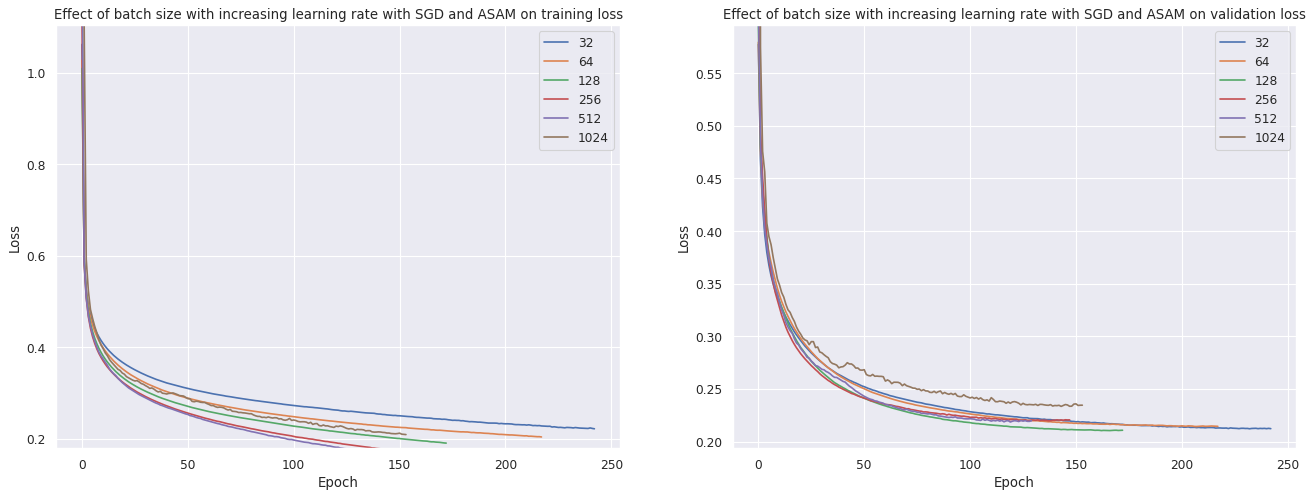

In [119]:
visualization.plot_loss_by_param(models_states[key], 'batch size with increasing learning rate with SGD and ASAM',
                                 'diff_lr_diff_bs_SGD_ASAM')

#### Sharpness

In [120]:
if RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        model = models[key + (batch_size, lr)]

        sharpness = visualization.get_sharpness(model.base_model, train)
        sharpnesses[key + (batch_size, lr)] = sharpness

        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG:
    sharpnesses = ml_utils.load_sharpnesses_dict()

2022-02-26 05:24:35.307767: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 12ms/step - loss: 0.1476 - accuracy: 0.9514
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.47555D-01    |proj g|=  2.07744D-02
47/47 [==============================] - 1s 11ms/step - loss: 0.4547 - accuracy: 0.8566

At iterate    1    f= -4.54653D-01    |proj g|=  4.15487D-02
  ys=-2.175E+01  -gs= 3.257E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 0.9582 - accuracy: 0.7014

At iterate    2    f= -9.58229D-01    |proj g|=  3.50194D-02
  ys=-2.716E+01  -gs= 1.158E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 1.1475 - accuracy: 0.6216

At iterate    3    f= -1.14754D+00    |proj g|=  3.20164D-02
  ys=-6.117E+00  -gs= 6.086E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 1.2098 - accura

2022-02-26 05:25:01.802908: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 12ms/step - loss: 0.1384 - accuracy: 0.9554
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.38377D-01    |proj g|=  2.06171D-02
47/47 [==============================] - 1s 11ms/step - loss: 0.5510 - accuracy: 0.8110

At iterate    1    f= -5.51011D-01    |proj g|=  4.12343D-02
  ys=-2.535E+01  -gs= 4.035E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 2.1450 - accuracy: 0.4556

At iterate    2    f= -2.14501D+00    |proj g|=  4.12343D-02
  ys=-1.625E+02  -gs= 1.771E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 4.0682 - accuracy: 0.3992

At iterate    3    f= -4.06824D+00    |proj g|=  4.12343D-02
  ys=-9.388E+01  -gs= 4.771E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 5.1146 - accura


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 11ms/step - loss: 5.6071 - accuracy: 0.3939

At iterate   10    f= -5.60707D+00    |proj g|=  4.12343D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786     10     12  62287     6 54929   4.123D-02  -5.607D+00
  F =  -5.6070713996887207     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


2022-02-26 05:25:30.112813: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 12ms/step - loss: 0.1409 - accuracy: 0.9540
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.40904D-01    |proj g|=  2.14410D-02
47/47 [==============================] - 1s 12ms/step - loss: 0.8552 - accuracy: 0.7362

At iterate    1    f= -8.55172D-01    |proj g|=  4.28820D-02
  ys=-4.837E+01  -gs= 5.135E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 5.4202 - accuracy: 0.4702

At iterate    2    f= -5.42023D+00    |proj g|=  3.88149D-02
  ys=-4.065E+02  -gs= 5.821E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 9.9746 - accuracy: 0.3889

At iterate    3    f= -9.97464D+00    |proj g|=  3.85004D-02
  ys=-1.928E+02  -gs= 1.230E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 11.1773 - accur


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 11ms/step - loss: 11.4433 - accuracy: 0.3853

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      8     10  68571     4 58798   3.086D-02  -1.149D+01
  F =  -11.490114212036133     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
2022-02-26 05:25:54.066009: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 13ms/step - loss: 0.1378 - accuracy: 0.9544
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.37842D-01    |proj g|=  2.18823D-02
47/47 [==============================] - 1s 12ms/step - loss: 1.5629 - accuracy: 0.6960

At iterate    1    f= -1.56295D+00    |proj g|=  4.37646D-02
  ys=-9.651E+01  -gs= 8.705E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 6.9718 - accuracy: 0.5917

At iterate    2    f= -6.97175D+00    |proj g|=  3.82414D-02
  ys=-3.405E+02  -gs= 1.041E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 10.3612 - accuracy: 0.4869

At iterate    3    f= -1.03612D+01    |proj g|=  3.64290D-02
  ys=-1.653E+02  -gs= 7.810E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 11.0411 - accu


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 11ms/step - loss: 13.1542 - accuracy: 0.3817

At iterate   10    f= -1.31542D+01    |proj g|=  3.64290D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786     10     12  73050     5 57739   3.643D-02  -1.315D+01
  F =  -13.154192924499512     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


2022-02-26 05:26:21.283310: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 12ms/step - loss: 0.1452 - accuracy: 0.9508
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.45220D-01    |proj g|=  2.20717D-02
47/47 [==============================] - 1s 11ms/step - loss: 0.8776 - accuracy: 0.7188

At iterate    1    f= -8.77623D-01    |proj g|=  4.11549D-02
  ys=-5.446E+01  -gs= 4.215E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 6.3845 - accuracy: 0.3889

At iterate    2    f= -6.38448D+00    |proj g|=  4.41434D-02
  ys=-4.927E+02  -gs= 6.105E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 12.2677 - accuracy: 0.2963

At iterate    3    f= -1.22677D+01    |proj g|=  4.11539D-02
  ys=-2.589E+02  -gs= 1.567E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 14.0504 - accu


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 11ms/step - loss: 14.8777 - accuracy: 0.2956

At iterate    8    f= -1.48777D+01    |proj g|=  4.11549D-02
47/47 [==============================] - 1s 12ms/step - loss: 14.8823 - accuracy: 0.2956

At iterate    9    f= -1.48823D+01    |proj g|=  4.09445D-02
11/47 [======>.......................] - ETA: 0s - loss: 15.2617 - accuracy: 0.2946


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 12ms/step - loss: 15.2091 - accuracy: 0.2948

At iterate   10    f= -1.52091D+01    |proj g|=  4.11549D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786     10     13  68200     5 57558   4.115D-02  -1.521D+01
  F =  -15.209061622619629     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


2022-02-26 05:26:52.100102: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 12ms/step - loss: 0.1741 - accuracy: 0.9380
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.74080D-01    |proj g|=  2.91610D-02
47/47 [==============================] - 1s 11ms/step - loss: 0.6193 - accuracy: 0.8189

At iterate    1    f= -6.19336D-01    |proj g|=  4.42003D-02
  ys=-3.672E+01  -gs= 2.877E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 1.9727 - accuracy: 0.6895

At iterate    2    f= -1.97270D+00    |proj g|=  4.55661D-02
  ys=-1.085E+02  -gs= 2.441E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 10ms/step - loss: 2.9755 - accuracy: 0.5882

At iterate    3    f= -2.97554D+00    |proj g|=  6.02230D-02
  ys=-5.416E+01  -gs= 2.034E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 3.4456 - accura

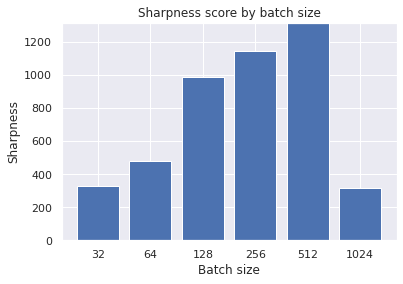

In [121]:
visualization.plot_sharpness(batch_sizes, sharpnesses, key, learning_rates)

#### Distance from initial weights

Batch size: 32, distance: 0.0
Batch size: 64, distance: 0.0
Batch size: 128, distance: 0.0
Batch size: 256, distance: 0.0
Batch size: 512, distance: 0.0
Batch size: 1024, distance: 0.0


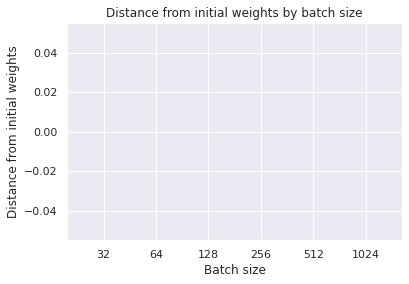

In [122]:
visualization.plot_distance_from_initial_weight(models, initial_weights, batch_sizes, key, learning_rates)

#### Runtime

In [123]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states,
                                                                                                     batch_sizes, key)

Batch size:  32
	Mean time per epoch:  7.258296015821857
	Converged in 232 epochs
	Overall training time (in seconds) until convergence:  1686.557436466217
Batch size:  64
	Mean time per epoch:  4.104581194186429
	Converged in 207 epochs
	Overall training time (in seconds) until convergence:  849.3889408111572
Batch size:  128
	Mean time per epoch:  3.0157666564676804
	Converged in 162 epochs
	Overall training time (in seconds) until convergence:  488.7900516986847
Batch size:  256
	Mean time per epoch:  2.4694832080119364
	Converged in 137 epochs
	Overall training time (in seconds) until convergence:  338.6031699180603
Batch size:  512
	Mean time per epoch:  2.2436986904877885
	Converged in 119 epochs
	Overall training time (in seconds) until convergence:  267.1299810409546
Batch size:  1024
	Mean time per epoch:  2.086645646528764
	Converged in 143 epochs
	Overall training time (in seconds) until convergence:  298.6876561641693


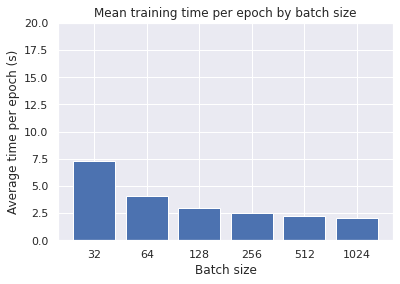

In [124]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

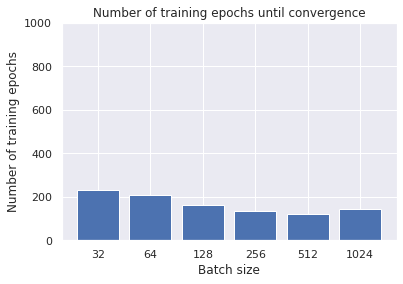

In [125]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

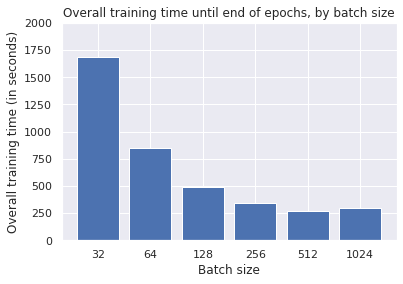

In [126]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

In [127]:
# Save to Drive in case we run on Google Colab
if USE_COLAB:
    !cp -r /content/graphs/ /content/drive/MyDrive/
    !cp -r /content/tmp/ /content/drive/MyDrive/

### ADAM + SAM

In [128]:
learning_rates = [0.001, 0.002, 0.004, 0.008, 0.016, 0.032]
batch_sizes = [32, 64, 128, 256, 512, 1024]
training_epochs = EPOCHS

key = ('increasing', 'adam', 'sam')

In [129]:
state_filename = 'model_diff_lr_diff_bs_adam_sam_state'

In [130]:
if not RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                          batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.Adam(learning_rate=lr)
        model = build_and_load_sam_model_weights(train, optimizer,
                                                 filename_bs_lr_opt_sam(batch_size, lr, "ADAM", "SAM"))
        models[key + (batch_size, lr)] = model

In [131]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size, lr in zip(batch_sizes, learning_rates):
        with tf.distribute.MirroredStrategy().scope():
            # Read training data
            train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                              batch_size=batch_size,
                                                                              img_size=32)

            optimizer = keras.optimizers.Adam(learning_rate=lr)
            model = tf_models.build_simple_cnn_sam(train, optimizer)
            train_callbacks = callback_for_filename(filename_bs_lr_opt_sam(batch_size, lr, "ADAM", "SAM"))

            models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                  extra_callbacks=train_callbacks, verbose=1)
            models[key + (batch_size, lr)] = model
            initial_weights[key + (batch_size, lr)] = model.get_weights()
            ml_utils.save_initial_weights_dict(initial_weights)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 05:27:17.871629: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
1500/1500 [==============================] - ETA: 0s - loss: 0.4891 - accuracy: 0.8130

2022-02-26 05:27:26.661789: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.32399, saving model to tmp/model_lr_0.001_diff_bs_32_opt_ADAM_sam_SAM.tf
1500/1500 [==============================] - 11s 5ms/step - loss: 0.4891 - accuracy: 0.8130 - val_loss: 0.3240 - val_accuracy: 0.8838
Epoch 2/500
1493/1500 [============================>.] - ETA: 0s - loss: 0.3299 - accuracy: 0.8749
Epoch 2: val_loss improved from 0.32399 to 0.28115, saving model to tmp/model_lr_0.001_diff_bs_32_opt_ADAM_sam_SAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3297 - accuracy: 0.8750 - val_loss: 0.2812 - val_accuracy: 0.8978
Epoch 3/500
1497/1500 [============================>.] - ETA: 0s - loss: 0.2862 - accuracy: 0.8910
Epoch 3: val_loss improved from 0.28115 to 0.25640, saving model to tmp/model_lr_0.001_diff_bs_32_opt_ADAM_sam_SAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2862 - accuracy: 0.8910 - val_loss: 0.2564 - val_accuracy: 0.9071
Epoch 4/500
1496/1500 [============================

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 05:29:12.413865: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
740/750 [============================>.] - ETA: 0s - loss: 0.4838 - accuracy: 0.8155

2022-02-26 05:29:17.604872: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.32800, saving model to tmp/model_lr_0.002_diff_bs_64_opt_ADAM_sam_SAM.tf
750/750 [==============================] - 7s 7ms/step - loss: 0.4817 - accuracy: 0.8163 - val_loss: 0.3280 - val_accuracy: 0.8796
Epoch 2/500
744/750 [============================>.] - ETA: 0s - loss: 0.3237 - accuracy: 0.8786
Epoch 2: val_loss improved from 0.32800 to 0.28863, saving model to tmp/model_lr_0.002_diff_bs_64_opt_ADAM_sam_SAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.3230 - accuracy: 0.8788 - val_loss: 0.2886 - val_accuracy: 0.8922
Epoch 3/500
745/750 [============================>.] - ETA: 0s - loss: 0.2820 - accuracy: 0.8922
Epoch 3: val_loss improved from 0.28863 to 0.26196, saving model to tmp/model_lr_0.002_diff_bs_64_opt_ADAM_sam_SAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.2814 - accuracy: 0.8924 - val_loss: 0.2620 - val_accuracy: 0.9043
Epoch 4/500
746/750 [============================>.] - ETA: 0s

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Epoch 1/500


2022-02-26 05:30:15.594379: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


369/375 [============================>.] - ETA: 0s - loss: 0.4986 - accuracy: 0.8123

2022-02-26 05:30:19.934975: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.32886, saving model to tmp/model_lr_0.004_diff_bs_128_opt_ADAM_sam_SAM.tf
375/375 [==============================] - 6s 11ms/step - loss: 0.4959 - accuracy: 0.8133 - val_loss: 0.3289 - val_accuracy: 0.8819
Epoch 2/500
370/375 [============================>.] - ETA: 0s - loss: 0.3244 - accuracy: 0.8800
Epoch 2: val_loss improved from 0.32886 to 0.29152, saving model to tmp/model_lr_0.004_diff_bs_128_opt_ADAM_sam_SAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.3237 - accuracy: 0.8802 - val_loss: 0.2915 - val_accuracy: 0.8934
Epoch 3/500
372/375 [============================>.] - ETA: 0s - loss: 0.2797 - accuracy: 0.8948
Epoch 3: val_loss improved from 0.29152 to 0.26046, saving model to tmp/model_lr_0.004_diff_bs_128_opt_ADAM_sam_SAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2791 - accuracy: 0.8950 - val_loss: 0.2605 - val_accuracy: 0.9051
Epoch 4/500
369/375 [============================>.] - ETA

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 05:31:05.032305: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
185/188 [============================>.] - ETA: 0s - loss: 0.4930 - accuracy: 0.8145

2022-02-26 05:31:08.959209: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.33415, saving model to tmp/model_lr_0.008_diff_bs_256_opt_ADAM_sam_SAM.tf
188/188 [==============================] - 6s 21ms/step - loss: 0.4908 - accuracy: 0.8154 - val_loss: 0.3342 - val_accuracy: 0.8812
Epoch 2/500
184/188 [============================>.] - ETA: 0s - loss: 0.3162 - accuracy: 0.8830
Epoch 2: val_loss improved from 0.33415 to 0.29009, saving model to tmp/model_lr_0.008_diff_bs_256_opt_ADAM_sam_SAM.tf
188/188 [==============================] - 3s 13ms/step - loss: 0.3152 - accuracy: 0.8831 - val_loss: 0.2901 - val_accuracy: 0.8947
Epoch 3/500
187/188 [============================>.] - ETA: 0s - loss: 0.2753 - accuracy: 0.8967
Epoch 3: val_loss improved from 0.29009 to 0.27772, saving model to tmp/model_lr_0.008_diff_bs_256_opt_ADAM_sam_SAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.2751 - accuracy: 0.8967 - val_loss: 0.2777 - val_accuracy: 0.8976
Epoch 4/500
186/188 [============================>.] - E

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 05:31:46.719898: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
94/94 [==============================] - ETA: 0s - loss: 0.6697 - accuracy: 0.7530

2022-02-26 05:31:51.380241: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.36853, saving model to tmp/model_lr_0.016_diff_bs_512_opt_ADAM_sam_SAM.tf
94/94 [==============================] - 5s 27ms/step - loss: 0.6697 - accuracy: 0.7530 - val_loss: 0.3685 - val_accuracy: 0.8689
Epoch 2/500
93/94 [============================>.] - ETA: 0s - loss: 0.3537 - accuracy: 0.8696
Epoch 2: val_loss improved from 0.36853 to 0.30607, saving model to tmp/model_lr_0.016_diff_bs_512_opt_ADAM_sam_SAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.3528 - accuracy: 0.8700 - val_loss: 0.3061 - val_accuracy: 0.8928
Epoch 3/500
94/94 [==============================] - ETA: 0s - loss: 0.3090 - accuracy: 0.8854
Epoch 3: val_loss improved from 0.30607 to 0.29195, saving model to tmp/model_lr_0.016_diff_bs_512_opt_ADAM_sam_SAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.3090 - accuracy: 0.8854 - val_loss: 0.2919 - val_accuracy: 0.8972
Epoch 4/500
93/94 [============================>.] - ETA: 0s - los

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 05:32:30.766830: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
47/47 [==============================] - ETA: 0s - loss: 1.3506 - accuracy: 0.6089

2022-02-26 05:32:35.314856: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.53293, saving model to tmp/model_lr_0.032_diff_bs_1024_opt_ADAM_sam_SAM.tf
47/47 [==============================] - 6s 74ms/step - loss: 1.3506 - accuracy: 0.6089 - val_loss: 0.5329 - val_accuracy: 0.8098
Epoch 2/500
47/47 [==============================] - ETA: 0s - loss: 0.4893 - accuracy: 0.8198
Epoch 2: val_loss improved from 0.53293 to 0.41988, saving model to tmp/model_lr_0.032_diff_bs_1024_opt_ADAM_sam_SAM.tf
47/47 [==============================] - 2s 44ms/step - loss: 0.4893 - accuracy: 0.8198 - val_loss: 0.4199 - val_accuracy: 0.8520
Epoch 3/500
47/47 [==============================] - ETA: 0s - loss: 0.4161 - accuracy: 0.8476
Epoch 3: val_loss improved from 0.41988 to 0.38080, saving model to tmp/model_lr_0.032_diff_bs_1024_opt_ADAM_sam_SAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.4161 - accuracy: 0.8476 - val_loss: 0.3808 - val_accuracy: 0.8639
Epoch 4/500
47/47 [==============================] - ETA: 0s - 

Epoch 28/500
47/47 [==============================] - ETA: 0s - loss: 0.2612 - accuracy: 0.9006
Epoch 28: val_loss did not improve from 0.30209
47/47 [==============================] - 2s 45ms/step - loss: 0.2612 - accuracy: 0.9006 - val_loss: 0.3280 - val_accuracy: 0.8852
Epoch 29/500
47/47 [==============================] - ETA: 0s - loss: 0.2648 - accuracy: 0.8994
Epoch 29: val_loss did not improve from 0.30209
47/47 [==============================] - 2s 44ms/step - loss: 0.2648 - accuracy: 0.8994 - val_loss: 0.3232 - val_accuracy: 0.8870
Epoch 30/500
47/47 [==============================] - ETA: 0s - loss: 0.2614 - accuracy: 0.9009
Epoch 30: val_loss did not improve from 0.30209
47/47 [==============================] - 2s 45ms/step - loss: 0.2614 - accuracy: 0.9009 - val_loss: 0.3119 - val_accuracy: 0.8924
Epoch 31/500
47/47 [==============================] - ETA: 0s - loss: 0.2561 - accuracy: 0.9035
Epoch 31: val_loss did not improve from 0.30209
47/47 [===========================

In [132]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], state_filename)
else:
    models_states[key] = ml_utils.load_model_state(state_filename)

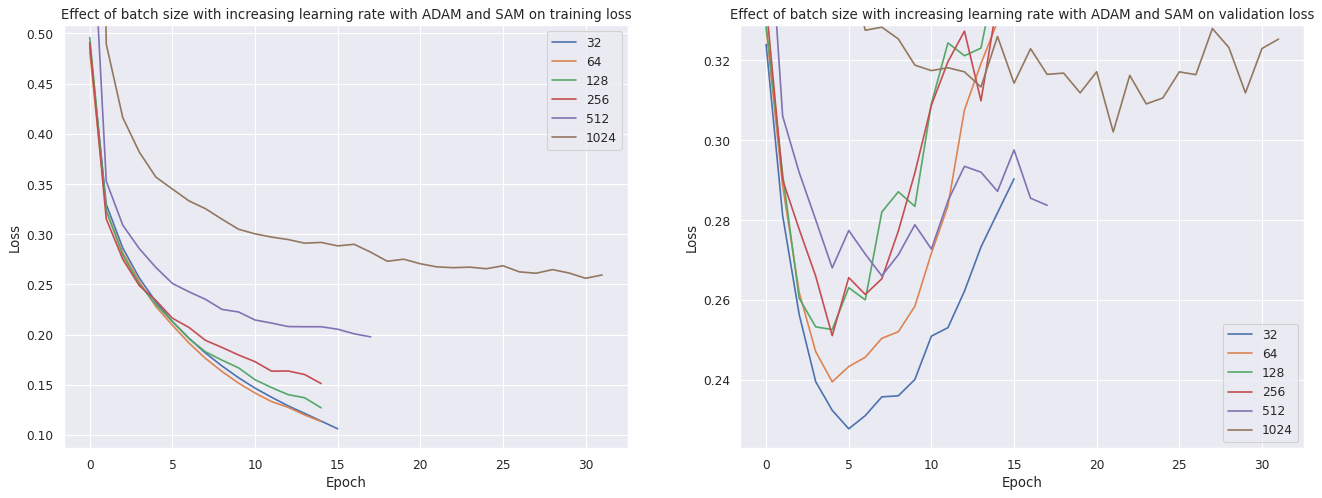

In [133]:
visualization.plot_loss_by_param(models_states[key], 'batch size with increasing learning rate with ADAM and SAM',
                                 'diff_lr_diff_bs_ADAM_SAM')

#### Sharpness

In [134]:
if RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        model = models[key + (batch_size, lr)]

        sharpness = visualization.get_sharpness(model.base_model, train)
        sharpnesses[key + (batch_size, lr)] = sharpness

        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG:
    sharpnesses = ml_utils.load_sharpnesses_dict()

2022-02-26 05:33:46.054527: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 12ms/step - loss: 0.1722 - accuracy: 0.9403
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.72150D-01    |proj g|=  2.13873D-02
47/47 [==============================] - 1s 12ms/step - loss: 1.8797 - accuracy: 0.5760

At iterate    1    f= -1.87967D+00    |proj g|=  3.03254D-02
  ys=-1.557E+02  -gs= 8.214E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 4.6540 - accuracy: 0.4601

At iterate    2    f= -4.65400D+00    |proj g|=  3.60038D-02
  ys=-9.096E+01  -gs= 8.053E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 5.3360 - accuracy: 0.4406

At iterate    3    f= -5.33596D+00    |proj g|=  3.06681D-02
47/47 [==============================] - 1s 12ms/step - loss: 5.4196 - accuracy: 0.4398

At iterate    4    f= -5.41959D+00    |p

2022-02-26 05:34:11.410679: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 14ms/step - loss: 0.1890 - accuracy: 0.9323
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.89049D-01    |proj g|=  1.82310D-02
47/47 [==============================] - 1s 13ms/step - loss: 1.0547 - accuracy: 0.6683

At iterate    1    f= -1.05472D+00    |proj g|=  3.49642D-02
  ys=-7.251E+01  -gs= 6.409E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 2.7940 - accuracy: 0.5576

At iterate    2    f= -2.79401D+00    |proj g|=  3.49435D-02
  ys=-8.317E+01  -gs= 4.279E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 3.3907 - accuracy: 0.5265

At iterate    3    f= -3.39074D+00    |proj g|=  3.45610D-02
  ys=-1.596E+00  -gs= 2.716E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 3.5375 - accura

2022-02-26 05:34:37.706229: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 14ms/step - loss: 0.1951 - accuracy: 0.9285
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.95058D-01    |proj g|=  1.78218D-02
47/47 [==============================] - 1s 12ms/step - loss: 0.8508 - accuracy: 0.8073

At iterate    1    f= -8.50803D-01    |proj g|=  3.18667D-02
  ys=-4.105E+01  -gs= 7.927E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 1.3398 - accuracy: 0.7466

At iterate    2    f= -1.33984D+00    |proj g|=  3.41836D-02
  ys=-2.381E+01  -gs= 1.365E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 14ms/step - loss: 1.6487 - accuracy: 0.7052

At iterate    3    f= -1.64873D+00    |proj g|=  3.37695D-02
  ys=-7.325E+00  -gs= 1.095E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 1.7532 - accura


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 11ms/step - loss: 1.8172 - accuracy: 0.6832

At iterate    5    f= -1.81725D+00    |proj g|=  3.37663D-02
47/47 [==============================] - 1s 13ms/step - loss: 1.8272 - accuracy: 0.6814

At iterate    6    f= -1.82724D+00    |proj g|=  3.37472D-02
47/47 [==============================] - 1s 12ms/step - loss: 1.8312 - accuracy: 0.6796

At iterate    7    f= -1.83122D+00    |proj g|=  3.37009D-02
47/47 [==============================] - 1s 11ms/step - loss: 1.8351 - accuracy: 0.6790

At iterate    8    f= -1.83515D+00    |proj g|=  3.36747D-02
47/47 [==============================] - 1s 11ms/step - loss: 1.8421 - accuracy: 0.6778

At iterate    9    f= -1.84214D+00    |proj g|=  3.36111D-02
11/47 [======>.......................] - ETA: 0s - loss: 1.8560 - accuracy: 0.6717


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 12ms/step - loss: 1.8297 - accuracy: 0.6737

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786     10     13  50800     3 45912   3.361D-02  -1.842D+00
  F =  -1.8421362638473511     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
2022-02-26 05:35:06.978671: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 11ms/step - loss: 0.1997 - accuracy: 0.9266
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.99674D-01    |proj g|=  2.37861D-02
47/47 [==============================] - 1s 13ms/step - loss: 0.7599 - accuracy: 0.7873

At iterate    1    f= -7.59924D-01    |proj g|=  3.96132D-02
  ys=-3.965E+01  -gs= 5.762E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 1.0866 - accuracy: 0.7609

At iterate    2    f= -1.08657D+00    |proj g|=  4.75721D-02
  ys=-6.007E+00  -gs= 1.199E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 1.1314 - accuracy: 0.7517

At iterate    3    f= -1.13138D+00    |proj g|=  3.30535D-02
47/47 [==============================] - 1s 12ms/step - loss: 1.1377 - accuracy: 0.7518

At iterate    4    f= -1.13771D+00    |p

2022-02-26 05:35:32.615128: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 13ms/step - loss: 0.2225 - accuracy: 0.9190
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.22472D-01    |proj g|=  2.27456D-02
47/47 [==============================] - 1s 12ms/step - loss: 0.5070 - accuracy: 0.8340

At iterate    1    f= -5.07014D-01    |proj g|=  3.88153D-02
  ys=-1.672E+01  -gs= 5.198E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 0.6344 - accuracy: 0.8163

At iterate    2    f= -6.34357D-01    |proj g|=  3.60433D-02
  ys=-4.928E+00  -gs= 3.890E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 0.6690 - accuracy: 0.8113

At iterate    3    f= -6.69044D-01    |proj g|=  3.13787D-02
  ys=-1.141E+00  -gs= 1.081E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 0.6761 - accura

2022-02-26 05:35:58.921533: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 14ms/step - loss: 0.2488 - accuracy: 0.9104
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.48825D-01    |proj g|=  3.06711D-02
47/47 [==============================] - 1s 12ms/step - loss: 0.4935 - accuracy: 0.8443

At iterate    1    f= -4.93517D-01    |proj g|=  3.81143D-02
  ys=-1.757E+01  -gs= 3.144E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 0.5670 - accuracy: 0.8258

At iterate    2    f= -5.66976D-01    |proj g|=  3.64108D-02
  ys=-1.753E+00  -gs= 2.594E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 0.5770 - accuracy: 0.8230

At iterate    3    f= -5.76970D-01    |proj g|=  3.72605D-02
  ys=-1.319E-01  -gs= 4.097E-01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 0.5803 - accura

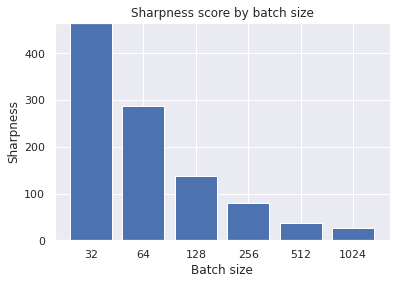

In [135]:
visualization.plot_sharpness(batch_sizes, sharpnesses, key, learning_rates)

#### Distance from initial weights

Batch size: 32, distance: 0.0
Batch size: 64, distance: 0.0
Batch size: 128, distance: 0.0
Batch size: 256, distance: 0.0
Batch size: 512, distance: 0.0
Batch size: 1024, distance: 0.0


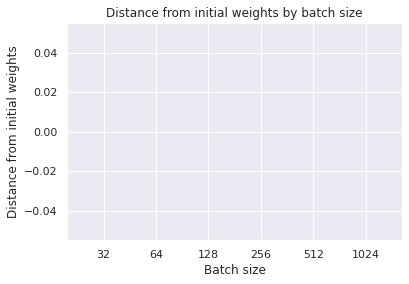

In [136]:
visualization.plot_distance_from_initial_weight(models, initial_weights, batch_sizes, key, learning_rates)

#### Runtime

In [137]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states,
                                                                                                     batch_sizes, key)

Batch size:  32
	Mean time per epoch:  7.084482133388519
	Converged in 5 epochs
	Overall training time (in seconds) until convergence:  38.09173607826233
Batch size:  64
	Mean time per epoch:  4.136044311523437
	Converged in 4 epochs
	Overall training time (in seconds) until convergence:  18.66538119316101
Batch size:  128
	Mean time per epoch:  3.2215401331583657
	Converged in 4 epochs
	Overall training time (in seconds) until convergence:  14.978500127792358
Batch size:  256
	Mean time per epoch:  2.7006359895070395
	Converged in 4 epochs
	Overall training time (in seconds) until convergence:  13.098477840423584
Batch size:  512
	Mean time per epoch:  2.370376017358568
	Converged in 7 epochs
	Overall training time (in seconds) until convergence:  18.510010480880737
Batch size:  1024
	Mean time per epoch:  2.2462184354662895
	Converged in 21 epochs
	Overall training time (in seconds) until convergence:  48.647486448287964


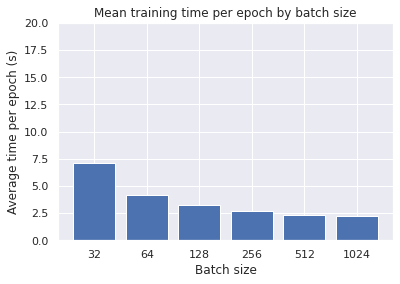

In [138]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

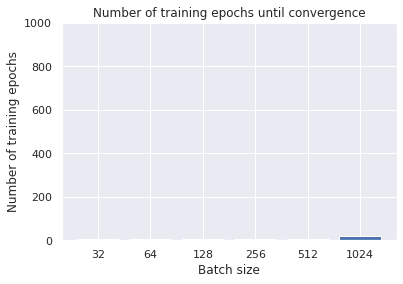

In [139]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

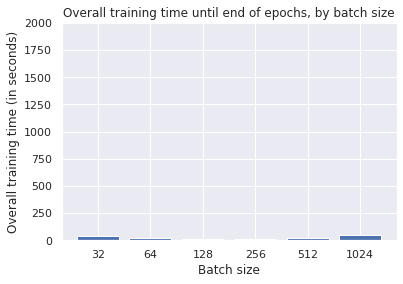

In [140]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

In [141]:
# Save to Drive in case we run on Google Colab
if USE_COLAB:
    !cp -r /content/graphs/ /content/drive/MyDrive/
    !cp -r /content/tmp/ /content/drive/MyDrive/

## ADAM + ASAM

In [142]:
learning_rates = [0.001, 0.002, 0.004, 0.008, 0.016, 0.032]
batch_sizes = [32, 64, 128, 256, 512, 1024]
training_epochs = EPOCHS

key = ('increasing', 'adam', 'asam')

In [143]:
state_filename = 'model_diff_lr_diff_bs_adam_asam_state'

In [144]:
if not RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                          batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.Adam(learning_rate=lr)
        model = build_and_load_sam_model_weights(train, optimizer,
                                                 filename_bs_lr_opt_sam(batch_size, lr, "ADAM", "ASAM"))
        models[key + (batch_size, lr)] = model

In [145]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size, lr in zip(batch_sizes, learning_rates):
        with tf.distribute.MirroredStrategy().scope():
            # Read training data
            train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                              batch_size=batch_size,
                                                                              img_size=32)

            optimizer = keras.optimizers.Adam(learning_rate=lr)
            model = tf_models.build_simple_cnn_sam(train, optimizer)
            train_callbacks = callback_for_filename(filename_bs_lr_opt_sam(batch_size, lr, "ADAM", "ASAM"))

            models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                  extra_callbacks=train_callbacks, verbose=1)
            models[key + (batch_size, lr)] = model
            initial_weights[key + (batch_size, lr)] = model.get_weights()
            ml_utils.save_initial_weights_dict(initial_weights)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 05:36:25.625866: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
1487/1500 [============================>.] - ETA: 0s - loss: 0.4933 - accuracy: 0.8102

2022-02-26 05:36:33.185056: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.32793, saving model to tmp/model_lr_0.001_diff_bs_32_opt_ADAM_sam_ASAM.tf
1500/1500 [==============================] - 9s 5ms/step - loss: 0.4917 - accuracy: 0.8108 - val_loss: 0.3279 - val_accuracy: 0.8817
Epoch 2/500
1488/1500 [============================>.] - ETA: 0s - loss: 0.3307 - accuracy: 0.8743
Epoch 2: val_loss improved from 0.32793 to 0.28023, saving model to tmp/model_lr_0.001_diff_bs_32_opt_ADAM_sam_ASAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3300 - accuracy: 0.8745 - val_loss: 0.2802 - val_accuracy: 0.8993
Epoch 3/500
1491/1500 [============================>.] - ETA: 0s - loss: 0.2844 - accuracy: 0.8900
Epoch 3: val_loss improved from 0.28023 to 0.25331, saving model to tmp/model_lr_0.001_diff_bs_32_opt_ADAM_sam_ASAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.2840 - accuracy: 0.8901 - val_loss: 0.2533 - val_accuracy: 0.9082
Epoch 4/500
1497/1500 [==========================

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 05:38:21.603574: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
750/750 [==============================] - ETA: 0s - loss: 0.4767 - accuracy: 0.8175

2022-02-26 05:38:25.670643: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.32068, saving model to tmp/model_lr_0.002_diff_bs_64_opt_ADAM_sam_ASAM.tf
750/750 [==============================] - 5s 6ms/step - loss: 0.4767 - accuracy: 0.8175 - val_loss: 0.3207 - val_accuracy: 0.8818
Epoch 2/500
744/750 [============================>.] - ETA: 0s - loss: 0.3198 - accuracy: 0.8806
Epoch 2: val_loss improved from 0.32068 to 0.27605, saving model to tmp/model_lr_0.002_diff_bs_64_opt_ADAM_sam_ASAM.tf
750/750 [==============================] - 4s 6ms/step - loss: 0.3191 - accuracy: 0.8806 - val_loss: 0.2760 - val_accuracy: 0.8982
Epoch 3/500
745/750 [============================>.] - ETA: 0s - loss: 0.2761 - accuracy: 0.8949
Epoch 3: val_loss improved from 0.27605 to 0.24999, saving model to tmp/model_lr_0.002_diff_bs_64_opt_ADAM_sam_ASAM.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.2756 - accuracy: 0.8949 - val_loss: 0.2500 - val_accuracy: 0.9072
Epoch 4/500
749/750 [============================>.] - ETA:

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 05:39:28.876833: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
369/375 [============================>.] - ETA: 0s - loss: 0.4791 - accuracy: 0.8183

2022-02-26 05:39:32.052604: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.33437, saving model to tmp/model_lr_0.004_diff_bs_128_opt_ADAM_sam_ASAM.tf
375/375 [==============================] - 4s 9ms/step - loss: 0.4767 - accuracy: 0.8192 - val_loss: 0.3344 - val_accuracy: 0.8808
Epoch 2/500
374/375 [============================>.] - ETA: 0s - loss: 0.3158 - accuracy: 0.8824
Epoch 2: val_loss improved from 0.33437 to 0.28339, saving model to tmp/model_lr_0.004_diff_bs_128_opt_ADAM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.3157 - accuracy: 0.8825 - val_loss: 0.2834 - val_accuracy: 0.8969
Epoch 3/500
374/375 [============================>.] - ETA: 0s - loss: 0.2735 - accuracy: 0.8966
Epoch 3: val_loss improved from 0.28339 to 0.25822, saving model to tmp/model_lr_0.004_diff_bs_128_opt_ADAM_sam_ASAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2734 - accuracy: 0.8966 - val_loss: 0.2582 - val_accuracy: 0.9053
Epoch 4/500
373/375 [============================>.] - E

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 05:40:13.808269: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
186/188 [============================>.] - ETA: 0s - loss: 0.5202 - accuracy: 0.8076

2022-02-26 05:40:16.541531: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.34135, saving model to tmp/model_lr_0.008_diff_bs_256_opt_ADAM_sam_ASAM.tf
188/188 [==============================] - 4s 20ms/step - loss: 0.5184 - accuracy: 0.8082 - val_loss: 0.3413 - val_accuracy: 0.8773
Epoch 2/500
185/188 [============================>.] - ETA: 0s - loss: 0.3270 - accuracy: 0.8800
Epoch 2: val_loss improved from 0.34135 to 0.29512, saving model to tmp/model_lr_0.008_diff_bs_256_opt_ADAM_sam_ASAM.tf
188/188 [==============================] - 3s 14ms/step - loss: 0.3262 - accuracy: 0.8802 - val_loss: 0.2951 - val_accuracy: 0.8923
Epoch 3/500
184/188 [============================>.] - ETA: 0s - loss: 0.2841 - accuracy: 0.8929
Epoch 3: val_loss improved from 0.29512 to 0.27160, saving model to tmp/model_lr_0.008_diff_bs_256_opt_ADAM_sam_ASAM.tf
188/188 [==============================] - 3s 13ms/step - loss: 0.2837 - accuracy: 0.8928 - val_loss: 0.2716 - val_accuracy: 0.9000
Epoch 4/500
186/188 [============================>.] 

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 05:40:54.757679: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
92/94 [============================>.] - ETA: 0s - loss: 0.6063 - accuracy: 0.7773

2022-02-26 05:40:58.342234: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.35458, saving model to tmp/model_lr_0.016_diff_bs_512_opt_ADAM_sam_ASAM.tf
94/94 [==============================] - 5s 38ms/step - loss: 0.6011 - accuracy: 0.7790 - val_loss: 0.3546 - val_accuracy: 0.8758
Epoch 2/500
94/94 [==============================] - ETA: 0s - loss: 0.3334 - accuracy: 0.8773
Epoch 2: val_loss improved from 0.35458 to 0.29462, saving model to tmp/model_lr_0.016_diff_bs_512_opt_ADAM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.3334 - accuracy: 0.8773 - val_loss: 0.2946 - val_accuracy: 0.8948
Epoch 3/500
94/94 [==============================] - ETA: 0s - loss: 0.2907 - accuracy: 0.8921
Epoch 3: val_loss improved from 0.29462 to 0.27921, saving model to tmp/model_lr_0.016_diff_bs_512_opt_ADAM_sam_ASAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.2907 - accuracy: 0.8921 - val_loss: 0.2792 - val_accuracy: 0.9009
Epoch 4/500
92/94 [============================>.] - ETA: 0s - 

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 05:41:30.209737: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
47/47 [==============================] - ETA: 0s - loss: 1.0721 - accuracy: 0.6572

2022-02-26 05:41:32.663299: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.44795, saving model to tmp/model_lr_0.032_diff_bs_1024_opt_ADAM_sam_ASAM.tf
47/47 [==============================] - 3s 52ms/step - loss: 1.0721 - accuracy: 0.6572 - val_loss: 0.4479 - val_accuracy: 0.8409
Epoch 2/500
47/47 [==============================] - ETA: 0s - loss: 0.4248 - accuracy: 0.8422
Epoch 2: val_loss improved from 0.44795 to 0.35196, saving model to tmp/model_lr_0.032_diff_bs_1024_opt_ADAM_sam_ASAM.tf
47/47 [==============================] - 2s 45ms/step - loss: 0.4248 - accuracy: 0.8422 - val_loss: 0.3520 - val_accuracy: 0.8717
Epoch 3/500
47/47 [==============================] - ETA: 0s - loss: 0.3586 - accuracy: 0.8660
Epoch 3: val_loss improved from 0.35196 to 0.31740, saving model to tmp/model_lr_0.032_diff_bs_1024_opt_ADAM_sam_ASAM.tf
47/47 [==============================] - 2s 44ms/step - loss: 0.3586 - accuracy: 0.8660 - val_loss: 0.3174 - val_accuracy: 0.8870
Epoch 4/500
47/47 [==============================] - ETA: 0s

In [146]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], state_filename)
else:
    models_states[key] = ml_utils.load_model_state(state_filename)

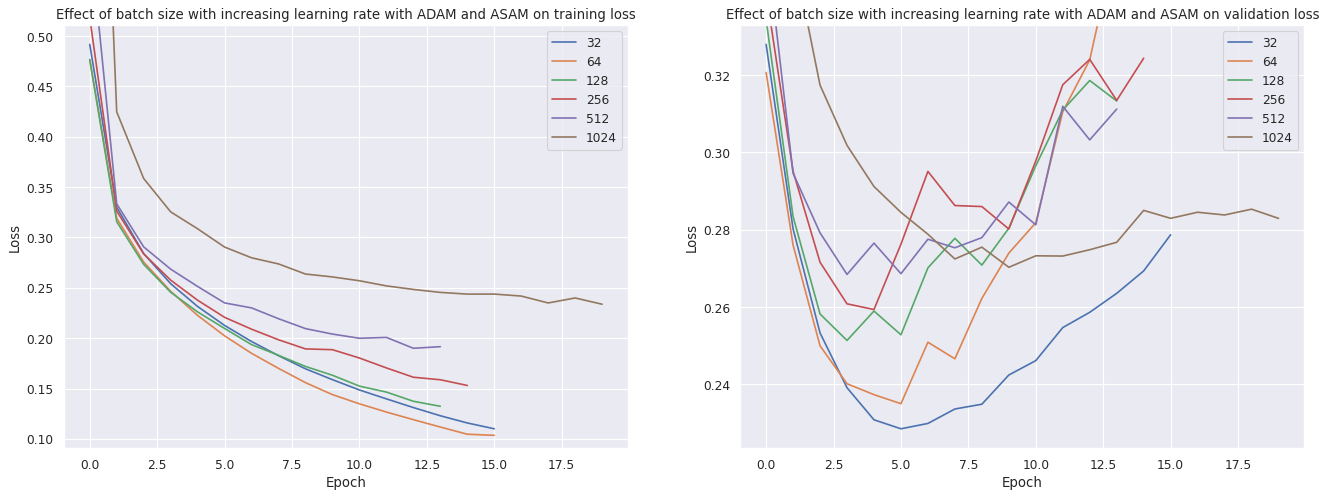

In [147]:
visualization.plot_loss_by_param(models_states[key], 'batch size with increasing learning rate with ADAM and ASAM',
                                 'diff_lr_diff_bs_ADAM_ASAM')

#### Sharpness

In [148]:
if RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        model = models[key + (batch_size, lr)]

        sharpness = visualization.get_sharpness(model.base_model, train)
        sharpnesses[key + (batch_size, lr)] = sharpness

        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG:
    sharpnesses = ml_utils.load_sharpnesses_dict()

2022-02-26 05:42:14.687738: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 13ms/step - loss: 0.1726 - accuracy: 0.9403
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.72648D-01    |proj g|=  2.11173D-02
47/47 [==============================] - 1s 11ms/step - loss: 2.1547 - accuracy: 0.5859

At iterate    1    f= -2.15466D+00    |proj g|=  4.22347D-02
  ys=-1.767E+02  -gs= 8.809E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 3.9787 - accuracy: 0.5364

At iterate    2    f= -3.97872D+00    |proj g|=  4.32708D-02
  ys=-3.040E+01  -gs= 7.086E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 13ms/step - loss: 4.4633 - accuracy: 0.4700

At iterate    3    f= -4.46331D+00    |proj g|=  2.95381D-02
47/47 [==============================] - 1s 12ms/step - loss: 4.5728 - accuracy: 0.4665

At iterate    4    f= -4.57285D+00    |p

2022-02-26 05:42:39.350979: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 12ms/step - loss: 0.1640 - accuracy: 0.9414
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.63957D-01    |proj g|=  1.97867D-02
47/47 [==============================] - 1s 12ms/step - loss: 1.4245 - accuracy: 0.6516

At iterate    1    f= -1.42451D+00    |proj g|=  3.83658D-02
  ys=-1.215E+02  -gs= 5.911E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 3.0728 - accuracy: 0.5549

At iterate    2    f= -3.07279D+00    |proj g|=  3.37067D-02
  ys=-4.486E+01  -gs= 5.283E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 3.3534 - accuracy: 0.5450

At iterate    3    f= -3.35344D+00    |proj g|=  3.00166D-02
47/47 [==============================] - 1s 12ms/step - loss: 3.3882 - accuracy: 0.5452

At iterate    4    f= -3.38817D+00    |p

2022-02-26 05:43:05.562054: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 13ms/step - loss: 0.2071 - accuracy: 0.9247
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.07144D-01    |proj g|=  2.12899D-02
47/47 [==============================] - 1s 11ms/step - loss: 0.9980 - accuracy: 0.7678

At iterate    1    f= -9.98029D-01    |proj g|=  3.39081D-02
  ys=-5.436E+01  -gs= 8.817E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 1.8126 - accuracy: 0.6976

At iterate    2    f= -1.81260D+00    |proj g|=  3.18238D-02
  ys=-1.674E+01  -gs= 2.347E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 2.0615 - accuracy: 0.6538

At iterate    3    f= -2.06152D+00    |proj g|=  3.23491D-02
47/47 [==============================] - 1s 12ms/step - loss: 2.2409 - accuracy: 0.6384

At iterate    4    f= -2.24095D+00    |p

2022-02-26 05:43:30.509816: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 13ms/step - loss: 0.2059 - accuracy: 0.9243
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.05917D-01    |proj g|=  2.16113D-02
47/47 [==============================] - 1s 11ms/step - loss: 1.0301 - accuracy: 0.7672

At iterate    1    f= -1.03014D+00    |proj g|=  3.86938D-02
  ys=-5.945E+01  -gs= 8.133E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 1.3118 - accuracy: 0.7248

At iterate    2    f= -1.31179D+00    |proj g|=  3.86938D-02
47/47 [==============================] - 1s 11ms/step - loss: 1.4296 - accuracy: 0.7183

At iterate    3    f= -1.42956D+00    |proj g|=  3.85950D-02
  ys=-6.365E-01  -gs= 4.955E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 1.5097 - accuracy: 0.7141

At iterate    4    f= -1.50975D+00    |p

2022-02-26 05:43:55.290703: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 13ms/step - loss: 0.2353 - accuracy: 0.9157
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.35309D-01    |proj g|=  2.37693D-02
47/47 [==============================] - 1s 10ms/step - loss: 0.6585 - accuracy: 0.8411

At iterate    1    f= -6.58481D-01    |proj g|=  3.17971D-02
  ys=-2.544E+01  -gs= 6.128E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 0.8236 - accuracy: 0.8155

At iterate    2    f= -8.23627D-01    |proj g|=  3.44347D-02
  ys=-5.704E+00  -gs= 5.108E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 0.8877 - accuracy: 0.7985

At iterate    3    f= -8.87707D-01    |proj g|=  3.22630D-02
  ys=-1.016E+00  -gs= 2.539E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 0.8872 - accura


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
2022-02-26 05:44:08.822354: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      4      5  22362     3 21056   3.226D-02  -8.877D-01
  F = -0.88770717382431030     

ABNORMAL_TERMINATION_IN_LNSRCH                              
47/47 [==============================] - 1s 13ms/step - loss: 0.2338 - accuracy: 0.9143
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.33825D-01    |proj g|=  2.72681D-02
47/47 [==============================] - 1s 11ms/step - loss: 0.4482 - accuracy: 0.8397

At iterate    1  

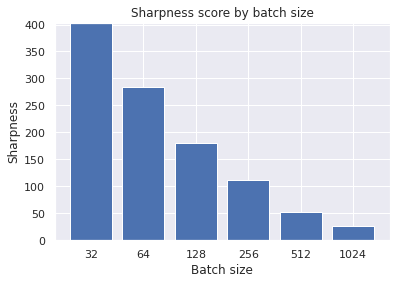

In [149]:
visualization.plot_sharpness(batch_sizes, sharpnesses, key, learning_rates)

#### Distance from initial weights

Batch size: 32, distance: 0.0
Batch size: 64, distance: 0.0
Batch size: 128, distance: 0.0
Batch size: 256, distance: 0.0
Batch size: 512, distance: 0.0
Batch size: 1024, distance: 0.0


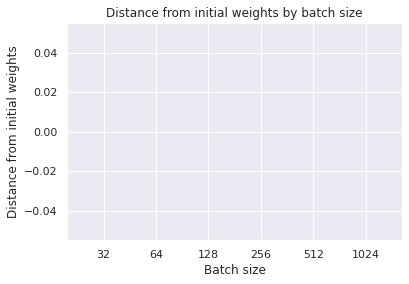

In [150]:
visualization.plot_distance_from_initial_weight(models, initial_weights, batch_sizes, key, learning_rates)

#### Runtime

In [151]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states,
                                                                                                     batch_sizes, key)

Batch size:  32
	Mean time per epoch:  7.180504143238068
	Converged in 5 epochs
	Overall training time (in seconds) until convergence:  38.3105103969574
Batch size:  64
	Mean time per epoch:  4.134653881192207
	Converged in 5 epochs
	Overall training time (in seconds) until convergence:  21.070324182510376
Batch size:  128
	Mean time per epoch:  3.1394831453050887
	Converged in 3 epochs
	Overall training time (in seconds) until convergence:  9.928798913955688
Batch size:  256
	Mean time per epoch:  2.6536882400512694
	Converged in 4 epochs
	Overall training time (in seconds) until convergence:  11.860092639923096
Batch size:  512
	Mean time per epoch:  2.447423117501395
	Converged in 3 epochs
	Overall training time (in seconds) until convergence:  9.636416673660278
Batch size:  1024
	Mean time per epoch:  2.118030297756195
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  19.500064611434937


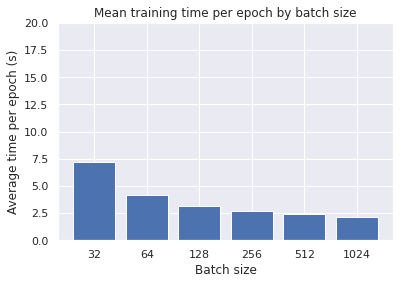

In [152]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

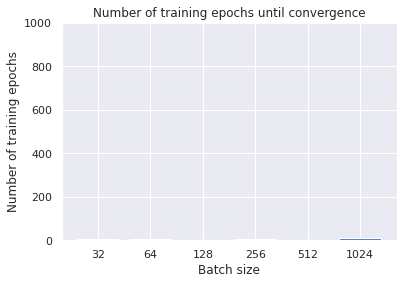

In [153]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

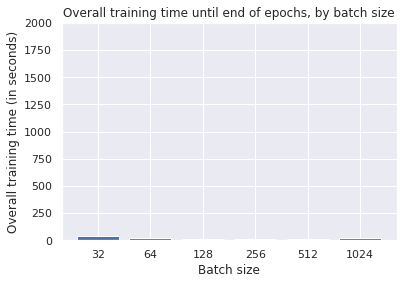

In [154]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

In [155]:
# Save to Drive in case we run on Google Colab
if USE_COLAB:
    !cp -r /content/graphs/ /content/drive/MyDrive/
    !cp -r /content/tmp/ /content/drive/MyDrive/

## without sharpness aware minimization

### SGD with Momentum

In [156]:
learning_rates = [0.001, 0.002, 0.004, 0.008, 0.016, 0.032]
batch_sizes = [32, 64, 128, 256, 512, 1024]
training_epochs = EPOCHS

key = ('increasing', 'SGD', 'none')

In [157]:
state_filename = 'model_diff_lr_diff_bs_sgd_state'

In [158]:
if not RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                          batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        model = build_and_load_model_weights(train, optimizer,
                                             filename_bs_lr_opt_sam(batch_size, lr, "SGD", "NONE"))
        models[key + (batch_size, lr)] = model

In [159]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size, lr in zip(batch_sizes, learning_rates):
        with tf.distribute.MirroredStrategy().scope():
            # Read training data
            train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                              batch_size=batch_size,
                                                                              img_size=32)

            optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
            model = tf_models.build_and_compile_simple_cnn(train, optimizer)
            train_callbacks = callback_for_filename(filename_bs_lr_opt_sam(batch_size, lr, "SGD", "NONE"))

            models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                  extra_callbacks=train_callbacks, verbose=1)
            models[key + (batch_size, lr)] = model
            initial_weights[key + (batch_size, lr)] = model.get_weights()
            ml_utils.save_initial_weights_dict(initial_weights)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 05:44:34.852654: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
1497/1500 [============================>.] - ETA: 0s - loss: 0.9613 - accuracy: 0.6503

2022-02-26 05:44:39.677051: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.69272, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD_sam_NONE.tf
1500/1500 [==============================] - 6s 4ms/step - loss: 0.9608 - accuracy: 0.6505 - val_loss: 0.6927 - val_accuracy: 0.7722
Epoch 2/500
1493/1500 [============================>.] - ETA: 0s - loss: 0.6829 - accuracy: 0.7543
Epoch 2: val_loss improved from 0.69272 to 0.63687, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD_sam_NONE.tf
1500/1500 [==============================] - 5s 4ms/step - loss: 0.6826 - accuracy: 0.7545 - val_loss: 0.6369 - val_accuracy: 0.7824
Epoch 3/500
1488/1500 [============================>.] - ETA: 0s - loss: 0.6145 - accuracy: 0.7779
Epoch 3: val_loss improved from 0.63687 to 0.58144, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD_sam_NONE.tf
1500/1500 [==============================] - 5s 4ms/step - loss: 0.6136 - accuracy: 0.7781 - val_loss: 0.5814 - val_accuracy: 0.7952
Epoch 4/500
1495/1500 [============================>

1500/1500 [==============================] - 5s 4ms/step - loss: 0.3575 - accuracy: 0.8728 - val_loss: 0.3122 - val_accuracy: 0.8914
Epoch 25/500
1483/1500 [============================>.] - ETA: 0s - loss: 0.3522 - accuracy: 0.8762
Epoch 25: val_loss improved from 0.31219 to 0.30579, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD_sam_NONE.tf
1500/1500 [==============================] - 5s 4ms/step - loss: 0.3517 - accuracy: 0.8764 - val_loss: 0.3058 - val_accuracy: 0.8927
Epoch 26/500
1495/1500 [============================>.] - ETA: 0s - loss: 0.3465 - accuracy: 0.8776
Epoch 26: val_loss improved from 0.30579 to 0.30239, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD_sam_NONE.tf
1500/1500 [==============================] - 5s 4ms/step - loss: 0.3465 - accuracy: 0.8774 - val_loss: 0.3024 - val_accuracy: 0.8947
Epoch 27/500
1500/1500 [==============================] - ETA: 0s - loss: 0.3463 - accuracy: 0.8774
Epoch 27: val_loss did not improve from 0.30239
1500/1500 [====

1500/1500 [==============================] - ETA: 0s - loss: 0.3026 - accuracy: 0.8923
Epoch 49: val_loss did not improve from 0.26098
1500/1500 [==============================] - 5s 4ms/step - loss: 0.3026 - accuracy: 0.8923 - val_loss: 0.2620 - val_accuracy: 0.9072
Epoch 50/500
1484/1500 [============================>.] - ETA: 0s - loss: 0.3020 - accuracy: 0.8932
Epoch 50: val_loss improved from 0.26098 to 0.25990, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD_sam_NONE.tf
1500/1500 [==============================] - 5s 4ms/step - loss: 0.3014 - accuracy: 0.8933 - val_loss: 0.2599 - val_accuracy: 0.9094
Epoch 51/500
1496/1500 [============================>.] - ETA: 0s - loss: 0.3029 - accuracy: 0.8924
Epoch 51: val_loss did not improve from 0.25990
1500/1500 [==============================] - 5s 4ms/step - loss: 0.3027 - accuracy: 0.8925 - val_loss: 0.2609 - val_accuracy: 0.9093
Epoch 52/500
1484/1500 [============================>.] - ETA: 0s - loss: 0.3031 - accuracy: 0.8928

Epoch 75/500
1487/1500 [============================>.] - ETA: 0s - loss: 0.2784 - accuracy: 0.8989
Epoch 75: val_loss improved from 0.24184 to 0.24065, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD_sam_NONE.tf
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2777 - accuracy: 0.8991 - val_loss: 0.2406 - val_accuracy: 0.9162
Epoch 76/500
1488/1500 [============================>.] - ETA: 0s - loss: 0.2762 - accuracy: 0.9022
Epoch 76: val_loss did not improve from 0.24065
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2758 - accuracy: 0.9024 - val_loss: 0.2449 - val_accuracy: 0.9138
Epoch 77/500
1491/1500 [============================>.] - ETA: 0s - loss: 0.2784 - accuracy: 0.9017
Epoch 77: val_loss did not improve from 0.24065
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2778 - accuracy: 0.9019 - val_loss: 0.2419 - val_accuracy: 0.9148
Epoch 78/500
1488/1500 [============================>.] - ETA: 0s - loss: 0.2764 - acc

Epoch 101/500
1497/1500 [============================>.] - ETA: 0s - loss: 0.2651 - accuracy: 0.9045
Epoch 101: val_loss improved from 0.23169 to 0.23132, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD_sam_NONE.tf
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2649 - accuracy: 0.9046 - val_loss: 0.2313 - val_accuracy: 0.9193
Epoch 102/500
1484/1500 [============================>.] - ETA: 0s - loss: 0.2636 - accuracy: 0.9052
Epoch 102: val_loss did not improve from 0.23132
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2630 - accuracy: 0.9052 - val_loss: 0.2341 - val_accuracy: 0.9175
Epoch 103/500
1499/1500 [============================>.] - ETA: 0s - loss: 0.2611 - accuracy: 0.9057
Epoch 103: val_loss improved from 0.23132 to 0.23078, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD_sam_NONE.tf
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2610 - accuracy: 0.9057 - val_loss: 0.2308 - val_accuracy: 0.9187
Epoch 104

1500/1500 [==============================] - 5s 3ms/step - loss: 0.2534 - accuracy: 0.9088 - val_loss: 0.2249 - val_accuracy: 0.9203
Epoch 128/500
1499/1500 [============================>.] - ETA: 0s - loss: 0.2510 - accuracy: 0.9104
Epoch 128: val_loss did not improve from 0.22281
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2510 - accuracy: 0.9104 - val_loss: 0.2246 - val_accuracy: 0.9198
Epoch 129/500
1491/1500 [============================>.] - ETA: 0s - loss: 0.2521 - accuracy: 0.9094
Epoch 129: val_loss did not improve from 0.22281
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2517 - accuracy: 0.9096 - val_loss: 0.2238 - val_accuracy: 0.9217
Epoch 130/500
1488/1500 [============================>.] - ETA: 0s - loss: 0.2503 - accuracy: 0.9110
Epoch 130: val_loss improved from 0.22281 to 0.22234, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD_sam_NONE.tf
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2496 - accura

Epoch 155/500
1493/1500 [============================>.] - ETA: 0s - loss: 0.2417 - accuracy: 0.9120
Epoch 155: val_loss did not improve from 0.21761
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2414 - accuracy: 0.9121 - val_loss: 0.2177 - val_accuracy: 0.9237
Epoch 156/500
1488/1500 [============================>.] - ETA: 0s - loss: 0.2426 - accuracy: 0.9130
Epoch 156: val_loss did not improve from 0.21761
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2420 - accuracy: 0.9133 - val_loss: 0.2184 - val_accuracy: 0.9211
Epoch 157/500
1499/1500 [============================>.] - ETA: 0s - loss: 0.2410 - accuracy: 0.9128
Epoch 157: val_loss improved from 0.21761 to 0.21641, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD_sam_NONE.tf
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2410 - accuracy: 0.9128 - val_loss: 0.2164 - val_accuracy: 0.9223
Epoch 158/500
1486/1500 [============================>.] - ETA: 0s - loss: 0.241

1485/1500 [============================>.] - ETA: 0s - loss: 0.2371 - accuracy: 0.9143
Epoch 182: val_loss improved from 0.21374 to 0.21364, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD_sam_NONE.tf
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2365 - accuracy: 0.9145 - val_loss: 0.2136 - val_accuracy: 0.9239
Epoch 183/500
1493/1500 [============================>.] - ETA: 0s - loss: 0.2386 - accuracy: 0.9129
Epoch 183: val_loss did not improve from 0.21364
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2384 - accuracy: 0.9130 - val_loss: 0.2179 - val_accuracy: 0.9227
Epoch 184/500
1486/1500 [============================>.] - ETA: 0s - loss: 0.2375 - accuracy: 0.9152
Epoch 184: val_loss did not improve from 0.21364
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2368 - accuracy: 0.9156 - val_loss: 0.2145 - val_accuracy: 0.9246
Epoch 185/500
1498/1500 [============================>.] - ETA: 0s - loss: 0.2396 - accuracy: 

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 06:02:27.005150: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
738/750 [============================>.] - ETA: 0s - loss: 1.0055 - accuracy: 0.6295

2022-02-26 06:02:30.939085: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.71651, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD_sam_NONE.tf
750/750 [==============================] - 5s 4ms/step - loss: 1.0014 - accuracy: 0.6311 - val_loss: 0.7165 - val_accuracy: 0.7617
Epoch 2/500
734/750 [============================>.] - ETA: 0s - loss: 0.6946 - accuracy: 0.7488
Epoch 2: val_loss improved from 0.71651 to 0.63063, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD_sam_NONE.tf
750/750 [==============================] - 3s 4ms/step - loss: 0.6934 - accuracy: 0.7494 - val_loss: 0.6306 - val_accuracy: 0.7916
Epoch 3/500
738/750 [============================>.] - ETA: 0s - loss: 0.6092 - accuracy: 0.7820
Epoch 3: val_loss improved from 0.63063 to 0.55640, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD_sam_NONE.tf
750/750 [==============================] - 3s 4ms/step - loss: 0.6085 - accuracy: 0.7822 - val_loss: 0.5564 - val_accuracy: 0.8108
Epoch 4/500
735/750 [============================>.] - ETA: 0s

747/750 [============================>.] - ETA: 0s - loss: 0.3509 - accuracy: 0.8750
Epoch 25: val_loss improved from 0.30409 to 0.29898, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD_sam_NONE.tf
750/750 [==============================] - 3s 4ms/step - loss: 0.3507 - accuracy: 0.8750 - val_loss: 0.2990 - val_accuracy: 0.8967
Epoch 26/500
744/750 [============================>.] - ETA: 0s - loss: 0.3470 - accuracy: 0.8769
Epoch 26: val_loss improved from 0.29898 to 0.29386, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD_sam_NONE.tf
750/750 [==============================] - 3s 4ms/step - loss: 0.3463 - accuracy: 0.8771 - val_loss: 0.2939 - val_accuracy: 0.8994
Epoch 27/500
740/750 [============================>.] - ETA: 0s - loss: 0.3427 - accuracy: 0.8785
Epoch 27: val_loss improved from 0.29386 to 0.29308, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD_sam_NONE.tf
750/750 [==============================] - 3s 4ms/step - loss: 0.3421 - accuracy: 0.8787 - val_loss:

750/750 [==============================] - 3s 4ms/step - loss: 0.2978 - accuracy: 0.8942 - val_loss: 0.2547 - val_accuracy: 0.9126
Epoch 50/500
744/750 [============================>.] - ETA: 0s - loss: 0.2975 - accuracy: 0.8946
Epoch 50: val_loss did not improve from 0.25467
750/750 [==============================] - 3s 4ms/step - loss: 0.2971 - accuracy: 0.8946 - val_loss: 0.2563 - val_accuracy: 0.9115
Epoch 51/500
746/750 [============================>.] - ETA: 0s - loss: 0.2955 - accuracy: 0.8940
Epoch 51: val_loss did not improve from 0.25467
750/750 [==============================] - 3s 4ms/step - loss: 0.2953 - accuracy: 0.8940 - val_loss: 0.2561 - val_accuracy: 0.9107
Epoch 52/500
746/750 [============================>.] - ETA: 0s - loss: 0.2932 - accuracy: 0.8960
Epoch 52: val_loss did not improve from 0.25467
750/750 [==============================] - 3s 4ms/step - loss: 0.2930 - accuracy: 0.8960 - val_loss: 0.2552 - val_accuracy: 0.9108
Epoch 53/500
750/750 [================

Epoch 77/500
737/750 [============================>.] - ETA: 0s - loss: 0.2700 - accuracy: 0.9034
Epoch 77: val_loss did not improve from 0.23710
750/750 [==============================] - 3s 4ms/step - loss: 0.2692 - accuracy: 0.9035 - val_loss: 0.2381 - val_accuracy: 0.9172
Epoch 78/500
737/750 [============================>.] - ETA: 0s - loss: 0.2714 - accuracy: 0.9027
Epoch 78: val_loss did not improve from 0.23710
750/750 [==============================] - 3s 4ms/step - loss: 0.2708 - accuracy: 0.9028 - val_loss: 0.2389 - val_accuracy: 0.9167
Epoch 79/500
739/750 [============================>.] - ETA: 0s - loss: 0.2709 - accuracy: 0.9037
Epoch 79: val_loss did not improve from 0.23710
750/750 [==============================] - 3s 4ms/step - loss: 0.2706 - accuracy: 0.9037 - val_loss: 0.2373 - val_accuracy: 0.9187
Epoch 80/500
748/750 [============================>.] - ETA: 0s - loss: 0.2681 - accuracy: 0.9060
Epoch 80: val_loss did not improve from 0.23710
750/750 [==============

Epoch 105/500
749/750 [============================>.] - ETA: 0s - loss: 0.2537 - accuracy: 0.9085
Epoch 105: val_loss did not improve from 0.22656
750/750 [==============================] - 3s 4ms/step - loss: 0.2538 - accuracy: 0.9084 - val_loss: 0.2273 - val_accuracy: 0.9202
Epoch 106/500
736/750 [============================>.] - ETA: 0s - loss: 0.2558 - accuracy: 0.9079
Epoch 106: val_loss did not improve from 0.22656
750/750 [==============================] - 3s 4ms/step - loss: 0.2553 - accuracy: 0.9083 - val_loss: 0.2290 - val_accuracy: 0.9175
Epoch 107/500
745/750 [============================>.] - ETA: 0s - loss: 0.2554 - accuracy: 0.9077
Epoch 107: val_loss did not improve from 0.22656
750/750 [==============================] - 3s 4ms/step - loss: 0.2551 - accuracy: 0.9078 - val_loss: 0.2297 - val_accuracy: 0.9189
Epoch 108/500
749/750 [============================>.] - ETA: 0s - loss: 0.2543 - accuracy: 0.9089
Epoch 108: val_loss did not improve from 0.22656
750/750 [======

Epoch 133/500
734/750 [============================>.] - ETA: 0s - loss: 0.2451 - accuracy: 0.9113
Epoch 133: val_loss improved from 0.22148 to 0.21992, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD_sam_NONE.tf
750/750 [==============================] - 3s 4ms/step - loss: 0.2447 - accuracy: 0.9113 - val_loss: 0.2199 - val_accuracy: 0.9219
Epoch 134/500
738/750 [============================>.] - ETA: 0s - loss: 0.2436 - accuracy: 0.9126
Epoch 134: val_loss did not improve from 0.21992
750/750 [==============================] - 3s 4ms/step - loss: 0.2432 - accuracy: 0.9127 - val_loss: 0.2219 - val_accuracy: 0.9194
Epoch 135/500
750/750 [==============================] - ETA: 0s - loss: 0.2452 - accuracy: 0.9114
Epoch 135: val_loss did not improve from 0.21992
750/750 [==============================] - 3s 4ms/step - loss: 0.2452 - accuracy: 0.9114 - val_loss: 0.2216 - val_accuracy: 0.9202
Epoch 136/500
742/750 [============================>.] - ETA: 0s - loss: 0.2434 - accuracy: 

Epoch 161/500
746/750 [============================>.] - ETA: 0s - loss: 0.2399 - accuracy: 0.9127
Epoch 161: val_loss did not improve from 0.21471
750/750 [==============================] - 3s 4ms/step - loss: 0.2396 - accuracy: 0.9129 - val_loss: 0.2222 - val_accuracy: 0.9211
Epoch 162/500
750/750 [==============================] - ETA: 0s - loss: 0.2363 - accuracy: 0.9146
Epoch 162: val_loss did not improve from 0.21471
750/750 [==============================] - 3s 4ms/step - loss: 0.2363 - accuracy: 0.9146 - val_loss: 0.2196 - val_accuracy: 0.9203
Epoch 163/500
750/750 [==============================] - ETA: 0s - loss: 0.2424 - accuracy: 0.9133
Epoch 163: val_loss did not improve from 0.21471
750/750 [==============================] - 3s 4ms/step - loss: 0.2424 - accuracy: 0.9133 - val_loss: 0.2175 - val_accuracy: 0.9212
Epoch 164/500
736/750 [============================>.] - ETA: 0s - loss: 0.2396 - accuracy: 0.9135
Epoch 164: val_loss improved from 0.21471 to 0.21378, saving mod

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 06:11:11.847729: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
371/375 [============================>.] - ETA: 0s - loss: 1.0110 - accuracy: 0.6316

2022-02-26 06:11:14.035643: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.70220, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD_sam_NONE.tf
375/375 [==============================] - 3s 6ms/step - loss: 1.0080 - accuracy: 0.6325 - val_loss: 0.7022 - val_accuracy: 0.7690
Epoch 2/500
364/375 [============================>.] - ETA: 0s - loss: 0.7022 - accuracy: 0.7445
Epoch 2: val_loss improved from 0.70220 to 0.63341, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD_sam_NONE.tf
375/375 [==============================] - 2s 6ms/step - loss: 0.7006 - accuracy: 0.7450 - val_loss: 0.6334 - val_accuracy: 0.7880
Epoch 3/500
375/375 [==============================] - ETA: 0s - loss: 0.6131 - accuracy: 0.7799
Epoch 3: val_loss improved from 0.63341 to 0.58359, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD_sam_NONE.tf
375/375 [==============================] - 2s 6ms/step - loss: 0.6131 - accuracy: 0.7799 - val_loss: 0.5836 - val_accuracy: 0.7975
Epoch 4/500
365/375 [============================>.] - ETA:

Epoch 25/500
369/375 [============================>.] - ETA: 0s - loss: 0.3484 - accuracy: 0.8757
Epoch 25: val_loss improved from 0.30477 to 0.30074, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD_sam_NONE.tf
375/375 [==============================] - 2s 6ms/step - loss: 0.3478 - accuracy: 0.8758 - val_loss: 0.3007 - val_accuracy: 0.8956
Epoch 26/500
371/375 [============================>.] - ETA: 0s - loss: 0.3460 - accuracy: 0.8769
Epoch 26: val_loss did not improve from 0.30074
375/375 [==============================] - 2s 5ms/step - loss: 0.3454 - accuracy: 0.8771 - val_loss: 0.3031 - val_accuracy: 0.8952
Epoch 27/500
368/375 [============================>.] - ETA: 0s - loss: 0.3433 - accuracy: 0.8800
Epoch 27: val_loss improved from 0.30074 to 0.30039, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD_sam_NONE.tf
375/375 [==============================] - 2s 5ms/step - loss: 0.3426 - accuracy: 0.8801 - val_loss: 0.3004 - val_accuracy: 0.8946
Epoch 28/500
368/375 [===

368/375 [============================>.] - ETA: 0s - loss: 0.2991 - accuracy: 0.8927
Epoch 50: val_loss improved from 0.26021 to 0.25998, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD_sam_NONE.tf
375/375 [==============================] - 2s 5ms/step - loss: 0.2982 - accuracy: 0.8930 - val_loss: 0.2600 - val_accuracy: 0.9091
Epoch 51/500
364/375 [============================>.] - ETA: 0s - loss: 0.2979 - accuracy: 0.8926
Epoch 51: val_loss improved from 0.25998 to 0.25490, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD_sam_NONE.tf
375/375 [==============================] - 2s 6ms/step - loss: 0.2972 - accuracy: 0.8927 - val_loss: 0.2549 - val_accuracy: 0.9123
Epoch 52/500
367/375 [============================>.] - ETA: 0s - loss: 0.2970 - accuracy: 0.8950
Epoch 52: val_loss did not improve from 0.25490
375/375 [==============================] - 2s 5ms/step - loss: 0.2963 - accuracy: 0.8953 - val_loss: 0.2558 - val_accuracy: 0.9118
Epoch 53/500
371/375 [================

366/375 [============================>.] - ETA: 0s - loss: 0.2745 - accuracy: 0.9026
Epoch 77: val_loss did not improve from 0.23944
375/375 [==============================] - 2s 6ms/step - loss: 0.2742 - accuracy: 0.9025 - val_loss: 0.2398 - val_accuracy: 0.9147
Epoch 78/500
372/375 [============================>.] - ETA: 0s - loss: 0.2717 - accuracy: 0.9035
Epoch 78: val_loss improved from 0.23944 to 0.23845, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD_sam_NONE.tf
375/375 [==============================] - 2s 6ms/step - loss: 0.2711 - accuracy: 0.9037 - val_loss: 0.2384 - val_accuracy: 0.9158
Epoch 79/500
369/375 [============================>.] - ETA: 0s - loss: 0.2726 - accuracy: 0.9018
Epoch 79: val_loss did not improve from 0.23845
375/375 [==============================] - 2s 5ms/step - loss: 0.2719 - accuracy: 0.9020 - val_loss: 0.2409 - val_accuracy: 0.9159
Epoch 80/500
371/375 [============================>.] - ETA: 0s - loss: 0.2723 - accuracy: 0.9031
Epoch 80: va

Epoch 104/500
365/375 [============================>.] - ETA: 0s - loss: 0.2570 - accuracy: 0.9070
Epoch 104: val_loss did not improve from 0.22877
375/375 [==============================] - 2s 5ms/step - loss: 0.2563 - accuracy: 0.9072 - val_loss: 0.2301 - val_accuracy: 0.9163
Epoch 105/500
372/375 [============================>.] - ETA: 0s - loss: 0.2588 - accuracy: 0.9054
Epoch 105: val_loss did not improve from 0.22877
375/375 [==============================] - 2s 6ms/step - loss: 0.2583 - accuracy: 0.9056 - val_loss: 0.2306 - val_accuracy: 0.9172
Epoch 106/500
375/375 [==============================] - ETA: 0s - loss: 0.2541 - accuracy: 0.9070
Epoch 106: val_loss improved from 0.22877 to 0.22590, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD_sam_NONE.tf
375/375 [==============================] - 2s 6ms/step - loss: 0.2541 - accuracy: 0.9070 - val_loss: 0.2259 - val_accuracy: 0.9210
Epoch 107/500
365/375 [============================>.] - ETA: 0s - loss: 0.2576 - accuracy:

373/375 [============================>.] - ETA: 0s - loss: 0.2480 - accuracy: 0.9092
Epoch 131: val_loss improved from 0.22167 to 0.22141, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD_sam_NONE.tf
375/375 [==============================] - 2s 6ms/step - loss: 0.2478 - accuracy: 0.9093 - val_loss: 0.2214 - val_accuracy: 0.9210
Epoch 132/500
372/375 [============================>.] - ETA: 0s - loss: 0.2461 - accuracy: 0.9110
Epoch 132: val_loss did not improve from 0.22141
375/375 [==============================] - 2s 6ms/step - loss: 0.2456 - accuracy: 0.9112 - val_loss: 0.2256 - val_accuracy: 0.9188
Epoch 133/500
370/375 [============================>.] - ETA: 0s - loss: 0.2487 - accuracy: 0.9096
Epoch 133: val_loss did not improve from 0.22141
375/375 [==============================] - 2s 6ms/step - loss: 0.2486 - accuracy: 0.9095 - val_loss: 0.2222 - val_accuracy: 0.9212
Epoch 134/500
367/375 [============================>.] - ETA: 0s - loss: 0.2470 - accuracy: 0.9116
Epoch 

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 06:16:39.813222: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
185/188 [============================>.] - ETA: 0s - loss: 1.0457 - accuracy: 0.6194

2022-02-26 06:16:41.666840: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.71552, saving model to tmp/model_lr_0.008_diff_bs_256_opt_SGD_sam_NONE.tf
188/188 [==============================] - 3s 16ms/step - loss: 1.0419 - accuracy: 0.6205 - val_loss: 0.7155 - val_accuracy: 0.7552
Epoch 2/500
183/188 [============================>.] - ETA: 0s - loss: 0.6816 - accuracy: 0.7527
Epoch 2: val_loss improved from 0.71552 to 0.62967, saving model to tmp/model_lr_0.008_diff_bs_256_opt_SGD_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.6807 - accuracy: 0.7531 - val_loss: 0.6297 - val_accuracy: 0.7745
Epoch 3/500
184/188 [============================>.] - ETA: 0s - loss: 0.5944 - accuracy: 0.7858
Epoch 3: val_loss improved from 0.62967 to 0.55771, saving model to tmp/model_lr_0.008_diff_bs_256_opt_SGD_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.5937 - accuracy: 0.7861 - val_loss: 0.5577 - val_accuracy: 0.8057
Epoch 4/500
186/188 [============================>.] - ETA

Epoch 25/500
184/188 [============================>.] - ETA: 0s - loss: 0.3498 - accuracy: 0.8753
Epoch 25: val_loss improved from 0.30251 to 0.30142, saving model to tmp/model_lr_0.008_diff_bs_256_opt_SGD_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.3491 - accuracy: 0.8754 - val_loss: 0.3014 - val_accuracy: 0.8958
Epoch 26/500
183/188 [============================>.] - ETA: 0s - loss: 0.3465 - accuracy: 0.8781
Epoch 26: val_loss improved from 0.30142 to 0.29737, saving model to tmp/model_lr_0.008_diff_bs_256_opt_SGD_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.3459 - accuracy: 0.8784 - val_loss: 0.2974 - val_accuracy: 0.8971
Epoch 27/500
182/188 [============================>.] - ETA: 0s - loss: 0.3420 - accuracy: 0.8793
Epoch 27: val_loss improved from 0.29737 to 0.29449, saving model to tmp/model_lr_0.008_diff_bs_256_opt_SGD_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.3414 - accuracy: 0.

188/188 [==============================] - 2s 9ms/step - loss: 0.2947 - accuracy: 0.8943 - val_loss: 0.2594 - val_accuracy: 0.9085
Epoch 52/500
185/188 [============================>.] - ETA: 0s - loss: 0.2954 - accuracy: 0.8942
Epoch 52: val_loss did not improve from 0.25942
188/188 [==============================] - 2s 9ms/step - loss: 0.2950 - accuracy: 0.8944 - val_loss: 0.2608 - val_accuracy: 0.9083
Epoch 53/500
188/188 [==============================] - ETA: 0s - loss: 0.2933 - accuracy: 0.8946
Epoch 53: val_loss did not improve from 0.25942
188/188 [==============================] - 2s 9ms/step - loss: 0.2933 - accuracy: 0.8946 - val_loss: 0.2664 - val_accuracy: 0.9047
Epoch 54/500
183/188 [============================>.] - ETA: 0s - loss: 0.2912 - accuracy: 0.8962
Epoch 54: val_loss did not improve from 0.25942
188/188 [==============================] - 2s 9ms/step - loss: 0.2906 - accuracy: 0.8964 - val_loss: 0.2598 - val_accuracy: 0.9090
Epoch 55/500
185/188 [================

Epoch 79/500
182/188 [============================>.] - ETA: 0s - loss: 0.2666 - accuracy: 0.9045
Epoch 79: val_loss did not improve from 0.23661
188/188 [==============================] - 2s 9ms/step - loss: 0.2662 - accuracy: 0.9048 - val_loss: 0.2375 - val_accuracy: 0.9167
Epoch 80/500
187/188 [============================>.] - ETA: 0s - loss: 0.2697 - accuracy: 0.9041
Epoch 80: val_loss did not improve from 0.23661
188/188 [==============================] - 2s 9ms/step - loss: 0.2696 - accuracy: 0.9041 - val_loss: 0.2379 - val_accuracy: 0.9183
Epoch 81/500
187/188 [============================>.] - ETA: 0s - loss: 0.2668 - accuracy: 0.9045
Epoch 81: val_loss did not improve from 0.23661
188/188 [==============================] - 2s 9ms/step - loss: 0.2667 - accuracy: 0.9045 - val_loss: 0.2373 - val_accuracy: 0.9172
Epoch 82/500
182/188 [============================>.] - ETA: 0s - loss: 0.2691 - accuracy: 0.9033
Epoch 82: val_loss improved from 0.23661 to 0.23516, saving model to tm

Epoch 107/500
182/188 [============================>.] - ETA: 0s - loss: 0.2530 - accuracy: 0.9088
Epoch 107: val_loss did not improve from 0.22725
188/188 [==============================] - 2s 9ms/step - loss: 0.2527 - accuracy: 0.9087 - val_loss: 0.2290 - val_accuracy: 0.9180
Epoch 108/500
186/188 [============================>.] - ETA: 0s - loss: 0.2571 - accuracy: 0.9077
Epoch 108: val_loss did not improve from 0.22725
188/188 [==============================] - 2s 9ms/step - loss: 0.2567 - accuracy: 0.9077 - val_loss: 0.2286 - val_accuracy: 0.9180
Epoch 109/500
184/188 [============================>.] - ETA: 0s - loss: 0.2530 - accuracy: 0.9102
Epoch 109: val_loss did not improve from 0.22725
188/188 [==============================] - 2s 9ms/step - loss: 0.2523 - accuracy: 0.9104 - val_loss: 0.2296 - val_accuracy: 0.9189
Epoch 110/500
188/188 [==============================] - ETA: 0s - loss: 0.2523 - accuracy: 0.9089
Epoch 110: val_loss did not improve from 0.22725
188/188 [======

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 06:20:13.969194: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
93/94 [============================>.] - ETA: 0s - loss: 1.1198 - accuracy: 0.5966

2022-02-26 06:20:15.634028: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.71067, saving model to tmp/model_lr_0.016_diff_bs_512_opt_SGD_sam_NONE.tf
94/94 [==============================] - 2s 19ms/step - loss: 1.1161 - accuracy: 0.5976 - val_loss: 0.7107 - val_accuracy: 0.7619
Epoch 2/500
90/94 [===========================>..] - ETA: 0s - loss: 0.7036 - accuracy: 0.7464
Epoch 2: val_loss improved from 0.71067 to 0.63957, saving model to tmp/model_lr_0.016_diff_bs_512_opt_SGD_sam_NONE.tf
94/94 [==============================] - 1s 15ms/step - loss: 0.7007 - accuracy: 0.7474 - val_loss: 0.6396 - val_accuracy: 0.7955
Epoch 3/500
94/94 [==============================] - ETA: 0s - loss: 0.6155 - accuracy: 0.7777
Epoch 3: val_loss improved from 0.63957 to 0.56935, saving model to tmp/model_lr_0.016_diff_bs_512_opt_SGD_sam_NONE.tf
94/94 [==============================] - 1s 15ms/step - loss: 0.6155 - accuracy: 0.7777 - val_loss: 0.5694 - val_accuracy: 0.8109
Epoch 4/500
93/94 [============================>.] - ETA: 0s - los

94/94 [==============================] - 1s 15ms/step - loss: 0.3540 - accuracy: 0.8737 - val_loss: 0.3073 - val_accuracy: 0.8943
Epoch 26/500
90/94 [===========================>..] - ETA: 0s - loss: 0.3521 - accuracy: 0.8738
Epoch 26: val_loss improved from 0.30733 to 0.30256, saving model to tmp/model_lr_0.016_diff_bs_512_opt_SGD_sam_NONE.tf
94/94 [==============================] - 1s 15ms/step - loss: 0.3505 - accuracy: 0.8745 - val_loss: 0.3026 - val_accuracy: 0.8982
Epoch 27/500
92/94 [============================>.] - ETA: 0s - loss: 0.3466 - accuracy: 0.8779
Epoch 27: val_loss improved from 0.30256 to 0.30003, saving model to tmp/model_lr_0.016_diff_bs_512_opt_SGD_sam_NONE.tf
94/94 [==============================] - 1s 15ms/step - loss: 0.3461 - accuracy: 0.8780 - val_loss: 0.3000 - val_accuracy: 0.8972
Epoch 28/500
90/94 [===========================>..] - ETA: 0s - loss: 0.3443 - accuracy: 0.8776
Epoch 28: val_loss improved from 0.30003 to 0.29919, saving model to tmp/model_lr_

Epoch 51/500
91/94 [============================>.] - ETA: 0s - loss: 0.2987 - accuracy: 0.8929
Epoch 51: val_loss improved from 0.25993 to 0.25987, saving model to tmp/model_lr_0.016_diff_bs_512_opt_SGD_sam_NONE.tf
94/94 [==============================] - 1s 15ms/step - loss: 0.2977 - accuracy: 0.8932 - val_loss: 0.2599 - val_accuracy: 0.9101
Epoch 52/500
93/94 [============================>.] - ETA: 0s - loss: 0.2954 - accuracy: 0.8940
Epoch 52: val_loss improved from 0.25987 to 0.25601, saving model to tmp/model_lr_0.016_diff_bs_512_opt_SGD_sam_NONE.tf
94/94 [==============================] - 1s 15ms/step - loss: 0.2947 - accuracy: 0.8942 - val_loss: 0.2560 - val_accuracy: 0.9122
Epoch 53/500
91/94 [============================>.] - ETA: 0s - loss: 0.2937 - accuracy: 0.8947
Epoch 53: val_loss did not improve from 0.25601
94/94 [==============================] - 1s 15ms/step - loss: 0.2932 - accuracy: 0.8949 - val_loss: 0.2604 - val_accuracy: 0.9116
Epoch 54/500
91/94 [==============

92/94 [============================>.] - ETA: 0s - loss: 0.2756 - accuracy: 0.9024
Epoch 78: val_loss did not improve from 0.23834
94/94 [==============================] - 1s 15ms/step - loss: 0.2748 - accuracy: 0.9023 - val_loss: 0.2400 - val_accuracy: 0.9167
Epoch 79/500
93/94 [============================>.] - ETA: 0s - loss: 0.2717 - accuracy: 0.9028
Epoch 79: val_loss did not improve from 0.23834
94/94 [==============================] - 1s 15ms/step - loss: 0.2712 - accuracy: 0.9030 - val_loss: 0.2414 - val_accuracy: 0.9166
Epoch 80/500
93/94 [============================>.] - ETA: 0s - loss: 0.2733 - accuracy: 0.9017
Epoch 80: val_loss improved from 0.23834 to 0.23830, saving model to tmp/model_lr_0.016_diff_bs_512_opt_SGD_sam_NONE.tf
94/94 [==============================] - 1s 15ms/step - loss: 0.2728 - accuracy: 0.9019 - val_loss: 0.2383 - val_accuracy: 0.9187
Epoch 81/500
93/94 [============================>.] - ETA: 0s - loss: 0.2716 - accuracy: 0.9027
Epoch 81: val_loss did 

Epoch 106/500
91/94 [============================>.] - ETA: 0s - loss: 0.2558 - accuracy: 0.9080
Epoch 106: val_loss did not improve from 0.22786
94/94 [==============================] - 1s 15ms/step - loss: 0.2553 - accuracy: 0.9081 - val_loss: 0.2335 - val_accuracy: 0.9170
Epoch 107/500
94/94 [==============================] - ETA: 0s - loss: 0.2558 - accuracy: 0.9093
Epoch 107: val_loss did not improve from 0.22786
94/94 [==============================] - 1s 15ms/step - loss: 0.2558 - accuracy: 0.9093 - val_loss: 0.2293 - val_accuracy: 0.9187
Epoch 108/500
93/94 [============================>.] - ETA: 0s - loss: 0.2560 - accuracy: 0.9078
Epoch 108: val_loss improved from 0.22786 to 0.22641, saving model to tmp/model_lr_0.016_diff_bs_512_opt_SGD_sam_NONE.tf
94/94 [==============================] - 1s 15ms/step - loss: 0.2556 - accuracy: 0.9079 - val_loss: 0.2264 - val_accuracy: 0.9208
Epoch 109/500
92/94 [============================>.] - ETA: 0s - loss: 0.2554 - accuracy: 0.9087
Epo

94/94 [==============================] - 1s 15ms/step - loss: 0.2476 - accuracy: 0.9102 - val_loss: 0.2208 - val_accuracy: 0.9211
Epoch 135/500
92/94 [============================>.] - ETA: 0s - loss: 0.2471 - accuracy: 0.9113
Epoch 135: val_loss did not improve from 0.22054
94/94 [==============================] - 1s 15ms/step - loss: 0.2467 - accuracy: 0.9114 - val_loss: 0.2231 - val_accuracy: 0.9193
Epoch 136/500
94/94 [==============================] - ETA: 0s - loss: 0.2478 - accuracy: 0.9099
Epoch 136: val_loss did not improve from 0.22054
94/94 [==============================] - 1s 15ms/step - loss: 0.2478 - accuracy: 0.9099 - val_loss: 0.2222 - val_accuracy: 0.9222
Epoch 137/500
93/94 [============================>.] - ETA: 0s - loss: 0.2461 - accuracy: 0.9120
Epoch 137: val_loss improved from 0.22054 to 0.21972, saving model to tmp/model_lr_0.016_diff_bs_512_opt_SGD_sam_NONE.tf
94/94 [==============================] - 1s 15ms/step - loss: 0.2457 - accuracy: 0.9122 - val_loss: 

Epoch 163/500
92/94 [============================>.] - ETA: 0s - loss: 0.2421 - accuracy: 0.9126
Epoch 163: val_loss did not improve from 0.21723
94/94 [==============================] - 1s 15ms/step - loss: 0.2412 - accuracy: 0.9128 - val_loss: 0.2205 - val_accuracy: 0.9212
Epoch 164/500
93/94 [============================>.] - ETA: 0s - loss: 0.2410 - accuracy: 0.9134
Epoch 164: val_loss did not improve from 0.21723
94/94 [==============================] - 1s 15ms/step - loss: 0.2405 - accuracy: 0.9136 - val_loss: 0.2195 - val_accuracy: 0.9221
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 06:24:15.867196: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
47/47 [==============================] - ETA: 0s - loss: 1.3036 - accuracy: 0.5489

2022-02-26 06:24:17.446552: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.90763, saving model to tmp/model_lr_0.032_diff_bs_1024_opt_SGD_sam_NONE.tf
47/47 [==============================] - 3s 52ms/step - loss: 1.3036 - accuracy: 0.5489 - val_loss: 0.9076 - val_accuracy: 0.7156
Epoch 2/500
46/47 [============================>.] - ETA: 0s - loss: 0.7086 - accuracy: 0.7428
Epoch 2: val_loss improved from 0.90763 to 0.71869, saving model to tmp/model_lr_0.032_diff_bs_1024_opt_SGD_sam_NONE.tf
47/47 [==============================] - 1s 28ms/step - loss: 0.7072 - accuracy: 0.7434 - val_loss: 0.7187 - val_accuracy: 0.7508
Epoch 3/500
46/47 [============================>.] - ETA: 0s - loss: 0.6101 - accuracy: 0.7786
Epoch 3: val_loss improved from 0.71869 to 0.62372, saving model to tmp/model_lr_0.032_diff_bs_1024_opt_SGD_sam_NONE.tf
47/47 [==============================] - 1s 28ms/step - loss: 0.6087 - accuracy: 0.7789 - val_loss: 0.6237 - val_accuracy: 0.7843
Epoch 4/500
46/47 [============================>.] - ETA: 0s - 

46/47 [============================>.] - ETA: 0s - loss: 0.3508 - accuracy: 0.8759
Epoch 25: val_loss improved from 0.30924 to 0.30603, saving model to tmp/model_lr_0.032_diff_bs_1024_opt_SGD_sam_NONE.tf
47/47 [==============================] - 1s 28ms/step - loss: 0.3502 - accuracy: 0.8759 - val_loss: 0.3060 - val_accuracy: 0.8955
Epoch 26/500
46/47 [============================>.] - ETA: 0s - loss: 0.3491 - accuracy: 0.8768
Epoch 26: val_loss improved from 0.30603 to 0.30359, saving model to tmp/model_lr_0.032_diff_bs_1024_opt_SGD_sam_NONE.tf
47/47 [==============================] - 1s 28ms/step - loss: 0.3484 - accuracy: 0.8771 - val_loss: 0.3036 - val_accuracy: 0.8955
Epoch 27/500
46/47 [============================>.] - ETA: 0s - loss: 0.3520 - accuracy: 0.8749
Epoch 27: val_loss improved from 0.30359 to 0.30090, saving model to tmp/model_lr_0.032_diff_bs_1024_opt_SGD_sam_NONE.tf
47/47 [==============================] - 1s 28ms/step - loss: 0.3509 - accuracy: 0.8752 - val_loss: 0.

46/47 [============================>.] - ETA: 0s - loss: 0.2984 - accuracy: 0.8946
Epoch 50: val_loss improved from 0.26356 to 0.26245, saving model to tmp/model_lr_0.032_diff_bs_1024_opt_SGD_sam_NONE.tf
47/47 [==============================] - 1s 27ms/step - loss: 0.2977 - accuracy: 0.8947 - val_loss: 0.2625 - val_accuracy: 0.9087
Epoch 51/500
46/47 [============================>.] - ETA: 0s - loss: 0.2936 - accuracy: 0.8949
Epoch 51: val_loss improved from 0.26245 to 0.26242, saving model to tmp/model_lr_0.032_diff_bs_1024_opt_SGD_sam_NONE.tf
47/47 [==============================] - 1s 28ms/step - loss: 0.2930 - accuracy: 0.8950 - val_loss: 0.2624 - val_accuracy: 0.9107
Epoch 52/500
46/47 [============================>.] - ETA: 0s - loss: 0.2952 - accuracy: 0.8943
Epoch 52: val_loss improved from 0.26242 to 0.25867, saving model to tmp/model_lr_0.032_diff_bs_1024_opt_SGD_sam_NONE.tf
47/47 [==============================] - 1s 28ms/step - loss: 0.2948 - accuracy: 0.8943 - val_loss: 0.

47/47 [==============================] - 1s 28ms/step - loss: 0.2714 - accuracy: 0.9029 - val_loss: 0.2395 - val_accuracy: 0.9176
Epoch 77/500
46/47 [============================>.] - ETA: 0s - loss: 0.2716 - accuracy: 0.9030
Epoch 77: val_loss did not improve from 0.23952
47/47 [==============================] - 1s 27ms/step - loss: 0.2708 - accuracy: 0.9033 - val_loss: 0.2409 - val_accuracy: 0.9165
Epoch 78/500
46/47 [============================>.] - ETA: 0s - loss: 0.2706 - accuracy: 0.9025
Epoch 78: val_loss improved from 0.23952 to 0.23861, saving model to tmp/model_lr_0.032_diff_bs_1024_opt_SGD_sam_NONE.tf
47/47 [==============================] - 1s 28ms/step - loss: 0.2698 - accuracy: 0.9027 - val_loss: 0.2386 - val_accuracy: 0.9162
Epoch 79/500
46/47 [============================>.] - ETA: 0s - loss: 0.2675 - accuracy: 0.9025
Epoch 79: val_loss improved from 0.23861 to 0.23639, saving model to tmp/model_lr_0.032_diff_bs_1024_opt_SGD_sam_NONE.tf
47/47 [=========================

46/47 [============================>.] - ETA: 0s - loss: 0.2545 - accuracy: 0.9088
Epoch 104: val_loss improved from 0.22926 to 0.22606, saving model to tmp/model_lr_0.032_diff_bs_1024_opt_SGD_sam_NONE.tf
47/47 [==============================] - 1s 28ms/step - loss: 0.2539 - accuracy: 0.9091 - val_loss: 0.2261 - val_accuracy: 0.9193
Epoch 105/500
46/47 [============================>.] - ETA: 0s - loss: 0.2548 - accuracy: 0.9076
Epoch 105: val_loss did not improve from 0.22606
47/47 [==============================] - 1s 27ms/step - loss: 0.2542 - accuracy: 0.9079 - val_loss: 0.2267 - val_accuracy: 0.9216
Epoch 106/500
46/47 [============================>.] - ETA: 0s - loss: 0.2527 - accuracy: 0.9081
Epoch 106: val_loss did not improve from 0.22606
47/47 [==============================] - 1s 27ms/step - loss: 0.2522 - accuracy: 0.9081 - val_loss: 0.2275 - val_accuracy: 0.9207
Epoch 107/500
46/47 [============================>.] - ETA: 0s - loss: 0.2583 - accuracy: 0.9070
Epoch 107: val_l

47/47 [==============================] - 1s 27ms/step - loss: 0.2460 - accuracy: 0.9105 - val_loss: 0.2234 - val_accuracy: 0.9223
Epoch 133/500
46/47 [============================>.] - ETA: 0s - loss: 0.2451 - accuracy: 0.9117
Epoch 133: val_loss did not improve from 0.22200
47/47 [==============================] - 1s 27ms/step - loss: 0.2447 - accuracy: 0.9118 - val_loss: 0.2260 - val_accuracy: 0.9211
Epoch 134/500
46/47 [============================>.] - ETA: 0s - loss: 0.2439 - accuracy: 0.9123
Epoch 134: val_loss did not improve from 0.22200
47/47 [==============================] - 1s 27ms/step - loss: 0.2431 - accuracy: 0.9123 - val_loss: 0.2232 - val_accuracy: 0.9237


In [160]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], state_filename)
else:
    models_states[key] = ml_utils.load_model_state(state_filename)

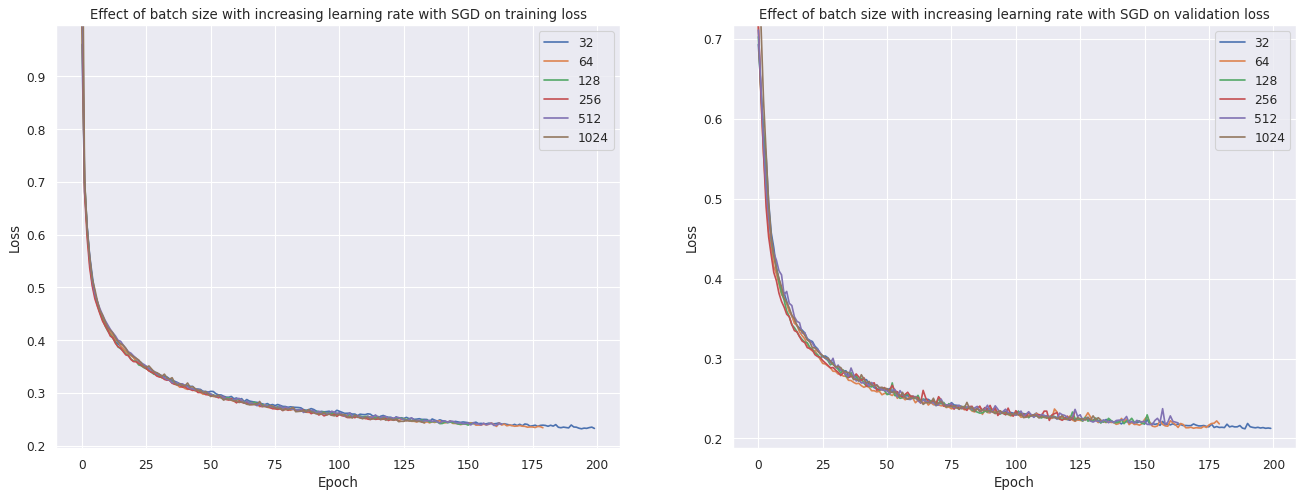

In [161]:
visualization.plot_loss_by_param(models_states[key], 'batch size with increasing learning rate with SGD',
                                 'diff_lr_diff_bs_SGD_NONE')

#### Sharpness

In [162]:
if RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        model = models[key + (batch_size, lr)]

        sharpness = visualization.get_sharpness(model, train)
        sharpnesses[key + (batch_size, lr)] = sharpness

        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG:
    sharpnesses = ml_utils.load_sharpnesses_dict()

 7/47 [===>..........................] - ETA: 0s - loss: 0.1807 - accuracy: 0.9358

2022-02-26 06:27:20.852246: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 13ms/step - loss: 0.1795 - accuracy: 0.9381
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.79515D-01    |proj g|=  2.64401D-02
47/47 [==============================] - 1s 13ms/step - loss: 1.5176 - accuracy: 0.4698

At iterate    1    f= -1.51764D+00    |proj g|=  3.95496D-02
  ys=-9.413E+01  -gs= 6.982E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 5.9606 - accuracy: 0.3179

At iterate    2    f= -5.96055D+00    |proj g|=  4.48110D-02
  ys=-2.987E+02  -gs= 7.745E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 7.6151 - accuracy: 0.3011

At iterate    3    f= -7.61514D+00    |proj g|=  5.28803D-02
  ys=-5.178E+01  -gs= 5.824E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 13ms/step - loss: 8.3675 - accura


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 12ms/step - loss: 9.1353 - accuracy: 0.2971

At iterate    7    f= -9.13529D+00    |proj g|=  3.38173D-02
47/47 [==============================] - 1s 13ms/step - loss: 9.1368 - accuracy: 0.2971

At iterate    8    f= -9.13677D+00    |proj g|=  3.36710D-02
11/47 [======>.......................] - ETA: 0s - loss: 9.5184 - accuracy: 0.2919


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 12ms/step - loss: 9.4113 - accuracy: 0.2972

At iterate    9    f= -9.41129D+00    |proj g|=  3.31011D-02
  ys=-1.349E+00  -gs= 1.209E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 9.4958 - accuracy: 0.2979

At iterate   10    f= -9.49578D+00    |proj g|=  3.31011D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786     10     13  68751     5 57317   3.310D-02  -9.496D+00
  F =  -9.4957809448242188     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
 7/47 [===>..........................] - ETA: 0s - loss: 0.1860 - accur

2022-02-26 06:27:49.199143: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 12ms/step - loss: 0.1831 - accuracy: 0.9374
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.83130D-01    |proj g|=  2.43671D-02
47/47 [==============================] - 1s 11ms/step - loss: 1.5583 - accuracy: 0.6262

At iterate    1    f= -1.55832D+00    |proj g|=  3.92789D-02
  ys=-7.612E+01  -gs= 6.338E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 6.3290 - accuracy: 0.3790

At iterate    2    f= -6.32902D+00    |proj g|=  3.89349D-02
  ys=-3.275E+02  -gs= 8.838E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 7.6229 - accuracy: 0.3655

At iterate    3    f= -7.62289D+00    |proj g|=  3.89349D-02
  ys=-4.107E+01  -gs= 4.323E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 7.9341 - accura


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 11ms/step - loss: 8.1521 - accuracy: 0.3524

At iterate   10    f= -8.15210D+00    |proj g|=  2.33602D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786     10     12  65137     7 56175   2.336D-02  -8.152D+00
  F =  -8.1521005630493164     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
 7/47 [===>..........................] - ETA: 0s - loss: 0.1925 - accuracy: 0.9337

2022-02-26 06:28:14.900298: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 12ms/step - loss: 0.1912 - accuracy: 0.9354
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.91225D-01    |proj g|=  2.33985D-02
47/47 [==============================] - 1s 12ms/step - loss: 1.3135 - accuracy: 0.4703

At iterate    1    f= -1.31355D+00    |proj g|=  3.88367D-02
  ys=-6.576E+01  -gs= 7.692E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 3.3107 - accuracy: 0.3632

At iterate    2    f= -3.31070D+00    |proj g|=  4.38578D-02
  ys=-1.218E+02  -gs= 4.028E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 5.8899 - accuracy: 0.3574

At iterate    3    f= -5.88988D+00    |proj g|=  4.67970D-02
  ys=-1.585E+02  -gs= 4.989E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 7.4304 - accura

2022-02-26 06:28:38.533169: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 12ms/step - loss: 0.1985 - accuracy: 0.9317
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.98505D-01    |proj g|=  2.25338D-02
47/47 [==============================] - 1s 12ms/step - loss: 2.0152 - accuracy: 0.4392

At iterate    1    f= -2.01518D+00    |proj g|=  4.01972D-02
  ys=-1.063E+02  -gs= 8.530E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 7.3267 - accuracy: 0.3031

At iterate    2    f= -7.32674D+00    |proj g|=  3.80051D-02
  ys=-2.747E+02  -gs= 1.091E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 9.8630 - accuracy: 0.3006

At iterate    3    f= -9.86298D+00    |proj g|=  3.50024D-02
  ys=-9.749E+01  -gs= 8.413E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 10.7779 - accur


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 12ms/step - loss: 10.9478 - accuracy: 0.3009

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      8     10  69783     3 58601   3.235D-02  -1.095D+01
  F =  -10.945178031921387     

ABNORMAL_TERMINATION_IN_LNSRCH                              
 1/47 [..............................] - ETA: 6s - loss: 0.1638 - accuracy: 0.9443


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
2022-02-26 06:29:00.848824: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 12ms/step - loss: 0.1892 - accuracy: 0.9356
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.89249D-01    |proj g|=  2.58677D-02
47/47 [==============================] - 1s 11ms/step - loss: 1.4129 - accuracy: 0.4906

At iterate    1    f= -1.41291D+00    |proj g|=  4.83649D-02
  ys=-5.854E+01  -gs= 8.567E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 4.7507 - accuracy: 0.3246

At iterate    2    f= -4.75071D+00    |proj g|=  4.71950D-02
  ys=-2.307E+02  -gs= 5.676E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 10ms/step - loss: 6.9513 - accuracy: 0.3039

At iterate    3    f= -6.95135D+00    |proj g|=  5.17354D-02
  ys=-7.884E+01  -gs= 6.483E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 8.2425 - accura


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 11ms/step - loss: 8.8996 - accuracy: 0.3061

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      9     11  71355     5 57353   3.902D-02  -8.941D+00
  F =  -8.9409446716308594     

ABNORMAL_TERMINATION_IN_LNSRCH                              
 7/47 [===>..........................] - ETA: 0s - loss: 0.1962 - accuracy: 0.9342


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
2022-02-26 06:29:24.685269: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 13ms/step - loss: 0.1965 - accuracy: 0.9330
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.96528D-01    |proj g|=  2.37927D-02
47/47 [==============================] - 1s 11ms/step - loss: 1.7601 - accuracy: 0.4275

At iterate    1    f= -1.76009D+00    |proj g|=  4.22585D-02
  ys=-7.809E+01  -gs= 9.559E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 4.1666 - accuracy: 0.2777

At iterate    2    f= -4.16655D+00    |proj g|=  4.22585D-02
  ys=-1.407E+02  -gs= 5.302E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 6.1661 - accuracy: 0.2529

At iterate    3    f= -6.16606D+00    |proj g|=  4.49042D-02
  ys=-6.666E+01  -gs= 6.594E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 7.4497 - accura

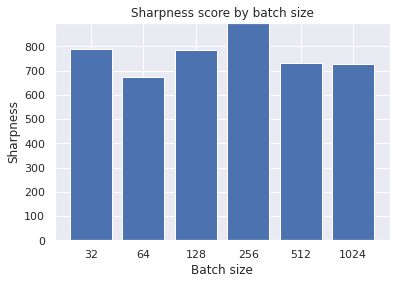

In [163]:
visualization.plot_sharpness(batch_sizes, sharpnesses, key, learning_rates)

#### Distance from initial weights

Batch size: 32, distance: 0.0
Batch size: 64, distance: 0.0
Batch size: 128, distance: 0.0
Batch size: 256, distance: 0.0
Batch size: 512, distance: 0.0
Batch size: 1024, distance: 0.0


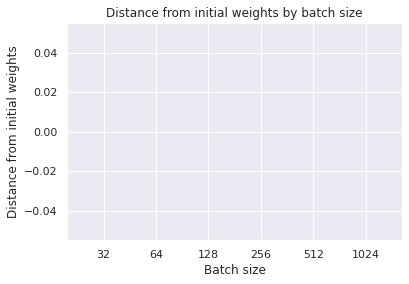

In [164]:
visualization.plot_distance_from_initial_weight(models, initial_weights, batch_sizes, key, learning_rates)

#### Runtime

In [165]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states,
                                                                                                     batch_sizes, key)

Batch size:  32
	Mean time per epoch:  5.304590003490448
	Converged in 189 epochs
	Overall training time (in seconds) until convergence:  1002.8026325702667
Batch size:  64
	Mean time per epoch:  2.860205498006609
	Converged in 169 epochs
	Overall training time (in seconds) until convergence:  483.1740868091583
Batch size:  128
	Mean time per epoch:  2.0791520433488233
	Converged in 142 epochs
	Overall training time (in seconds) until convergence:  295.3562743663788
Batch size:  256
	Mean time per epoch:  1.660095872417573
	Converged in 113 epochs
	Overall training time (in seconds) until convergence:  187.8858780860901
Batch size:  512
	Mean time per epoch:  1.4065910199793374
	Converged in 153 epochs
	Overall training time (in seconds) until convergence:  215.29063868522644
Batch size:  1024
	Mean time per epoch:  1.2976750509062809
	Converged in 123 epochs
	Overall training time (in seconds) until convergence:  159.8224377632141


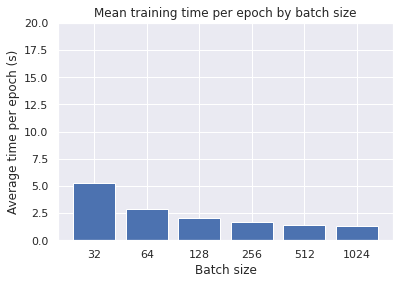

In [166]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

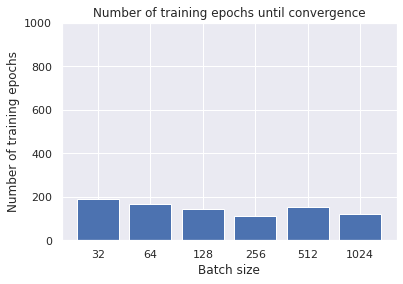

In [167]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

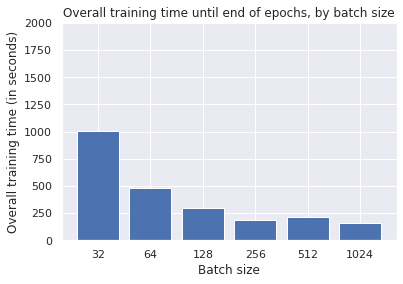

In [168]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

In [169]:
# Save to Drive in case we run on Google Colab
if USE_COLAB:
    !cp -r /content/graphs/ /content/drive/MyDrive/
    !cp -r /content/tmp/ /content/drive/MyDrive/

### ADAM

In [170]:
learning_rates = [0.001, 0.002, 0.004, 0.008, 0.016, 0.032]
batch_sizes = [32, 64, 128, 256, 512, 1024]
training_epochs = EPOCHS

key = ('increasing', 'adam', 'none')

In [171]:
state_filename = 'model_diff_lr_diff_bs_adam_state'

In [172]:
if not RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                          batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.Adam(learning_rate=lr)
        model = build_and_load_model_weights(train, optimizer,
                                             filename_bs_lr_opt_sam(batch_size, lr, "ADAM", "NONE"))
        models[key + (batch_size, lr)] = model

In [173]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size, lr in zip(batch_sizes, learning_rates):
        with tf.distribute.MirroredStrategy().scope():
            # Read training data
            train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                              batch_size=batch_size,
                                                                              img_size=32)

            optimizer = keras.optimizers.Adam(learning_rate=lr)
            model = tf_models.build_and_compile_simple_cnn(train, optimizer)
            train_callbacks = callback_for_filename(filename_bs_lr_opt_sam(batch_size, lr, "ADAM", "NONE"))

            models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                  extra_callbacks=train_callbacks, verbose=1)
            models[key + (batch_size, lr)] = model
            initial_weights[key + (batch_size, lr)] = model.get_weights()
            ml_utils.save_initial_weights_dict(initial_weights)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 06:29:49.522747: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
1492/1500 [============================>.] - ETA: 0s - loss: 0.5757 - accuracy: 0.7904

2022-02-26 06:29:54.610006: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.38138, saving model to tmp/model_lr_0.001_diff_bs_32_opt_ADAM_sam_NONE.tf
1500/1500 [==============================] - 6s 4ms/step - loss: 0.5746 - accuracy: 0.7907 - val_loss: 0.3814 - val_accuracy: 0.8672
Epoch 2/500
1484/1500 [============================>.] - ETA: 0s - loss: 0.4159 - accuracy: 0.8520
Epoch 2: val_loss improved from 0.38138 to 0.33362, saving model to tmp/model_lr_0.001_diff_bs_32_opt_ADAM_sam_NONE.tf
1500/1500 [==============================] - 5s 4ms/step - loss: 0.4154 - accuracy: 0.8521 - val_loss: 0.3336 - val_accuracy: 0.8814
Epoch 3/500
1495/1500 [============================>.] - ETA: 0s - loss: 0.3763 - accuracy: 0.8681
Epoch 3: val_loss improved from 0.33362 to 0.30469, saving model to tmp/model_lr_0.001_diff_bs_32_opt_ADAM_sam_NONE.tf
1500/1500 [==============================] - 5s 4ms/step - loss: 0.3762 - accuracy: 0.8681 - val_loss: 0.3047 - val_accuracy: 0.8921
Epoch 4/500
1498/1500 [==========================

1494/1500 [============================>.] - ETA: 0s - loss: 0.2582 - accuracy: 0.9047
Epoch 26: val_loss did not improve from 0.21986
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2581 - accuracy: 0.9047 - val_loss: 0.2211 - val_accuracy: 0.9207
Epoch 27/500
1485/1500 [============================>.] - ETA: 0s - loss: 0.2556 - accuracy: 0.9064
Epoch 27: val_loss did not improve from 0.21986
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2553 - accuracy: 0.9064 - val_loss: 0.2252 - val_accuracy: 0.9220
Epoch 28/500
1500/1500 [==============================] - ETA: 0s - loss: 0.2491 - accuracy: 0.9094
Epoch 28: val_loss did not improve from 0.21986
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2491 - accuracy: 0.9094 - val_loss: 0.2201 - val_accuracy: 0.9193
Epoch 29/500
1486/1500 [============================>.] - ETA: 0s - loss: 0.2540 - accuracy: 0.9077
Epoch 29: val_loss did not improve from 0.21986
1500/1500 [===========

1492/1500 [============================>.] - ETA: 0s - loss: 0.2377 - accuracy: 0.9131
Epoch 54: val_loss improved from 0.21103 to 0.21057, saving model to tmp/model_lr_0.001_diff_bs_32_opt_ADAM_sam_NONE.tf
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2375 - accuracy: 0.9132 - val_loss: 0.2106 - val_accuracy: 0.9247
Epoch 55/500
1499/1500 [============================>.] - ETA: 0s - loss: 0.2410 - accuracy: 0.9103
Epoch 55: val_loss did not improve from 0.21057
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2410 - accuracy: 0.9103 - val_loss: 0.2184 - val_accuracy: 0.9218
Epoch 56/500
1485/1500 [============================>.] - ETA: 0s - loss: 0.2368 - accuracy: 0.9136
Epoch 56: val_loss did not improve from 0.21057
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2366 - accuracy: 0.9137 - val_loss: 0.2231 - val_accuracy: 0.9208
Epoch 57/500
1490/1500 [============================>.] - ETA: 0s - loss: 0.2405 - accuracy: 0.910

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 06:35:39.572584: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
750/750 [==============================] - ETA: 0s - loss: 0.5573 - accuracy: 0.7969

2022-02-26 06:35:42.583707: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.37349, saving model to tmp/model_lr_0.002_diff_bs_64_opt_ADAM_sam_NONE.tf
750/750 [==============================] - 5s 6ms/step - loss: 0.5573 - accuracy: 0.7969 - val_loss: 0.3735 - val_accuracy: 0.8673
Epoch 2/500
741/750 [============================>.] - ETA: 0s - loss: 0.4093 - accuracy: 0.8554
Epoch 2: val_loss improved from 0.37349 to 0.33583, saving model to tmp/model_lr_0.002_diff_bs_64_opt_ADAM_sam_NONE.tf
750/750 [==============================] - 3s 4ms/step - loss: 0.4086 - accuracy: 0.8555 - val_loss: 0.3358 - val_accuracy: 0.8810
Epoch 3/500
737/750 [============================>.] - ETA: 0s - loss: 0.3746 - accuracy: 0.8679
Epoch 3: val_loss improved from 0.33583 to 0.31293, saving model to tmp/model_lr_0.002_diff_bs_64_opt_ADAM_sam_NONE.tf
750/750 [==============================] - 3s 4ms/step - loss: 0.3736 - accuracy: 0.8682 - val_loss: 0.3129 - val_accuracy: 0.8882
Epoch 4/500
740/750 [============================>.] - ETA:

735/750 [============================>.] - ETA: 0s - loss: 0.2718 - accuracy: 0.9004
Epoch 27: val_loss did not improve from 0.23008
750/750 [==============================] - 3s 4ms/step - loss: 0.2710 - accuracy: 0.9008 - val_loss: 0.2306 - val_accuracy: 0.9154
Epoch 28/500
739/750 [============================>.] - ETA: 0s - loss: 0.2689 - accuracy: 0.9014
Epoch 28: val_loss did not improve from 0.23008
750/750 [==============================] - 3s 4ms/step - loss: 0.2687 - accuracy: 0.9015 - val_loss: 0.2360 - val_accuracy: 0.9149
Epoch 29/500
738/750 [============================>.] - ETA: 0s - loss: 0.2719 - accuracy: 0.9003
Epoch 29: val_loss improved from 0.23008 to 0.22869, saving model to tmp/model_lr_0.002_diff_bs_64_opt_ADAM_sam_NONE.tf
750/750 [==============================] - 3s 4ms/step - loss: 0.2712 - accuracy: 0.9005 - val_loss: 0.2287 - val_accuracy: 0.9182
Epoch 30/500
747/750 [============================>.] - ETA: 0s - loss: 0.2699 - accuracy: 0.9018
Epoch 30: va

Epoch 55/500
737/750 [============================>.] - ETA: 0s - loss: 0.2577 - accuracy: 0.9052
Epoch 55: val_loss did not improve from 0.21949
750/750 [==============================] - 3s 4ms/step - loss: 0.2572 - accuracy: 0.9053 - val_loss: 0.2316 - val_accuracy: 0.9176
Epoch 56/500
743/750 [============================>.] - ETA: 0s - loss: 0.2594 - accuracy: 0.9041
Epoch 56: val_loss did not improve from 0.21949
750/750 [==============================] - 3s 4ms/step - loss: 0.2587 - accuracy: 0.9044 - val_loss: 0.2300 - val_accuracy: 0.9181
Epoch 57/500
737/750 [============================>.] - ETA: 0s - loss: 0.2564 - accuracy: 0.9052
Epoch 57: val_loss did not improve from 0.21949
750/750 [==============================] - 3s 4ms/step - loss: 0.2561 - accuracy: 0.9052 - val_loss: 0.2407 - val_accuracy: 0.9152
Epoch 58/500
749/750 [============================>.] - ETA: 0s - loss: 0.2553 - accuracy: 0.9065
Epoch 58: val_loss did not improve from 0.21949
750/750 [==============

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 06:38:30.979702: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
364/375 [============================>.] - ETA: 0s - loss: 0.5547 - accuracy: 0.7989

2022-02-26 06:38:34.238130: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.37062, saving model to tmp/model_lr_0.004_diff_bs_128_opt_ADAM_sam_NONE.tf
375/375 [==============================] - 5s 9ms/step - loss: 0.5509 - accuracy: 0.8002 - val_loss: 0.3706 - val_accuracy: 0.8718
Epoch 2/500
375/375 [==============================] - ETA: 0s - loss: 0.4081 - accuracy: 0.8540
Epoch 2: val_loss improved from 0.37062 to 0.31905, saving model to tmp/model_lr_0.004_diff_bs_128_opt_ADAM_sam_NONE.tf
375/375 [==============================] - 2s 6ms/step - loss: 0.4081 - accuracy: 0.8540 - val_loss: 0.3190 - val_accuracy: 0.8888
Epoch 3/500
366/375 [============================>.] - ETA: 0s - loss: 0.3734 - accuracy: 0.8661
Epoch 3: val_loss improved from 0.31905 to 0.30215, saving model to tmp/model_lr_0.004_diff_bs_128_opt_ADAM_sam_NONE.tf
375/375 [==============================] - 2s 6ms/step - loss: 0.3739 - accuracy: 0.8659 - val_loss: 0.3021 - val_accuracy: 0.8947
Epoch 4/500
375/375 [==============================] - E

Epoch 28/500
372/375 [============================>.] - ETA: 0s - loss: 0.2870 - accuracy: 0.8944
Epoch 28: val_loss did not improve from 0.24370
375/375 [==============================] - 2s 6ms/step - loss: 0.2864 - accuracy: 0.8946 - val_loss: 0.2459 - val_accuracy: 0.9162
Epoch 29/500
373/375 [============================>.] - ETA: 0s - loss: 0.2915 - accuracy: 0.8920
Epoch 29: val_loss improved from 0.24370 to 0.24364, saving model to tmp/model_lr_0.004_diff_bs_128_opt_ADAM_sam_NONE.tf
375/375 [==============================] - 2s 5ms/step - loss: 0.2913 - accuracy: 0.8920 - val_loss: 0.2436 - val_accuracy: 0.9131
Epoch 30/500
371/375 [============================>.] - ETA: 0s - loss: 0.2917 - accuracy: 0.8923
Epoch 30: val_loss did not improve from 0.24364
375/375 [==============================] - 2s 5ms/step - loss: 0.2916 - accuracy: 0.8922 - val_loss: 0.2580 - val_accuracy: 0.9129
Epoch 31/500
365/375 [============================>.] - ETA: 0s - loss: 0.2867 - accuracy: 0.894

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 06:40:00.943821: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
182/188 [============================>.] - ETA: 0s - loss: 0.5902 - accuracy: 0.7903

2022-02-26 06:40:02.822985: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.37856, saving model to tmp/model_lr_0.008_diff_bs_256_opt_ADAM_sam_NONE.tf
188/188 [==============================] - 2s 11ms/step - loss: 0.5857 - accuracy: 0.7916 - val_loss: 0.3786 - val_accuracy: 0.8647
Epoch 2/500
183/188 [============================>.] - ETA: 0s - loss: 0.4110 - accuracy: 0.8530
Epoch 2: val_loss improved from 0.37856 to 0.33052, saving model to tmp/model_lr_0.008_diff_bs_256_opt_ADAM_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.4104 - accuracy: 0.8530 - val_loss: 0.3305 - val_accuracy: 0.8857
Epoch 3/500
187/188 [============================>.] - ETA: 0s - loss: 0.3785 - accuracy: 0.8624
Epoch 3: val_loss improved from 0.33052 to 0.31305, saving model to tmp/model_lr_0.008_diff_bs_256_opt_ADAM_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.3783 - accuracy: 0.8625 - val_loss: 0.3130 - val_accuracy: 0.8906
Epoch 4/500
185/188 [============================>.] - 

188/188 [==============================] - 2s 9ms/step - loss: 0.3185 - accuracy: 0.8834 - val_loss: 0.2710 - val_accuracy: 0.9077
Epoch 29/500
187/188 [============================>.] - ETA: 0s - loss: 0.3234 - accuracy: 0.8799
Epoch 29: val_loss did not improve from 0.26095
188/188 [==============================] - 2s 8ms/step - loss: 0.3231 - accuracy: 0.8800 - val_loss: 0.2822 - val_accuracy: 0.9024
Epoch 30/500
183/188 [============================>.] - ETA: 0s - loss: 0.3220 - accuracy: 0.8814
Epoch 30: val_loss did not improve from 0.26095
188/188 [==============================] - 2s 9ms/step - loss: 0.3212 - accuracy: 0.8817 - val_loss: 0.2645 - val_accuracy: 0.9051
Epoch 31/500
181/188 [===========================>..] - ETA: 0s - loss: 0.3187 - accuracy: 0.8816
Epoch 31: val_loss improved from 0.26095 to 0.25297, saving model to tmp/model_lr_0.008_diff_bs_256_opt_ADAM_sam_NONE.tf
188/188 [==============================] - 2s 9ms/step - loss: 0.3182 - accuracy: 0.8819 - val_l

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 06:41:11.707764: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
92/94 [============================>.] - ETA: 0s - loss: 0.7701 - accuracy: 0.7311

2022-02-26 06:41:13.445846: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.44780, saving model to tmp/model_lr_0.016_diff_bs_512_opt_ADAM_sam_NONE.tf
94/94 [==============================] - 3s 31ms/step - loss: 0.7647 - accuracy: 0.7327 - val_loss: 0.4478 - val_accuracy: 0.8428
Epoch 2/500
91/94 [============================>.] - ETA: 0s - loss: 0.4991 - accuracy: 0.8203
Epoch 2: val_loss improved from 0.44780 to 0.40531, saving model to tmp/model_lr_0.016_diff_bs_512_opt_ADAM_sam_NONE.tf
94/94 [==============================] - 1s 15ms/step - loss: 0.4978 - accuracy: 0.8203 - val_loss: 0.4053 - val_accuracy: 0.8595
Epoch 3/500
93/94 [============================>.] - ETA: 0s - loss: 0.4553 - accuracy: 0.8350
Epoch 3: val_loss improved from 0.40531 to 0.36763, saving model to tmp/model_lr_0.016_diff_bs_512_opt_ADAM_sam_NONE.tf
94/94 [==============================] - 1s 15ms/step - loss: 0.4546 - accuracy: 0.8353 - val_loss: 0.3676 - val_accuracy: 0.8727
Epoch 4/500
90/94 [===========================>..] - ETA: 0s - 

Epoch 29/500
91/94 [============================>.] - ETA: 0s - loss: 0.3869 - accuracy: 0.8568
Epoch 29: val_loss did not improve from 0.30044
94/94 [==============================] - 1s 15ms/step - loss: 0.3863 - accuracy: 0.8568 - val_loss: 0.3348 - val_accuracy: 0.8839
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-26 06:41:57.198754: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


Epoch 1/500
46/47 [============================>.] - ETA: 0s - loss: 1.2997 - accuracy: 0.5690

2022-02-26 06:41:58.925890: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.64582, saving model to tmp/model_lr_0.032_diff_bs_1024_opt_ADAM_sam_NONE.tf
47/47 [==============================] - 2s 40ms/step - loss: 1.2882 - accuracy: 0.5721 - val_loss: 0.6458 - val_accuracy: 0.7708
Epoch 2/500
46/47 [============================>.] - ETA: 0s - loss: 0.6952 - accuracy: 0.7438
Epoch 2: val_loss did not improve from 0.64582
47/47 [==============================] - 1s 27ms/step - loss: 0.6941 - accuracy: 0.7444 - val_loss: 0.6474 - val_accuracy: 0.7920
Epoch 3/500
46/47 [============================>.] - ETA: 0s - loss: 0.6611 - accuracy: 0.7592
Epoch 3: val_loss improved from 0.64582 to 0.62902, saving model to tmp/model_lr_0.032_diff_bs_1024_opt_ADAM_sam_NONE.tf
47/47 [==============================] - 1s 27ms/step - loss: 0.6601 - accuracy: 0.7595 - val_loss: 0.6290 - val_accuracy: 0.7933
Epoch 4/500
46/47 [============================>.] - ETA: 0s - loss: 0.6516 - accuracy: 0.7597
Epoch 4: val_loss improved from 0.62902

In [174]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], state_filename)
else:
    models_states[key] = ml_utils.load_model_state(state_filename)

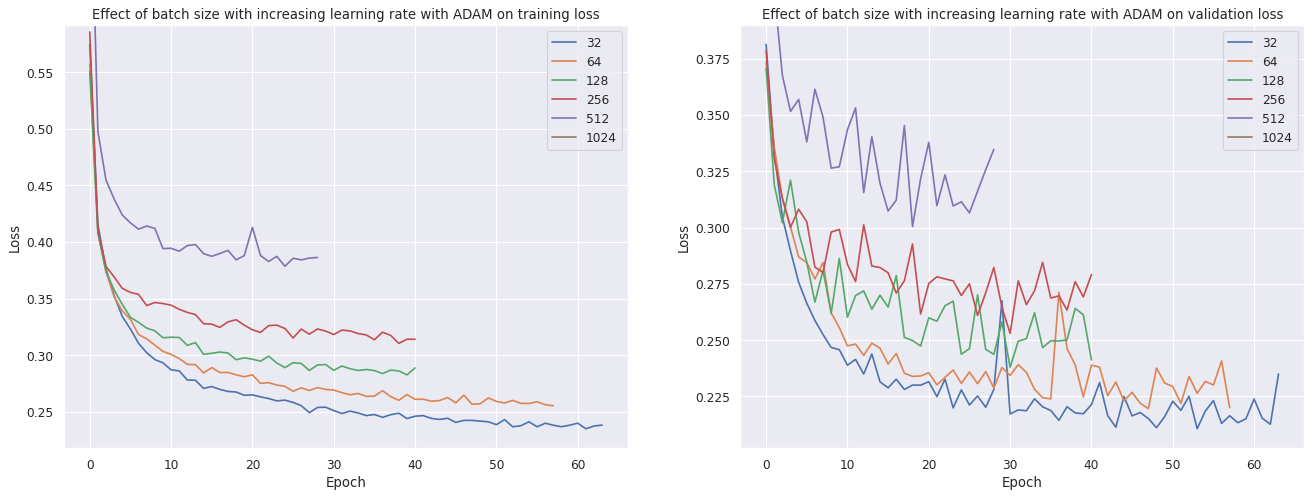

In [175]:
visualization.plot_loss_by_param(models_states[key], 'batch size with increasing learning rate with ADAM',
                                 'diff_lr_diff_bs_ADAM_NONE')

#### Sharpness

In [176]:
if RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        model = models[key + (batch_size, lr)]

        sharpness = visualization.get_sharpness(model, train)
        sharpnesses[key + (batch_size, lr)] = sharpness

        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG:
    sharpnesses = ml_utils.load_sharpnesses_dict()

 7/47 [===>..........................] - ETA: 0s - loss: 0.1691 - accuracy: 0.9428

2022-02-26 06:42:17.834180: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 13ms/step - loss: 0.1659 - accuracy: 0.9438
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.65854D-01    |proj g|=  1.83256D-02
47/47 [==============================] - 1s 11ms/step - loss: 0.7787 - accuracy: 0.7160

At iterate    1    f= -7.78722D-01    |proj g|=  3.09349D-02
  ys=-4.085E+01  -gs= 5.307E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 0.9651 - accuracy: 0.6711

At iterate    2    f= -9.65066D-01    |proj g|=  3.14341D-02
  ys=-1.530E+00  -gs= 7.912E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 0.9730 - accuracy: 0.6726

At iterate    3    f= -9.72999D-01    |proj g|=  3.18207D-02
47/47 [==============================] - 1s 13ms/step - loss: 0.9733 - accuracy: 0.6723

At iterate    4    f= -9.73305D-01    |p

2022-02-26 06:42:41.575247: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 12ms/step - loss: 0.1787 - accuracy: 0.9391
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.78685D-01    |proj g|=  1.79355D-02
47/47 [==============================] - 1s 11ms/step - loss: 0.4903 - accuracy: 0.8558

At iterate    1    f= -4.90340D-01    |proj g|=  3.35883D-02
  ys=-2.713E+01  -gs= 4.070E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 0.6346 - accuracy: 0.8038

At iterate    2    f= -6.34570D-01    |proj g|=  2.76136D-02
  ys=-2.920E+00  -gs= 4.950E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 0.6579 - accuracy: 0.7838

At iterate    3    f= -6.57863D-01    |proj g|=  2.83314D-02
  ys=-1.179E+00  -gs= 6.422E-01 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 0.7552 - accura

2022-02-26 06:43:05.294944: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 13ms/step - loss: 0.2094 - accuracy: 0.9265
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.09410D-01    |proj g|=  2.18673D-02
47/47 [==============================] - 1s 12ms/step - loss: 0.4003 - accuracy: 0.8577

At iterate    1    f= -4.00299D-01    |proj g|=  2.95757D-02
  ys=-8.560E+00  -gs= 5.368E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 0.4525 - accuracy: 0.8536

At iterate    2    f= -4.52523D-01    |proj g|=  3.39308D-02
  ys=-8.235E+00  -gs= 2.240E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 0.6916 - accuracy: 0.8378

At iterate    3    f= -6.91626D-01    |proj g|=  3.35212D-02
  ys=-1.019E+01  -gs= 3.780E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 0.7619 - accura

2022-02-26 06:43:28.938697: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 11ms/step - loss: 0.2297 - accuracy: 0.9173
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.29714D-01    |proj g|=  2.17180D-02
47/47 [==============================] - 1s 11ms/step - loss: 0.5322 - accuracy: 0.8149

At iterate    1    f= -5.32194D-01    |proj g|=  3.48116D-02
  ys=-1.462E+01  -gs= 6.191E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 0.6247 - accuracy: 0.7634

At iterate    2    f= -6.24699D-01    |proj g|=  3.41327D-02
  ys=-1.650E+00  -gs= 3.519E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 13ms/step - loss: 0.6404 - accuracy: 0.7462

At iterate    3    f= -6.40428D-01    |proj g|=  2.58680D-02
  ys=-2.933E-01  -gs= 5.955E-01 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 0.6458 - accura

2022-02-26 06:43:52.457783: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 13ms/step - loss: 0.2947 - accuracy: 0.8989
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.94724D-01    |proj g|=  2.62424D-02
47/47 [==============================] - 1s 12ms/step - loss: 0.5921 - accuracy: 0.8318

At iterate    1    f= -5.92085D-01    |proj g|=  3.25304D-02
  ys=-1.733E+01  -gs= 3.610E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 0.6398 - accuracy: 0.7735

At iterate    2    f= -6.39821D-01    |proj g|=  2.86432D-02
  ys=-9.063E-01  -gs= 1.786E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 0.6453 - accuracy: 0.7647

At iterate    3    f= -6.45287D-01    |proj g|=  2.59196D-02
  ys=-1.147E-01  -gs= 2.038E-01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 0.6478 - accura

2022-02-26 06:44:16.067881: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 12ms/step - loss: 0.6061 - accuracy: 0.7990
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.06055D-01    |proj g|=  2.48241D-02
47/47 [==============================] - 1s 11ms/step - loss: 0.7610 - accuracy: 0.6959

At iterate    1    f= -7.61002D-01    |proj g|=  3.20678D-02
  ys=-4.656E+00  -gs= 4.935E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 0.7705 - accuracy: 0.6863

At iterate    2    f= -7.70477D-01    |proj g|=  2.69067D-02
  ys=-1.264E-01  -gs= 3.817E-01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 0.7720 - accuracy: 0.6848

At iterate    3    f= -7.72019D-01    |proj g|=  1.94077D-02
  ys=-1.196E-02  -gs= 6.639E-02 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 0.7725 - accura

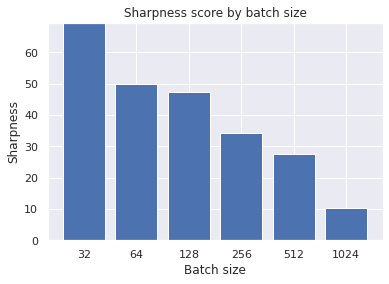

In [177]:
visualization.plot_sharpness(batch_sizes, sharpnesses, key, learning_rates)

#### Distance from initial weights

Batch size: 32, distance: 0.0
Batch size: 64, distance: 0.0
Batch size: 128, distance: 0.0
Batch size: 256, distance: 0.0
Batch size: 512, distance: 0.0
Batch size: 1024, distance: 0.0


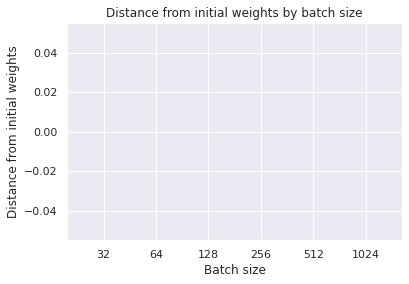

In [178]:
visualization.plot_distance_from_initial_weight(models, initial_weights, batch_sizes, key, learning_rates)

#### Runtime

In [179]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states,
                                                                                                     batch_sizes, key)

Batch size:  32
	Mean time per epoch:  5.403358042240143
	Converged in 53 epochs
	Overall training time (in seconds) until convergence:  286.6838719844818
Batch size:  64
	Mean time per epoch:  2.8936041634658287
	Converged in 47 epochs
	Overall training time (in seconds) until convergence:  136.16499710083008
Batch size:  128
	Mean time per epoch:  2.130958138442621
	Converged in 30 epochs
	Overall training time (in seconds) until convergence:  64.59665703773499
Batch size:  256
	Mean time per epoch:  1.6572518930202578
	Converged in 30 epochs
	Overall training time (in seconds) until convergence:  49.94928812980652
Batch size:  512
	Mean time per epoch:  1.464420145955579
	Converged in 18 epochs
	Overall training time (in seconds) until convergence:  27.0581271648407
Batch size:  1024
	Mean time per epoch:  1.353660992213658
	Converged in 3 epochs
	Overall training time (in seconds) until convergence:  4.87767481803894


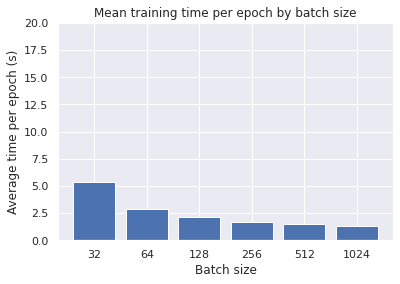

In [180]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

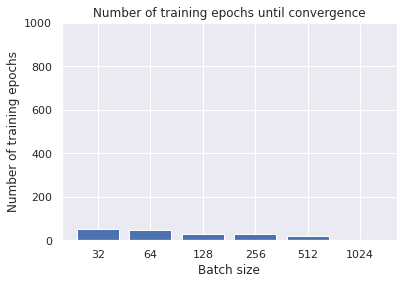

In [181]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

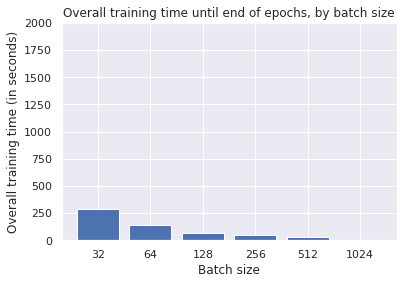

In [182]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

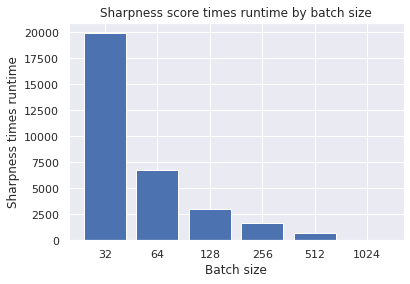

In [183]:
visualization.plot_sharpness_times_runtime(batch_sizes, overall_training_times, sharpnesses, key, learning_rates)